In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting a detached eclipsing binary

In this case study, we'll go through the steps required to fit the light curve and radial velocity measurements for the detached eclipsing binary system HD 23642.
This is a bright system that has been fit by many authors ([1](https://arxiv.org/abs/astro-ph/0403444), [2](https://arxiv.org/abs/astro-ph/0409507), [3](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract), [4](https://arxiv.org/abs/1602.01901), and [5](https://arxiv.org/abs/1603.08484) to name a few) so this is a good benchmark for our demonstration.

The light curve that we'll use is from K2 and we'll use the same radial velocity measurements as [David+ (2016)](https://arxiv.org/abs/1602.01901) compiled from [here](https://arxiv.org/abs/astro-ph/0403444) and [here](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract).
We'll use a somewhat simplified model for the eclipses that treats the stars as spherical and ignores the phase curve (we'll model it using a Gaussian process instead of a more physically motivated model).
But, as you'll see, these simplifying assumptions are sufficient for this case of a detached and well behaved system.
Unlike some previous studies, we will fit an eccentric orbit instead of fixing the eccentricity to zero.
This probably isn't really necessary here, but it's useful to demonstrate how you would fit a more eccentric system.
Finally, we model the phase curve and other triends in both the light curve and radial velocities using Gaussian processes.
This will account for unmodeled stellar variability and residual systematics, drifts, and other effects left over from the data reduction procedure.

## Data access

First, let's define some values from the literature that will be useful below.
Here we're taking the period and eclipse time from [David+ (2016)](https://arxiv.org/abs/1602.01901) as initial guesses for these parameters in our fit.
We'll also include the same prior on the flux ratio of the two stars that was computed for the Kepler bandpass by [David+ (2016)](https://arxiv.org/abs/1602.01901).

In [3]:
lit_period = 2.46113408
lit_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
lit_flux_ratio = (0.354, 0.035)

Then we'll download the Kepler data.
In this case, the pipeline aperture photometry isn't very good (because this star is so bright!) so we'll just download the target pixel file and co-add all the pixels.

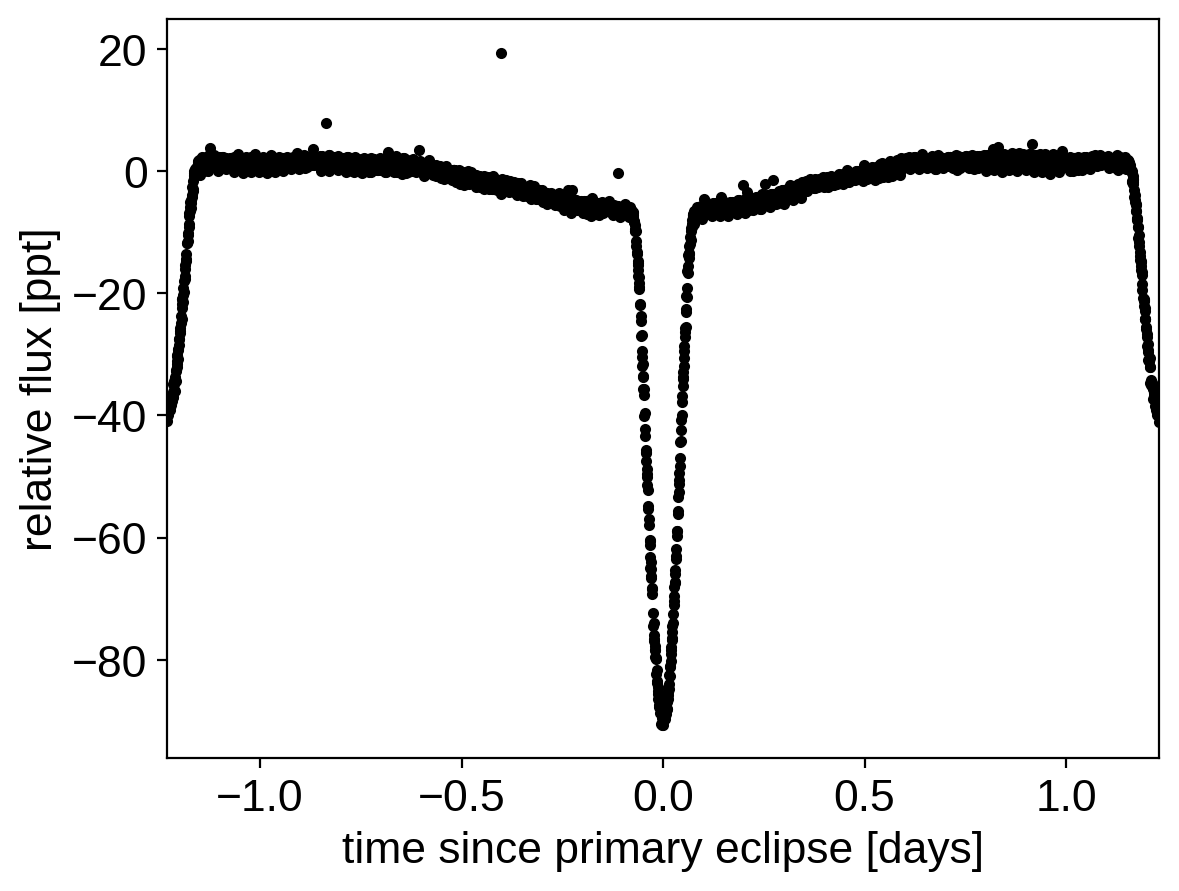

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot((x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k")
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

Then we'll enter the radial velocity data.
I couldn't find these data online anywhere so I manually transcribed the data from the referenced papers (typos are my own!).

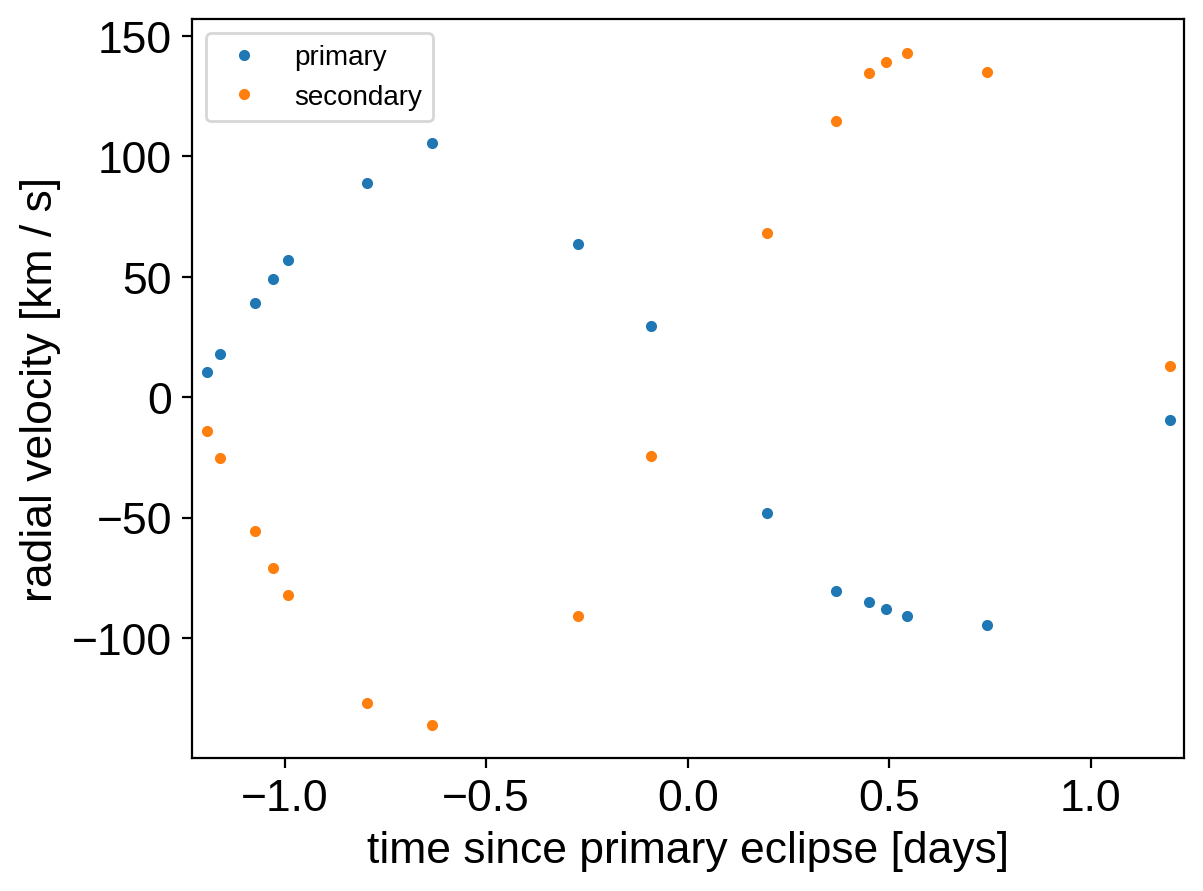

In [5]:
ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

x_rv = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
y1_rv = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
y2_rv = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

fold = (rvs[:, 0] - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
plt.plot(fold, rvs[:, 1], ".", label="primary")
plt.plot(fold, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

## Probabilistic model

Then we define the probabilistic model using PyMC3 and exoplanet.
This is similar to the other tutorials and case studies, but here we're using a :class:`exoplanet.SecondaryEclipseLightCurve` to generate the model light curve and we're modeling the radial velocity trends using a Gaussian process instead of a polynomial.
Otherwise, things should look pretty familiar!

After defining the model, we iteratively clip outliers in the light curve using sigma clipping and then estimate the maximum a posteriori parameters.

In [6]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sigma=10.0)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio

        # Prior on flux ratio
        pm.Normal(
            "flux_prior", mu=lit_flux_ratio[0], sigma=lit_flux_ratio[1], observed=k * s
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = xo.UnitDisk("ecs", testval=np.array([1e-5, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0)
        )
        S_tot_lc = pm.InverseGamma(
            "S_tot_lc", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_lc = pm.InverseGamma(
            "ell_lc", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_lc = xo.gp.terms.SHOTerm(
            S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0 / 3
        )

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        sigma_rv2 = pm.InverseGamma(
            "sigma_rv2", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        S_tot_rv = pm.InverseGamma(
            "S_tot_rv", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_rv = pm.InverseGamma(
            "ell_rv", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_rv = xo.gp.terms.SHOTerm(
            S_tot=S_tot_rv, w0=2 * np.pi / ell_rv, Q=1.0 / 3
        )

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = xo.gp.GP(
            kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=model_lc
        )
        gp_lc.marginal("obs_lc", observed=y[mask])

        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

        def model_rv2(t):
            return mean_rv - 1e-3 * orbit.get_radial_velocity(t) / q

        # Condition the radial velocity model on the data
        gp_rv1 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv1 ** 2, mean=model_rv1
        )
        gp_rv1.marginal("obs_rv1", observed=y1_rv)
        gp_rv2 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv2 ** 2, mean=model_rv2
        )
        gp_rv2.marginal("obs_rv2", observed=y2_rv)

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = xo.optimize(map_soln, [mean_rv, q])
        map_soln = xo.optimize(
            map_soln, [mean_rv, sigma_rv1, sigma_rv2, S_tot_rv, ell_rv]
        )

        # Then the LC parameters
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b])
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b, u1, u2])
        map_soln = xo.optimize(map_soln, [mean_lc, sigma_lc, S_tot_lc, ell_lc])
        map_soln = xo.optimize(map_soln, [t0, period])

        # Then all the parameters together
        map_soln = xo.optimize(map_soln)

        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.gp_rv1 = gp_rv1
        model.model_rv1 = model_rv1
        model.gp_rv2 = gp_rv2
        model.model_rv2 = model_rv2

        model.x = x[mask]
        model.y = y[mask]

    return model, map_soln


def sigma_clip():
    mask = np.ones(len(x), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln = build_model(mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc(x[mask]) + model.gp_lc.predict(), map_soln
            )

        resid = y[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        if num == mask.sum():
            break
        num = mask.sum()

    return model, map_soln


model, map_soln = sigma_clip()

optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.338058e+04]

1it [00:00, 118.05it/s, logp=-2.338058e+04]

2it [00:00, 168.11it/s, logp=-2.338058e+04]

3it [00:00, 189.43it/s, logp=-1.371193e+04]

4it [00:00, 203.63it/s, logp=-1.492576e+04]

5it [00:00, 216.01it/s, logp=-1.358037e+04]

6it [00:00, 223.60it/s, logp=-1.335577e+04]

7it [00:00, 230.58it/s, logp=-1.309819e+04]

8it [00:00, 235.25it/s, logp=-1.307502e+04]

9it [00:00, 239.90it/s, logp=-1.307285e+04]

10it [00:00, 242.64it/s, logp=-1.307282e+04]

11it [00:00, 245.37it/s, logp=-1.307282e+04]

12it [00:00, 247.94it/s, logp=-1.307282e+04]

13it [00:03,  3.85it/s, logp=-1.307282e+04] 


message: Optimization terminated successfully.
logp: -23380.5842277239 -> -13072.816791759677


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.307282e+04]

1it [00:00, 90.11it/s, logp=-1.307282e+04]

2it [00:00, 124.47it/s, logp=-1.307282e+04]

3it [00:00, 139.25it/s, logp=-1.018327e+04]

4it [00:00, 152.82it/s, logp=-8.904144e+03]

5it [00:00, 166.89it/s, logp=-9.241304e+03]

6it [00:00, 162.41it/s, logp=-8.795387e+03]

7it [00:00, 167.48it/s, logp=-8.676354e+03]

8it [00:00, 168.95it/s, logp=-8.648728e+03]

9it [00:00, 170.98it/s, logp=-8.606024e+03]

10it [00:00, 173.05it/s, logp=-8.554461e+03]

11it [00:00, 177.62it/s, logp=-8.728832e+03]

12it [00:00, 183.50it/s, logp=-8.521916e+03]

13it [00:00, 188.12it/s, logp=-8.640295e+03]

14it [00:00, 193.00it/s, logp=-8.512540e+03]

15it [00:00, 193.39it/s, logp=-8.502406e+03]

16it [00:00, 193.31it/s, logp=-8.491012e+03]

17it [00:00, 193.53it/s, logp=-8.499248e+03]

18it [00:00, 193.80it/s, logp=-8.484668e+03]

19it [00:00, 194.02it/s, logp=-8.483864e+03]

20it [00:00, 194.20it/s, logp=-8.483590e+03]

21it [00:00, 202.51it/s, logp=-8.483590e+03]

21it [00:00, 202.51it/s, logp=-8.483526e+03]

22it [00:00, 202.51it/s, logp=-8.483507e+03]

23it [00:00, 202.51it/s, logp=-8.483474e+03]

24it [00:00, 202.51it/s, logp=-8.483431e+03]

25it [00:00, 202.51it/s, logp=-8.483410e+03]

26it [00:00, 202.51it/s, logp=-8.483372e+03]

27it [00:00, 202.51it/s, logp=-8.483300e+03]

28it [00:00, 202.51it/s, logp=-8.483172e+03]

29it [00:00, 202.51it/s, logp=-8.482963e+03]

30it [00:00, 202.51it/s, logp=-8.482725e+03]

31it [00:00, 202.51it/s, logp=-8.482637e+03]

32it [00:00, 202.51it/s, logp=-8.482584e+03]

33it [00:00, 202.51it/s, logp=-8.482577e+03]

34it [00:00, 202.51it/s, logp=-8.482576e+03]

35it [00:00, 202.51it/s, logp=-8.482576e+03]

36it [00:00, 202.51it/s, logp=-8.482576e+03]

37it [00:00, 202.51it/s, logp=-8.482576e+03]

38it [00:00, 202.51it/s, logp=-8.482576e+03]

39it [00:00, 202.51it/s, logp=-8.482576e+03]

40it [00:00, 87.85it/s, logp=-8.482576e+03] 


message: Optimization terminated successfully.
logp: -13072.816791759677 -> -8482.576126912147


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.482576e+03]

1it [00:00, 100.37it/s, logp=-8.482576e+03]

2it [00:00, 139.97it/s, logp=-8.482576e+03]

3it [00:00, 127.56it/s, logp=-5.145584e+05]

4it [00:00, 142.79it/s, logp=-6.505263e+03]

5it [00:00, 153.73it/s, logp=-6.292747e+03]

6it [00:00, 159.88it/s, logp=-8.502956e+03]

7it [00:00, 161.32it/s, logp=-6.278122e+03]

8it [00:00, 166.17it/s, logp=-6.669084e+03]

9it [00:00, 171.11it/s, logp=-6.277575e+03]

10it [00:00, 175.02it/s, logp=-6.276471e+03]

11it [00:00, 178.60it/s, logp=-6.272057e+03]

12it [00:00, 182.05it/s, logp=-6.254494e+03]

13it [00:00, 185.08it/s, logp=-6.185706e+03]

14it [00:00, 187.29it/s, logp=-5.934077e+03]

15it [00:00, 188.44it/s, logp=-5.402332e+03]

16it [00:00, 189.10it/s, logp=-4.739662e+03]

17it [00:00, 187.69it/s, logp=-4.706432e+03]

18it [00:00, 186.10it/s, logp=-4.706090e+03]

19it [00:00, 184.93it/s, logp=-4.705681e+03]

20it [00:00, 192.97it/s, logp=-4.705681e+03]

20it [00:00, 192.97it/s, logp=-4.704991e+03]

21it [00:00, 192.97it/s, logp=-4.704003e+03]

22it [00:00, 192.97it/s, logp=-4.702929e+03]

23it [00:00, 192.97it/s, logp=-4.701202e+03]

24it [00:00, 192.97it/s, logp=-4.699296e+03]

25it [00:00, 192.97it/s, logp=-4.698727e+03]

26it [00:00, 192.97it/s, logp=-4.697899e+03]

27it [00:00, 192.97it/s, logp=-4.697236e+03]

28it [00:00, 192.97it/s, logp=-4.696966e+03]

29it [00:00, 192.97it/s, logp=-4.696770e+03]

30it [00:00, 192.97it/s, logp=-4.696757e+03]

31it [00:00, 192.97it/s, logp=-4.696727e+03]

32it [00:00, 192.97it/s, logp=-4.696703e+03]

33it [00:00, 192.97it/s, logp=-4.696694e+03]

34it [00:00, 192.97it/s, logp=-4.696693e+03]

35it [00:00, 192.97it/s, logp=-4.696693e+03]

36it [00:00, 192.97it/s, logp=-4.696693e+03]

37it [00:00, 184.79it/s, logp=-4.696693e+03]

37it [00:00, 184.79it/s, logp=-4.696693e+03]

38it [00:00, 184.79it/s, logp=-4.696693e+03]

39it [00:00, 90.36it/s, logp=-4.696693e+03] 


message: Optimization terminated successfully.
logp: -8482.576126912147 -> -4696.693195993793


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.696693e+03]

1it [00:00, 71.86it/s, logp=-4.696693e+03]

2it [00:00, 99.89it/s, logp=-4.696693e+03]

3it [00:00, 118.24it/s, logp=-5.283064e+03]

4it [00:00, 133.61it/s, logp=-4.696633e+03]

5it [00:00, 144.18it/s, logp=-4.696536e+03]

6it [00:00, 152.46it/s, logp=-4.696379e+03]

7it [00:00, 159.11it/s, logp=-4.696082e+03]

8it [00:00, 164.55it/s, logp=-4.696235e+03]

9it [00:00, 170.01it/s, logp=-4.695889e+03]

10it [00:00, 174.07it/s, logp=-4.695537e+03]

11it [00:00, 175.81it/s, logp=-4.694911e+03]

12it [00:00, 174.96it/s, logp=-4.694584e+03]

13it [00:00, 174.24it/s, logp=-4.694137e+03]

14it [00:00, 173.92it/s, logp=-4.695139e+03]

15it [00:00, 173.54it/s, logp=-4.694040e+03]

16it [00:00, 173.08it/s, logp=-4.693916e+03]

17it [00:00, 173.42it/s, logp=-4.693885e+03]

18it [00:00, 175.67it/s, logp=-4.693867e+03]

19it [00:00, 184.44it/s, logp=-4.693867e+03]

19it [00:00, 184.44it/s, logp=-4.693837e+03]

20it [00:00, 184.44it/s, logp=-4.693787e+03]

21it [00:00, 184.44it/s, logp=-4.693734e+03]

22it [00:00, 184.44it/s, logp=-4.693708e+03]

23it [00:00, 184.44it/s, logp=-4.693674e+03]

24it [00:00, 184.44it/s, logp=-4.693682e+03]

25it [00:00, 184.44it/s, logp=-4.693656e+03]

26it [00:00, 184.44it/s, logp=-4.693647e+03]

27it [00:00, 184.44it/s, logp=-4.693642e+03]

28it [00:00, 184.44it/s, logp=-4.693638e+03]

29it [00:00, 184.44it/s, logp=-4.693638e+03]

30it [00:00, 184.44it/s, logp=-4.693637e+03]

31it [00:00, 184.44it/s, logp=-4.693637e+03]

32it [00:00, 184.44it/s, logp=-4.693636e+03]

33it [00:00, 184.44it/s, logp=-4.693636e+03]

34it [00:00, 184.44it/s, logp=-4.693636e+03]

35it [00:00, 184.44it/s, logp=-4.693636e+03]

36it [00:00, 184.44it/s, logp=-4.693636e+03]

37it [00:00, 182.62it/s, logp=-4.693636e+03]

37it [00:00, 182.62it/s, logp=-4.693636e+03]

38it [00:00, 182.62it/s, logp=-4.693636e+03]

39it [00:00, 182.62it/s, logp=-4.693636e+03]

40it [00:00, 46.45it/s, logp=-4.693636e+03] 


message: Optimization terminated successfully.
logp: -4696.693195993793 -> -4693.636423265372


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.693636e+03]

1it [00:00, 81.15it/s, logp=-4.693636e+03]

2it [00:00, 110.30it/s, logp=-4.693636e+03]

3it [00:00, 125.63it/s, logp=-4.092057e+03]

4it [00:00, 134.62it/s, logp=-4.278894e+03]

5it [00:00, 146.72it/s, logp=-3.864064e+03]

6it [00:00, 150.33it/s, logp=-4.035287e+03]

7it [00:00, 153.08it/s, logp=-3.815480e+03]

8it [00:00, 158.13it/s, logp=-3.732626e+03]

9it [00:00, 161.40it/s, logp=-3.643464e+03]

10it [00:00, 163.12it/s, logp=-3.640438e+03]

11it [00:00, 163.86it/s, logp=-3.640385e+03]

12it [00:00, 164.11it/s, logp=-3.640332e+03]

13it [00:00, 163.44it/s, logp=-3.640328e+03]

14it [00:00, 163.06it/s, logp=-3.640328e+03]

15it [00:00, 163.67it/s, logp=-3.640328e+03]

16it [00:00, 163.05it/s, logp=-3.640328e+03]

17it [00:00, 162.59it/s, logp=-3.640328e+03]

18it [00:00, 171.12it/s, logp=-3.640328e+03]

18it [00:00, 171.12it/s, logp=-3.640328e+03]

19it [00:00, 171.12it/s, logp=-3.640328e+03]

20it [00:00, 171.12it/s, logp=-3.640328e+03]

21it [00:00, 171.12it/s, logp=-3.640328e+03]

22it [00:00, 171.12it/s, logp=-3.640328e+03]

23it [00:00, 171.12it/s, logp=-3.640328e+03]

24it [00:00, 171.12it/s, logp=-3.640328e+03]

25it [00:00, 171.12it/s, logp=-3.640328e+03]

26it [00:00, 171.12it/s, logp=-3.640328e+03]

27it [00:00, 171.12it/s, logp=-3.640328e+03]

28it [00:00, 171.12it/s, logp=-3.640328e+03]

29it [00:00, 171.12it/s, logp=-3.640328e+03]

30it [00:00, 171.12it/s, logp=-3.640328e+03]

31it [00:00, 171.12it/s, logp=-3.640328e+03]

32it [00:00, 171.12it/s, logp=-3.640328e+03]

33it [00:00, 171.12it/s, logp=-3.640328e+03]

34it [00:00, 171.12it/s, logp=-3.640328e+03]

35it [00:00, 170.16it/s, logp=-3.640328e+03]

35it [00:00, 170.16it/s, logp=-3.640328e+03]

36it [00:00, 170.16it/s, logp=-3.640328e+03]

37it [00:00, 170.16it/s, logp=-3.640328e+03]

38it [00:00, 170.16it/s, logp=-3.640328e+03]

39it [00:00, 170.16it/s, logp=-3.640328e+03]

40it [00:00, 170.16it/s, logp=-3.640328e+03]

41it [00:00, 170.16it/s, logp=-3.640328e+03]

42it [00:00, 170.16it/s, logp=-3.640328e+03]

43it [00:00, 170.16it/s, logp=-3.640328e+03]

44it [00:00, 170.16it/s, logp=-3.640328e+03]

45it [00:00, 170.16it/s, logp=-3.640328e+03]

46it [00:00, 170.16it/s, logp=-3.640328e+03]

47it [00:00, 170.16it/s, logp=-3.640328e+03]

48it [00:00, 170.16it/s, logp=-3.640328e+03]

49it [00:00, 170.16it/s, logp=-3.640328e+03]

50it [00:00, 170.16it/s, logp=-3.640328e+03]

51it [00:00, 170.16it/s, logp=-3.640328e+03]

52it [00:00, 170.16it/s, logp=-3.640328e+03]

53it [00:00, 170.16it/s, logp=-3.640328e+03]

54it [00:00, 170.16it/s, logp=-3.640328e+03]

55it [00:00, 170.16it/s, logp=-3.640328e+03]

56it [00:00, 170.16it/s, logp=-3.640328e+03]

57it [00:00, 181.86it/s, logp=-3.640328e+03]

57it [00:00, 181.86it/s, logp=-3.640328e+03]

58it [00:00, 181.86it/s, logp=-3.640328e+03]

59it [00:00, 181.86it/s, logp=-3.640328e+03]

60it [00:00, 181.86it/s, logp=-3.640328e+03]

61it [00:00, 181.86it/s, logp=-3.640328e+03]

62it [00:00, 181.86it/s, logp=-3.640328e+03]

63it [00:00, 181.86it/s, logp=-3.640328e+03]

64it [00:00, 181.86it/s, logp=-3.640328e+03]

65it [00:00, 181.86it/s, logp=-3.640328e+03]

66it [00:00, 181.86it/s, logp=-3.640328e+03]

67it [00:00, 181.86it/s, logp=-3.640328e+03]

68it [00:00, 181.86it/s, logp=-3.640328e+03]

69it [00:00, 181.86it/s, logp=-3.640328e+03]

70it [00:00, 181.86it/s, logp=-3.640328e+03]

71it [00:00, 181.86it/s, logp=-3.640328e+03]

72it [00:00, 181.86it/s, logp=-3.640328e+03]

73it [00:00, 181.86it/s, logp=-3.640328e+03]

74it [00:00, 178.12it/s, logp=-3.640328e+03]

74it [00:00, 178.12it/s, logp=-3.640328e+03]

75it [00:00, 178.12it/s, logp=-3.640328e+03]

76it [00:00, 178.12it/s, logp=-3.640328e+03]

77it [00:00, 178.12it/s, logp=-3.640328e+03]

78it [00:00, 178.12it/s, logp=-3.640328e+03]

79it [00:00, 178.12it/s, logp=-3.640328e+03]

80it [00:00, 178.12it/s, logp=-3.640328e+03]

81it [00:00, 178.12it/s, logp=-3.640328e+03]

82it [00:00, 178.12it/s, logp=-3.640328e+03]

83it [00:00, 178.12it/s, logp=-3.640328e+03]

84it [00:00, 112.79it/s, logp=-3.640328e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4693.6364232653705 -> -3640.327844208639


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.640328e+03]

1it [00:00, 99.95it/s, logp=-3.640328e+03]

2it [00:00, 140.92it/s, logp=-3.640328e+03]

3it [00:00, 170.89it/s, logp=-5.274568e+05]

4it [00:00, 187.14it/s, logp=-7.891077e+05]

5it [00:00, 197.43it/s, logp=-5.073792e+05]

6it [00:00, 204.83it/s, logp=-3.640171e+03]

7it [00:00, 208.58it/s, logp=-3.639206e+03]

8it [00:00, 212.48it/s, logp=-3.637450e+03]

9it [00:00, 216.25it/s, logp=-3.636692e+03]

10it [00:00, 219.64it/s, logp=-3.636692e+03]

11it [00:00, 222.59it/s, logp=-3.636692e+03]

12it [00:00, 224.67it/s, logp=-3.636692e+03]

13it [00:00, 225.61it/s, logp=-3.636692e+03]

14it [00:00, 227.15it/s, logp=-3.636692e+03]

15it [00:00, 229.25it/s, logp=-3.636692e+03]

16it [00:00, 230.70it/s, logp=-3.636692e+03]

17it [00:00, 232.03it/s, logp=-3.636692e+03]

18it [00:00, 233.37it/s, logp=-3.636692e+03]

19it [00:00, 234.69it/s, logp=-3.636692e+03]

20it [00:00, 235.62it/s, logp=-3.636692e+03]

21it [00:00, 236.37it/s, logp=-3.636692e+03]

22it [00:00, 237.22it/s, logp=-3.636692e+03]

23it [00:00, 237.31it/s, logp=-3.636692e+03]

24it [00:00, 238.43it/s, logp=-3.636692e+03]

25it [00:00, 246.59it/s, logp=-3.636692e+03]

25it [00:00, 246.59it/s, logp=-3.636692e+03]

26it [00:00, 246.59it/s, logp=-3.636692e+03]

27it [00:00, 246.59it/s, logp=-3.636692e+03]

28it [00:00, 246.59it/s, logp=-3.636692e+03]

29it [00:00, 246.59it/s, logp=-3.636692e+03]

30it [00:00, 246.59it/s, logp=-3.636692e+03]

31it [00:00, 246.59it/s, logp=-3.636692e+03]

32it [00:00, 246.59it/s, logp=-3.636692e+03]

33it [00:00, 246.59it/s, logp=-3.636692e+03]

34it [00:00, 246.59it/s, logp=-3.636692e+03]

35it [00:00, 246.59it/s, logp=-3.636692e+03]

36it [00:00, 246.59it/s, logp=-3.636692e+03]

37it [00:00, 246.59it/s, logp=-3.636692e+03]

38it [00:00, 246.59it/s, logp=-3.636692e+03]

39it [00:00, 246.59it/s, logp=-3.636692e+03]

40it [00:00, 246.59it/s, logp=-3.636692e+03]

41it [00:00, 246.59it/s, logp=-3.636692e+03]

42it [00:00, 246.59it/s, logp=-3.636692e+03]

43it [00:00, 246.59it/s, logp=-3.636692e+03]

44it [00:00, 246.59it/s, logp=-3.636692e+03]

45it [00:00, 246.59it/s, logp=-3.636692e+03]

46it [00:00, 246.59it/s, logp=-3.636692e+03]

47it [00:00, 246.59it/s, logp=-3.636692e+03]

48it [00:00, 246.59it/s, logp=-3.636692e+03]

49it [00:00, 246.59it/s, logp=-3.636692e+03]

50it [00:00, 246.59it/s, logp=-3.636692e+03]

51it [00:00, 249.37it/s, logp=-3.636692e+03]

51it [00:00, 249.37it/s, logp=-3.636692e+03]

52it [00:00, 249.37it/s, logp=-3.636692e+03]

53it [00:00, 249.37it/s, logp=-3.636692e+03]

54it [00:00, 249.37it/s, logp=-3.636692e+03]

55it [00:00, 249.37it/s, logp=-3.636692e+03]

56it [00:00, 249.37it/s, logp=-3.636692e+03]

57it [00:00, 249.37it/s, logp=-3.636692e+03]

58it [00:00, 249.37it/s, logp=-3.636692e+03]

59it [00:00, 249.37it/s, logp=-3.636692e+03]

60it [00:00, 249.37it/s, logp=-3.636692e+03]

61it [00:00, 249.37it/s, logp=-3.636692e+03]

62it [00:00, 249.37it/s, logp=-3.636692e+03]

63it [00:00, 249.37it/s, logp=-3.636692e+03]

64it [00:00, 249.37it/s, logp=-3.636692e+03]

65it [00:00, 249.37it/s, logp=-3.636692e+03]

66it [00:00, 249.37it/s, logp=-3.636692e+03]

67it [00:00, 249.37it/s, logp=-3.636692e+03]

68it [00:00, 249.37it/s, logp=-3.636692e+03]

69it [00:00, 249.37it/s, logp=-3.636692e+03]

70it [00:00, 249.37it/s, logp=-3.636692e+03]

71it [00:00, 249.37it/s, logp=-3.636692e+03]

72it [00:00, 249.37it/s, logp=-3.636692e+03]

73it [00:00, 238.82it/s, logp=-3.636692e+03]

73it [00:00, 238.82it/s, logp=-3.636692e+03]

74it [00:00, 238.82it/s, logp=-3.636692e+03]

75it [00:00, 238.82it/s, logp=-3.636692e+03]

76it [00:00, 238.82it/s, logp=-3.636692e+03]

77it [00:00, 238.82it/s, logp=-3.636692e+03]

78it [00:00, 238.82it/s, logp=-3.636692e+03]

79it [00:00, 238.82it/s, logp=-3.636692e+03]

80it [00:00, 238.82it/s, logp=-3.636692e+03]

81it [00:00, 238.82it/s, logp=-3.636692e+03]

82it [00:00, 238.82it/s, logp=-3.636692e+03]

83it [00:00, 238.82it/s, logp=-3.636692e+03]

84it [00:00, 238.82it/s, logp=-3.636692e+03]

85it [00:00, 238.82it/s, logp=-3.636692e+03]

86it [00:00, 238.82it/s, logp=-3.636692e+03]

87it [00:00, 238.82it/s, logp=-3.636692e+03]

88it [00:00, 238.82it/s, logp=-3.636692e+03]

89it [00:00, 238.82it/s, logp=-3.636692e+03]

90it [00:00, 238.82it/s, logp=-3.636692e+03]

91it [00:00, 238.82it/s, logp=-3.636692e+03]

92it [00:00, 238.82it/s, logp=-3.636692e+03]

93it [00:00, 238.82it/s, logp=-3.636692e+03]

94it [00:00, 238.82it/s, logp=-3.636692e+03]

95it [00:00, 232.04it/s, logp=-3.636692e+03]

95it [00:00, 232.04it/s, logp=-3.636692e+03]

96it [00:00, 232.04it/s, logp=-3.636692e+03]

97it [00:00, 232.04it/s, logp=-3.636692e+03]

98it [00:00, 232.04it/s, logp=-3.636692e+03]

99it [00:00, 232.04it/s, logp=-3.636692e+03]

100it [00:00, 232.04it/s, logp=-3.636692e+03]

101it [00:00, 162.06it/s, logp=-3.636692e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3640.3278442086394 -> -3636.6924367320316


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.636692e+03]

1it [00:00, 76.63it/s, logp=-3.636692e+03]

2it [00:00, 110.20it/s, logp=-3.636692e+03]

3it [00:00, 130.39it/s, logp=-2.915042e+05]

4it [00:00, 141.07it/s, logp=-1.335909e+04]

5it [00:00, 150.09it/s, logp=-3.634394e+03]

6it [00:00, 154.52it/s, logp=-3.777980e+03]

7it [00:00, 159.83it/s, logp=-3.634358e+03]

8it [00:00, 163.01it/s, logp=-3.634289e+03]

9it [00:00, 166.31it/s, logp=-3.634067e+03]

10it [00:00, 167.87it/s, logp=-3.633489e+03]

11it [00:00, 170.45it/s, logp=-3.631347e+03]

12it [00:00, 171.53it/s, logp=-3.628394e+03]

13it [00:00, 171.95it/s, logp=-3.760906e+03]

14it [00:00, 173.70it/s, logp=-3.628330e+03]

15it [00:00, 174.28it/s, logp=-3.628202e+03]

16it [00:00, 175.75it/s, logp=-3.627706e+03]

17it [00:00, 177.03it/s, logp=-3.625982e+03]

18it [00:00, 177.32it/s, logp=-3.622986e+03]

19it [00:00, 185.32it/s, logp=-3.622986e+03]

19it [00:00, 185.32it/s, logp=-3.617149e+03]

20it [00:00, 185.32it/s, logp=-3.618836e+03]

21it [00:00, 185.32it/s, logp=-3.612927e+03]

22it [00:00, 185.32it/s, logp=-3.611501e+03]

23it [00:00, 185.32it/s, logp=-3.609031e+03]

24it [00:00, 185.32it/s, logp=-3.605823e+03]

25it [00:00, 185.32it/s, logp=-3.609398e+03]

26it [00:00, 185.32it/s, logp=-3.604501e+03]

27it [00:00, 185.32it/s, logp=-3.604550e+03]

28it [00:00, 185.32it/s, logp=-3.603843e+03]

29it [00:00, 185.32it/s, logp=-3.602738e+03]

30it [00:00, 185.32it/s, logp=-3.601175e+03]

31it [00:00, 185.32it/s, logp=-3.599156e+03]

32it [00:00, 185.32it/s, logp=-3.605867e+03]

33it [00:00, 185.32it/s, logp=-3.598717e+03]

34it [00:00, 185.32it/s, logp=-3.598006e+03]

35it [00:00, 185.32it/s, logp=-3.597225e+03]

36it [00:00, 185.32it/s, logp=-3.596532e+03]

37it [00:00, 185.32it/s, logp=-3.595946e+03]

38it [00:00, 183.99it/s, logp=-3.595946e+03]

38it [00:00, 183.99it/s, logp=-3.595518e+03]

39it [00:00, 183.99it/s, logp=-3.594834e+03]

40it [00:00, 183.99it/s, logp=-3.593803e+03]

41it [00:00, 183.99it/s, logp=-3.592686e+03]

42it [00:00, 183.99it/s, logp=-3.592029e+03]

43it [00:00, 183.99it/s, logp=-3.590953e+03]

44it [00:00, 183.99it/s, logp=-3.589082e+03]

45it [00:00, 183.99it/s, logp=-3.586234e+03]

46it [00:00, 183.99it/s, logp=-3.581845e+03]

47it [00:00, 183.99it/s, logp=-3.574545e+03]

48it [00:00, 183.99it/s, logp=-3.590827e+03]

49it [00:00, 183.99it/s, logp=-3.570708e+03]

50it [00:00, 183.99it/s, logp=-3.564613e+03]

51it [00:00, 183.99it/s, logp=-3.557202e+03]

52it [00:00, 183.99it/s, logp=-3.564908e+03]

53it [00:00, 183.99it/s, logp=-3.554500e+03]

54it [00:00, 173.89it/s, logp=-3.554500e+03]

54it [00:00, 173.89it/s, logp=-3.551129e+03]

55it [00:00, 173.89it/s, logp=-3.553428e+03]

56it [00:00, 173.89it/s, logp=-3.549746e+03]

57it [00:00, 173.89it/s, logp=-3.548431e+03]

58it [00:00, 173.89it/s, logp=-3.547047e+03]

59it [00:00, 173.89it/s, logp=-3.545729e+03]

60it [00:00, 173.89it/s, logp=-3.544137e+03]

61it [00:00, 173.89it/s, logp=-3.543582e+03]

62it [00:00, 173.89it/s, logp=-3.543139e+03]

63it [00:00, 173.89it/s, logp=-3.542843e+03]

64it [00:00, 173.89it/s, logp=-3.542494e+03]

65it [00:00, 173.89it/s, logp=-3.542770e+03]

66it [00:00, 173.89it/s, logp=-3.542186e+03]

67it [00:00, 173.89it/s, logp=-3.542117e+03]

68it [00:00, 173.89it/s, logp=-3.542009e+03]

69it [00:00, 173.89it/s, logp=-3.542051e+03]

70it [00:00, 168.66it/s, logp=-3.542051e+03]

70it [00:00, 168.66it/s, logp=-3.541932e+03]

71it [00:00, 168.66it/s, logp=-3.541866e+03]

72it [00:00, 168.66it/s, logp=-3.541770e+03]

73it [00:00, 168.66it/s, logp=-3.541600e+03]

74it [00:00, 168.66it/s, logp=-3.541353e+03]

75it [00:00, 168.66it/s, logp=-3.541220e+03]

76it [00:00, 168.66it/s, logp=-3.541019e+03]

77it [00:00, 168.66it/s, logp=-3.540742e+03]

78it [00:00, 168.66it/s, logp=-3.540528e+03]

79it [00:00, 168.66it/s, logp=-3.540505e+03]

80it [00:00, 168.66it/s, logp=-3.540399e+03]

81it [00:00, 168.66it/s, logp=-3.540236e+03]

82it [00:00, 168.66it/s, logp=-3.540089e+03]

83it [00:00, 168.66it/s, logp=-3.540046e+03]

84it [00:00, 168.66it/s, logp=-3.539984e+03]

85it [00:00, 168.66it/s, logp=-3.539933e+03]

86it [00:00, 168.66it/s, logp=-3.539901e+03]

87it [00:00, 166.33it/s, logp=-3.539901e+03]

87it [00:00, 166.33it/s, logp=-3.539855e+03]

88it [00:00, 166.33it/s, logp=-3.539808e+03]

89it [00:00, 166.33it/s, logp=-3.539779e+03]

90it [00:00, 166.33it/s, logp=-3.539764e+03]

91it [00:00, 166.33it/s, logp=-3.539759e+03]

92it [00:00, 166.33it/s, logp=-3.539750e+03]

93it [00:00, 166.33it/s, logp=-3.539735e+03]

94it [00:00, 166.33it/s, logp=-3.539712e+03]

95it [00:00, 166.33it/s, logp=-3.539697e+03]

96it [00:00, 166.33it/s, logp=-3.539694e+03]

97it [00:00, 166.33it/s, logp=-3.539692e+03]

98it [00:00, 166.33it/s, logp=-3.539692e+03]

99it [00:00, 166.33it/s, logp=-3.539691e+03]

100it [00:00, 166.33it/s, logp=-3.539691e+03]

101it [00:00, 166.33it/s, logp=-3.539691e+03]

102it [00:00, 166.33it/s, logp=-3.539691e+03]

103it [00:00, 166.33it/s, logp=-3.539691e+03]

104it [00:00, 166.33it/s, logp=-3.539691e+03]

105it [00:00, 169.39it/s, logp=-3.539691e+03]

105it [00:00, 169.39it/s, logp=-3.539691e+03]

106it [00:00, 169.39it/s, logp=-3.539691e+03]

107it [00:00, 169.39it/s, logp=-3.539690e+03]

108it [00:00, 169.39it/s, logp=-3.539690e+03]

109it [00:00, 169.39it/s, logp=-3.539690e+03]

110it [00:00, 169.39it/s, logp=-3.539690e+03]

111it [00:00, 169.39it/s, logp=-3.539690e+03]

112it [00:00, 169.39it/s, logp=-3.539690e+03]

113it [00:00, 169.39it/s, logp=-3.539690e+03]

114it [00:00, 169.39it/s, logp=-3.539690e+03]

115it [00:00, 169.39it/s, logp=-3.539690e+03]

116it [00:00, 169.39it/s, logp=-3.539690e+03]

117it [00:00, 169.39it/s, logp=-3.539690e+03]

118it [00:00, 169.39it/s, logp=-3.539690e+03]

119it [00:00, 169.39it/s, logp=-3.539690e+03]

120it [00:00, 169.39it/s, logp=-3.539690e+03]

121it [00:00, 169.39it/s, logp=-3.539690e+03]

122it [00:00, 169.39it/s, logp=-3.539690e+03]

123it [00:00, 169.39it/s, logp=-3.539690e+03]

124it [00:00, 174.97it/s, logp=-3.539690e+03]

124it [00:00, 174.97it/s, logp=-3.539690e+03]

125it [00:00, 174.97it/s, logp=-3.539690e+03]

126it [00:00, 174.97it/s, logp=-3.539690e+03]

127it [00:00, 174.97it/s, logp=-3.539690e+03]

128it [00:00, 174.97it/s, logp=-3.539690e+03]

129it [00:00, 174.97it/s, logp=-3.539690e+03]

130it [00:00, 174.97it/s, logp=-3.539690e+03]

131it [00:00, 174.97it/s, logp=-3.539690e+03]

132it [00:00, 174.97it/s, logp=-3.539690e+03]

133it [00:00, 174.97it/s, logp=-3.539690e+03]

134it [00:00, 174.97it/s, logp=-3.539690e+03]

135it [00:00, 174.97it/s, logp=-3.539690e+03]

136it [00:00, 174.97it/s, logp=-3.539690e+03]

137it [00:00, 174.97it/s, logp=-3.539690e+03]

138it [00:00, 174.97it/s, logp=-3.539690e+03]

139it [00:00, 174.97it/s, logp=-3.539690e+03]

140it [00:00, 174.97it/s, logp=-3.539690e+03]

141it [00:00, 174.97it/s, logp=-3.539690e+03]

142it [00:00, 174.97it/s, logp=-3.539690e+03]

143it [00:00, 174.97it/s, logp=-3.539690e+03]

144it [00:00, 181.44it/s, logp=-3.539690e+03]

144it [00:00, 181.44it/s, logp=-3.539690e+03]

145it [00:00, 181.44it/s, logp=-3.539690e+03]

146it [00:00, 181.44it/s, logp=-3.539690e+03]

147it [00:00, 181.44it/s, logp=-3.539690e+03]

148it [00:00, 181.44it/s, logp=-3.539690e+03]

149it [00:00, 181.44it/s, logp=-3.539690e+03]

150it [00:00, 181.44it/s, logp=-3.539690e+03]

151it [00:00, 181.44it/s, logp=-3.539690e+03]

152it [00:00, 181.44it/s, logp=-3.539690e+03]

153it [00:00, 181.44it/s, logp=-3.539690e+03]

154it [00:00, 181.44it/s, logp=-3.539690e+03]

155it [00:00, 181.44it/s, logp=-3.539690e+03]

156it [00:00, 181.44it/s, logp=-3.539690e+03]

157it [00:00, 181.44it/s, logp=-3.539690e+03]

158it [00:00, 181.44it/s, logp=-3.539690e+03]

159it [00:00, 181.44it/s, logp=-3.539690e+03]

160it [00:00, 181.44it/s, logp=-3.539690e+03]

161it [00:00, 181.44it/s, logp=-3.539690e+03]

162it [00:00, 181.44it/s, logp=-3.539690e+03]

163it [00:00, 182.94it/s, logp=-3.539690e+03]

163it [00:00, 182.94it/s, logp=-3.539690e+03]

164it [00:00, 182.94it/s, logp=-3.539690e+03]

165it [00:00, 182.94it/s, logp=-3.539690e+03]

166it [00:00, 182.94it/s, logp=-3.539690e+03]

167it [00:00, 182.94it/s, logp=-3.539690e+03]

168it [00:00, 182.94it/s, logp=-3.539690e+03]

169it [00:00, 182.94it/s, logp=-3.539690e+03]

170it [00:00, 182.94it/s, logp=-3.539690e+03]

171it [00:01, 147.70it/s, logp=-3.539690e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3636.6924367320316 -> -3539.689989722382


Sigma clipped 34 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296524e+04]

1it [00:00, 139.57it/s, logp=-2.296524e+04]

2it [00:00, 194.21it/s, logp=-2.296524e+04]

3it [00:00, 219.61it/s, logp=-1.333722e+04]

4it [00:00, 235.14it/s, logp=-1.455397e+04]

5it [00:00, 248.47it/s, logp=-1.320793e+04]

6it [00:00, 252.80it/s, logp=-1.298730e+04]

7it [00:00, 256.53it/s, logp=-1.273541e+04]

8it [00:00, 259.62it/s, logp=-1.271302e+04]

9it [00:00, 260.21it/s, logp=-1.271097e+04]

10it [00:00, 259.90it/s, logp=-1.271094e+04]

11it [00:00, 260.85it/s, logp=-1.271094e+04]

12it [00:00, 263.96it/s, logp=-1.271094e+04]

13it [00:00, 59.37it/s, logp=-1.271094e+04] 


message: Optimization terminated successfully.
logp: -22965.237266602366 -> -12710.941974601861


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.271094e+04]

1it [00:00, 147.02it/s, logp=-1.271094e+04]

2it [00:00, 197.38it/s, logp=-1.271094e+04]

3it [00:00, 218.06it/s, logp=-9.834681e+03]

4it [00:00, 233.92it/s, logp=-8.569747e+03]

5it [00:00, 244.84it/s, logp=-8.906056e+03]

6it [00:00, 253.58it/s, logp=-8.455838e+03]

7it [00:00, 260.16it/s, logp=-8.333622e+03]

8it [00:00, 264.97it/s, logp=-8.307411e+03]

9it [00:00, 268.33it/s, logp=-8.266064e+03]

10it [00:00, 271.64it/s, logp=-8.210169e+03]

11it [00:00, 274.56it/s, logp=-8.683512e+03]

12it [00:00, 277.01it/s, logp=-8.181864e+03]

13it [00:00, 279.20it/s, logp=-8.290542e+03]

14it [00:00, 281.24it/s, logp=-8.171624e+03]

15it [00:00, 282.92it/s, logp=-8.161579e+03]

16it [00:00, 284.44it/s, logp=-8.150758e+03]

17it [00:00, 285.38it/s, logp=-8.156182e+03]

18it [00:00, 286.63it/s, logp=-8.144184e+03]

19it [00:00, 287.88it/s, logp=-8.143264e+03]

20it [00:00, 289.05it/s, logp=-8.142909e+03]

21it [00:00, 289.45it/s, logp=-8.142839e+03]

22it [00:00, 289.63it/s, logp=-8.142813e+03]

23it [00:00, 290.11it/s, logp=-8.142774e+03]

24it [00:00, 290.50it/s, logp=-8.142746e+03]

25it [00:00, 291.00it/s, logp=-8.142727e+03]

26it [00:00, 291.66it/s, logp=-8.142691e+03]

27it [00:00, 291.87it/s, logp=-8.142627e+03]

28it [00:00, 292.65it/s, logp=-8.142511e+03]

29it [00:00, 293.31it/s, logp=-8.142321e+03]

30it [00:00, 293.76it/s, logp=-8.142082e+03]

31it [00:00, 302.16it/s, logp=-8.142082e+03]

31it [00:00, 302.16it/s, logp=-8.141985e+03]

32it [00:00, 302.16it/s, logp=-8.141917e+03]

33it [00:00, 302.16it/s, logp=-8.141908e+03]

34it [00:00, 302.16it/s, logp=-8.141907e+03]

35it [00:00, 302.16it/s, logp=-8.141907e+03]

36it [00:00, 302.16it/s, logp=-8.141907e+03]

37it [00:00, 302.16it/s, logp=-8.141907e+03]

38it [00:00, 302.16it/s, logp=-8.141907e+03]

39it [00:00, 302.16it/s, logp=-8.141907e+03]

40it [00:00, 127.35it/s, logp=-8.141907e+03]


message: Optimization terminated successfully.
logp: -12710.941974601868 -> -8141.907237100719


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.141907e+03]

1it [00:00, 140.25it/s, logp=-8.141907e+03]

2it [00:00, 185.74it/s, logp=-8.141907e+03]

3it [00:00, 172.37it/s, logp=-5.069719e+05]

4it [00:00, 190.95it/s, logp=-6.153294e+03]

5it [00:00, 203.10it/s, logp=-5.979543e+03]

6it [00:00, 211.67it/s, logp=-7.557231e+03]

7it [00:00, 219.00it/s, logp=-5.965735e+03]

8it [00:00, 223.84it/s, logp=-6.120998e+03]

9it [00:00, 228.62it/s, logp=-5.964647e+03]

10it [00:00, 232.13it/s, logp=-5.962450e+03]

11it [00:00, 235.72it/s, logp=-5.953683e+03]

12it [00:00, 238.67it/s, logp=-5.918985e+03]

13it [00:00, 241.03it/s, logp=-5.786062e+03]

14it [00:00, 243.06it/s, logp=-5.349184e+03]

15it [00:00, 244.35it/s, logp=-4.669584e+03]

16it [00:00, 244.92it/s, logp=-4.386388e+03]

17it [00:00, 246.18it/s, logp=-4.379020e+03]

18it [00:00, 247.39it/s, logp=-4.378801e+03]

19it [00:00, 248.55it/s, logp=-4.378373e+03]

20it [00:00, 249.63it/s, logp=-4.376947e+03]

21it [00:00, 250.49it/s, logp=-4.374671e+03]

22it [00:00, 251.35it/s, logp=-4.372997e+03]

23it [00:00, 251.67it/s, logp=-4.371559e+03]

24it [00:00, 252.50it/s, logp=-4.371496e+03]

25it [00:00, 253.01it/s, logp=-4.371281e+03]

26it [00:00, 253.58it/s, logp=-4.370824e+03]

27it [00:00, 262.25it/s, logp=-4.370824e+03]

27it [00:00, 262.25it/s, logp=-4.370145e+03]

28it [00:00, 262.25it/s, logp=-4.369629e+03]

29it [00:00, 262.25it/s, logp=-4.370238e+03]

30it [00:00, 262.25it/s, logp=-4.369516e+03]

31it [00:00, 262.25it/s, logp=-4.369415e+03]

32it [00:00, 262.25it/s, logp=-4.369356e+03]

33it [00:00, 262.25it/s, logp=-4.369333e+03]

34it [00:00, 262.25it/s, logp=-4.369325e+03]

35it [00:00, 262.25it/s, logp=-4.369324e+03]

36it [00:00, 262.25it/s, logp=-4.369324e+03]

37it [00:00, 262.25it/s, logp=-4.369324e+03]

38it [00:00, 262.25it/s, logp=-4.369324e+03]

39it [00:00, 262.25it/s, logp=-4.369324e+03]

40it [00:00, 262.25it/s, logp=-4.369324e+03]

41it [00:00, 262.25it/s, logp=-4.369324e+03]

42it [00:00, 125.83it/s, logp=-4.369324e+03]


message: Optimization terminated successfully.
logp: -8141.907237100712 -> -4369.324119375993


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.369324e+03]

1it [00:00, 124.07it/s, logp=-4.369324e+03]

2it [00:00, 169.60it/s, logp=-4.369324e+03]

3it [00:00, 192.48it/s, logp=-4.942133e+03]

4it [00:00, 206.88it/s, logp=-4.369255e+03]

5it [00:00, 213.89it/s, logp=-4.369144e+03]

6it [00:00, 216.56it/s, logp=-4.368964e+03]

7it [00:00, 219.51it/s, logp=-4.368624e+03]

8it [00:00, 222.96it/s, logp=-4.369133e+03]

9it [00:00, 226.85it/s, logp=-4.368439e+03]

10it [00:00, 228.03it/s, logp=-4.368099e+03]

11it [00:00, 229.53it/s, logp=-4.367489e+03]

12it [00:00, 230.70it/s, logp=-4.367213e+03]

13it [00:00, 231.05it/s, logp=-4.366782e+03]

14it [00:00, 232.15it/s, logp=-4.367163e+03]

15it [00:00, 234.29it/s, logp=-4.366634e+03]

16it [00:00, 235.35it/s, logp=-4.366438e+03]

17it [00:00, 236.01it/s, logp=-4.366391e+03]

18it [00:00, 237.20it/s, logp=-4.366378e+03]

19it [00:00, 237.24it/s, logp=-4.366357e+03]

20it [00:00, 237.81it/s, logp=-4.366324e+03]

21it [00:00, 238.12it/s, logp=-4.366282e+03]

22it [00:00, 238.70it/s, logp=-4.366253e+03]

23it [00:00, 239.26it/s, logp=-4.366219e+03]

24it [00:00, 239.34it/s, logp=-4.366214e+03]

25it [00:00, 247.70it/s, logp=-4.366214e+03]

25it [00:00, 247.70it/s, logp=-4.366205e+03]

26it [00:00, 247.70it/s, logp=-4.366194e+03]

27it [00:00, 247.70it/s, logp=-4.366190e+03]

28it [00:00, 247.70it/s, logp=-4.366188e+03]

29it [00:00, 247.70it/s, logp=-4.366187e+03]

30it [00:00, 247.70it/s, logp=-4.366187e+03]

31it [00:00, 247.70it/s, logp=-4.366186e+03]

32it [00:00, 247.70it/s, logp=-4.366186e+03]

33it [00:00, 247.70it/s, logp=-4.366186e+03]

34it [00:00, 247.70it/s, logp=-4.366186e+03]

35it [00:00, 247.70it/s, logp=-4.366186e+03]

36it [00:00, 247.70it/s, logp=-4.366186e+03]

37it [00:00, 247.70it/s, logp=-4.366186e+03]

38it [00:00, 247.70it/s, logp=-4.366186e+03]

39it [00:00, 247.70it/s, logp=-4.366186e+03]

40it [00:00, 247.70it/s, logp=-4.366186e+03]

41it [00:00, 247.70it/s, logp=-4.366186e+03]

42it [00:00, 119.98it/s, logp=-4.366186e+03]


message: Optimization terminated successfully.
logp: -4369.324119375993 -> -4366.186197582646


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.366186e+03]

1it [00:00, 126.82it/s, logp=-4.366186e+03]

2it [00:00, 171.68it/s, logp=-4.366186e+03]

3it [00:00, 191.20it/s, logp=-2.298874e+03]

4it [00:00, 204.07it/s, logp=-1.534654e+04]

5it [00:00, 214.09it/s, logp=-2.307687e+03]

6it [00:00, 223.03it/s, logp=-2.201004e+03]

7it [00:00, 228.03it/s, logp=-2.216851e+03]

8it [00:00, 232.07it/s, logp=-2.168304e+03]

9it [00:00, 234.56it/s, logp=-2.104553e+03]

10it [00:00, 237.33it/s, logp=-1.901044e+03]

11it [00:00, 239.65it/s, logp=-1.813082e+03]

12it [00:00, 241.18it/s, logp=-1.800929e+03]

13it [00:00, 242.79it/s, logp=-1.794046e+03]

14it [00:00, 243.58it/s, logp=-1.789941e+03]

15it [00:00, 244.57it/s, logp=-1.789877e+03]

16it [00:00, 245.30it/s, logp=-1.789877e+03]

17it [00:00, 246.53it/s, logp=-1.789877e+03]

18it [00:00, 247.18it/s, logp=-1.789877e+03]

19it [00:00, 248.20it/s, logp=-1.789877e+03]

20it [00:00, 248.97it/s, logp=-1.789877e+03]

21it [00:00, 250.00it/s, logp=-1.789877e+03]

22it [00:00, 250.86it/s, logp=-1.789877e+03]

23it [00:00, 39.73it/s, logp=-1.789877e+03] 


message: Optimization terminated successfully.
logp: -4366.186197582645 -> -1789.876738524621


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.789877e+03]

1it [00:00, 128.52it/s, logp=-1.789877e+03]

2it [00:00, 174.28it/s, logp=-1.789877e+03]

3it [00:00, 205.28it/s, logp=-1.058612e+06]

4it [00:00, 217.30it/s, logp=-1.659315e+06]

5it [00:00, 225.44it/s, logp=-5.638296e+03]

6it [00:00, 229.74it/s, logp=-1.789724e+03]

7it [00:00, 232.88it/s, logp=-1.789420e+03]

8it [00:00, 236.46it/s, logp=-1.788302e+03]

9it [00:00, 239.13it/s, logp=-1.786008e+03]

10it [00:00, 241.46it/s, logp=-1.784739e+03]

11it [00:00, 243.15it/s, logp=-1.784739e+03]

12it [00:00, 244.24it/s, logp=-1.784739e+03]

13it [00:00, 245.96it/s, logp=-1.784739e+03]

14it [00:00, 247.21it/s, logp=-1.784739e+03]

15it [00:00, 248.79it/s, logp=-1.784739e+03]

16it [00:00, 250.20it/s, logp=-1.784739e+03]

17it [00:00, 251.49it/s, logp=-1.784739e+03]

18it [00:00, 251.66it/s, logp=-1.784739e+03]

19it [00:00, 252.33it/s, logp=-1.784739e+03]

20it [00:00, 252.99it/s, logp=-1.784739e+03]

21it [00:00, 253.57it/s, logp=-1.784739e+03]

22it [00:00, 253.82it/s, logp=-1.784739e+03]

23it [00:00, 254.03it/s, logp=-1.784739e+03]

24it [00:00, 254.14it/s, logp=-1.784739e+03]

25it [00:00, 254.55it/s, logp=-1.784739e+03]

26it [00:00, 254.91it/s, logp=-1.784739e+03]

27it [00:00, 263.18it/s, logp=-1.784739e+03]

27it [00:00, 263.18it/s, logp=-1.784739e+03]

28it [00:00, 263.18it/s, logp=-1.784739e+03]

29it [00:00, 263.18it/s, logp=-1.784739e+03]

30it [00:00, 263.18it/s, logp=-1.784739e+03]

31it [00:00, 263.18it/s, logp=-1.784739e+03]

32it [00:00, 263.18it/s, logp=-1.784739e+03]

33it [00:00, 263.18it/s, logp=-1.784739e+03]

34it [00:00, 263.18it/s, logp=-1.784739e+03]

35it [00:00, 263.18it/s, logp=-1.784739e+03]

36it [00:00, 263.18it/s, logp=-1.784739e+03]

37it [00:00, 263.18it/s, logp=-1.784739e+03]

38it [00:00, 263.18it/s, logp=-1.784739e+03]

39it [00:00, 263.18it/s, logp=-1.784739e+03]

40it [00:00, 263.18it/s, logp=-1.784739e+03]

41it [00:00, 263.18it/s, logp=-1.784739e+03]

42it [00:00, 263.18it/s, logp=-1.784739e+03]

43it [00:00, 263.18it/s, logp=-1.784739e+03]

44it [00:00, 263.18it/s, logp=-1.784739e+03]

45it [00:00, 263.18it/s, logp=-1.784739e+03]

46it [00:00, 263.18it/s, logp=-1.784739e+03]

47it [00:00, 263.18it/s, logp=-1.784739e+03]

48it [00:00, 263.18it/s, logp=-1.784739e+03]

49it [00:00, 263.18it/s, logp=-1.784739e+03]

50it [00:00, 263.18it/s, logp=-1.784739e+03]

51it [00:00, 263.18it/s, logp=-1.784739e+03]

52it [00:00, 263.18it/s, logp=-1.784739e+03]

53it [00:00, 263.18it/s, logp=-1.784739e+03]

54it [00:00, 264.03it/s, logp=-1.784739e+03]

54it [00:00, 264.03it/s, logp=-1.784739e+03]

55it [00:00, 264.03it/s, logp=-1.784739e+03]

56it [00:00, 264.03it/s, logp=-1.784739e+03]

57it [00:00, 264.03it/s, logp=-1.784739e+03]

58it [00:00, 264.03it/s, logp=-1.784739e+03]

59it [00:00, 264.03it/s, logp=-1.784739e+03]

60it [00:00, 264.03it/s, logp=-1.784739e+03]

61it [00:00, 264.03it/s, logp=-1.784739e+03]

62it [00:00, 264.03it/s, logp=-1.784739e+03]

63it [00:00, 264.03it/s, logp=-1.784739e+03]

64it [00:00, 264.03it/s, logp=-1.784739e+03]

65it [00:00, 264.03it/s, logp=-1.784739e+03]

66it [00:00, 264.03it/s, logp=-1.784739e+03]

67it [00:00, 264.03it/s, logp=-1.784739e+03]

68it [00:00, 264.03it/s, logp=-1.784739e+03]

69it [00:00, 264.03it/s, logp=-1.784739e+03]

70it [00:00, 264.03it/s, logp=-1.784739e+03]

71it [00:00, 264.03it/s, logp=-1.784739e+03]

72it [00:00, 264.03it/s, logp=-1.784739e+03]

73it [00:00, 264.03it/s, logp=-1.784739e+03]

74it [00:00, 264.03it/s, logp=-1.784739e+03]

75it [00:00, 264.03it/s, logp=-1.784739e+03]

76it [00:00, 264.03it/s, logp=-1.784739e+03]

77it [00:00, 264.03it/s, logp=-1.784739e+03]

78it [00:00, 264.03it/s, logp=-1.784739e+03]

79it [00:00, 264.03it/s, logp=-1.784739e+03]

80it [00:00, 264.03it/s, logp=-1.784739e+03]

81it [00:00, 263.78it/s, logp=-1.784739e+03]

81it [00:00, 263.78it/s, logp=-1.784739e+03]

82it [00:00, 263.78it/s, logp=-1.784739e+03]

83it [00:00, 263.78it/s, logp=-1.784739e+03]

84it [00:00, 263.78it/s, logp=-1.784739e+03]

85it [00:00, 263.78it/s, logp=-1.784739e+03]

86it [00:00, 263.78it/s, logp=-1.784739e+03]

87it [00:00, 263.78it/s, logp=-1.784739e+03]

88it [00:00, 263.78it/s, logp=-1.784739e+03]

89it [00:00, 263.78it/s, logp=-1.784739e+03]

90it [00:00, 263.78it/s, logp=-1.784739e+03]

91it [00:00, 263.78it/s, logp=-1.784739e+03]

92it [00:00, 263.78it/s, logp=-1.784739e+03]

93it [00:00, 263.78it/s, logp=-1.784739e+03]

94it [00:00, 263.78it/s, logp=-1.784739e+03]

95it [00:00, 263.78it/s, logp=-1.784739e+03]

96it [00:00, 263.78it/s, logp=-1.784739e+03]

97it [00:00, 263.78it/s, logp=-1.784739e+03]

98it [00:00, 263.78it/s, logp=-1.784739e+03]

99it [00:00, 263.78it/s, logp=-1.784739e+03]

100it [00:00, 263.78it/s, logp=-1.784739e+03]

101it [00:00, 263.78it/s, logp=-1.784739e+03]

102it [00:00, 263.78it/s, logp=-1.784739e+03]

103it [00:00, 263.78it/s, logp=-1.784739e+03]

104it [00:00, 263.78it/s, logp=-1.784739e+03]

105it [00:00, 263.78it/s, logp=-1.784739e+03]

106it [00:00, 263.78it/s, logp=-1.784739e+03]

107it [00:00, 263.78it/s, logp=-1.784739e+03]

108it [00:00, 263.28it/s, logp=-1.784739e+03]

108it [00:00, 263.28it/s, logp=-1.784739e+03]

109it [00:00, 263.28it/s, logp=-1.784739e+03]

110it [00:00, 263.28it/s, logp=-1.784739e+03]

111it [00:00, 263.28it/s, logp=-1.784739e+03]

112it [00:00, 263.28it/s, logp=-1.784739e+03]

113it [00:00, 263.28it/s, logp=-1.784739e+03]

114it [00:00, 263.28it/s, logp=-1.784739e+03]

115it [00:00, 263.28it/s, logp=-1.784739e+03]

116it [00:00, 263.28it/s, logp=-1.784739e+03]

117it [00:00, 263.28it/s, logp=-1.784739e+03]

118it [00:00, 263.28it/s, logp=-1.784739e+03]

119it [00:00, 263.28it/s, logp=-1.784739e+03]

120it [00:00, 263.28it/s, logp=-1.784739e+03]

121it [00:00, 263.28it/s, logp=-1.784739e+03]

122it [00:00, 263.28it/s, logp=-1.784739e+03]

123it [00:00, 263.28it/s, logp=-1.784739e+03]

124it [00:00, 263.28it/s, logp=-1.784739e+03]

125it [00:00, 263.28it/s, logp=-1.784739e+03]

126it [00:00, 263.28it/s, logp=-1.784739e+03]

127it [00:00, 263.28it/s, logp=-1.784739e+03]

128it [00:00, 263.28it/s, logp=-1.784739e+03]

129it [00:00, 263.28it/s, logp=-1.784739e+03]

130it [00:00, 263.28it/s, logp=-1.784739e+03]

131it [00:00, 263.28it/s, logp=-1.784739e+03]

132it [00:00, 263.28it/s, logp=-1.784739e+03]

133it [00:00, 263.28it/s, logp=-1.784739e+03]

134it [00:00, 190.84it/s, logp=-1.784739e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1789.8767385246208 -> -1784.7391024505662


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.784739e+03]

1it [00:00, 96.14it/s, logp=-1.784739e+03]

2it [00:00, 129.56it/s, logp=-1.784739e+03]

3it [00:00, 147.13it/s, logp=-4.770898e+05]

4it [00:00, 152.02it/s, logp=-5.671495e+04]

5it [00:00, 154.82it/s, logp=-1.778691e+03]

6it [00:00, 155.79it/s, logp=-1.865947e+03]

7it [00:00, 159.04it/s, logp=-1.778318e+03]

8it [00:00, 160.30it/s, logp=-1.777665e+03]

9it [00:00, 161.01it/s, logp=-1.776356e+03]

10it [00:00, 162.52it/s, logp=-1.771353e+03]

11it [00:00, 164.22it/s, logp=-1.755013e+03]

12it [00:00, 164.67it/s, logp=-1.790757e+03]

13it [00:00, 165.67it/s, logp=-1.748573e+03]

14it [00:00, 165.88it/s, logp=-1.777485e+03]

15it [00:00, 166.35it/s, logp=-1.747568e+03]

16it [00:00, 161.99it/s, logp=-1.745677e+03]

17it [00:00, 158.66it/s, logp=-1.742257e+03]

18it [00:00, 166.30it/s, logp=-1.742257e+03]

18it [00:00, 166.30it/s, logp=-1.735943e+03]

19it [00:00, 166.30it/s, logp=-1.746131e+03]

20it [00:00, 166.30it/s, logp=-1.732663e+03]

21it [00:00, 166.30it/s, logp=-1.727023e+03]

22it [00:00, 166.30it/s, logp=-1.715727e+03]

23it [00:00, 166.30it/s, logp=-1.715074e+03]

24it [00:00, 166.30it/s, logp=-1.703021e+03]

25it [00:00, 166.30it/s, logp=-6.404747e+03]

26it [00:00, 166.30it/s, logp=-1.702267e+03]

27it [00:00, 166.30it/s, logp=-1.700927e+03]

28it [00:00, 166.30it/s, logp=-1.700492e+03]

29it [00:00, 166.30it/s, logp=-1.699721e+03]

30it [00:00, 166.30it/s, logp=-1.698324e+03]

31it [00:00, 166.30it/s, logp=-1.696029e+03]

32it [00:00, 166.30it/s, logp=-1.692454e+03]

33it [00:00, 166.30it/s, logp=-1.711311e+03]

34it [00:00, 163.85it/s, logp=-1.711311e+03]

34it [00:00, 163.85it/s, logp=-1.691788e+03]

35it [00:00, 163.85it/s, logp=-1.690635e+03]

36it [00:00, 163.85it/s, logp=-1.689435e+03]

37it [00:00, 163.85it/s, logp=-1.688106e+03]

38it [00:00, 163.85it/s, logp=-1.687862e+03]

39it [00:00, 163.85it/s, logp=-1.687782e+03]

40it [00:00, 163.85it/s, logp=-1.687638e+03]

41it [00:00, 163.85it/s, logp=-1.687397e+03]

42it [00:00, 163.85it/s, logp=-1.687111e+03]

43it [00:00, 163.85it/s, logp=-1.686920e+03]

44it [00:00, 163.85it/s, logp=-1.686589e+03]

45it [00:00, 163.85it/s, logp=-1.686039e+03]

46it [00:00, 163.85it/s, logp=-1.685679e+03]

47it [00:00, 163.85it/s, logp=-1.685195e+03]

48it [00:00, 163.85it/s, logp=-1.684555e+03]

49it [00:00, 163.85it/s, logp=-1.684109e+03]

50it [00:00, 163.85it/s, logp=-1.683443e+03]

51it [00:00, 165.53it/s, logp=-1.683443e+03]

51it [00:00, 165.53it/s, logp=-1.683248e+03]

52it [00:00, 165.53it/s, logp=-1.683004e+03]

53it [00:00, 165.53it/s, logp=-1.682487e+03]

54it [00:00, 165.53it/s, logp=-1.682144e+03]

55it [00:00, 165.53it/s, logp=-1.681549e+03]

56it [00:00, 165.53it/s, logp=-1.680627e+03]

57it [00:00, 165.53it/s, logp=-1.679277e+03]

58it [00:00, 165.53it/s, logp=-1.680644e+03]

59it [00:00, 165.53it/s, logp=-1.678476e+03]

60it [00:00, 165.53it/s, logp=-1.677433e+03]

61it [00:00, 165.53it/s, logp=-1.675951e+03]

62it [00:00, 165.53it/s, logp=-1.673361e+03]

63it [00:00, 165.53it/s, logp=-1.669984e+03]

64it [00:00, 165.53it/s, logp=-1.666037e+03]

65it [00:00, 165.53it/s, logp=-1.659648e+03]

66it [00:00, 165.53it/s, logp=-1.654581e+03]

67it [00:00, 165.53it/s, logp=-1.648078e+03]

68it [00:00, 165.73it/s, logp=-1.648078e+03]

68it [00:00, 165.73it/s, logp=-1.643972e+03]

69it [00:00, 165.73it/s, logp=-1.690000e+03]

70it [00:00, 165.73it/s, logp=-1.643400e+03]

71it [00:00, 165.73it/s, logp=-1.642523e+03]

72it [00:00, 165.73it/s, logp=-1.641499e+03]

73it [00:00, 165.73it/s, logp=-1.640282e+03]

74it [00:00, 165.73it/s, logp=-1.639366e+03]

75it [00:00, 165.73it/s, logp=-1.638142e+03]

76it [00:00, 165.73it/s, logp=-1.637340e+03]

77it [00:00, 165.73it/s, logp=-1.637317e+03]

78it [00:00, 165.73it/s, logp=-1.636891e+03]

79it [00:00, 165.73it/s, logp=-1.636305e+03]

80it [00:00, 165.73it/s, logp=-1.635572e+03]

81it [00:00, 165.73it/s, logp=-1.634858e+03]

82it [00:00, 165.73it/s, logp=-1.634624e+03]

83it [00:00, 165.73it/s, logp=-1.634338e+03]

84it [00:00, 165.73it/s, logp=-1.634208e+03]

85it [00:00, 165.73it/s, logp=-1.634090e+03]

86it [00:00, 167.48it/s, logp=-1.634090e+03]

86it [00:00, 167.48it/s, logp=-1.633887e+03]

87it [00:00, 167.48it/s, logp=-1.633561e+03]

88it [00:00, 167.48it/s, logp=-1.633149e+03]

89it [00:00, 167.48it/s, logp=-1.632793e+03]

90it [00:00, 167.48it/s, logp=-1.632346e+03]

91it [00:00, 167.48it/s, logp=-1.632029e+03]

92it [00:00, 167.48it/s, logp=-1.631739e+03]

93it [00:00, 167.48it/s, logp=-1.631883e+03]

94it [00:00, 167.48it/s, logp=-1.631644e+03]

95it [00:00, 167.48it/s, logp=-1.631532e+03]

96it [00:00, 167.48it/s, logp=-1.631491e+03]

97it [00:00, 167.48it/s, logp=-1.631472e+03]

98it [00:00, 167.48it/s, logp=-1.631448e+03]

99it [00:00, 167.48it/s, logp=-1.631414e+03]

100it [00:00, 167.48it/s, logp=-1.631360e+03]

101it [00:00, 167.48it/s, logp=-1.631271e+03]

102it [00:00, 167.48it/s, logp=-1.631136e+03]

103it [00:00, 167.89it/s, logp=-1.631136e+03]

103it [00:00, 167.89it/s, logp=-1.631015e+03]

104it [00:00, 167.89it/s, logp=-1.630891e+03]

105it [00:00, 167.89it/s, logp=-1.630674e+03]

106it [00:00, 167.89it/s, logp=-1.630338e+03]

107it [00:00, 167.89it/s, logp=-1.629955e+03]

108it [00:00, 167.89it/s, logp=-1.629722e+03]

109it [00:00, 167.89it/s, logp=-1.629377e+03]

110it [00:00, 167.89it/s, logp=-1.628945e+03]

111it [00:00, 167.89it/s, logp=-1.628540e+03]

112it [00:00, 167.89it/s, logp=-1.628453e+03]

113it [00:00, 167.89it/s, logp=-1.628283e+03]

114it [00:00, 167.89it/s, logp=-1.627892e+03]

115it [00:00, 167.89it/s, logp=-1.627254e+03]

116it [00:00, 167.89it/s, logp=-1.626365e+03]

117it [00:00, 167.89it/s, logp=-1.627114e+03]

118it [00:00, 157.62it/s, logp=-1.627114e+03]

118it [00:00, 157.62it/s, logp=-1.626022e+03]

119it [00:00, 157.62it/s, logp=-1.626021e+03]

120it [00:00, 157.62it/s, logp=-1.625930e+03]

121it [00:00, 157.62it/s, logp=-1.625886e+03]

122it [00:00, 157.62it/s, logp=-1.625815e+03]

123it [00:00, 157.62it/s, logp=-1.625709e+03]

124it [00:00, 157.62it/s, logp=-1.625592e+03]

125it [00:00, 157.62it/s, logp=-1.625483e+03]

126it [00:00, 157.62it/s, logp=-1.625388e+03]

127it [00:00, 157.62it/s, logp=-1.625315e+03]

128it [00:00, 157.62it/s, logp=-1.625243e+03]

129it [00:00, 157.62it/s, logp=-1.625127e+03]

130it [00:00, 157.62it/s, logp=-1.624979e+03]

131it [00:00, 157.62it/s, logp=-1.624968e+03]

132it [00:00, 157.62it/s, logp=-1.624946e+03]

133it [00:00, 154.68it/s, logp=-1.624946e+03]

133it [00:00, 154.68it/s, logp=-1.624910e+03]

134it [00:00, 154.68it/s, logp=-1.624885e+03]

135it [00:00, 154.68it/s, logp=-1.624878e+03]

136it [00:00, 154.68it/s, logp=-1.624874e+03]

137it [00:00, 154.68it/s, logp=-1.624871e+03]

138it [00:00, 154.68it/s, logp=-1.624872e+03]

139it [00:00, 154.68it/s, logp=-1.624871e+03]

140it [00:00, 154.68it/s, logp=-1.624871e+03]

141it [00:00, 154.68it/s, logp=-1.624870e+03]

142it [00:00, 154.68it/s, logp=-1.624869e+03]

143it [00:00, 154.68it/s, logp=-1.624867e+03]

144it [00:00, 154.68it/s, logp=-1.624864e+03]

145it [00:00, 154.68it/s, logp=-1.624859e+03]

146it [00:00, 154.68it/s, logp=-1.624851e+03]

147it [00:00, 154.68it/s, logp=-1.624837e+03]

148it [00:00, 154.68it/s, logp=-1.624824e+03]

149it [00:00, 154.68it/s, logp=-1.624818e+03]

150it [00:00, 154.68it/s, logp=-1.624810e+03]

151it [00:00, 159.03it/s, logp=-1.624810e+03]

151it [00:00, 159.03it/s, logp=-1.624798e+03]

152it [00:00, 159.03it/s, logp=-1.624780e+03]

153it [00:00, 159.03it/s, logp=-1.624768e+03]

154it [00:00, 159.03it/s, logp=-1.624764e+03]

155it [00:00, 159.03it/s, logp=-1.624763e+03]

156it [00:00, 159.03it/s, logp=-1.624763e+03]

157it [00:00, 159.03it/s, logp=-1.624762e+03]

158it [00:00, 159.03it/s, logp=-1.624762e+03]

159it [00:00, 159.03it/s, logp=-1.624762e+03]

160it [00:00, 159.03it/s, logp=-1.624762e+03]

161it [00:00, 159.03it/s, logp=-1.624762e+03]

162it [00:01, 159.03it/s, logp=-1.624762e+03]

163it [00:01, 159.03it/s, logp=-1.624762e+03]

164it [00:01, 159.03it/s, logp=-1.624762e+03]

165it [00:01, 159.03it/s, logp=-1.624762e+03]

166it [00:01, 159.03it/s, logp=-1.624762e+03]

167it [00:01, 159.03it/s, logp=-1.624762e+03]

168it [00:01, 159.03it/s, logp=-1.624762e+03]

169it [00:01, 164.11it/s, logp=-1.624762e+03]

169it [00:01, 164.11it/s, logp=-1.624762e+03]

170it [00:01, 164.11it/s, logp=-1.624762e+03]

171it [00:01, 164.11it/s, logp=-1.624762e+03]

172it [00:01, 164.11it/s, logp=-1.624762e+03]

173it [00:01, 164.11it/s, logp=-1.624762e+03]

174it [00:01, 164.11it/s, logp=-1.624762e+03]

175it [00:01, 164.11it/s, logp=-1.624762e+03]

176it [00:01, 164.11it/s, logp=-1.624762e+03]

177it [00:01, 164.11it/s, logp=-1.624762e+03]

178it [00:01, 164.11it/s, logp=-1.624762e+03]

179it [00:01, 164.11it/s, logp=-1.624762e+03]

180it [00:01, 164.11it/s, logp=-1.624762e+03]

181it [00:01, 164.11it/s, logp=-1.624762e+03]

182it [00:01, 164.11it/s, logp=-1.624762e+03]

183it [00:01, 164.11it/s, logp=-1.624762e+03]

184it [00:01, 164.11it/s, logp=-1.624762e+03]

185it [00:01, 164.11it/s, logp=-1.624762e+03]

186it [00:01, 164.11it/s, logp=-1.624762e+03]

187it [00:01, 164.11it/s, logp=-1.624762e+03]

188it [00:01, 170.31it/s, logp=-1.624762e+03]

188it [00:01, 170.31it/s, logp=-1.624762e+03]

189it [00:01, 170.31it/s, logp=-1.624762e+03]

190it [00:01, 170.31it/s, logp=-1.624762e+03]

191it [00:01, 170.31it/s, logp=-1.624762e+03]

192it [00:01, 170.31it/s, logp=-1.624762e+03]

193it [00:01, 170.31it/s, logp=-1.624762e+03]

194it [00:01, 170.31it/s, logp=-1.624762e+03]

195it [00:01, 170.31it/s, logp=-1.624762e+03]

196it [00:01, 170.31it/s, logp=-1.624762e+03]

197it [00:01, 170.31it/s, logp=-1.624762e+03]

198it [00:01, 170.31it/s, logp=-1.624762e+03]

199it [00:01, 170.31it/s, logp=-1.624762e+03]

200it [00:01, 170.31it/s, logp=-1.624762e+03]

201it [00:01, 170.31it/s, logp=-1.624762e+03]

202it [00:01, 170.31it/s, logp=-1.624762e+03]

203it [00:01, 170.31it/s, logp=-1.624762e+03]

204it [00:01, 170.31it/s, logp=-1.624762e+03]

205it [00:01, 170.31it/s, logp=-1.624762e+03]

206it [00:01, 170.31it/s, logp=-1.624762e+03]

207it [00:01, 170.31it/s, logp=-1.624762e+03]

208it [00:01, 177.10it/s, logp=-1.624762e+03]

208it [00:01, 177.10it/s, logp=-1.624762e+03]

209it [00:01, 177.10it/s, logp=-1.624762e+03]

210it [00:01, 177.10it/s, logp=-1.624762e+03]

211it [00:01, 146.54it/s, logp=-1.624762e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1784.7391024505662 -> -1624.7623102375767


Sigma clipped 1 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296008e+04]

1it [00:00, 149.02it/s, logp=-2.296008e+04]

2it [00:00, 199.61it/s, logp=-2.296008e+04]

3it [00:00, 221.04it/s, logp=-1.333406e+04]

4it [00:00, 234.04it/s, logp=-1.455094e+04]

5it [00:00, 244.40it/s, logp=-1.320486e+04]

6it [00:00, 249.10it/s, logp=-1.298438e+04]

7it [00:00, 252.53it/s, logp=-1.273272e+04]

8it [00:00, 256.13it/s, logp=-1.271036e+04]

9it [00:00, 257.09it/s, logp=-1.270832e+04]

10it [00:00, 258.26it/s, logp=-1.270829e+04]

11it [00:00, 223.03it/s, logp=-1.270829e+04]

12it [00:00, 209.26it/s, logp=-1.270829e+04]

13it [00:00, 54.23it/s, logp=-1.270829e+04] 


message: Optimization terminated successfully.
logp: -22960.077690259175 -> -12708.286451975617


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.270829e+04]

1it [00:00, 148.46it/s, logp=-1.270829e+04]

2it [00:00, 200.59it/s, logp=-1.270829e+04]

3it [00:00, 225.33it/s, logp=-9.832527e+03]

4it [00:00, 240.23it/s, logp=-8.568133e+03]

5it [00:00, 250.98it/s, logp=-8.904395e+03]

6it [00:00, 260.60it/s, logp=-8.454028e+03]

7it [00:00, 265.45it/s, logp=-8.331693e+03]

8it [00:00, 269.71it/s, logp=-8.305534e+03]

9it [00:00, 273.56it/s, logp=-8.264238e+03]

10it [00:00, 275.68it/s, logp=-8.208166e+03]

11it [00:00, 278.67it/s, logp=-8.696775e+03]

12it [00:00, 279.82it/s, logp=-8.180062e+03]

13it [00:00, 281.27it/s, logp=-8.289505e+03]

14it [00:00, 283.31it/s, logp=-8.169762e+03]

15it [00:00, 284.09it/s, logp=-8.159728e+03]

16it [00:00, 285.41it/s, logp=-8.148937e+03]

17it [00:00, 286.17it/s, logp=-8.154012e+03]

18it [00:00, 288.17it/s, logp=-8.142335e+03]

19it [00:00, 288.35it/s, logp=-8.141413e+03]

20it [00:00, 288.03it/s, logp=-8.141052e+03]

21it [00:00, 288.49it/s, logp=-8.140983e+03]

22it [00:00, 288.93it/s, logp=-8.140957e+03]

23it [00:00, 288.79it/s, logp=-8.140918e+03]

24it [00:00, 288.97it/s, logp=-8.140891e+03]

25it [00:00, 290.01it/s, logp=-8.140871e+03]

26it [00:00, 290.32it/s, logp=-8.140835e+03]

27it [00:00, 290.31it/s, logp=-8.140770e+03]

28it [00:00, 290.15it/s, logp=-8.140654e+03]

29it [00:00, 290.35it/s, logp=-8.140463e+03]

30it [00:00, 298.26it/s, logp=-8.140463e+03]

30it [00:00, 298.26it/s, logp=-8.140228e+03]

31it [00:00, 298.26it/s, logp=-8.140129e+03]

32it [00:00, 298.26it/s, logp=-8.140062e+03]

33it [00:00, 298.26it/s, logp=-8.140053e+03]

34it [00:00, 298.26it/s, logp=-8.140053e+03]

35it [00:00, 298.26it/s, logp=-8.140053e+03]

36it [00:00, 298.26it/s, logp=-8.140053e+03]

37it [00:00, 298.26it/s, logp=-8.140053e+03]

38it [00:00, 298.26it/s, logp=-8.140053e+03]

39it [00:00, 298.26it/s, logp=-8.140053e+03]

40it [00:00, 118.44it/s, logp=-8.140053e+03]


message: Optimization terminated successfully.
logp: -12708.286451975624 -> -8140.052575477539


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.140053e+03]

1it [00:00, 131.22it/s, logp=-8.140053e+03]

2it [00:00, 177.69it/s, logp=-8.140053e+03]

3it [00:00, 164.46it/s, logp=-5.068180e+05]

4it [00:00, 182.37it/s, logp=-6.152110e+03]

5it [00:00, 191.97it/s, logp=-5.977071e+03]

6it [00:00, 200.43it/s, logp=-7.566330e+03]

7it [00:00, 208.70it/s, logp=-5.963172e+03]

8it [00:00, 214.12it/s, logp=-6.144136e+03]

9it [00:00, 219.24it/s, logp=-5.962202e+03]

10it [00:00, 223.13it/s, logp=-5.960245e+03]

11it [00:00, 226.39it/s, logp=-5.952434e+03]

12it [00:00, 229.62it/s, logp=-5.921483e+03]

13it [00:00, 232.40it/s, logp=-5.802338e+03]

14it [00:00, 235.24it/s, logp=-5.400962e+03]

15it [00:00, 236.76it/s, logp=-4.724706e+03]

16it [00:00, 238.36it/s, logp=-4.387542e+03]

17it [00:00, 239.95it/s, logp=-4.377548e+03]

18it [00:00, 241.44it/s, logp=-4.377321e+03]

19it [00:00, 242.66it/s, logp=-4.376888e+03]

20it [00:00, 243.77it/s, logp=-4.376055e+03]

21it [00:00, 245.39it/s, logp=-4.373625e+03]

22it [00:00, 245.78it/s, logp=-4.373541e+03]

23it [00:00, 246.54it/s, logp=-4.372578e+03]

24it [00:00, 247.18it/s, logp=-4.371048e+03]

25it [00:00, 247.46it/s, logp=-4.370117e+03]

26it [00:00, 255.92it/s, logp=-4.370117e+03]

26it [00:00, 255.92it/s, logp=-4.369784e+03]

27it [00:00, 255.92it/s, logp=-4.369240e+03]

28it [00:00, 255.92it/s, logp=-4.368462e+03]

29it [00:00, 255.92it/s, logp=-4.368143e+03]

30it [00:00, 255.92it/s, logp=-4.368002e+03]

31it [00:00, 255.92it/s, logp=-4.368076e+03]

32it [00:00, 255.92it/s, logp=-4.367934e+03]

33it [00:00, 255.92it/s, logp=-4.367880e+03]

34it [00:00, 255.92it/s, logp=-4.367860e+03]

35it [00:00, 255.92it/s, logp=-4.367857e+03]

36it [00:00, 255.92it/s, logp=-4.367856e+03]

37it [00:00, 255.92it/s, logp=-4.367856e+03]

38it [00:00, 255.92it/s, logp=-4.367856e+03]

39it [00:00, 255.92it/s, logp=-4.367856e+03]

40it [00:00, 255.92it/s, logp=-4.367856e+03]

41it [00:00, 255.92it/s, logp=-4.367856e+03]

42it [00:00, 255.92it/s, logp=-4.367856e+03]

43it [00:00, 123.85it/s, logp=-4.367856e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -8140.052575477532 -> -4367.855852535798


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.367856e+03]

1it [00:00, 120.07it/s, logp=-4.367856e+03]

2it [00:00, 163.30it/s, logp=-4.367856e+03]

3it [00:00, 185.32it/s, logp=-4.939793e+03]

4it [00:00, 199.22it/s, logp=-4.367785e+03]

5it [00:00, 206.47it/s, logp=-4.367672e+03]

6it [00:00, 212.22it/s, logp=-4.367489e+03]

7it [00:00, 216.03it/s, logp=-4.367144e+03]

8it [00:00, 219.74it/s, logp=-4.367697e+03]

9it [00:00, 223.60it/s, logp=-4.366958e+03]

10it [00:00, 226.13it/s, logp=-4.366617e+03]

11it [00:00, 228.04it/s, logp=-4.366004e+03]

12it [00:00, 229.78it/s, logp=-4.365731e+03]

13it [00:00, 231.16it/s, logp=-4.365300e+03]

14it [00:00, 232.11it/s, logp=-4.365637e+03]

15it [00:00, 233.72it/s, logp=-4.365146e+03]

16it [00:00, 234.82it/s, logp=-4.364941e+03]

17it [00:00, 235.55it/s, logp=-4.364890e+03]

18it [00:00, 236.19it/s, logp=-4.364877e+03]

19it [00:00, 236.68it/s, logp=-4.364857e+03]

20it [00:00, 237.20it/s, logp=-4.364825e+03]

21it [00:00, 237.60it/s, logp=-4.364784e+03]

22it [00:00, 237.89it/s, logp=-4.364754e+03]

23it [00:00, 238.02it/s, logp=-4.364720e+03]

24it [00:00, 238.31it/s, logp=-4.364701e+03]

25it [00:00, 246.97it/s, logp=-4.364701e+03]

25it [00:00, 246.97it/s, logp=-4.364696e+03]

26it [00:00, 246.97it/s, logp=-4.364693e+03]

27it [00:00, 246.97it/s, logp=-4.364689e+03]

28it [00:00, 246.97it/s, logp=-4.364688e+03]

29it [00:00, 246.97it/s, logp=-4.364687e+03]

30it [00:00, 246.97it/s, logp=-4.364687e+03]

31it [00:00, 246.97it/s, logp=-4.364686e+03]

32it [00:00, 246.97it/s, logp=-4.364686e+03]

33it [00:00, 246.97it/s, logp=-4.364686e+03]

34it [00:00, 246.97it/s, logp=-4.364686e+03]

35it [00:00, 246.97it/s, logp=-4.364686e+03]

36it [00:00, 246.97it/s, logp=-4.364686e+03]

37it [00:00, 246.97it/s, logp=-4.364686e+03]

38it [00:00, 246.97it/s, logp=-4.364686e+03]

39it [00:00, 246.97it/s, logp=-4.364686e+03]

40it [00:00, 246.97it/s, logp=-4.364686e+03]

41it [00:00, 246.97it/s, logp=-4.364686e+03]

42it [00:00, 246.97it/s, logp=-4.364686e+03]

43it [00:00, 246.97it/s, logp=-4.364686e+03]

44it [00:00, 246.97it/s, logp=-4.364686e+03]

45it [00:00, 246.97it/s, logp=-4.364686e+03]

46it [00:00, 246.97it/s, logp=-4.364686e+03]

47it [00:00, 246.97it/s, logp=-4.364686e+03]

48it [00:00, 246.97it/s, logp=-4.364686e+03]

49it [00:00, 246.97it/s, logp=-4.364686e+03]

50it [00:00, 246.96it/s, logp=-4.364686e+03]

50it [00:00, 246.96it/s, logp=-4.364686e+03]

51it [00:00, 246.96it/s, logp=-4.364686e+03]

52it [00:00, 246.96it/s, logp=-4.364686e+03]

53it [00:00, 246.96it/s, logp=-4.364686e+03]

54it [00:00, 246.96it/s, logp=-4.364686e+03]

55it [00:00, 246.96it/s, logp=-4.364686e+03]

56it [00:00, 246.96it/s, logp=-4.364686e+03]

57it [00:00, 246.96it/s, logp=-4.364686e+03]

58it [00:00, 246.96it/s, logp=-4.364686e+03]

59it [00:00, 246.96it/s, logp=-4.364686e+03]

60it [00:00, 246.96it/s, logp=-4.364686e+03]

61it [00:00, 246.96it/s, logp=-4.364686e+03]

62it [00:00, 246.96it/s, logp=-4.364686e+03]

63it [00:00, 246.96it/s, logp=-4.364686e+03]

64it [00:00, 246.96it/s, logp=-4.364686e+03]

65it [00:00, 246.96it/s, logp=-4.364686e+03]

66it [00:00, 246.96it/s, logp=-4.364686e+03]

67it [00:00, 246.96it/s, logp=-4.364686e+03]

68it [00:00, 246.96it/s, logp=-4.364686e+03]

69it [00:00, 246.96it/s, logp=-4.364686e+03]

70it [00:00, 246.96it/s, logp=-4.364686e+03]

71it [00:00, 246.96it/s, logp=-4.364686e+03]

72it [00:00, 246.96it/s, logp=-4.364686e+03]

73it [00:00, 246.96it/s, logp=-4.364686e+03]

74it [00:00, 246.96it/s, logp=-4.364686e+03]

75it [00:00, 245.03it/s, logp=-4.364686e+03]

75it [00:00, 245.03it/s, logp=-4.364686e+03]

76it [00:00, 245.03it/s, logp=-4.364686e+03]

77it [00:00, 245.03it/s, logp=-4.364686e+03]

78it [00:00, 245.03it/s, logp=-4.364686e+03]

79it [00:00, 245.03it/s, logp=-4.364686e+03]

80it [00:00, 245.03it/s, logp=-4.364686e+03]

81it [00:00, 245.03it/s, logp=-4.364686e+03]

82it [00:00, 245.03it/s, logp=-4.364686e+03]

83it [00:00, 245.03it/s, logp=-4.364686e+03]

84it [00:00, 245.03it/s, logp=-4.364686e+03]

85it [00:00, 245.03it/s, logp=-4.364686e+03]

86it [00:00, 245.03it/s, logp=-4.364686e+03]

87it [00:00, 245.03it/s, logp=-4.364686e+03]

88it [00:00, 245.03it/s, logp=-4.364686e+03]

89it [00:00, 245.03it/s, logp=-4.364686e+03]

90it [00:00, 245.03it/s, logp=-4.364686e+03]

91it [00:00, 245.03it/s, logp=-4.364686e+03]

92it [00:00, 245.03it/s, logp=-4.364686e+03]

93it [00:00, 245.03it/s, logp=-4.364686e+03]

94it [00:00, 245.03it/s, logp=-4.364686e+03]

95it [00:00, 245.03it/s, logp=-4.364686e+03]

96it [00:00, 245.03it/s, logp=-4.364686e+03]

97it [00:00, 245.03it/s, logp=-4.364686e+03]

98it [00:00, 245.03it/s, logp=-4.364686e+03]

99it [00:00, 242.35it/s, logp=-4.364686e+03]

99it [00:00, 242.35it/s, logp=-4.364686e+03]

100it [00:00, 242.35it/s, logp=-4.364686e+03]

101it [00:00, 242.35it/s, logp=-4.364686e+03]

102it [00:00, 242.35it/s, logp=-4.364686e+03]

103it [00:00, 242.35it/s, logp=-4.364686e+03]

104it [00:00, 242.35it/s, logp=-4.364686e+03]

105it [00:00, 242.35it/s, logp=-4.364686e+03]

106it [00:00, 242.35it/s, logp=-4.364686e+03]

107it [00:00, 242.35it/s, logp=-4.364686e+03]

108it [00:00, 242.35it/s, logp=-4.364686e+03]

109it [00:00, 242.35it/s, logp=-4.364686e+03]

110it [00:00, 242.35it/s, logp=-4.364686e+03]

111it [00:00, 242.35it/s, logp=-4.364686e+03]

112it [00:00, 242.35it/s, logp=-4.364686e+03]

113it [00:00, 242.35it/s, logp=-4.364686e+03]

114it [00:00, 242.35it/s, logp=-4.364686e+03]

115it [00:00, 242.35it/s, logp=-4.364686e+03]

116it [00:00, 242.35it/s, logp=-4.364686e+03]

117it [00:00, 242.35it/s, logp=-4.364686e+03]

118it [00:00, 242.35it/s, logp=-4.364686e+03]

119it [00:00, 242.35it/s, logp=-4.364686e+03]

120it [00:00, 242.35it/s, logp=-4.364686e+03]

121it [00:00, 242.35it/s, logp=-4.364686e+03]

122it [00:00, 242.35it/s, logp=-4.364686e+03]

123it [00:00, 240.49it/s, logp=-4.364686e+03]

123it [00:00, 240.49it/s, logp=-4.364686e+03]

124it [00:00, 240.49it/s, logp=-4.364686e+03]

125it [00:00, 240.49it/s, logp=-4.364686e+03]

126it [00:00, 240.49it/s, logp=-4.364686e+03]

127it [00:00, 177.62it/s, logp=-4.364686e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4367.855852535798 -> -4364.686321204608


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.364686e+03]

1it [00:00, 133.20it/s, logp=-4.364686e+03]

2it [00:00, 179.50it/s, logp=-4.364686e+03]

3it [00:00, 202.62it/s, logp=-2.294763e+03]

4it [00:00, 216.30it/s, logp=-1.541781e+04]

5it [00:00, 225.88it/s, logp=-2.309193e+03]

6it [00:00, 233.05it/s, logp=-2.197228e+03]

7it [00:00, 237.60it/s, logp=-2.212841e+03]

8it [00:00, 243.01it/s, logp=-2.164583e+03]

9it [00:00, 245.47it/s, logp=-2.100896e+03]

10it [00:00, 248.38it/s, logp=-1.896563e+03]

11it [00:00, 250.20it/s, logp=-1.805194e+03]

12it [00:00, 251.53it/s, logp=-1.792243e+03]

13it [00:00, 252.71it/s, logp=-1.785084e+03]

14it [00:00, 254.10it/s, logp=-1.780622e+03]

15it [00:00, 254.87it/s, logp=-1.780555e+03]

16it [00:00, 255.94it/s, logp=-1.780554e+03]

17it [00:00, 256.81it/s, logp=-1.780554e+03]

18it [00:00, 257.79it/s, logp=-1.780554e+03]

19it [00:00, 258.42it/s, logp=-1.780554e+03]

20it [00:00, 258.88it/s, logp=-1.780554e+03]

21it [00:00, 259.48it/s, logp=-1.780554e+03]

22it [00:00, 259.90it/s, logp=-1.780554e+03]

23it [00:00, 260.45it/s, logp=-1.780554e+03]

24it [00:00, 261.34it/s, logp=-1.780554e+03]

25it [00:00, 246.95it/s, logp=-1.780554e+03]

26it [00:00, 255.31it/s, logp=-1.780554e+03]

26it [00:00, 255.31it/s, logp=-1.780554e+03]

27it [00:00, 255.31it/s, logp=-1.780554e+03]

28it [00:00, 255.31it/s, logp=-1.780554e+03]

29it [00:00, 255.31it/s, logp=-1.780554e+03]

30it [00:00, 255.31it/s, logp=-1.780554e+03]

31it [00:00, 255.31it/s, logp=-1.780554e+03]

32it [00:00, 255.31it/s, logp=-1.780554e+03]

33it [00:00, 255.31it/s, logp=-1.780554e+03]

34it [00:00, 255.31it/s, logp=-1.780554e+03]

35it [00:00, 255.31it/s, logp=-1.780554e+03]

36it [00:00, 255.31it/s, logp=-1.780554e+03]

37it [00:00, 255.31it/s, logp=-1.780554e+03]

38it [00:00, 255.31it/s, logp=-1.780554e+03]

39it [00:00, 255.31it/s, logp=-1.780554e+03]

40it [00:00, 255.31it/s, logp=-1.780554e+03]

41it [00:00, 255.31it/s, logp=-1.780554e+03]

42it [00:00, 255.31it/s, logp=-1.780554e+03]

43it [00:00, 255.31it/s, logp=-1.780554e+03]

44it [00:00, 255.31it/s, logp=-1.780554e+03]

45it [00:00, 255.31it/s, logp=-1.780554e+03]

46it [00:00, 255.31it/s, logp=-1.780554e+03]

47it [00:00, 255.31it/s, logp=-1.780554e+03]

48it [00:00, 243.33it/s, logp=-1.780554e+03]

48it [00:00, 243.33it/s, logp=-1.780554e+03]

49it [00:00, 243.33it/s, logp=-1.780554e+03]

50it [00:00, 243.33it/s, logp=-1.780554e+03]

51it [00:00, 243.33it/s, logp=-1.780554e+03]

52it [00:00, 243.33it/s, logp=-1.780554e+03]

53it [00:00, 243.33it/s, logp=-1.780554e+03]

54it [00:00, 243.33it/s, logp=-1.780554e+03]

55it [00:00, 243.33it/s, logp=-1.780554e+03]

56it [00:00, 243.33it/s, logp=-1.780554e+03]

57it [00:00, 243.33it/s, logp=-1.780554e+03]

58it [00:00, 243.33it/s, logp=-1.780554e+03]

59it [00:00, 243.33it/s, logp=-1.780554e+03]

60it [00:00, 243.33it/s, logp=-1.780554e+03]

61it [00:00, 243.33it/s, logp=-1.780554e+03]

62it [00:00, 243.33it/s, logp=-1.780554e+03]

63it [00:00, 243.33it/s, logp=-1.780554e+03]

64it [00:00, 243.33it/s, logp=-1.780554e+03]

65it [00:00, 243.33it/s, logp=-1.780554e+03]

66it [00:00, 243.33it/s, logp=-1.780554e+03]

67it [00:00, 243.33it/s, logp=-1.780554e+03]

68it [00:00, 243.33it/s, logp=-1.780554e+03]

69it [00:00, 243.33it/s, logp=-1.780554e+03]

70it [00:00, 243.33it/s, logp=-1.780554e+03]

71it [00:00, 237.21it/s, logp=-1.780554e+03]

71it [00:00, 237.21it/s, logp=-1.780554e+03]

72it [00:00, 237.21it/s, logp=-1.780554e+03]

73it [00:00, 237.21it/s, logp=-1.780554e+03]

74it [00:00, 237.21it/s, logp=-1.780554e+03]

75it [00:00, 237.21it/s, logp=-1.780554e+03]

76it [00:00, 237.21it/s, logp=-1.780554e+03]

77it [00:00, 237.21it/s, logp=-1.780554e+03]

78it [00:00, 153.05it/s, logp=-1.780554e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4364.686321204609 -> -1780.5541237576306


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.780554e+03]

1it [00:00, 54.21it/s, logp=-1.780554e+03]

2it [00:00, 78.97it/s, logp=-1.780554e+03]

3it [00:00, 91.76it/s, logp=-1.048819e+06]

4it [00:00, 96.63it/s, logp=-1.650803e+06]

5it [00:00, 102.95it/s, logp=-9.640341e+03]

6it [00:00, 111.02it/s, logp=-1.780394e+03]

7it [00:00, 117.83it/s, logp=-1.780075e+03]

8it [00:00, 125.82it/s, logp=-1.778906e+03]

9it [00:00, 132.17it/s, logp=-1.776557e+03]

10it [00:00, 139.10it/s, logp=-1.775471e+03]

11it [00:00, 145.39it/s, logp=-1.775471e+03]

12it [00:00, 151.42it/s, logp=-1.775471e+03]

13it [00:00, 156.74it/s, logp=-1.775471e+03]

14it [00:00, 161.91it/s, logp=-1.775471e+03]

15it [00:00, 166.58it/s, logp=-1.775471e+03]

16it [00:00, 171.14it/s, logp=-1.775471e+03]

17it [00:00, 175.37it/s, logp=-1.775471e+03]

18it [00:00, 179.18it/s, logp=-1.775471e+03]

19it [00:00, 188.00it/s, logp=-1.775471e+03]

19it [00:00, 188.00it/s, logp=-1.775471e+03]

20it [00:00, 188.00it/s, logp=-1.775471e+03]

21it [00:00, 188.00it/s, logp=-1.775471e+03]

22it [00:00, 188.00it/s, logp=-1.775471e+03]

23it [00:00, 188.00it/s, logp=-1.775471e+03]

24it [00:00, 188.00it/s, logp=-1.775471e+03]

25it [00:00, 188.00it/s, logp=-1.775471e+03]

26it [00:00, 188.00it/s, logp=-1.775471e+03]

27it [00:00, 188.00it/s, logp=-1.775471e+03]

28it [00:00, 188.00it/s, logp=-1.775471e+03]

29it [00:00, 188.00it/s, logp=-1.775471e+03]

30it [00:00, 188.00it/s, logp=-1.775471e+03]

31it [00:00, 188.00it/s, logp=-1.775471e+03]

32it [00:00, 188.00it/s, logp=-1.775471e+03]

33it [00:00, 188.00it/s, logp=-1.775471e+03]

34it [00:00, 188.00it/s, logp=-1.775471e+03]

35it [00:00, 188.00it/s, logp=-1.775471e+03]

36it [00:00, 188.00it/s, logp=-1.775471e+03]

37it [00:00, 188.00it/s, logp=-1.775471e+03]

38it [00:00, 188.00it/s, logp=-1.775471e+03]

39it [00:00, 188.00it/s, logp=-1.775471e+03]

40it [00:00, 188.00it/s, logp=-1.775471e+03]

41it [00:00, 188.00it/s, logp=-1.775471e+03]

42it [00:00, 188.00it/s, logp=-1.775471e+03]

43it [00:00, 188.00it/s, logp=-1.775471e+03]

44it [00:00, 188.00it/s, logp=-1.775471e+03]

45it [00:00, 188.00it/s, logp=-1.775471e+03]

46it [00:00, 205.52it/s, logp=-1.775471e+03]

46it [00:00, 205.52it/s, logp=-1.775471e+03]

47it [00:00, 205.52it/s, logp=-1.775471e+03]

48it [00:00, 205.52it/s, logp=-1.775471e+03]

49it [00:00, 205.52it/s, logp=-1.775471e+03]

50it [00:00, 205.52it/s, logp=-1.775471e+03]

51it [00:00, 205.52it/s, logp=-1.775471e+03]

52it [00:00, 205.52it/s, logp=-1.775471e+03]

53it [00:00, 205.52it/s, logp=-1.775471e+03]

54it [00:00, 205.52it/s, logp=-1.775471e+03]

55it [00:00, 205.52it/s, logp=-1.775471e+03]

56it [00:00, 205.52it/s, logp=-1.775471e+03]

57it [00:00, 205.52it/s, logp=-1.775471e+03]

58it [00:00, 205.52it/s, logp=-1.775471e+03]

59it [00:00, 205.52it/s, logp=-1.775471e+03]

60it [00:00, 205.52it/s, logp=-1.775471e+03]

61it [00:00, 205.52it/s, logp=-1.775471e+03]

62it [00:00, 205.52it/s, logp=-1.775471e+03]

63it [00:00, 205.52it/s, logp=-1.775471e+03]

64it [00:00, 138.25it/s, logp=-1.775471e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1780.5541237576322 -> -1775.4707961536694


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.775471e+03]

1it [00:00, 86.48it/s, logp=-1.775471e+03]

2it [00:00, 119.97it/s, logp=-1.775471e+03]

3it [00:00, 142.90it/s, logp=-4.640217e+05]

4it [00:00, 154.50it/s, logp=-5.821792e+04]

5it [00:00, 162.14it/s, logp=-1.769556e+03]

6it [00:00, 161.79it/s, logp=-1.844805e+03]

7it [00:00, 166.61it/s, logp=-1.769149e+03]

8it [00:00, 168.36it/s, logp=-1.768446e+03]

9it [00:00, 169.30it/s, logp=-1.767040e+03]

10it [00:00, 171.95it/s, logp=-1.761679e+03]

11it [00:00, 174.07it/s, logp=-1.744462e+03]

12it [00:00, 175.11it/s, logp=-1.786890e+03]

13it [00:00, 176.91it/s, logp=-1.737985e+03]

14it [00:00, 177.21it/s, logp=-1.766640e+03]

15it [00:00, 178.69it/s, logp=-1.736964e+03]

16it [00:00, 178.80it/s, logp=-1.735044e+03]

17it [00:00, 178.68it/s, logp=-1.731576e+03]

18it [00:00, 178.71it/s, logp=-1.725270e+03]

19it [00:00, 187.54it/s, logp=-1.725270e+03]

19it [00:00, 187.54it/s, logp=-1.734227e+03]

20it [00:00, 187.54it/s, logp=-1.721916e+03]

21it [00:00, 187.54it/s, logp=-1.716073e+03]

22it [00:00, 187.54it/s, logp=-1.704482e+03]

23it [00:00, 187.54it/s, logp=-1.706364e+03]

24it [00:00, 187.54it/s, logp=-1.688999e+03]

25it [00:00, 187.54it/s, logp=-3.140418e+03]

26it [00:00, 187.54it/s, logp=-1.689817e+03]

27it [00:00, 187.54it/s, logp=-1.687257e+03]

28it [00:00, 187.54it/s, logp=-1.684605e+03]

29it [00:00, 187.54it/s, logp=-1.690535e+03]

30it [00:00, 187.54it/s, logp=-1.684009e+03]

31it [00:00, 187.54it/s, logp=-1.683943e+03]

32it [00:00, 187.54it/s, logp=-1.683812e+03]

33it [00:00, 187.54it/s, logp=-1.683335e+03]

34it [00:00, 187.54it/s, logp=-1.682463e+03]

35it [00:00, 187.54it/s, logp=-1.680946e+03]

36it [00:00, 187.54it/s, logp=-1.678741e+03]

37it [00:00, 187.54it/s, logp=-1.686341e+03]

38it [00:00, 187.54it/s, logp=-1.678373e+03]

39it [00:00, 188.65it/s, logp=-1.678373e+03]

39it [00:00, 188.65it/s, logp=-1.677893e+03]

40it [00:00, 188.65it/s, logp=-1.677130e+03]

41it [00:00, 188.65it/s, logp=-1.676220e+03]

42it [00:00, 188.65it/s, logp=-1.677236e+03]

43it [00:00, 188.65it/s, logp=-1.675923e+03]

44it [00:00, 188.65it/s, logp=-1.675664e+03]

45it [00:00, 188.65it/s, logp=-1.675283e+03]

46it [00:00, 188.65it/s, logp=-1.674693e+03]

47it [00:00, 188.65it/s, logp=-1.673851e+03]

48it [00:00, 188.65it/s, logp=-1.673792e+03]

49it [00:00, 188.65it/s, logp=-1.673352e+03]

50it [00:00, 188.65it/s, logp=-1.672710e+03]

51it [00:00, 188.65it/s, logp=-1.672483e+03]

52it [00:00, 188.65it/s, logp=-1.672278e+03]

53it [00:00, 188.65it/s, logp=-1.671575e+03]

54it [00:00, 188.65it/s, logp=-1.670745e+03]

55it [00:00, 188.65it/s, logp=-1.669508e+03]

56it [00:00, 179.80it/s, logp=-1.669508e+03]

56it [00:00, 179.80it/s, logp=-1.669875e+03]

57it [00:00, 179.80it/s, logp=-1.668707e+03]

58it [00:00, 179.80it/s, logp=-1.667429e+03]

59it [00:00, 179.80it/s, logp=-1.665431e+03]

60it [00:00, 179.80it/s, logp=-1.662062e+03]

61it [00:00, 179.80it/s, logp=-1.665234e+03]

62it [00:00, 179.80it/s, logp=-1.659863e+03]

63it [00:00, 179.80it/s, logp=-1.656309e+03]

64it [00:00, 179.80it/s, logp=-1.651677e+03]

65it [00:00, 179.80it/s, logp=-1.648620e+03]

66it [00:00, 179.80it/s, logp=-1.644513e+03]

67it [00:00, 179.80it/s, logp=-1.639124e+03]

68it [00:00, 179.80it/s, logp=-1.638753e+03]

69it [00:00, 179.80it/s, logp=-1.636053e+03]

70it [00:00, 179.80it/s, logp=-1.632605e+03]

71it [00:00, 179.80it/s, logp=-1.631925e+03]

72it [00:00, 179.80it/s, logp=-1.631069e+03]

73it [00:00, 179.80it/s, logp=-1.629851e+03]

74it [00:00, 179.80it/s, logp=-1.628401e+03]

75it [00:00, 181.42it/s, logp=-1.628401e+03]

75it [00:00, 181.42it/s, logp=-1.626797e+03]

76it [00:00, 181.42it/s, logp=-1.625799e+03]

77it [00:00, 181.42it/s, logp=-1.625133e+03]

78it [00:00, 181.42it/s, logp=-1.625352e+03]

79it [00:00, 181.42it/s, logp=-1.624827e+03]

80it [00:00, 181.42it/s, logp=-1.624545e+03]

81it [00:00, 181.42it/s, logp=-1.624254e+03]

82it [00:00, 181.42it/s, logp=-1.623842e+03]

83it [00:00, 181.42it/s, logp=-1.623441e+03]

84it [00:00, 181.42it/s, logp=-1.623203e+03]

85it [00:00, 181.42it/s, logp=-1.622969e+03]

86it [00:00, 181.42it/s, logp=-1.622698e+03]

87it [00:00, 181.42it/s, logp=-1.622383e+03]

88it [00:00, 181.42it/s, logp=-1.622138e+03]

89it [00:00, 181.42it/s, logp=-1.621820e+03]

90it [00:00, 181.42it/s, logp=-1.621688e+03]

91it [00:00, 181.42it/s, logp=-1.621557e+03]

92it [00:00, 181.42it/s, logp=-1.621455e+03]

93it [00:00, 181.42it/s, logp=-1.621408e+03]

94it [00:00, 181.47it/s, logp=-1.621408e+03]

94it [00:00, 181.47it/s, logp=-1.621379e+03]

95it [00:00, 181.47it/s, logp=-1.621345e+03]

96it [00:00, 181.47it/s, logp=-1.621308e+03]

97it [00:00, 181.47it/s, logp=-1.621272e+03]

98it [00:00, 181.47it/s, logp=-1.621227e+03]

99it [00:00, 181.47it/s, logp=-1.621344e+03]

100it [00:00, 181.47it/s, logp=-1.621210e+03]

101it [00:00, 181.47it/s, logp=-1.621179e+03]

102it [00:00, 181.47it/s, logp=-1.621121e+03]

103it [00:00, 181.47it/s, logp=-1.621013e+03]

104it [00:00, 181.47it/s, logp=-1.620821e+03]

105it [00:00, 181.47it/s, logp=-1.620503e+03]

106it [00:00, 181.47it/s, logp=-1.620128e+03]

107it [00:00, 181.47it/s, logp=-1.621554e+03]

108it [00:00, 181.47it/s, logp=-1.619999e+03]

109it [00:00, 181.47it/s, logp=-1.619772e+03]

110it [00:00, 181.47it/s, logp=-1.619372e+03]

111it [00:00, 181.47it/s, logp=-1.618685e+03]

112it [00:00, 180.49it/s, logp=-1.618685e+03]

112it [00:00, 180.49it/s, logp=-1.618059e+03]

113it [00:00, 180.49it/s, logp=-1.618372e+03]

114it [00:00, 180.49it/s, logp=-1.617828e+03]

115it [00:00, 180.49it/s, logp=-1.617731e+03]

116it [00:00, 180.49it/s, logp=-1.617568e+03]

117it [00:00, 180.49it/s, logp=-1.617331e+03]

118it [00:00, 180.49it/s, logp=-1.617048e+03]

119it [00:00, 180.49it/s, logp=-1.616726e+03]

120it [00:00, 180.49it/s, logp=-1.616327e+03]

121it [00:00, 180.49it/s, logp=-1.616923e+03]

122it [00:00, 180.49it/s, logp=-1.616116e+03]

123it [00:00, 180.49it/s, logp=-1.615865e+03]

124it [00:00, 180.49it/s, logp=-1.615661e+03]

125it [00:00, 180.49it/s, logp=-1.615484e+03]

126it [00:00, 180.49it/s, logp=-1.615357e+03]

127it [00:00, 180.49it/s, logp=-1.615269e+03]

128it [00:00, 180.49it/s, logp=-1.615189e+03]

129it [00:00, 180.49it/s, logp=-1.615119e+03]

130it [00:00, 179.07it/s, logp=-1.615119e+03]

130it [00:00, 179.07it/s, logp=-1.615053e+03]

131it [00:00, 179.07it/s, logp=-1.615024e+03]

132it [00:00, 179.07it/s, logp=-1.615004e+03]

133it [00:00, 179.07it/s, logp=-1.615002e+03]

134it [00:00, 179.07it/s, logp=-1.615000e+03]

135it [00:00, 179.07it/s, logp=-1.614998e+03]

136it [00:00, 179.07it/s, logp=-1.614997e+03]

137it [00:00, 179.07it/s, logp=-1.614996e+03]

138it [00:00, 179.07it/s, logp=-1.614995e+03]

139it [00:00, 179.07it/s, logp=-1.614994e+03]

140it [00:00, 179.07it/s, logp=-1.614994e+03]

141it [00:00, 179.07it/s, logp=-1.614994e+03]

142it [00:00, 179.07it/s, logp=-1.614994e+03]

143it [00:00, 179.07it/s, logp=-1.614994e+03]

144it [00:00, 179.07it/s, logp=-1.614994e+03]

145it [00:00, 179.07it/s, logp=-1.614994e+03]

146it [00:00, 179.07it/s, logp=-1.614994e+03]

147it [00:00, 179.07it/s, logp=-1.614994e+03]

148it [00:00, 179.07it/s, logp=-1.614994e+03]

149it [00:00, 179.95it/s, logp=-1.614994e+03]

149it [00:00, 179.95it/s, logp=-1.614994e+03]

150it [00:00, 179.95it/s, logp=-1.614994e+03]

151it [00:00, 179.95it/s, logp=-1.614994e+03]

152it [00:00, 179.95it/s, logp=-1.614994e+03]

153it [00:00, 179.95it/s, logp=-1.614994e+03]

154it [00:00, 179.95it/s, logp=-1.614994e+03]

155it [00:00, 179.95it/s, logp=-1.614994e+03]

156it [00:00, 179.95it/s, logp=-1.614994e+03]

157it [00:00, 179.95it/s, logp=-1.614994e+03]

158it [00:00, 179.95it/s, logp=-1.614994e+03]

159it [00:00, 179.95it/s, logp=-1.614994e+03]

160it [00:00, 179.95it/s, logp=-1.614994e+03]

161it [00:00, 179.95it/s, logp=-1.614994e+03]

162it [00:00, 179.95it/s, logp=-1.614994e+03]

163it [00:00, 179.95it/s, logp=-1.614994e+03]

164it [00:00, 179.95it/s, logp=-1.614994e+03]

165it [00:00, 179.95it/s, logp=-1.614994e+03]

166it [00:00, 179.95it/s, logp=-1.614994e+03]

167it [00:00, 179.95it/s, logp=-1.614994e+03]

168it [00:00, 181.56it/s, logp=-1.614994e+03]

168it [00:00, 181.56it/s, logp=-1.614994e+03]

169it [00:00, 181.56it/s, logp=-1.614994e+03]

170it [00:00, 181.56it/s, logp=-1.614994e+03]

171it [00:00, 181.56it/s, logp=-1.614994e+03]

172it [00:00, 181.56it/s, logp=-1.614994e+03]

173it [00:00, 181.56it/s, logp=-1.614994e+03]

174it [00:00, 181.56it/s, logp=-1.614994e+03]

175it [00:00, 181.56it/s, logp=-1.614994e+03]

176it [00:00, 181.56it/s, logp=-1.614994e+03]

177it [00:00, 181.56it/s, logp=-1.614994e+03]

178it [00:00, 181.56it/s, logp=-1.614994e+03]

179it [00:00, 181.56it/s, logp=-1.614994e+03]

180it [00:00, 181.56it/s, logp=-1.614994e+03]

181it [00:00, 181.56it/s, logp=-1.614994e+03]

182it [00:01, 181.56it/s, logp=-1.614994e+03]

183it [00:01, 181.56it/s, logp=-1.614994e+03]

184it [00:01, 181.56it/s, logp=-1.614994e+03]

185it [00:01, 181.56it/s, logp=-1.614994e+03]

186it [00:01, 181.56it/s, logp=-1.614994e+03]

187it [00:01, 181.56it/s, logp=-1.614994e+03]

188it [00:01, 184.99it/s, logp=-1.614994e+03]

188it [00:01, 184.99it/s, logp=-1.614994e+03]

189it [00:01, 184.99it/s, logp=-1.614994e+03]

190it [00:01, 184.99it/s, logp=-1.614994e+03]

191it [00:01, 184.99it/s, logp=-1.614994e+03]

192it [00:01, 184.99it/s, logp=-1.614994e+03]

193it [00:01, 184.99it/s, logp=-1.614994e+03]

194it [00:01, 184.99it/s, logp=-1.614994e+03]

195it [00:01, 184.99it/s, logp=-1.614994e+03]

196it [00:01, 184.99it/s, logp=-1.614994e+03]

197it [00:01, 184.99it/s, logp=-1.614994e+03]

198it [00:01, 184.99it/s, logp=-1.614994e+03]

199it [00:01, 184.99it/s, logp=-1.614994e+03]

200it [00:01, 184.99it/s, logp=-1.614994e+03]

201it [00:01, 184.99it/s, logp=-1.614994e+03]

202it [00:01, 184.99it/s, logp=-1.614994e+03]

203it [00:01, 184.99it/s, logp=-1.614994e+03]

204it [00:01, 184.99it/s, logp=-1.614994e+03]

205it [00:01, 184.99it/s, logp=-1.614994e+03]

206it [00:01, 184.99it/s, logp=-1.614994e+03]

207it [00:01, 184.99it/s, logp=-1.614994e+03]

208it [00:01, 187.57it/s, logp=-1.614994e+03]

208it [00:01, 187.57it/s, logp=-1.614994e+03]

209it [00:01, 187.57it/s, logp=-1.614994e+03]

210it [00:01, 187.57it/s, logp=-1.614994e+03]

211it [00:01, 187.57it/s, logp=-1.614994e+03]

212it [00:01, 187.57it/s, logp=-1.614994e+03]

213it [00:01, 187.57it/s, logp=-1.614994e+03]

214it [00:01, 187.57it/s, logp=-1.614994e+03]

215it [00:01, 187.57it/s, logp=-1.614994e+03]

216it [00:01, 187.57it/s, logp=-1.614994e+03]

217it [00:01, 187.57it/s, logp=-1.614994e+03]

218it [00:01, 187.57it/s, logp=-1.614994e+03]

219it [00:01, 187.57it/s, logp=-1.614994e+03]

220it [00:01, 187.57it/s, logp=-1.614994e+03]

221it [00:01, 187.57it/s, logp=-1.614994e+03]

222it [00:01, 187.57it/s, logp=-1.614994e+03]

223it [00:01, 187.57it/s, logp=-1.614994e+03]

224it [00:01, 187.57it/s, logp=-1.614994e+03]

225it [00:01, 187.57it/s, logp=-1.614994e+03]

226it [00:01, 187.57it/s, logp=-1.614994e+03]

227it [00:01, 182.74it/s, logp=-1.614994e+03]

227it [00:01, 182.74it/s, logp=-1.614994e+03]

228it [00:01, 182.74it/s, logp=-1.614994e+03]

229it [00:01, 182.74it/s, logp=-1.614994e+03]

230it [00:01, 182.74it/s, logp=-1.614994e+03]

231it [00:01, 182.74it/s, logp=-1.614994e+03]

232it [00:01, 182.74it/s, logp=-1.614994e+03]

233it [00:01, 182.74it/s, logp=-1.614994e+03]

234it [00:01, 182.74it/s, logp=-1.614994e+03]

235it [00:01, 182.74it/s, logp=-1.614994e+03]

236it [00:01, 182.74it/s, logp=-1.614994e+03]

237it [00:01, 182.74it/s, logp=-1.614994e+03]

238it [00:01, 182.74it/s, logp=-1.614994e+03]

239it [00:01, 182.74it/s, logp=-1.614994e+03]

240it [00:01, 182.74it/s, logp=-1.614994e+03]

241it [00:01, 182.74it/s, logp=-1.614994e+03]

242it [00:01, 182.74it/s, logp=-1.614994e+03]

243it [00:01, 182.74it/s, logp=-1.614994e+03]

244it [00:01, 182.74it/s, logp=-1.614994e+03]

245it [00:01, 182.74it/s, logp=-1.614994e+03]

246it [00:01, 182.85it/s, logp=-1.614994e+03]

246it [00:01, 182.85it/s, logp=-1.614994e+03]

247it [00:01, 182.85it/s, logp=-1.614994e+03]

248it [00:01, 182.85it/s, logp=-1.614994e+03]

249it [00:01, 182.85it/s, logp=-1.614994e+03]

250it [00:01, 182.85it/s, logp=-1.614994e+03]

251it [00:01, 182.85it/s, logp=-1.614994e+03]

252it [00:01, 182.85it/s, logp=-1.614994e+03]

253it [00:01, 182.85it/s, logp=-1.614994e+03]

254it [00:01, 182.85it/s, logp=-1.614994e+03]

255it [00:01, 182.85it/s, logp=-1.614994e+03]

256it [00:01, 182.85it/s, logp=-1.614994e+03]

257it [00:01, 182.85it/s, logp=-1.614994e+03]

258it [00:01, 182.85it/s, logp=-1.614994e+03]

259it [00:01, 182.85it/s, logp=-1.614994e+03]

260it [00:01, 182.85it/s, logp=-1.614994e+03]

261it [00:01, 182.85it/s, logp=-1.614994e+03]

262it [00:01, 182.85it/s, logp=-1.614994e+03]

263it [00:01, 182.85it/s, logp=-1.614994e+03]

264it [00:01, 182.85it/s, logp=-1.614994e+03]

265it [00:01, 182.85it/s, logp=-1.614994e+03]

266it [00:01, 182.85it/s, logp=-1.614994e+03]

267it [00:01, 188.05it/s, logp=-1.614994e+03]

267it [00:01, 188.05it/s, logp=-1.614994e+03]

268it [00:01, 188.05it/s, logp=-1.614994e+03]

269it [00:01, 188.05it/s, logp=-1.614994e+03]

270it [00:01, 188.05it/s, logp=-1.614994e+03]

271it [00:01, 188.05it/s, logp=-1.614994e+03]

272it [00:01, 188.05it/s, logp=-1.614994e+03]

273it [00:01, 188.05it/s, logp=-1.614994e+03]

274it [00:01, 188.05it/s, logp=-1.614994e+03]

275it [00:01, 188.05it/s, logp=-1.614994e+03]

276it [00:01, 188.05it/s, logp=-1.614994e+03]

277it [00:01, 188.05it/s, logp=-1.614994e+03]

278it [00:01, 188.05it/s, logp=-1.614994e+03]

279it [00:01, 188.05it/s, logp=-1.614994e+03]

280it [00:01, 188.05it/s, logp=-1.614994e+03]

281it [00:01, 188.05it/s, logp=-1.614994e+03]

282it [00:01, 188.05it/s, logp=-1.614994e+03]

283it [00:01, 188.05it/s, logp=-1.614994e+03]

284it [00:01, 188.05it/s, logp=-1.614994e+03]

285it [00:01, 188.05it/s, logp=-1.614994e+03]

286it [00:01, 188.05it/s, logp=-1.614994e+03]

287it [00:01, 188.05it/s, logp=-1.614994e+03]

288it [00:01, 188.05it/s, logp=-1.614994e+03]

289it [00:01, 194.27it/s, logp=-1.614994e+03]

289it [00:01, 194.27it/s, logp=-1.614994e+03]

290it [00:01, 194.27it/s, logp=-1.614994e+03]

291it [00:01, 194.27it/s, logp=-1.614994e+03]

292it [00:01, 194.27it/s, logp=-1.614994e+03]

293it [00:01, 194.27it/s, logp=-1.614994e+03]

294it [00:01, 194.27it/s, logp=-1.614994e+03]

295it [00:01, 194.27it/s, logp=-1.614994e+03]

296it [00:01, 194.27it/s, logp=-1.614994e+03]

297it [00:01, 194.27it/s, logp=-1.614994e+03]

298it [00:01, 194.27it/s, logp=-1.614994e+03]

299it [00:01, 194.27it/s, logp=-1.614994e+03]

300it [00:01, 194.27it/s, logp=-1.614994e+03]

301it [00:01, 194.27it/s, logp=-1.614994e+03]

302it [00:01, 194.27it/s, logp=-1.614994e+03]

303it [00:01, 194.27it/s, logp=-1.614994e+03]

304it [00:01, 194.27it/s, logp=-1.614994e+03]

305it [00:01, 194.27it/s, logp=-1.614994e+03]

306it [00:01, 194.27it/s, logp=-1.614994e+03]

307it [00:01, 194.27it/s, logp=-1.614994e+03]

308it [00:01, 194.27it/s, logp=-1.614994e+03]

309it [00:01, 194.27it/s, logp=-1.614994e+03]

310it [00:01, 197.37it/s, logp=-1.614994e+03]

310it [00:01, 197.37it/s, logp=-1.614994e+03]

311it [00:01, 197.37it/s, logp=-1.614994e+03]

312it [00:01, 197.37it/s, logp=-1.614994e+03]

313it [00:01, 197.37it/s, logp=-1.614994e+03]

314it [00:01, 197.37it/s, logp=-1.614994e+03]

315it [00:01, 197.37it/s, logp=-1.614994e+03]

316it [00:01, 197.37it/s, logp=-1.614994e+03]

317it [00:01, 197.37it/s, logp=-1.614994e+03]

318it [00:01, 197.37it/s, logp=-1.614994e+03]

319it [00:01, 197.37it/s, logp=-1.614994e+03]

320it [00:01, 197.37it/s, logp=-1.614994e+03]

321it [00:01, 197.37it/s, logp=-1.614994e+03]

322it [00:01, 197.37it/s, logp=-1.614994e+03]

323it [00:01, 197.37it/s, logp=-1.614994e+03]

324it [00:01, 197.37it/s, logp=-1.614994e+03]

325it [00:01, 197.37it/s, logp=-1.614994e+03]

326it [00:01, 197.37it/s, logp=-1.614994e+03]

327it [00:01, 197.37it/s, logp=-1.614994e+03]

328it [00:01, 197.37it/s, logp=-1.614994e+03]

329it [00:01, 197.37it/s, logp=-1.614994e+03]

330it [00:01, 197.37it/s, logp=-1.614994e+03]

331it [00:01, 199.92it/s, logp=-1.614994e+03]

331it [00:01, 199.92it/s, logp=-1.614994e+03]

332it [00:01, 199.92it/s, logp=-1.614994e+03]

333it [00:01, 199.92it/s, logp=-1.614994e+03]

334it [00:01, 199.92it/s, logp=-1.614994e+03]

335it [00:01, 199.92it/s, logp=-1.614994e+03]

336it [00:01, 199.92it/s, logp=-1.614994e+03]

337it [00:01, 199.92it/s, logp=-1.614994e+03]

338it [00:01, 199.92it/s, logp=-1.614994e+03]

339it [00:01, 199.92it/s, logp=-1.614994e+03]

340it [00:01, 199.92it/s, logp=-1.614994e+03]

341it [00:01, 199.92it/s, logp=-1.614994e+03]

342it [00:01, 199.92it/s, logp=-1.614994e+03]

343it [00:01, 199.92it/s, logp=-1.614994e+03]

344it [00:01, 199.92it/s, logp=-1.614994e+03]

345it [00:01, 199.92it/s, logp=-1.614994e+03]

346it [00:01, 199.92it/s, logp=-1.614994e+03]

347it [00:01, 199.92it/s, logp=-1.614994e+03]

348it [00:01, 199.92it/s, logp=-1.614994e+03]

349it [00:01, 199.92it/s, logp=-1.614994e+03]

350it [00:01, 199.92it/s, logp=-1.614994e+03]

351it [00:01, 199.92it/s, logp=-1.614994e+03]

352it [00:01, 202.32it/s, logp=-1.614994e+03]

352it [00:01, 202.32it/s, logp=-1.614994e+03]

353it [00:01, 202.32it/s, logp=-1.614994e+03]

354it [00:01, 202.32it/s, logp=-1.614994e+03]

355it [00:01, 202.32it/s, logp=-1.614994e+03]

356it [00:01, 202.32it/s, logp=-1.614994e+03]

357it [00:01, 202.32it/s, logp=-1.614994e+03]

358it [00:01, 202.32it/s, logp=-1.614994e+03]

359it [00:01, 202.32it/s, logp=-1.614994e+03]

360it [00:01, 202.32it/s, logp=-1.614994e+03]

361it [00:01, 202.32it/s, logp=-1.614994e+03]

362it [00:01, 202.32it/s, logp=-1.614994e+03]

363it [00:01, 202.32it/s, logp=-1.614994e+03]

364it [00:01, 202.32it/s, logp=-1.614994e+03]

365it [00:01, 202.32it/s, logp=-1.614994e+03]

366it [00:01, 202.32it/s, logp=-1.614994e+03]

367it [00:01, 202.32it/s, logp=-1.614994e+03]

368it [00:01, 202.32it/s, logp=-1.614994e+03]

369it [00:01, 202.32it/s, logp=-1.614994e+03]

370it [00:01, 202.32it/s, logp=-1.614994e+03]

371it [00:01, 202.32it/s, logp=-1.614994e+03]

372it [00:01, 202.32it/s, logp=-1.614994e+03]

373it [00:01, 204.42it/s, logp=-1.614994e+03]

373it [00:01, 204.42it/s, logp=-1.614994e+03]

374it [00:01, 204.42it/s, logp=-1.614994e+03]

375it [00:01, 204.42it/s, logp=-1.614994e+03]

376it [00:01, 204.42it/s, logp=-1.614994e+03]

377it [00:01, 204.42it/s, logp=-1.614994e+03]

378it [00:01, 204.42it/s, logp=-1.614994e+03]

379it [00:01, 204.42it/s, logp=-1.614994e+03]

380it [00:02, 204.42it/s, logp=-1.614994e+03]

381it [00:02, 204.42it/s, logp=-1.614994e+03]

382it [00:02, 204.42it/s, logp=-1.614994e+03]

383it [00:02, 204.42it/s, logp=-1.614994e+03]

384it [00:02, 204.42it/s, logp=-1.614994e+03]

385it [00:02, 204.42it/s, logp=-1.614994e+03]

386it [00:02, 204.42it/s, logp=-1.614994e+03]

387it [00:02, 204.42it/s, logp=-1.614994e+03]

388it [00:02, 204.42it/s, logp=-1.614994e+03]

389it [00:02, 204.42it/s, logp=-1.614994e+03]

390it [00:02, 204.42it/s, logp=-1.614994e+03]

391it [00:02, 204.42it/s, logp=-1.614994e+03]

392it [00:02, 204.42it/s, logp=-1.614994e+03]

393it [00:02, 204.42it/s, logp=-1.614994e+03]

394it [00:02, 204.42it/s, logp=-1.614994e+03]

395it [00:02, 206.45it/s, logp=-1.614994e+03]

395it [00:02, 206.45it/s, logp=-1.614994e+03]

396it [00:02, 206.45it/s, logp=-1.614994e+03]

397it [00:02, 206.45it/s, logp=-1.614994e+03]

398it [00:02, 206.45it/s, logp=-1.614994e+03]

399it [00:02, 206.45it/s, logp=-1.614994e+03]

400it [00:02, 206.45it/s, logp=-1.614994e+03]

401it [00:02, 206.45it/s, logp=-1.614994e+03]

402it [00:02, 206.45it/s, logp=-1.614994e+03]

403it [00:02, 206.45it/s, logp=-1.614994e+03]

404it [00:02, 206.45it/s, logp=-1.614994e+03]

405it [00:02, 206.45it/s, logp=-1.614994e+03]

406it [00:02, 206.45it/s, logp=-1.614994e+03]

407it [00:02, 206.45it/s, logp=-1.614994e+03]

408it [00:02, 206.45it/s, logp=-1.614994e+03]

409it [00:02, 206.45it/s, logp=-1.614994e+03]

410it [00:02, 206.45it/s, logp=-1.614994e+03]

411it [00:02, 206.45it/s, logp=-1.614994e+03]

412it [00:02, 206.45it/s, logp=-1.614994e+03]

413it [00:02, 206.45it/s, logp=-1.614994e+03]

414it [00:02, 206.45it/s, logp=-1.614994e+03]

415it [00:02, 206.45it/s, logp=-1.614994e+03]

416it [00:02, 206.45it/s, logp=-1.614994e+03]

417it [00:02, 207.77it/s, logp=-1.614994e+03]

417it [00:02, 207.77it/s, logp=-1.614994e+03]

418it [00:02, 207.77it/s, logp=-1.614994e+03]

419it [00:02, 207.77it/s, logp=-1.614994e+03]

420it [00:02, 207.77it/s, logp=-1.614994e+03]

421it [00:02, 207.77it/s, logp=-1.614994e+03]

422it [00:02, 207.77it/s, logp=-1.614994e+03]

423it [00:02, 177.80it/s, logp=-1.614994e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1775.4707961536694 -> -1614.9941877137726


Sigma clipped 0 light curve points


At these best fit parameters, let's make some plots of the model predictions compared to the observations to make sure that things look reasonable.
First the phase-folded radial velocities:

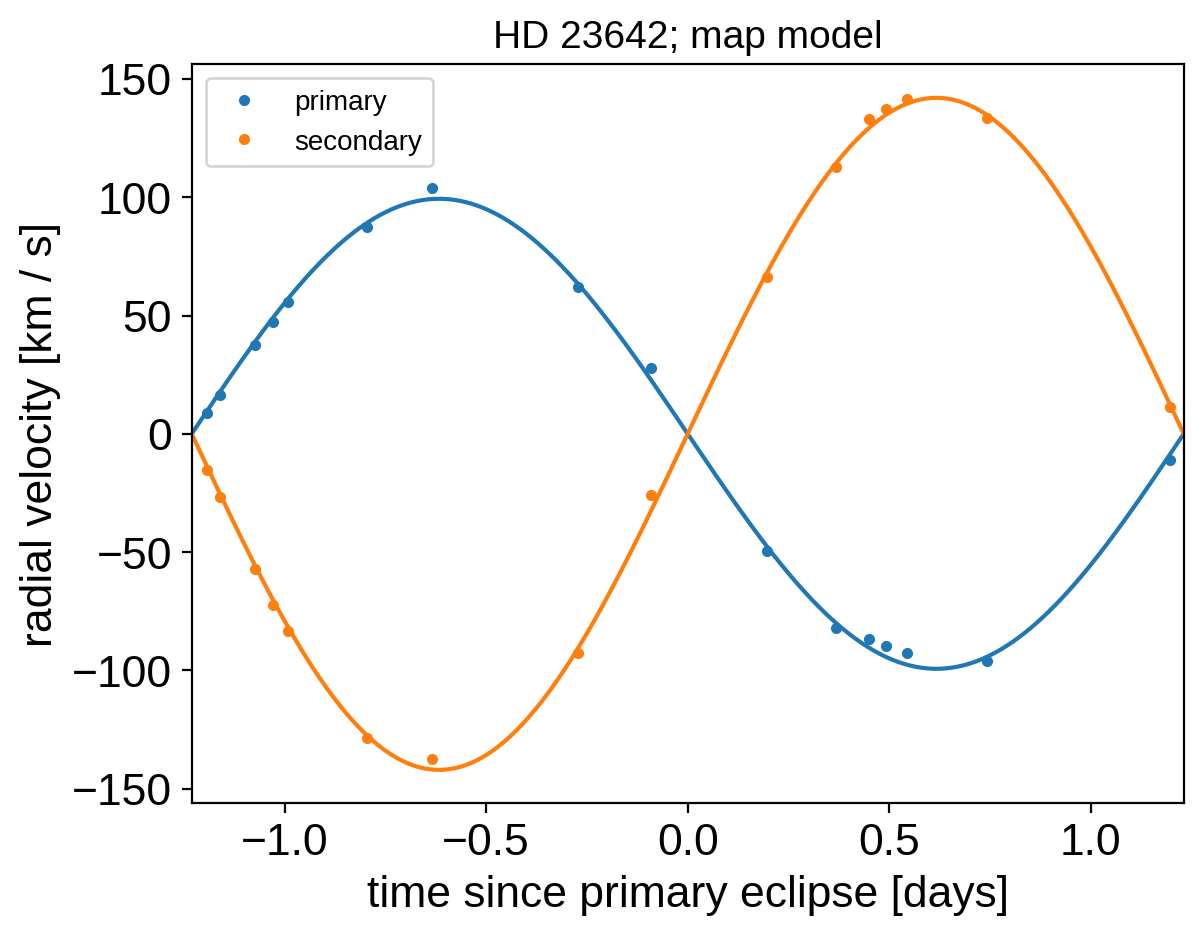

In [7]:
period = map_soln["period"]
t0 = map_soln["t0"]
mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv - mean, ".", label="primary")
plt.plot(fold, y2_rv - mean, ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model.model_rv1(x_phase + t0), model.model_rv2(x_phase + t0)], map_soln
    )
plt.plot(x_phase, y1_mod - mean, "C0")
plt.plot(x_phase, y2_mod - mean, "C1")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("HD 23642; map model", fontsize=14)

And then the light curve.
In the top panel, we show the Gaussian process model for the phase curve.
It's clear that there's a lot of information there that we could take advantage of, but that's a topic for another day.
In the bottom panel, we're plotting the phase folded light curve and we can see the ridiculous signal to noise that we're getting on the eclipses.

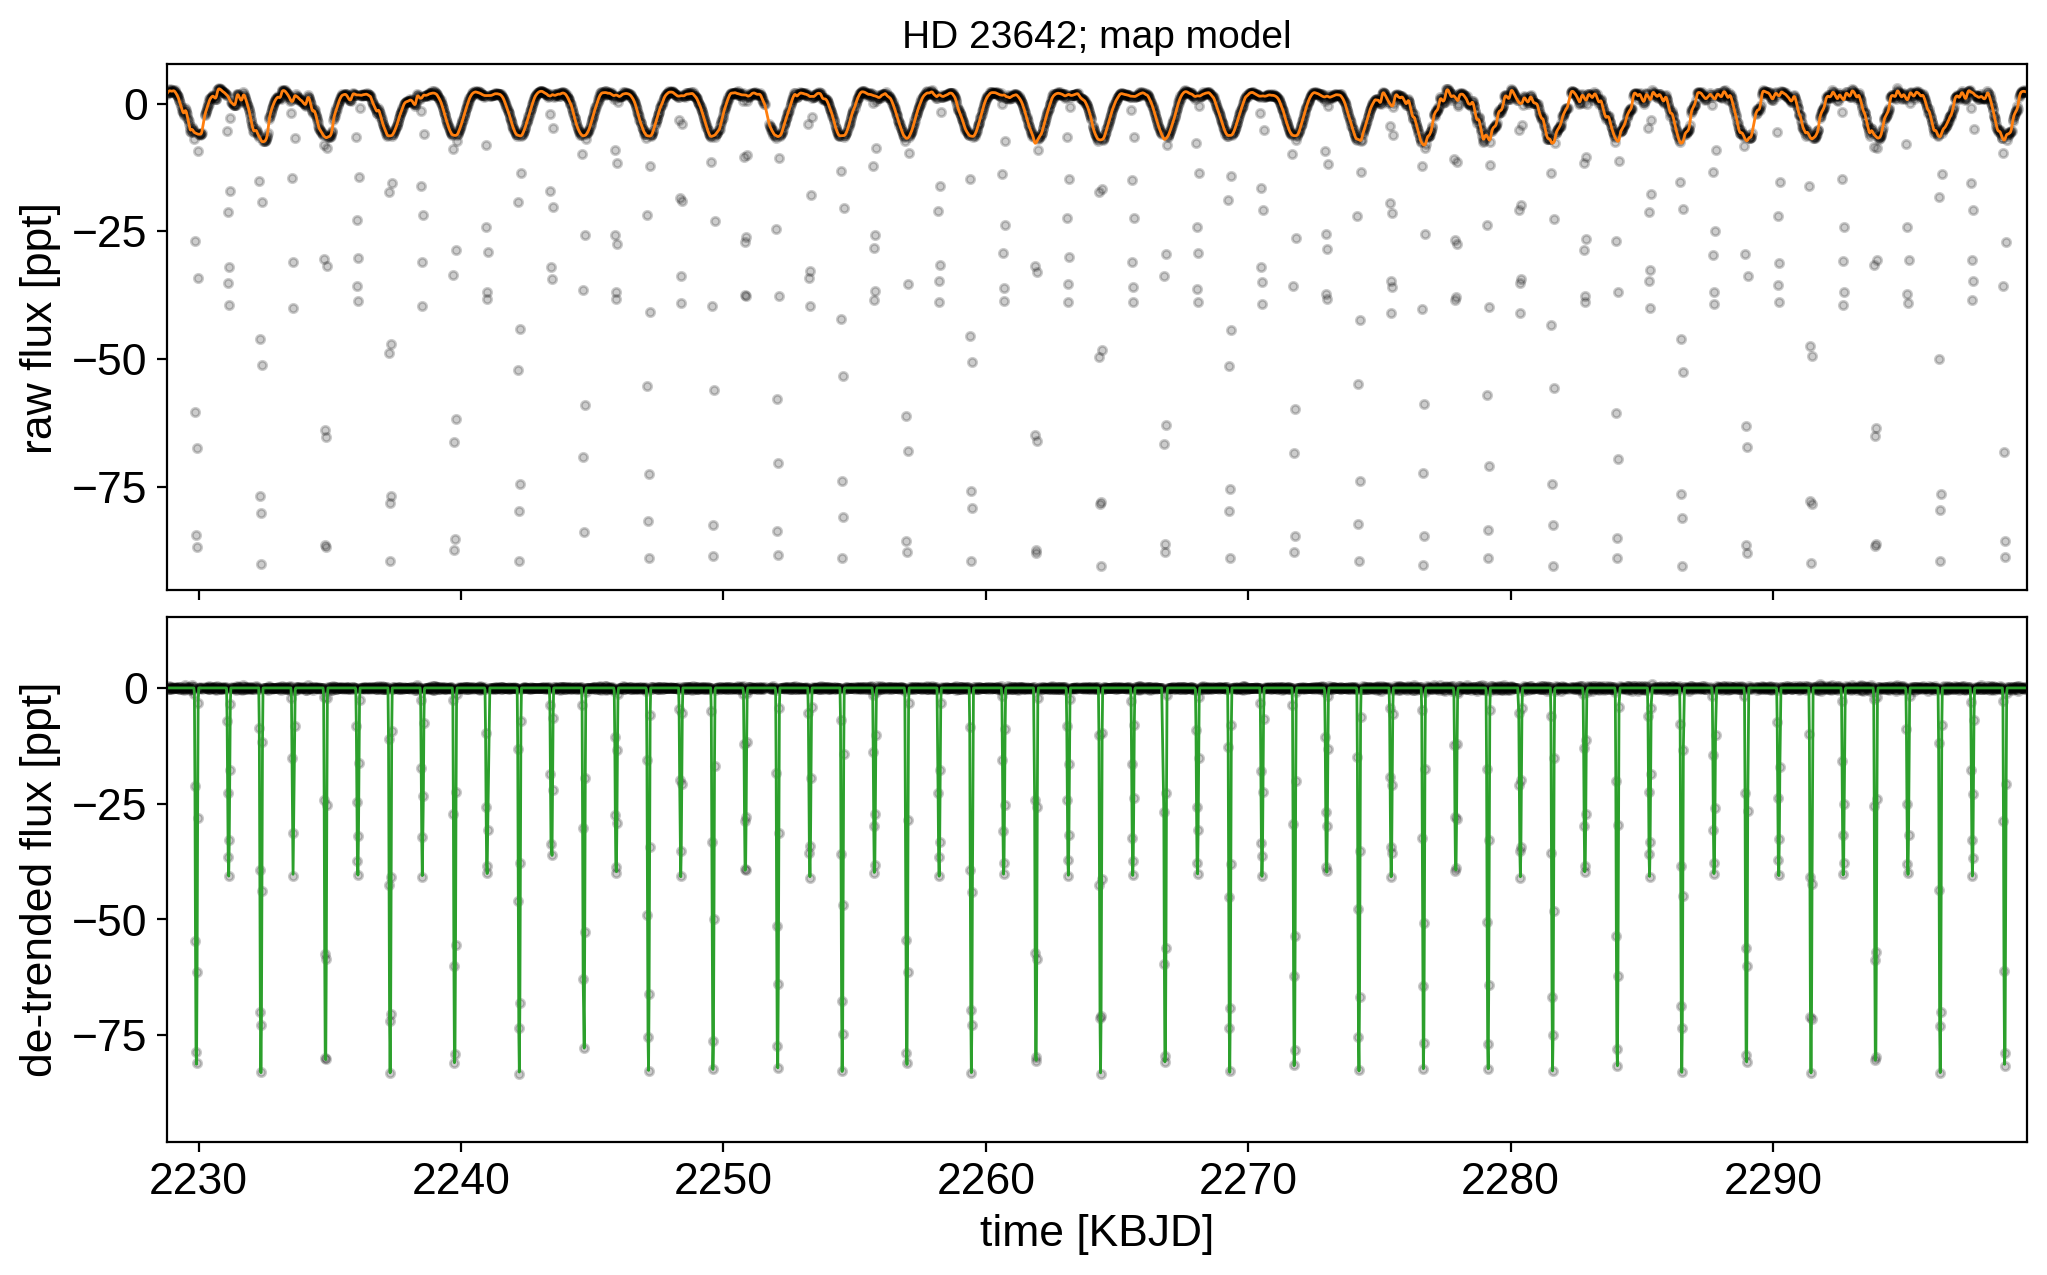

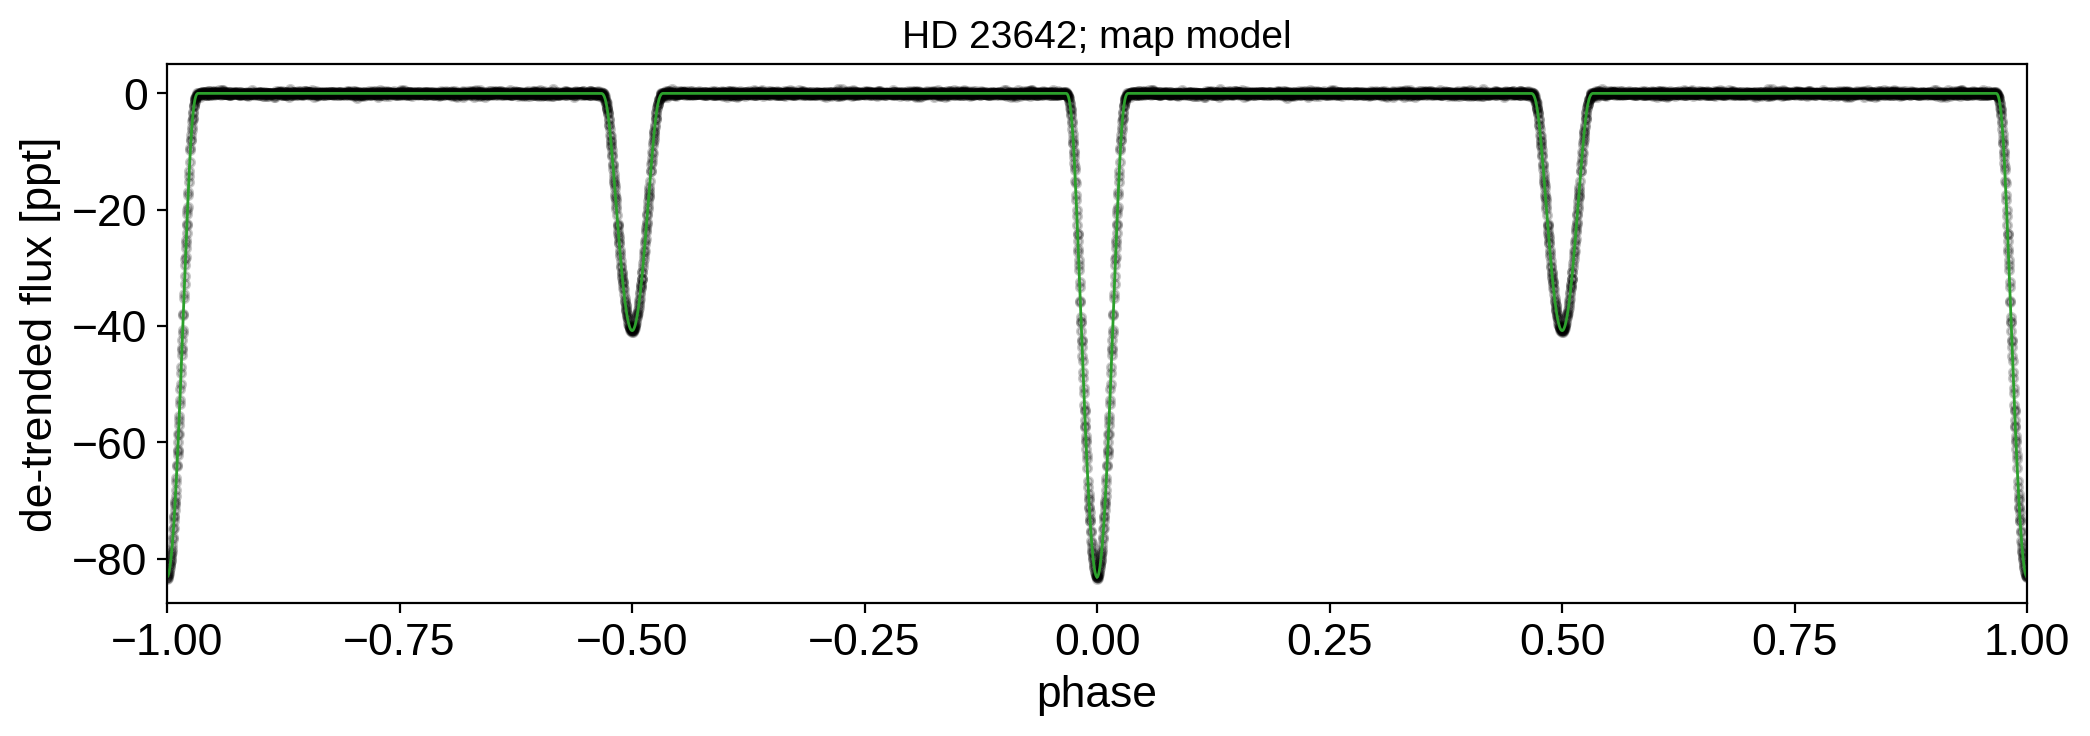

In [8]:
with model:
    gp_pred = xo.eval_in_model(model.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
    lc = xo.eval_in_model(model.model_lc(model.x), map_soln) - map_soln["mean_lc"]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

ax1.plot(model.x, model.y, "k.", alpha=0.2)
ax1.plot(model.x, gp_pred, color="C1", lw=1)

ax2.plot(model.x, model.y - gp_pred, "k.", alpha=0.2)
ax2.plot(model.x, lc, color="C2", lw=1)
ax2.set_xlim(model.x.min(), model.x.max())

ax1.set_ylabel("raw flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [KBJD]")
ax1.set_title("HD 23642; map model", fontsize=14)

fig.subplots_adjust(hspace=0.05)

fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

x_fold = (model.x - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
inds = np.argsort(x_fold)

ax1.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax1.plot(x_fold[inds] - 1, model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax2.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2, label="data!")
ax2.plot(x_fold[inds] - 1, model.y[inds] - gp_pred, "k.", alpha=0.2)

yval = model.y[inds] - gp_pred
bins = np.linspace(0, 1, 75)
num, _ = np.histogram(x_fold[inds], bins, weights=yval)
denom, _ = np.histogram(x_fold[inds], bins)
ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

args = dict(lw=1)

ax1.plot(x_fold[inds], lc[inds], "C2", **args)
ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

ax1.set_xlim(-1, 1)
ax1.set_ylabel("de-trended flux [ppt]")
ax1.set_xlabel("phase")
_ = ax1.set_title("HD 23642; map model", fontsize=14)

## Sampling

Finally we can run the MCMC:

In [9]:
np.random.seed(23642)
with model:
    trace = pm.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(start=map_soln, target_accept=0.95),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/26000 [00:01<18:05, 23.92draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 28/26000 [00:01<23:00, 18.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/26000 [00:02<1:49:49,  3.94draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 32/26000 [00:02<1:35:16,  4.54draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/26000 [00:02<2:20:17,  3.08draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 35/26000 [00:03<1:44:51,  4.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/26000 [00:03<2:14:09,  3.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/26000 [00:03<2:25:46,  2.97draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 39/26000 [00:04<1:48:36,  3.98draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:04<2:12:25,  3.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/26000 [00:05<1:39:12,  4.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/26000 [00:05<2:05:39,  3.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/26000 [00:06<1:34:32,  4.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/26000 [00:06<2:04:40,  3.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/26000 [00:07<2:08:08,  3.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/26000 [00:08<1:41:13,  4.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:08<2:40:54,  2.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/26000 [00:09<2:11:10,  3.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:09<2:41:37,  2.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/26000 [00:10<2:19:43,  3.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:10<2:25:02,  2.98draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:11<2:14:37,  3.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:11<1:59:35,  3.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 71/26000 [00:12<2:03:58,  3.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/26000 [00:13<1:59:22,  3.62draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:13<1:30:22,  4.78draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/26000 [00:14<1:58:44,  3.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:14<1:35:19,  4.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:14<1:21:30,  5.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 83/26000 [00:15<2:23:19,  3.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:15<1:52:26,  3.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:16<1:55:14,  3.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 87/26000 [00:16<2:24:13,  2.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:16<1:53:00,  3.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 90/26000 [00:17<2:17:36,  3.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:17<2:18:29,  3.12draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 94/26000 [00:17<1:44:48,  4.12draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [00:18<2:34:27,  2.80draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:18<2:10:33,  3.31draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 98/26000 [00:18<1:41:48,  4.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:19<2:54:08,  2.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [00:19<2:09:02,  3.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [00:20<3:14:22,  2.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [00:20<2:26:17,  2.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:21<2:35:00,  2.78draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:21<1:58:26,  3.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 110/26000 [00:21<1:48:27,  3.98draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [00:22<2:35:16,  2.78draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:22<1:58:40,  3.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 114/26000 [00:22<2:10:04,  3.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [00:23<2:29:05,  2.89draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:23<1:54:44,  3.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [00:24<2:28:51,  2.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [00:24<2:22:15,  3.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:24<1:48:10,  3.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 122/26000 [00:25<2:46:05,  2.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [00:25<2:13:10,  3.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:25<1:41:25,  4.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:26<3:00:27,  2.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [00:26<2:13:42,  3.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/26000 [00:27<2:25:01,  2.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:27<2:02:49,  3.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:28<2:17:32,  3.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/26000 [00:28<1:46:47,  4.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:28<1:40:52,  4.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:29<2:28:07,  2.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/26000 [00:29<1:54:12,  3.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/26000 [00:29<2:07:46,  3.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:30<2:24:45,  2.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/26000 [00:30<1:51:54,  3.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:30<2:28:37,  2.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:31<2:16:29,  3.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 148/26000 [00:31<1:49:06,  3.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [00:31<2:42:58,  2.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [00:32<2:03:26,  3.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:32<3:03:20,  2.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [00:33<2:17:06,  3.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:33<2:29:14,  2.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [00:34<1:57:59,  3.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:34<2:10:55,  3.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [00:35<1:45:04,  4.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/26000 [00:35<1:49:28,  3.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:35<2:19:04,  3.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:36<1:50:07,  3.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [00:36<2:15:22,  3.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [00:36<2:14:59,  3.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [00:37<1:47:04,  4.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [00:37<2:35:10,  2.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:37<2:07:06,  3.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [00:38<1:47:08,  4.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/26000 [00:38<2:42:53,  2.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:39<2:07:49,  3.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 181/26000 [00:39<2:52:14,  2.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 183/26000 [00:39<2:14:38,  3.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [00:40<2:22:06,  3.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/26000 [00:40<2:00:07,  3.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/26000 [00:41<2:05:27,  3.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/26000 [00:42<1:55:02,  3.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [00:42<1:45:43,  4.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 193/26000 [00:42<1:59:47,  3.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [00:43<1:54:02,  3.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [00:43<2:00:19,  3.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [00:43<1:47:04,  4.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [00:44<1:52:52,  3.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/26000 [00:44<2:06:55,  3.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [00:45<1:59:23,  3.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 204/26000 [00:45<1:56:13,  3.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [00:45<1:34:11,  4.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/26000 [00:46<2:12:16,  3.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [00:46<2:05:12,  3.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [00:46<1:50:26,  3.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [00:47<2:03:47,  3.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 212/26000 [00:47<1:58:40,  3.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [00:47<1:56:01,  3.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 215/26000 [00:48<1:47:44,  3.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [00:48<1:47:28,  4.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [00:49<1:58:13,  3.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [00:49<1:41:42,  4.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [00:50<2:07:50,  3.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 226/26000 [00:50<1:33:54,  4.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 228/26000 [00:51<2:03:45,  3.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [00:51<1:35:00,  4.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 232/26000 [00:52<2:03:58,  3.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 234/26000 [00:52<1:43:19,  4.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [00:53<2:36:05,  2.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 238/26000 [00:53<2:09:49,  3.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [00:54<2:34:18,  2.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [00:54<2:15:13,  3.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [00:55<2:17:17,  3.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 246/26000 [00:55<2:10:12,  3.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [00:56<1:52:32,  3.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 250/26000 [00:57<2:00:01,  3.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [00:58<1:55:09,  3.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 256/26000 [00:58<1:27:12,  4.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 258/26000 [00:58<1:56:35,  3.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 260/26000 [00:59<1:28:26,  4.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [00:59<1:56:59,  3.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [01:00<1:29:14,  4.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [01:00<1:57:01,  3.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 268/26000 [01:01<1:33:49,  4.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 269/26000 [01:01<2:11:41,  3.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [01:01<2:06:07,  3.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 272/26000 [01:02<1:43:28,  4.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 273/26000 [01:02<2:37:56,  2.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 275/26000 [01:02<2:01:21,  3.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 276/26000 [01:03<1:47:05,  4.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 277/26000 [01:03<2:43:07,  2.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [01:03<2:08:19,  3.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [01:04<1:47:05,  4.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 281/26000 [01:04<2:30:18,  2.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [01:04<2:00:23,  3.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [01:05<1:50:17,  3.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [01:05<1:58:51,  3.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [01:05<1:39:07,  4.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 287/26000 [01:06<1:42:50,  4.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [01:06<1:25:57,  4.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [01:06<2:00:36,  3.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [01:06<1:41:29,  4.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [01:07<1:43:50,  4.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [01:07<1:50:17,  3.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [01:07<1:53:35,  3.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [01:07<1:38:06,  4.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [01:08<1:40:05,  4.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [01:08<2:12:08,  3.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [01:08<1:48:19,  3.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [01:09<1:46:17,  4.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [01:09<2:28:10,  2.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [01:09<1:57:03,  3.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [01:10<1:47:33,  3.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [01:10<2:13:33,  3.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 305/26000 [01:10<1:55:54,  3.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [01:10<1:40:06,  4.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [01:11<1:42:41,  4.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 308/26000 [01:11<2:00:56,  3.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 309/26000 [01:11<1:48:29,  3.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [01:11<1:54:38,  3.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [01:12<1:34:28,  4.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 312/26000 [01:12<1:54:41,  3.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 313/26000 [01:12<1:43:49,  4.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 314/26000 [01:13<2:04:08,  3.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [01:13<1:51:28,  3.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [01:13<1:41:05,  4.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [01:14<2:10:26,  3.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [01:14<1:55:44,  3.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [01:14<1:37:54,  4.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [01:14<1:33:25,  4.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 322/26000 [01:15<2:03:35,  3.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [01:15<2:07:50,  3.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [01:15<1:41:21,  4.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [01:16<2:24:47,  2.96draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [01:16<2:07:33,  3.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 328/26000 [01:16<1:52:06,  3.82draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 330/26000 [01:17<1:55:51,  3.69draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [01:17<1:47:18,  3.99draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [01:17<1:36:57,  4.41draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [01:17<1:35:05,  4.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [01:18<1:54:29,  3.74draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 335/26000 [01:18<1:47:25,  3.98draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [01:18<1:35:34,  4.48draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [01:18<1:55:48,  3.69draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [01:19<1:47:36,  3.97draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 339/26000 [01:19<1:43:40,  4.13draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 340/26000 [01:19<1:31:34,  4.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [01:19<2:14:21,  3.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 343/26000 [01:20<1:51:15,  3.84draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [01:20<1:36:03,  4.45draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [01:20<2:22:20,  3.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [01:21<1:55:50,  3.69draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 347/26000 [01:21<1:35:46,  4.46draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [01:21<1:23:43,  5.11draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [01:21<2:17:19,  3.11draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [01:22<2:07:28,  3.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [01:22<1:38:19,  4.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [01:22<2:22:00,  3.01draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [01:23<2:14:34,  3.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 355/26000 [01:23<1:49:05,  3.92draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 357/26000 [01:23<1:52:53,  3.79draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [01:24<1:54:40,  3.73draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 359/26000 [01:24<1:34:24,  4.53draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [01:24<1:33:38,  4.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [01:24<2:00:09,  3.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [01:25<1:53:19,  3.77draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [01:25<1:33:21,  4.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [01:25<1:50:58,  3.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [01:26<2:19:34,  3.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 367/26000 [01:26<1:45:25,  4.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [01:26<2:23:28,  2.98draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 369/26000 [01:26<2:18:21,  3.09draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 371/26000 [01:27<1:44:11,  4.10draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [01:27<2:43:57,  2.61draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 373/26000 [01:27<2:17:06,  3.12draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [01:28<2:17:13,  3.11draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [01:29<2:08:10,  3.33draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 383/26000 [01:30<1:34:30,  4.52draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [01:30<2:01:48,  3.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 387/26000 [01:31<1:41:12,  4.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [01:31<2:40:02,  2.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [01:32<2:09:45,  3.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [01:32<2:40:58,  2.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [01:32<2:01:32,  3.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/26000 [01:33<2:27:13,  2.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/26000 [01:33<2:25:48,  2.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 398/26000 [01:33<1:51:17,  3.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/26000 [01:34<2:39:53,  2.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [01:34<2:13:57,  3.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 402/26000 [01:34<1:43:22,  4.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [01:35<2:54:27,  2.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 406/26000 [01:35<2:09:14,  3.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [01:36<3:13:09,  2.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 409/26000 [01:36<2:25:18,  2.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [01:37<2:32:43,  2.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 413/26000 [01:37<1:57:51,  3.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [01:37<1:41:41,  4.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [01:38<2:32:08,  2.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 417/26000 [01:38<2:02:53,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 418/26000 [01:39<1:59:03,  3.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [01:39<2:19:57,  3.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 421/26000 [01:39<1:54:46,  3.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [01:40<2:13:20,  3.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [01:40<2:09:02,  3.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 425/26000 [01:40<1:47:38,  3.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [01:41<2:28:04,  2.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [01:41<1:51:02,  3.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [01:41<1:41:03,  4.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [01:42<2:26:01,  2.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [01:42<1:54:31,  3.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [01:42<1:44:05,  4.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 435/26000 [01:43<2:26:24,  2.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [01:43<1:56:00,  3.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 437/26000 [01:43<1:53:05,  3.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [01:44<1:57:32,  3.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [01:44<1:37:02,  4.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 441/26000 [01:44<1:44:38,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [01:44<1:28:53,  4.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [01:45<1:57:18,  3.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [01:45<1:38:16,  4.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 445/26000 [01:45<1:45:09,  4.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [01:45<1:48:53,  3.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 447/26000 [01:46<1:50:41,  3.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [01:46<1:34:57,  4.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [01:46<1:42:16,  4.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 450/26000 [01:47<2:06:53,  3.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 451/26000 [01:47<1:42:24,  4.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [01:47<1:30:23,  4.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [01:47<1:38:38,  4.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 454/26000 [01:48<2:17:02,  3.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 456/26000 [01:48<1:46:06,  4.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [01:48<1:49:20,  3.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [01:49<2:23:06,  2.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [01:49<2:01:56,  3.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 461/26000 [01:49<1:42:35,  4.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [01:50<2:17:17,  3.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 463/26000 [01:50<1:59:43,  3.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 464/26000 [01:50<1:50:19,  3.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 466/26000 [01:51<1:53:28,  3.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [01:51<1:43:30,  4.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 468/26000 [01:51<1:47:20,  3.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [01:51<1:29:25,  4.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 470/26000 [01:51<1:51:18,  3.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [01:52<1:43:25,  4.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [01:52<1:47:01,  3.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [01:52<1:48:48,  3.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 474/26000 [01:52<1:44:10,  4.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [01:53<1:39:48,  4.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 476/26000 [01:53<1:44:33,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [01:53<2:07:09,  3.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [01:54<1:46:22,  4.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 480/26000 [01:54<1:49:01,  3.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [01:54<2:15:49,  3.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [01:54<1:50:37,  3.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 483/26000 [01:55<1:31:02,  4.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 484/26000 [01:55<1:38:18,  4.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [01:55<2:08:46,  3.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [01:56<1:58:46,  3.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 488/26000 [01:56<1:41:47,  4.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [01:56<2:08:54,  3.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 490/26000 [01:57<1:57:39,  3.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [01:57<1:53:13,  3.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 493/26000 [01:57<1:51:42,  3.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [01:57<1:44:19,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [01:58<1:52:01,  3.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 496/26000 [01:58<1:31:19,  4.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [01:58<1:49:16,  3.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 498/26000 [01:58<1:41:31,  4.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [01:59<1:55:57,  3.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 500/26000 [01:59<1:59:06,  3.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [01:59<1:39:38,  4.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 502/26000 [01:59<1:32:57,  4.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 503/26000 [02:00<1:50:02,  3.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 504/26000 [02:00<2:12:21,  3.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [02:00<1:43:31,  4.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [02:01<1:57:55,  3.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [02:01<2:18:53,  3.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [02:01<1:57:56,  3.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [02:02<1:49:39,  3.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 512/26000 [02:02<2:06:15,  3.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 513/26000 [02:02<1:46:10,  4.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [02:03<1:47:52,  3.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 515/26000 [02:03<1:37:31,  4.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [02:03<1:58:42,  3.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 517/26000 [02:03<1:40:23,  4.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 518/26000 [02:04<2:05:34,  3.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [02:04<1:53:08,  3.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 521/26000 [02:04<1:36:10,  4.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [02:05<2:02:26,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 523/26000 [02:05<1:57:08,  3.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [02:05<1:41:49,  4.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 525/26000 [02:05<1:27:35,  4.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [02:06<1:56:27,  3.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 527/26000 [02:06<2:13:19,  3.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 529/26000 [02:06<1:41:17,  4.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [02:07<2:06:03,  3.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [02:07<2:20:11,  3.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 532/26000 [02:07<1:53:43,  3.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [02:07<1:37:59,  4.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [02:08<1:45:22,  4.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 535/26000 [02:08<2:06:21,  3.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 536/26000 [02:08<1:43:02,  4.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 537/26000 [02:08<1:57:14,  3.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 539/26000 [02:09<1:53:50,  3.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 540/26000 [02:09<1:33:22,  4.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [02:09<2:01:04,  3.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [02:10<1:40:24,  4.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 543/26000 [02:10<1:48:15,  3.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 545/26000 [02:10<1:50:05,  3.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [02:11<2:00:47,  3.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 548/26000 [02:11<1:35:29,  4.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [02:11<2:04:16,  3.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [02:12<2:23:01,  2.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 552/26000 [02:12<1:47:37,  3.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [02:12<2:24:04,  2.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 554/26000 [02:13<2:21:43,  2.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 556/26000 [02:13<1:53:45,  3.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 557/26000 [02:14<2:39:08,  2.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 558/26000 [02:14<2:05:59,  3.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 560/26000 [02:14<1:43:16,  4.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [02:15<2:41:08,  2.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 564/26000 [02:15<2:09:45,  3.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [02:16<2:42:10,  2.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 568/26000 [02:16<2:17:19,  3.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [02:17<2:26:56,  2.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 572/26000 [02:17<2:13:32,  3.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [02:18<2:03:42,  3.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 576/26000 [02:18<2:04:04,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 578/26000 [02:19<1:34:07,  4.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [02:19<2:04:32,  3.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 584/26000 [02:20<1:57:55,  3.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 587/26000 [02:21<1:33:34,  4.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [02:21<2:34:38,  2.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 591/26000 [02:22<2:06:38,  3.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [02:22<2:35:33,  2.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 595/26000 [02:23<2:16:04,  3.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 596/26000 [02:23<2:17:00,  3.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [02:24<2:10:52,  3.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 600/26000 [02:24<1:51:30,  3.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [02:25<1:58:55,  3.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 607/26000 [02:26<1:53:43,  3.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 610/26000 [02:26<1:29:17,  4.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 611/26000 [02:27<2:35:30,  2.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 614/26000 [02:28<2:06:38,  3.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [02:28<2:37:41,  2.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 617/26000 [02:28<1:57:06,  3.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 618/26000 [02:29<2:28:55,  2.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [02:29<2:26:38,  2.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 620/26000 [02:29<1:55:29,  3.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 622/26000 [02:30<2:07:45,  3.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [02:30<1:45:31,  4.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [02:30<1:21:17,  5.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 626/26000 [02:31<2:44:22,  2.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [02:31<2:01:47,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 630/26000 [02:32<2:19:33,  3.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [02:32<1:51:40,  3.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 633/26000 [02:32<1:26:14,  4.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 635/26000 [02:33<1:53:33,  3.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 637/26000 [02:33<1:40:57,  4.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 638/26000 [02:34<2:16:00,  3.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [02:34<1:49:11,  3.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 641/26000 [02:35<1:50:36,  3.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 642/26000 [02:35<1:57:19,  3.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 643/26000 [02:35<1:36:01,  4.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 645/26000 [02:36<1:54:40,  3.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 646/26000 [02:36<1:34:08,  4.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 647/26000 [02:36<1:19:48,  5.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 649/26000 [02:37<1:49:49,  3.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [02:37<1:24:04,  5.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [02:38<1:52:45,  3.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 654/26000 [02:38<1:33:48,  4.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 656/26000 [02:38<1:16:45,  5.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [02:39<2:18:41,  3.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 658/26000 [02:39<1:52:29,  3.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 660/26000 [02:39<1:43:51,  4.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [02:40<2:08:32,  3.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 662/26000 [02:40<1:49:28,  3.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 664/26000 [02:41<1:54:48,  3.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [02:41<1:45:50,  3.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 666/26000 [02:41<1:36:12,  4.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 668/26000 [02:42<1:57:07,  3.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 670/26000 [02:42<1:33:28,  4.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 672/26000 [02:43<1:55:42,  3.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 673/26000 [02:43<1:42:40,  4.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 676/26000 [02:44<1:45:13,  4.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 677/26000 [02:44<1:36:30,  4.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 679/26000 [02:44<1:18:29,  5.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [02:45<2:12:08,  3.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 681/26000 [02:45<1:55:55,  3.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 683/26000 [02:45<1:43:48,  4.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 684/26000 [02:46<2:06:04,  3.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 685/26000 [02:46<1:51:43,  3.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 687/26000 [02:46<1:52:53,  3.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [02:47<1:48:02,  3.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 689/26000 [02:47<1:39:41,  4.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 691/26000 [02:47<1:56:03,  3.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 693/26000 [02:48<1:36:19,  4.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 695/26000 [02:48<1:55:58,  3.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [02:49<1:43:34,  4.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [02:49<1:22:34,  5.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 699/26000 [02:49<2:16:59,  3.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 700/26000 [02:50<2:03:43,  3.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 701/26000 [02:50<1:41:37,  4.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 703/26000 [02:50<1:50:25,  3.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 704/26000 [02:51<1:47:34,  3.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 705/26000 [02:51<1:28:31,  4.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 706/26000 [02:51<1:27:41,  4.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 707/26000 [02:51<1:53:23,  3.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 708/26000 [02:52<1:51:07,  3.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 709/26000 [02:52<1:30:49,  4.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [02:52<1:51:46,  3.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 711/26000 [02:52<1:46:57,  3.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 712/26000 [02:53<1:47:42,  3.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 714/26000 [02:53<1:57:26,  3.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 716/26000 [02:54<1:41:16,  4.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 718/26000 [02:54<1:54:45,  3.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 719/26000 [02:54<1:40:58,  4.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 720/26000 [02:54<1:26:19,  4.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 721/26000 [02:55<1:19:57,  5.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 722/26000 [02:55<2:01:37,  3.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 723/26000 [02:55<2:02:42,  3.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [02:56<1:35:26,  4.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 726/26000 [02:56<2:11:38,  3.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [02:56<2:11:11,  3.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 728/26000 [02:57<1:50:23,  3.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 730/26000 [02:57<1:51:13,  3.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 731/26000 [02:57<1:53:51,  3.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 732/26000 [02:58<1:38:53,  4.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 733/26000 [02:58<1:41:55,  4.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 734/26000 [02:58<1:45:44,  3.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 735/26000 [02:58<1:50:29,  3.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 736/26000 [02:59<1:34:37,  4.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 737/26000 [02:59<2:03:49,  3.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 739/26000 [02:59<1:50:26,  3.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [03:00<1:48:59,  3.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 741/26000 [03:00<2:10:45,  3.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 742/26000 [03:00<1:47:45,  3.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 743/26000 [03:00<1:37:25,  4.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 744/26000 [03:01<1:47:08,  3.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 745/26000 [03:01<1:59:45,  3.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [03:01<2:03:03,  3.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 748/26000 [03:02<1:44:55,  4.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 749/26000 [03:02<1:59:15,  3.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [03:02<2:02:45,  3.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 751/26000 [03:02<1:50:23,  3.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [03:03<1:29:53,  4.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 753/26000 [03:03<1:48:41,  3.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [03:03<1:56:00,  3.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 755/26000 [03:04<1:57:28,  3.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 757/26000 [03:04<1:45:07,  4.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 758/26000 [03:04<1:53:45,  3.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [03:05<2:07:42,  3.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 760/26000 [03:05<1:55:57,  3.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 762/26000 [03:05<1:45:53,  3.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 763/26000 [03:06<2:00:03,  3.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [03:06<1:58:00,  3.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 765/26000 [03:06<1:43:38,  4.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [03:06<1:34:02,  4.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 767/26000 [03:07<1:51:25,  3.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 768/26000 [03:07<2:35:10,  2.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 770/26000 [03:08<2:10:56,  3.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [03:08<3:26:28,  2.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 773/26000 [03:09<3:32:19,  1.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 774/26000 [03:10<2:46:02,  2.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 776/26000 [03:11<2:57:46,  2.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 777/26000 [03:11<2:37:01,  2.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 778/26000 [03:11<2:16:19,  3.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 779/26000 [03:12<3:41:38,  1.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [03:13<5:10:16,  1.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 781/26000 [03:14<4:10:26,  1.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 782/26000 [03:14<4:48:58,  1.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 784/26000 [03:15<3:53:05,  1.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 785/26000 [03:16<4:21:19,  1.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 786/26000 [03:17<5:36:02,  1.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 787/26000 [03:17<4:54:56,  1.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 788/26000 [03:18<5:03:23,  1.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 789/26000 [03:18<3:49:06,  1.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [03:19<3:48:26,  1.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 791/26000 [03:19<3:47:57,  1.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 792/26000 [03:21<5:12:36,  1.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 793/26000 [03:21<5:05:51,  1.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [03:22<4:41:37,  1.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [03:22<3:57:29,  1.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 796/26000 [03:23<3:59:40,  1.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 797/26000 [03:23<3:27:46,  2.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 798/26000 [03:24<4:58:44,  1.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 799/26000 [03:25<5:22:03,  1.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 800/26000 [03:26<4:27:41,  1.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [03:26<4:20:04,  1.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [03:27<4:10:54,  1.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 803/26000 [03:27<3:08:49,  2.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [03:28<4:45:56,  1.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 805/26000 [03:29<5:36:30,  1.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [03:29<4:16:43,  1.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 807/26000 [03:30<4:40:22,  1.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [03:30<4:16:19,  1.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 810/26000 [03:32<4:19:50,  1.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [03:33<5:29:18,  1.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 813/26000 [03:34<4:49:57,  1.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [03:34<4:16:21,  1.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 816/26000 [03:36<4:21:16,  1.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 817/26000 [03:37<5:36:05,  1.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 819/26000 [03:38<4:58:04,  1.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [03:38<4:10:06,  1.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 821/26000 [03:38<3:15:27,  2.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 822/26000 [03:39<4:36:47,  1.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [03:41<5:53:43,  1.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 825/26000 [03:42<5:12:53,  1.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 826/26000 [03:42<4:30:42,  1.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 827/26000 [03:45<8:16:44,  1.18s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 828/26000 [03:46<8:20:09,  1.19s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 830/26000 [03:46<6:01:17,  1.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 831/26000 [03:48<9:26:27,  1.35s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 832/26000 [03:50<9:20:13,  1.34s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 834/26000 [03:51<7:27:35,  1.07s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 835/26000 [03:52<8:44:47,  1.25s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 836/26000 [03:54<8:53:25,  1.27s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [03:55<8:07:46,  1.16s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 839/26000 [03:56<7:14:05,  1.04s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [03:57<7:44:52,  1.11s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 841/26000 [03:58<5:41:26,  1.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [04:00<9:09:19,  1.31s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 843/26000 [04:01<7:18:53,  1.05s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [04:01<6:50:06,  1.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 845/26000 [04:01<5:03:45,  1.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 846/26000 [04:04<8:46:51,  1.26s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [04:05<8:41:23,  1.24s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 848/26000 [04:06<6:49:56,  1.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 849/26000 [04:06<5:08:07,  1.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [04:08<8:04:50,  1.16s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 851/26000 [04:09<8:07:02,  1.16s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [04:09<6:29:23,  1.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 853/26000 [04:11<7:32:51,  1.08s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 854/26000 [04:12<7:07:54,  1.02s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [04:13<7:20:30,  1.05s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 856/26000 [04:13<6:18:30,  1.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 857/26000 [04:16<9:06:59,  1.31s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [04:16<7:06:19,  1.02s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [04:17<6:25:54,  1.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 860/26000 [04:17<5:43:11,  1.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [04:20<8:53:11,  1.27s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 862/26000 [04:21<8:07:55,  1.16s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 863/26000 [04:21<6:48:59,  1.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 865/26000 [04:24<7:29:52,  1.07s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 866/26000 [04:24<6:50:24,  1.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 867/26000 [04:25<6:25:03,  1.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [04:26<6:15:17,  1.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [04:28<7:31:01,  1.08s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 870/26000 [04:28<6:45:31,  1.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 871/26000 [04:29<6:26:35,  1.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 872/26000 [04:31<8:09:04,  1.17s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 873/26000 [04:31<6:57:54,  1.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [04:32<6:21:19,  1.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 875/26000 [04:33<6:25:59,  1.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 876/26000 [04:35<9:06:36,  1.31s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 877/26000 [04:36<7:02:08,  1.01s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [04:36<5:51:05,  1.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 879/26000 [04:37<6:11:17,  1.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 880/26000 [04:39<8:43:43,  1.25s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [04:40<7:38:53,  1.10s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [04:40<6:20:53,  1.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 883/26000 [04:41<5:53:41,  1.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 884/26000 [04:43<8:12:17,  1.18s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 885/26000 [04:44<7:13:38,  1.04s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 886/26000 [04:45<7:48:51,  1.12s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 887/26000 [04:45<5:44:48,  1.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 888/26000 [04:47<7:34:05,  1.08s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 889/26000 [04:47<6:43:53,  1.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 890/26000 [04:49<8:25:52,  1.21s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 891/26000 [04:50<7:15:32,  1.04s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 892/26000 [04:51<6:36:38,  1.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [04:51<6:03:52,  1.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 894/26000 [04:53<8:16:15,  1.19s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [04:55<8:23:31,  1.20s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 896/26000 [04:55<6:10:40,  1.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [04:55<5:23:44,  1.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 898/26000 [04:57<7:54:32,  1.13s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [04:58<8:07:16,  1.16s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 900/26000 [04:59<7:06:27,  1.02s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 901/26000 [04:59<5:38:26,  1.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 902/26000 [05:01<7:27:21,  1.07s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [05:02<7:42:54,  1.11s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 904/26000 [05:03<7:11:34,  1.03s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 905/26000 [05:04<7:42:51,  1.11s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 906/26000 [05:05<6:30:41,  1.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [05:06<7:02:15,  1.01s/draws]

Sampling 4 chains, 0 divergences:   3%|▎         | 908/26000 [05:07<6:57:21,  1.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 909/26000 [05:09<8:27:06,  1.21s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 910/26000 [05:09<7:04:05,  1.01s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 911/26000 [05:10<6:16:22,  1.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 912/26000 [05:11<6:24:39,  1.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 913/26000 [05:13<8:03:51,  1.16s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 914/26000 [05:14<8:07:29,  1.17s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 915/26000 [05:14<6:39:22,  1.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 916/26000 [05:15<5:54:31,  1.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 917/26000 [05:17<7:32:06,  1.08s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 918/26000 [05:18<7:44:49,  1.11s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 919/26000 [05:19<7:38:44,  1.10s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [05:19<6:22:37,  1.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 921/26000 [05:20<6:51:51,  1.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 922/26000 [05:22<7:14:06,  1.04s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 923/26000 [05:23<7:16:54,  1.05s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 924/26000 [05:24<8:19:52,  1.20s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [05:24<6:04:31,  1.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 926/26000 [05:25<4:45:45,  1.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [05:25<5:10:09,  1.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 928/26000 [05:26<5:48:01,  1.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 929/26000 [05:28<8:10:13,  1.17s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 930/26000 [05:29<7:00:41,  1.01s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 931/26000 [05:29<5:22:29,  1.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 932/26000 [05:30<5:55:00,  1.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 933/26000 [05:32<8:20:57,  1.20s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [05:33<7:32:27,  1.08s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 935/26000 [05:34<6:53:45,  1.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 936/26000 [05:34<5:26:31,  1.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [05:36<7:59:24,  1.15s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 938/26000 [05:37<7:13:58,  1.04s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 939/26000 [05:38<7:22:06,  1.06s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 940/26000 [05:39<6:37:51,  1.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 941/26000 [05:40<7:20:52,  1.06s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 942/26000 [05:41<6:42:51,  1.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 943/26000 [05:42<6:57:31,  1.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 944/26000 [05:43<6:37:37,  1.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [05:43<5:08:48,  1.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 946/26000 [05:44<4:59:14,  1.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [05:45<5:37:36,  1.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 948/26000 [05:46<6:11:14,  1.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [05:47<6:39:11,  1.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 950/26000 [05:49<8:08:43,  1.17s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 952/26000 [05:50<6:49:02,  1.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [05:50<6:33:45,  1.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 954/26000 [05:51<5:10:05,  1.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 956/26000 [05:51<4:11:07,  1.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 957/26000 [05:53<7:26:27,  1.07s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 958/26000 [05:54<7:02:22,  1.01s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [05:55<5:33:33,  1.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 960/26000 [05:55<4:55:36,  1.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 961/26000 [05:55<3:55:45,  1.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 962/26000 [05:58<8:38:18,  1.24s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 963/26000 [05:58<6:25:57,  1.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [05:59<5:45:27,  1.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 965/26000 [05:59<4:35:19,  1.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 966/26000 [06:00<4:09:45,  1.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 967/26000 [06:02<7:48:28,  1.12s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 968/26000 [06:03<7:46:34,  1.12s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 969/26000 [06:03<5:44:36,  1.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 970/26000 [06:04<4:37:46,  1.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 971/26000 [06:06<8:04:23,  1.16s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 972/26000 [06:07<7:59:24,  1.15s/draws]

Sampling 4 chains, 0 divergences:   4%|▎         | 973/26000 [06:07<6:26:18,  1.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 974/26000 [06:08<5:30:34,  1.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 976/26000 [06:08<4:09:38,  1.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 977/26000 [06:10<6:05:28,  1.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 978/26000 [06:12<8:28:21,  1.22s/draws]

Sampling 4 chains, 0 divergences:   4%|▍         | 979/26000 [06:12<6:12:15,  1.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 981/26000 [06:12<4:35:28,  1.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [06:13<4:43:24,  1.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 983/26000 [06:13<3:51:51,  1.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 984/26000 [06:15<6:43:57,  1.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 985/26000 [06:15<5:13:18,  1.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 986/26000 [06:16<4:15:30,  1.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 987/26000 [06:17<5:14:46,  1.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 988/26000 [06:18<6:31:54,  1.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 989/26000 [06:19<6:56:55,  1.00s/draws]

Sampling 4 chains, 0 divergences:   4%|▍         | 990/26000 [06:19<5:20:51,  1.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 991/26000 [06:20<5:08:06,  1.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 992/26000 [06:23<9:35:45,  1.38s/draws]

Sampling 4 chains, 0 divergences:   4%|▍         | 993/26000 [06:23<6:57:31,  1.00s/draws]

Sampling 4 chains, 0 divergences:   4%|▍         | 994/26000 [06:23<5:05:09,  1.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 996/26000 [06:23<3:42:20,  1.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [06:24<4:24:20,  1.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 998/26000 [06:25<4:27:28,  1.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 999/26000 [06:26<5:00:17,  1.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1000/26000 [06:27<5:40:06,  1.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1001/26000 [06:27<4:57:34,  1.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1002/26000 [06:28<3:58:15,  1.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [06:28<3:34:44,  1.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1004/26000 [06:28<2:46:28,  2.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1005/26000 [06:28<2:51:55,  2.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [06:29<3:00:03,  2.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1007/26000 [06:30<3:35:15,  1.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1008/26000 [06:31<4:31:32,  1.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1009/26000 [06:31<4:43:33,  1.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1010/26000 [06:32<4:18:56,  1.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1011/26000 [06:32<3:28:48,  1.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1012/26000 [06:32<2:43:19,  2.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1013/26000 [06:32<2:07:38,  3.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1014/26000 [06:33<2:01:02,  3.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1015/26000 [06:33<1:46:59,  3.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1018/26000 [06:34<1:47:17,  3.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [06:34<1:31:00,  4.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1021/26000 [06:34<1:31:38,  4.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1023/26000 [06:35<1:34:52,  4.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1024/26000 [06:35<1:36:26,  4.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1025/26000 [06:35<1:35:26,  4.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [06:35<1:38:31,  4.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1027/26000 [06:36<2:08:42,  3.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1028/26000 [06:36<2:03:39,  3.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1029/26000 [06:37<3:20:14,  2.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1031/26000 [06:37<2:39:10,  2.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [06:38<2:36:59,  2.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [06:38<2:07:45,  3.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1035/26000 [06:38<2:09:45,  3.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1036/26000 [06:39<2:49:35,  2.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1037/26000 [06:40<3:30:24,  1.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [06:40<3:26:52,  2.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1039/26000 [06:40<2:38:05,  2.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1040/26000 [06:40<2:36:57,  2.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1041/26000 [06:41<3:04:38,  2.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1042/26000 [06:41<2:39:43,  2.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1043/26000 [06:42<2:22:11,  2.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [06:43<3:38:02,  1.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1046/26000 [06:43<2:41:51,  2.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1047/26000 [06:43<2:08:27,  3.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1048/26000 [06:43<1:56:38,  3.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1049/26000 [06:43<1:43:11,  4.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1050/26000 [06:43<1:28:02,  4.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1051/26000 [06:44<1:33:09,  4.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1052/26000 [06:44<1:51:53,  3.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [06:44<1:33:59,  4.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1054/26000 [06:44<1:41:39,  4.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1056/26000 [06:45<1:26:03,  4.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1058/26000 [06:45<1:29:58,  4.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1059/26000 [06:45<1:29:16,  4.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1060/26000 [06:46<1:32:41,  4.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1061/26000 [06:46<2:05:26,  3.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1063/26000 [06:46<1:58:08,  3.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1064/26000 [06:47<1:37:55,  4.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1066/26000 [06:47<1:23:42,  4.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1067/26000 [06:47<1:21:42,  5.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1070/26000 [06:47<1:07:14,  6.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1073/26000 [06:48<59:09,  7.02draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1075/26000 [06:48<52:56,  7.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [06:48<49:11,  8.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1080/26000 [06:48<51:56,  8.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [06:49<1:00:30,  6.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1083/26000 [06:49<53:07,  7.82draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1084/26000 [06:49<1:15:13,  5.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1085/26000 [06:49<1:15:15,  5.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1086/26000 [06:49<1:07:49,  6.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1087/26000 [06:49<1:02:39,  6.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1088/26000 [06:50<59:04,  7.03draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [06:50<1:00:56,  6.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1091/26000 [06:50<1:18:29,  5.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1092/26000 [06:50<1:14:00,  5.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [06:51<1:51:15,  3.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1094/26000 [06:51<1:45:51,  3.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1095/26000 [06:51<1:27:59,  4.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1096/26000 [06:51<1:17:19,  5.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1098/26000 [06:52<1:16:29,  5.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [06:52<1:09:32,  5.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1100/26000 [06:52<1:32:58,  4.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1101/26000 [06:52<1:19:55,  5.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1103/26000 [06:53<1:18:43,  5.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1104/26000 [06:53<1:25:31,  4.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1106/26000 [06:53<1:21:33,  5.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1107/26000 [06:53<1:14:07,  5.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1108/26000 [06:54<1:04:34,  6.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [06:54<1:32:52,  4.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1111/26000 [06:54<1:35:14,  4.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1112/26000 [06:55<2:07:07,  3.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1114/26000 [06:55<1:44:01,  3.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1115/26000 [06:55<1:52:09,  3.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1116/26000 [06:56<1:48:30,  3.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1117/26000 [06:56<1:37:16,  4.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1119/26000 [06:56<1:27:14,  4.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1121/26000 [06:56<1:12:15,  5.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1122/26000 [06:57<1:27:59,  4.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1123/26000 [06:57<1:24:53,  4.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1125/26000 [06:57<1:17:12,  5.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1127/26000 [06:57<1:01:57,  6.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1129/26000 [06:57<58:18,  7.11draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1131/26000 [06:58<55:41,  7.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1132/26000 [06:58<1:08:51,  6.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [06:58<1:00:56,  6.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1136/26000 [06:58<59:36,  6.95draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1138/26000 [06:59<48:28,  8.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [06:59<56:57,  7.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1142/26000 [06:59<54:45,  7.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1143/26000 [06:59<52:22,  7.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1144/26000 [07:00<1:05:35,  6.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [07:00<1:02:23,  6.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1146/26000 [07:00<57:28,  7.21draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1147/26000 [07:00<56:17,  7.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1148/26000 [07:00<53:39,  7.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1150/26000 [07:00<45:28,  9.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [07:00<54:06,  7.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1154/26000 [07:01<52:20,  7.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1156/26000 [07:01<44:56,  9.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1158/26000 [07:01<53:26,  7.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1159/26000 [07:01<53:49,  7.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1161/26000 [07:02<52:46,  7.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1162/26000 [07:02<49:52,  8.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1163/26000 [07:02<52:11,  7.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1165/26000 [07:02<51:42,  8.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1166/26000 [07:02<1:06:31,  6.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1168/26000 [07:02<54:05,  7.65draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1169/26000 [07:03<1:08:24,  6.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1170/26000 [07:03<1:12:44,  5.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1173/26000 [07:03<1:02:55,  6.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1174/26000 [07:03<1:07:25,  6.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [07:04<52:40,  7.85draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1180/26000 [07:04<51:58,  7.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1182/26000 [07:04<43:57,  9.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1184/26000 [07:04<45:47,  9.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1186/26000 [07:04<42:58,  9.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [07:05<45:04,  9.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1190/26000 [07:05<46:19,  8.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1192/26000 [07:05<44:22,  9.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1194/26000 [07:05<41:41,  9.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1196/26000 [07:05<44:03,  9.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1198/26000 [07:06<38:03, 10.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1200/26000 [07:06<39:20, 10.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1202/26000 [07:06<42:46,  9.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1204/26000 [07:06<39:10, 10.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1206/26000 [07:06<42:20,  9.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1208/26000 [07:06<37:00, 11.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1210/26000 [07:07<39:40, 10.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1212/26000 [07:07<42:46,  9.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1214/26000 [07:07<38:12, 10.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1216/26000 [07:07<34:09, 12.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1218/26000 [07:07<38:27, 10.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1220/26000 [07:08<34:35, 11.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1222/26000 [07:08<31:46, 12.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1224/26000 [07:08<37:31, 11.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1226/26000 [07:08<40:23, 10.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1228/26000 [07:08<43:03,  9.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1231/26000 [07:09<39:28, 10.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1234/26000 [07:09<37:58, 10.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1237/26000 [07:09<36:28, 11.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1240/26000 [07:09<35:24, 11.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1242/26000 [07:09<32:11, 12.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [07:10<30:02, 13.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1246/26000 [07:10<28:30, 14.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1248/26000 [07:10<34:41, 11.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1250/26000 [07:10<35:05, 11.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1252/26000 [07:10<39:43, 10.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1254/26000 [07:11<38:53, 10.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1257/26000 [07:11<37:06, 11.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1260/26000 [07:11<30:44, 13.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1262/26000 [07:11<33:39, 12.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1264/26000 [07:11<33:55, 12.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1266/26000 [07:11<35:53, 11.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1269/26000 [07:12<31:56, 12.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1271/26000 [07:12<29:45, 13.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1273/26000 [07:12<33:11, 12.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1275/26000 [07:12<38:20, 10.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1278/26000 [07:12<31:48, 12.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1280/26000 [07:12<32:05, 12.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1282/26000 [07:13<37:17, 11.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1284/26000 [07:13<40:52, 10.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1287/26000 [07:13<38:28, 10.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1290/26000 [07:13<31:54, 12.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1292/26000 [07:13<33:25, 12.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1294/26000 [07:14<34:33, 11.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1296/26000 [07:14<30:31, 13.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1298/26000 [07:14<36:21, 11.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1300/26000 [07:14<37:22, 11.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1302/26000 [07:14<37:16, 11.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1304/26000 [07:15<33:10, 12.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1306/26000 [07:15<34:40, 11.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1308/26000 [07:15<31:44, 12.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [07:15<29:39, 13.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1312/26000 [07:15<31:35, 13.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1314/26000 [07:15<30:04, 13.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1316/26000 [07:15<27:48, 14.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1318/26000 [07:15<27:47, 14.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1320/26000 [07:16<30:01, 13.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1322/26000 [07:16<31:31, 13.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1324/26000 [07:16<30:54, 13.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1326/26000 [07:16<32:00, 12.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1328/26000 [07:16<29:44, 13.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1330/26000 [07:16<28:15, 14.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1332/26000 [07:16<27:13, 15.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1334/26000 [07:17<26:26, 15.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1336/26000 [07:17<33:16, 12.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1338/26000 [07:17<33:02, 12.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [07:17<33:18, 12.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1343/26000 [07:17<29:47, 13.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1345/26000 [07:17<28:13, 14.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1347/26000 [07:18<27:11, 15.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1349/26000 [07:18<26:28, 15.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1351/26000 [07:18<31:32, 13.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1353/26000 [07:18<31:18, 13.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1355/26000 [07:18<33:00, 12.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1357/26000 [07:18<32:39, 12.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1360/26000 [07:19<31:17, 13.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1362/26000 [07:19<29:19, 14.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1364/26000 [07:19<30:25, 13.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1367/26000 [07:19<29:29, 13.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1369/26000 [07:19<27:58, 14.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1371/26000 [07:19<29:55, 13.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1374/26000 [07:20<30:55, 13.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1377/26000 [07:20<33:11, 12.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1379/26000 [07:20<36:02, 11.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1382/26000 [07:20<35:11, 11.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1385/26000 [07:21<34:37, 11.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1387/26000 [07:21<35:13, 11.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1390/26000 [07:21<34:28, 11.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1393/26000 [07:21<33:58, 12.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1396/26000 [07:21<31:24, 13.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1398/26000 [07:22<30:51, 13.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1400/26000 [07:22<30:53, 13.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1403/26000 [07:22<26:33, 15.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1405/26000 [07:22<31:18, 13.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1407/26000 [07:22<36:28, 11.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1410/26000 [07:22<31:57, 12.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1413/26000 [07:23<32:16, 12.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1416/26000 [07:23<27:33, 14.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1418/26000 [07:23<32:01, 12.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1421/26000 [07:23<28:44, 14.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1423/26000 [07:23<26:36, 15.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1425/26000 [07:23<27:15, 15.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1427/26000 [07:24<26:22, 15.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [07:24<33:05, 12.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1431/26000 [07:24<30:34, 13.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1433/26000 [07:24<36:05, 11.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1435/26000 [07:24<40:04, 10.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1437/26000 [07:25<42:51,  9.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1439/26000 [07:25<44:46,  9.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1440/26000 [07:25<43:51,  9.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1442/26000 [07:25<39:10, 10.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1444/26000 [07:25<35:37, 11.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1446/26000 [07:25<39:44, 10.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1448/26000 [07:26<40:37, 10.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1451/26000 [07:26<38:20, 10.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1454/26000 [07:26<37:09, 11.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1456/26000 [07:26<33:21, 12.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1458/26000 [07:26<32:40, 12.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1460/26000 [07:27<35:16, 11.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1463/26000 [07:27<29:41, 13.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [07:27<35:34, 11.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1467/26000 [07:27<32:18, 12.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1469/26000 [07:27<29:57, 13.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1471/26000 [07:27<31:15, 13.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1473/26000 [07:28<33:43, 12.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1476/26000 [07:28<33:32, 12.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1479/26000 [07:28<35:47, 11.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1481/26000 [07:28<35:59, 11.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1484/26000 [07:28<30:07, 13.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1486/26000 [07:29<29:10, 14.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1488/26000 [07:29<35:13, 11.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1490/26000 [07:29<38:30, 10.61draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1493/26000 [07:29<31:51, 12.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1495/26000 [07:29<29:41, 13.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1497/26000 [07:29<28:20, 14.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1499/26000 [07:30<27:07, 15.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1501/26000 [07:30<26:21, 15.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1503/26000 [07:30<25:47, 15.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1505/26000 [07:30<30:35, 13.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1508/26000 [07:30<31:19, 13.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1511/26000 [07:30<28:04, 14.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1513/26000 [07:30<27:02, 15.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1515/26000 [07:31<26:16, 15.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1517/26000 [07:31<25:42, 15.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1519/26000 [07:31<32:35, 12.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1521/26000 [07:31<36:21, 11.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [07:31<35:22, 11.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1527/26000 [07:32<34:41, 11.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1530/26000 [07:32<34:10, 11.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1532/26000 [07:32<38:45, 10.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1535/26000 [07:32<36:58, 11.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1538/26000 [07:33<30:51, 13.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1540/26000 [07:33<28:53, 14.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1543/26000 [07:33<29:56, 13.61draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1546/26000 [07:33<30:38, 13.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [07:33<27:05, 15.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [07:33<27:37, 14.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1553/26000 [07:34<32:29, 12.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1556/26000 [07:34<32:31, 12.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1559/26000 [07:34<28:44, 14.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1561/26000 [07:34<29:06, 13.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1563/26000 [07:34<31:50, 12.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1566/26000 [07:35<29:23, 13.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1568/26000 [07:35<35:20, 11.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1571/26000 [07:35<34:32, 11.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1574/26000 [07:35<34:03, 11.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1576/26000 [07:35<38:34, 10.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1579/26000 [07:36<31:57, 12.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1581/26000 [07:36<34:38, 11.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1584/26000 [07:36<30:45, 13.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1587/26000 [07:36<26:27, 15.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1589/26000 [07:36<30:33, 13.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1591/26000 [07:37<35:56, 11.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [07:37<31:35, 12.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1595/26000 [07:37<31:28, 12.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1597/26000 [07:37<28:13, 14.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1600/26000 [07:37<27:00, 15.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1602/26000 [07:37<26:18, 15.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1604/26000 [07:37<29:03, 13.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1606/26000 [07:38<31:46, 12.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1608/26000 [07:38<29:34, 13.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1610/26000 [07:38<33:52, 12.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1612/26000 [07:38<31:47, 12.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1615/26000 [07:38<26:44, 15.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1617/26000 [07:38<27:40, 14.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1620/26000 [07:38<24:17, 16.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1622/26000 [07:39<24:23, 16.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1624/26000 [07:39<30:12, 13.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1627/26000 [07:39<30:57, 13.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1630/26000 [07:39<31:29, 12.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1633/26000 [07:39<31:51, 12.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1636/26000 [07:40<32:08, 12.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1639/26000 [07:40<32:18, 12.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1642/26000 [07:40<32:25, 12.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1645/26000 [07:40<29:00, 13.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1647/26000 [07:40<28:23, 14.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1649/26000 [07:41<31:46, 12.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1652/26000 [07:41<32:01, 12.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1655/26000 [07:41<28:46, 14.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1657/26000 [07:41<27:57, 14.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1659/26000 [07:41<26:57, 15.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1661/26000 [07:42<33:01, 12.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1664/26000 [07:42<32:53, 12.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1667/26000 [07:42<27:55, 14.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1669/26000 [07:42<32:26, 12.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1671/26000 [07:42<32:08, 12.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1673/26000 [07:42<29:37, 13.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1675/26000 [07:43<33:33, 12.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1677/26000 [07:43<32:48, 12.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1679/26000 [07:43<30:16, 13.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1681/26000 [07:43<33:49, 11.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [07:43<31:02, 13.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1685/26000 [07:43<31:05, 13.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1687/26000 [07:43<28:52, 14.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1689/26000 [07:44<32:59, 12.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1692/26000 [07:44<32:50, 12.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1695/26000 [07:44<27:53, 14.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1697/26000 [07:44<29:10, 13.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1699/26000 [07:44<26:52, 15.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1701/26000 [07:45<32:02, 12.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [07:45<28:57, 13.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1706/26000 [07:45<26:24, 15.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1708/26000 [07:45<31:46, 12.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1710/26000 [07:45<32:21, 12.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1713/26000 [07:45<32:32, 12.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1716/26000 [07:46<30:29, 13.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1718/26000 [07:46<28:38, 14.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1720/26000 [07:46<34:39, 11.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1722/26000 [07:46<34:49, 11.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1725/26000 [07:46<34:14, 11.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1728/26000 [07:47<33:42, 12.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1730/26000 [07:47<42:02,  9.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1732/26000 [07:47<40:12, 10.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1734/26000 [07:47<42:46,  9.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1737/26000 [07:48<37:21, 10.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1739/26000 [07:48<40:47,  9.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1741/26000 [07:48<36:44, 11.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1743/26000 [07:48<36:13, 11.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1745/26000 [07:48<40:08, 10.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1747/26000 [07:49<38:22, 10.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1749/26000 [07:49<41:27,  9.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1751/26000 [07:49<36:20, 11.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1753/26000 [07:49<37:25, 10.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1756/26000 [07:49<36:00, 11.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1759/26000 [07:50<34:58, 11.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1762/26000 [07:50<34:14, 11.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1765/26000 [07:50<28:59, 13.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1767/26000 [07:50<30:23, 13.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1769/26000 [07:50<35:46, 11.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1771/26000 [07:51<36:59, 10.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1773/26000 [07:51<40:36,  9.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1776/26000 [07:51<34:27, 11.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1778/26000 [07:51<32:13, 12.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1780/26000 [07:51<37:02, 10.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [07:52<40:30,  9.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1784/26000 [07:52<35:39, 11.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [07:52<32:07, 12.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1788/26000 [07:52<33:08, 12.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [07:52<34:27, 11.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1792/26000 [07:52<31:21, 12.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1794/26000 [07:52<32:52, 12.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1797/26000 [07:53<32:45, 12.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1800/26000 [07:53<32:43, 12.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1803/26000 [07:53<32:42, 12.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1806/26000 [07:53<27:48, 14.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1808/26000 [07:53<29:49, 13.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1810/26000 [07:54<35:19, 11.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1812/26000 [07:54<36:36, 11.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1815/26000 [07:54<32:20, 12.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1817/26000 [07:54<29:28, 13.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1819/26000 [07:54<33:00, 12.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1822/26000 [07:55<29:44, 13.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1824/26000 [07:55<27:17, 14.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1826/26000 [07:55<31:59, 12.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1829/26000 [07:55<32:22, 12.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1831/26000 [07:55<38:25, 10.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1834/26000 [07:55<32:10, 12.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1836/26000 [07:56<33:38, 11.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1838/26000 [07:56<38:06, 10.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1840/26000 [07:56<37:28, 10.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1843/26000 [07:56<31:13, 12.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [07:56<36:29, 11.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1847/26000 [07:57<32:15, 12.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1849/26000 [07:57<33:25, 12.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1851/26000 [07:57<37:52, 10.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1854/26000 [07:57<34:59, 11.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1856/26000 [07:57<36:57, 10.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1859/26000 [07:58<31:07, 12.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1861/26000 [07:58<31:58, 12.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1863/26000 [07:58<36:16, 11.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1866/26000 [07:58<30:18, 13.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1868/26000 [07:58<33:09, 12.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1870/26000 [07:58<33:19, 12.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1872/26000 [07:59<30:47, 13.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [07:59<32:42, 12.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1876/26000 [07:59<33:00, 12.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1878/26000 [07:59<37:30, 10.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1880/26000 [07:59<35:07, 11.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1882/26000 [08:00<39:16, 10.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [08:00<37:15, 10.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [08:00<36:01, 11.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1888/26000 [08:00<39:41, 10.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1890/26000 [08:00<37:45, 10.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1892/26000 [08:01<41:05,  9.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1894/26000 [08:01<36:07, 11.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [08:01<30:11, 13.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1899/26000 [08:01<29:17, 13.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1901/26000 [08:01<30:38, 13.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1903/26000 [08:01<32:38, 12.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1905/26000 [08:01<30:25, 13.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1907/26000 [08:02<31:23, 12.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1909/26000 [08:02<33:38, 11.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1911/26000 [08:02<30:28, 13.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1913/26000 [08:02<29:03, 13.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1915/26000 [08:02<35:00, 11.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1917/26000 [08:02<30:58, 12.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1919/26000 [08:02<29:54, 13.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1921/26000 [08:03<27:07, 14.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1923/26000 [08:03<27:25, 14.63draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1925/26000 [08:03<25:18, 15.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1927/26000 [08:03<28:07, 14.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1929/26000 [08:03<30:58, 12.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1932/26000 [08:03<31:20, 12.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1935/26000 [08:04<31:32, 12.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1937/26000 [08:04<36:33, 10.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [08:04<32:29, 12.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1942/26000 [08:04<37:09, 10.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [08:05<35:37, 11.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [08:05<31:04, 12.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1950/26000 [08:05<26:14, 15.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [08:05<27:14, 14.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1954/26000 [08:05<32:35, 12.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1957/26000 [08:05<32:35, 12.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1960/26000 [08:06<32:34, 12.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1963/26000 [08:06<32:33, 12.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1966/26000 [08:06<27:48, 14.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1968/26000 [08:06<30:08, 13.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1970/26000 [08:06<32:14, 12.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1972/26000 [08:06<29:42, 13.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [08:07<28:17, 14.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1976/26000 [08:07<33:58, 11.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1979/26000 [08:07<33:20, 12.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1982/26000 [08:07<29:42, 13.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1985/26000 [08:07<26:19, 15.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1987/26000 [08:08<30:31, 13.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1989/26000 [08:08<30:53, 12.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1992/26000 [08:08<26:28, 15.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [08:08<29:30, 13.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1996/26000 [08:08<31:09, 12.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1999/26000 [08:08<31:20, 12.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2002/26000 [08:09<31:26, 12.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2004/26000 [08:09<28:07, 14.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2006/26000 [08:09<31:44, 12.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2009/26000 [08:09<26:59, 14.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2011/26000 [08:09<33:12, 12.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2014/26000 [08:09<28:10, 14.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [08:10<26:56, 14.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2018/26000 [08:10<29:12, 13.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2020/26000 [08:10<27:37, 14.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2022/26000 [08:10<30:23, 13.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2024/26000 [08:10<32:13, 12.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2026/26000 [08:10<29:15, 13.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2028/26000 [08:11<31:25, 12.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2031/26000 [08:11<31:32, 12.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2034/26000 [08:11<31:37, 12.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2037/26000 [08:11<29:01, 13.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2039/26000 [08:11<27:40, 14.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2041/26000 [08:11<28:19, 14.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2045/26000 [08:12<23:26, 17.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2048/26000 [08:12<26:06, 15.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2050/26000 [08:12<26:57, 14.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2052/26000 [08:12<33:30, 11.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2054/26000 [08:12<34:12, 11.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2056/26000 [08:13<33:33, 11.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [08:13<31:46, 12.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [08:13<32:57, 12.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2062/26000 [08:13<33:23, 11.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2064/26000 [08:13<31:01, 12.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2066/26000 [08:13<32:27, 12.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2068/26000 [08:14<33:29, 11.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2070/26000 [08:14<30:34, 13.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2072/26000 [08:14<32:11, 12.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2074/26000 [08:14<33:47, 11.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2076/26000 [08:14<30:17, 13.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2078/26000 [08:14<31:59, 12.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2080/26000 [08:15<34:05, 11.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2082/26000 [08:15<29:58, 13.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [08:15<29:18, 13.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2086/26000 [08:15<33:37, 11.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2089/26000 [08:15<30:53, 12.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2092/26000 [08:15<31:11, 12.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2095/26000 [08:16<31:22, 12.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [08:16<31:30, 12.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2101/26000 [08:16<31:35, 12.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2103/26000 [08:16<28:09, 14.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2105/26000 [08:16<30:54, 12.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2108/26000 [08:17<29:19, 13.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2110/26000 [08:17<26:57, 14.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2112/26000 [08:17<29:22, 13.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2114/26000 [08:17<34:56, 11.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2117/26000 [08:17<33:59, 11.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2119/26000 [08:18<38:04, 10.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2122/26000 [08:18<36:15, 10.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [08:18<34:54, 11.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [08:18<38:41, 10.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2130/26000 [08:19<36:33, 10.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2132/26000 [08:19<39:45, 10.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2135/26000 [08:19<37:17, 10.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2137/26000 [08:19<40:21,  9.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2139/26000 [08:19<34:47, 11.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2141/26000 [08:20<36:19, 10.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2143/26000 [08:20<35:24, 11.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2145/26000 [08:20<31:57, 12.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2147/26000 [08:20<33:44, 11.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2149/26000 [08:20<33:36, 11.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2151/26000 [08:20<31:14, 12.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2153/26000 [08:21<32:35, 12.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2155/26000 [08:21<32:50, 12.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2157/26000 [08:21<31:13, 12.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [08:21<32:03, 12.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2161/26000 [08:21<36:39, 10.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2163/26000 [08:21<32:03, 12.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2165/26000 [08:21<30:13, 13.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2168/26000 [08:22<27:49, 14.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2171/26000 [08:22<25:49, 15.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2174/26000 [08:22<23:57, 16.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [08:22<26:45, 14.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2179/26000 [08:22<25:23, 15.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2181/26000 [08:22<26:16, 15.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2183/26000 [08:23<28:24, 13.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2185/26000 [08:23<30:23, 13.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2187/26000 [08:23<29:17, 13.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2189/26000 [08:23<30:35, 12.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2192/26000 [08:23<30:52, 12.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [08:23<28:28, 13.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2196/26000 [08:24<27:14, 14.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2198/26000 [08:24<33:19, 11.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2200/26000 [08:24<31:51, 12.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2202/26000 [08:24<36:48, 10.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2204/26000 [08:24<35:13, 11.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2206/26000 [08:25<38:56, 10.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2208/26000 [08:25<37:16, 10.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2210/26000 [08:25<40:13,  9.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2212/26000 [08:25<38:14, 10.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2214/26000 [08:25<35:07, 11.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2216/26000 [08:26<38:41, 10.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2218/26000 [08:26<37:05, 10.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2220/26000 [08:26<37:59, 10.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2222/26000 [08:26<33:04, 11.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2224/26000 [08:26<33:05, 11.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [08:26<34:33, 11.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2228/26000 [08:27<38:17, 10.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2231/26000 [08:27<36:25, 10.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2233/26000 [08:27<39:40,  9.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2236/26000 [08:27<37:19, 10.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2238/26000 [08:28<40:16,  9.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2241/26000 [08:28<37:39, 10.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [08:28<33:26, 11.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2248/26000 [08:28<33:57, 11.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [08:29<36:15, 10.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2253/26000 [08:29<34:49, 11.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2256/26000 [08:29<33:52, 11.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [08:29<30:29, 12.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2261/26000 [08:29<28:00, 14.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2263/26000 [08:29<31:14, 12.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2265/26000 [08:30<39:02, 10.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2267/26000 [08:30<38:27, 10.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2270/26000 [08:30<38:51, 10.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2272/26000 [08:31<41:21,  9.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2274/26000 [08:31<39:24, 10.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2277/26000 [08:31<36:59, 10.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2280/26000 [08:31<35:18, 11.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2283/26000 [08:31<34:10, 11.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2285/26000 [08:32<38:07, 10.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2288/26000 [08:32<35:34, 11.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [08:32<32:30, 12.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [08:32<32:15, 12.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [08:32<27:16, 14.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2300/26000 [08:33<30:11, 13.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2302/26000 [08:33<31:26, 12.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2305/26000 [08:33<31:26, 12.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2309/26000 [08:33<29:04, 13.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2311/26000 [08:33<26:33, 14.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2313/26000 [08:34<32:54, 12.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2315/26000 [08:34<30:44, 12.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2317/26000 [08:34<28:12, 14.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2319/26000 [08:34<34:07, 11.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2321/26000 [08:34<35:06, 11.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2324/26000 [08:35<31:22, 12.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2326/26000 [08:35<36:05, 10.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2328/26000 [08:35<32:56, 11.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2330/26000 [08:35<29:34, 13.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2332/26000 [08:35<28:38, 13.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2334/26000 [08:35<29:49, 13.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2336/26000 [08:35<29:00, 13.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2338/26000 [08:36<26:20, 14.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2340/26000 [08:36<29:03, 13.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2342/26000 [08:36<28:41, 13.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2344/26000 [08:36<29:14, 13.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2348/26000 [08:36<25:54, 15.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2350/26000 [08:36<25:39, 15.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2352/26000 [08:36<27:45, 14.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2354/26000 [08:37<33:31, 11.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2356/26000 [08:37<36:11, 10.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2359/26000 [08:37<30:31, 12.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2361/26000 [08:37<30:49, 12.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2363/26000 [08:37<34:00, 11.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [08:38<30:41, 12.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2367/26000 [08:38<28:53, 13.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2369/26000 [08:38<41:36,  9.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2371/26000 [08:38<36:12, 10.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2373/26000 [08:38<32:40, 12.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2375/26000 [08:39<40:26,  9.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2377/26000 [08:39<39:24,  9.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2380/26000 [08:39<31:57, 12.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2382/26000 [08:39<34:40, 11.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2384/26000 [08:39<34:22, 11.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2387/26000 [08:39<29:30, 13.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2389/26000 [08:40<32:25, 12.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2391/26000 [08:40<31:23, 12.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2394/26000 [08:40<32:36, 12.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2397/26000 [08:40<31:22, 12.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2400/26000 [08:40<31:56, 12.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2403/26000 [08:41<31:28, 12.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2407/26000 [08:41<29:06, 13.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2410/26000 [08:41<26:14, 14.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2412/26000 [08:41<24:27, 16.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2414/26000 [08:41<30:48, 12.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2417/26000 [08:42<31:05, 12.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [08:42<28:55, 13.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2424/26000 [08:42<24:40, 15.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2426/26000 [08:42<24:56, 15.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [08:42<24:37, 15.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2430/26000 [08:42<27:20, 14.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2433/26000 [08:43<26:29, 14.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2435/26000 [08:43<25:33, 15.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2437/26000 [08:43<28:08, 13.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [08:43<26:54, 14.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2442/26000 [08:43<25:53, 15.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [08:43<28:24, 13.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2447/26000 [08:44<24:37, 15.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2449/26000 [08:44<29:29, 13.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2452/26000 [08:44<29:06, 13.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2455/26000 [08:44<27:20, 14.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2459/26000 [08:44<22:40, 17.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2462/26000 [08:45<25:12, 15.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2464/26000 [08:45<30:51, 12.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2466/26000 [08:45<28:53, 13.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2468/26000 [08:45<27:13, 14.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2470/26000 [08:45<30:28, 12.87draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2473/26000 [08:45<30:40, 12.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2477/26000 [08:46<28:29, 13.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2480/26000 [08:46<25:25, 15.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2482/26000 [08:46<26:55, 14.56draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2485/26000 [08:46<24:54, 15.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2488/26000 [08:46<23:13, 16.87draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2490/26000 [08:46<26:31, 14.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [08:47<24:13, 16.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2495/26000 [08:47<26:10, 14.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2497/26000 [08:47<28:36, 13.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [08:47<29:24, 13.32draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2504/26000 [08:47<24:49, 15.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2506/26000 [08:47<24:29, 15.98draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2508/26000 [08:48<24:17, 16.12draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2510/26000 [08:48<26:02, 15.03draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2513/26000 [08:48<26:29, 14.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2517/26000 [08:48<25:39, 15.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2520/26000 [08:48<23:42, 16.50draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [08:48<23:34, 16.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2525/26000 [08:49<24:36, 15.90draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [08:49<23:10, 16.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2529/26000 [08:49<25:49, 15.15draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2531/26000 [08:49<25:55, 15.09draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2534/26000 [08:49<22:25, 17.44draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2536/26000 [08:49<23:17, 16.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2538/26000 [08:49<23:24, 16.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2540/26000 [08:49<23:13, 16.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2542/26000 [08:50<26:52, 14.54draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2545/26000 [08:50<25:45, 15.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2547/26000 [08:50<25:35, 15.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2549/26000 [08:50<28:02, 13.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2551/26000 [08:50<29:59, 13.03draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2553/26000 [08:50<29:03, 13.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2555/26000 [08:51<29:54, 13.07draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2557/26000 [08:51<31:12, 12.52draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2559/26000 [08:51<30:27, 12.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2562/26000 [08:51<27:24, 14.25draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2564/26000 [08:51<29:33, 13.21draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2566/26000 [08:51<29:41, 13.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2569/26000 [08:52<26:18, 14.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2571/26000 [08:52<25:53, 15.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2573/26000 [08:52<25:07, 15.54draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2576/26000 [08:52<22:16, 17.53draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2578/26000 [08:52<22:37, 17.25draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2580/26000 [08:52<21:49, 17.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2583/26000 [08:52<20:41, 18.87draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2585/26000 [08:52<20:32, 19.00draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2587/26000 [08:53<25:50, 15.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2589/26000 [08:53<28:35, 13.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2592/26000 [08:53<24:24, 15.98draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2594/26000 [08:53<24:28, 15.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2596/26000 [08:53<31:02, 12.57draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2599/26000 [08:53<29:20, 13.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2602/26000 [08:54<24:40, 15.80draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2604/26000 [08:54<28:04, 13.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2606/26000 [08:54<33:02, 11.80draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2609/26000 [08:54<27:07, 14.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2611/26000 [08:54<28:03, 13.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2613/26000 [08:54<28:50, 13.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2616/26000 [08:55<25:12, 15.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2618/26000 [08:55<28:24, 13.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2621/26000 [08:55<28:54, 13.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [08:55<27:11, 14.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2628/26000 [08:55<25:09, 15.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2630/26000 [08:55<24:37, 15.82draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2632/26000 [08:56<29:01, 13.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2635/26000 [08:56<29:41, 13.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2639/26000 [08:56<29:12, 13.33draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2641/26000 [08:56<31:24, 12.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2644/26000 [08:57<29:58, 12.98draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2648/26000 [08:57<25:27, 15.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [08:57<28:34, 13.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2652/26000 [08:57<33:54, 11.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2656/26000 [08:57<27:24, 14.19draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2658/26000 [08:57<29:09, 13.35draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2661/26000 [08:58<27:33, 14.11draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [08:58<26:59, 14.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2665/26000 [08:58<28:26, 13.67draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [08:58<30:36, 12.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2670/26000 [08:58<26:06, 14.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2672/26000 [08:58<25:16, 15.38draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2674/26000 [08:58<24:41, 15.74draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2676/26000 [08:59<24:17, 16.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2678/26000 [08:59<25:30, 15.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2681/26000 [08:59<23:39, 16.43draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2684/26000 [08:59<23:53, 16.26draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2686/26000 [08:59<23:24, 16.60draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2689/26000 [08:59<23:58, 16.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2693/26000 [09:00<21:30, 18.06draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2695/26000 [09:00<24:43, 15.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2697/26000 [09:00<28:34, 13.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2701/26000 [09:00<23:33, 16.49draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2704/26000 [09:00<25:49, 15.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2706/26000 [09:00<27:53, 13.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2709/26000 [09:01<28:50, 13.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2712/26000 [09:01<29:31, 13.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2716/26000 [09:01<24:08, 16.08draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2719/26000 [09:01<24:17, 15.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2722/26000 [09:01<24:15, 16.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2724/26000 [09:02<22:48, 17.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2726/26000 [09:02<24:18, 15.96draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2729/26000 [09:02<25:26, 15.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2732/26000 [09:02<22:22, 17.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2734/26000 [09:02<24:22, 15.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2737/26000 [09:02<24:53, 15.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2740/26000 [09:02<22:29, 17.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2742/26000 [09:03<26:42, 14.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2744/26000 [09:03<30:56, 12.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2748/26000 [09:03<28:43, 13.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2751/26000 [09:03<29:33, 13.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2754/26000 [09:04<30:05, 12.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2757/26000 [09:04<32:02, 12.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [09:04<31:46, 12.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [09:04<29:14, 13.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2767/26000 [09:05<29:46, 13.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2770/26000 [09:05<29:27, 13.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2774/26000 [09:05<28:06, 13.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2777/26000 [09:05<28:58, 13.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2779/26000 [09:06<34:15, 11.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2782/26000 [09:06<33:20, 11.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2785/26000 [09:06<32:38, 11.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2789/26000 [09:06<29:50, 12.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2792/26000 [09:07<30:09, 12.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2795/26000 [09:07<27:37, 14.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2798/26000 [09:07<24:31, 15.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [09:07<28:07, 13.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2802/26000 [09:07<26:12, 14.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2804/26000 [09:07<28:52, 13.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2807/26000 [09:08<27:34, 14.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2809/26000 [09:08<25:30, 15.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2811/26000 [09:08<28:35, 13.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2813/26000 [09:08<31:10, 12.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2815/26000 [09:08<27:58, 13.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2817/26000 [09:08<30:16, 12.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2819/26000 [09:08<32:17, 11.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2822/26000 [09:09<26:37, 14.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2824/26000 [09:09<29:41, 13.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2826/26000 [09:09<31:41, 12.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2828/26000 [09:09<27:59, 13.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2830/26000 [09:09<27:46, 13.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2833/26000 [09:09<28:47, 13.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2836/26000 [09:10<29:30, 13.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2839/26000 [09:10<25:29, 15.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2841/26000 [09:10<28:01, 13.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2843/26000 [09:10<30:09, 12.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [09:10<30:26, 12.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2850/26000 [09:11<28:17, 13.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2853/26000 [09:11<29:07, 13.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [09:11<26:39, 14.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2858/26000 [09:11<26:45, 14.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2860/26000 [09:11<28:35, 13.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2864/26000 [09:12<27:18, 14.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2867/26000 [09:12<28:25, 13.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2870/26000 [09:12<24:48, 15.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2872/26000 [09:12<27:37, 13.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2874/26000 [09:12<29:52, 12.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2876/26000 [09:12<27:12, 14.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2878/26000 [09:13<28:01, 13.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2881/26000 [09:13<28:12, 13.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2883/26000 [09:13<27:33, 13.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2885/26000 [09:13<25:44, 14.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2887/26000 [09:13<25:25, 15.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2889/26000 [09:13<27:37, 13.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2892/26000 [09:14<26:27, 14.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2894/26000 [09:14<25:43, 14.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2896/26000 [09:14<24:47, 15.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2898/26000 [09:14<24:29, 15.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2901/26000 [09:14<21:39, 17.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2903/26000 [09:14<25:25, 15.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2905/26000 [09:14<24:47, 15.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2907/26000 [09:15<28:02, 13.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2909/26000 [09:15<25:44, 14.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2911/26000 [09:15<25:48, 14.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2913/26000 [09:15<24:46, 15.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2915/26000 [09:15<27:48, 13.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2917/26000 [09:15<30:08, 12.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2920/26000 [09:15<25:32, 15.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [09:16<28:21, 13.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2925/26000 [09:16<26:58, 14.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2927/26000 [09:16<25:34, 15.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2929/26000 [09:16<25:10, 15.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2931/26000 [09:16<24:11, 15.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2933/26000 [09:16<27:35, 13.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2935/26000 [09:16<30:06, 12.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2938/26000 [09:17<25:16, 15.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2940/26000 [09:17<28:19, 13.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2943/26000 [09:17<27:02, 14.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2945/26000 [09:17<25:06, 15.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2948/26000 [09:17<24:47, 15.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2951/26000 [09:17<25:18, 15.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2955/26000 [09:18<25:45, 14.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2959/26000 [09:18<25:02, 15.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2962/26000 [09:18<21:25, 17.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2964/26000 [09:18<25:20, 15.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2966/26000 [09:18<25:14, 15.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2968/26000 [09:18<23:59, 16.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2970/26000 [09:19<28:23, 13.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2974/26000 [09:19<27:00, 14.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2978/26000 [09:19<25:16, 15.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2982/26000 [09:19<22:10, 17.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2984/26000 [09:19<23:18, 16.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2987/26000 [09:20<24:30, 15.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2990/26000 [09:20<21:48, 17.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2992/26000 [09:20<23:38, 16.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2995/26000 [09:20<24:53, 15.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2998/26000 [09:20<21:38, 17.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3000/26000 [09:20<23:45, 16.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3002/26000 [09:21<25:58, 14.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3005/26000 [09:21<22:03, 17.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3008/26000 [09:21<23:40, 16.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3010/26000 [09:21<25:33, 14.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3013/26000 [09:21<22:11, 17.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3015/26000 [09:21<27:07, 14.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3020/26000 [09:22<24:22, 15.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3024/26000 [09:22<24:15, 15.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3028/26000 [09:22<23:07, 16.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3032/26000 [09:22<23:56, 15.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3036/26000 [09:23<22:22, 17.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3040/26000 [09:23<20:31, 18.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3042/26000 [09:23<21:20, 17.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3045/26000 [09:23<19:32, 19.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3048/26000 [09:23<22:50, 16.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3050/26000 [09:23<23:32, 16.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3052/26000 [09:23<22:39, 16.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3054/26000 [09:24<25:20, 15.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3057/26000 [09:24<26:55, 14.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3059/26000 [09:24<25:02, 15.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3062/26000 [09:24<22:38, 16.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3064/26000 [09:24<26:55, 14.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3067/26000 [09:24<24:31, 15.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3069/26000 [09:25<22:59, 16.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3072/26000 [09:25<24:11, 15.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3076/26000 [09:25<24:22, 15.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3080/26000 [09:25<23:54, 15.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3083/26000 [09:25<21:39, 17.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3085/26000 [09:26<24:33, 15.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [09:26<27:51, 13.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3090/26000 [09:26<28:38, 13.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3095/26000 [09:26<25:33, 14.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3098/26000 [09:26<22:18, 17.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3100/26000 [09:26<26:26, 14.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3102/26000 [09:27<25:49, 14.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3104/26000 [09:27<25:40, 14.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3107/26000 [09:27<24:45, 15.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3111/26000 [09:27<21:50, 17.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3113/26000 [09:27<23:50, 16.00draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3115/26000 [09:27<25:58, 14.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3119/26000 [09:28<25:41, 14.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3123/26000 [09:28<24:57, 15.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3126/26000 [09:28<21:59, 17.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3128/26000 [09:28<24:12, 15.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3131/26000 [09:28<25:15, 15.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3134/26000 [09:28<21:49, 17.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3136/26000 [09:29<23:03, 16.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3138/26000 [09:29<26:04, 14.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3141/26000 [09:29<22:17, 17.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3143/26000 [09:29<27:27, 13.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3146/26000 [09:29<25:34, 14.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [09:29<23:58, 15.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3151/26000 [09:30<22:03, 17.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3153/26000 [09:30<26:41, 14.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3156/26000 [09:30<24:10, 15.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3159/26000 [09:30<24:11, 15.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3162/26000 [09:30<22:36, 16.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3164/26000 [09:30<24:59, 15.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [09:31<25:16, 15.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3170/26000 [09:31<21:48, 17.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3172/26000 [09:31<23:46, 16.00draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3175/26000 [09:31<25:22, 15.00draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [09:31<24:43, 15.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3182/26000 [09:31<23:17, 16.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3185/26000 [09:32<20:26, 18.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3188/26000 [09:32<23:26, 16.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3190/26000 [09:32<29:12, 13.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3193/26000 [09:32<29:01, 13.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3196/26000 [09:32<25:29, 14.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3198/26000 [09:33<25:04, 15.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3200/26000 [09:33<28:11, 13.48draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3204/26000 [09:33<24:55, 15.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [09:33<22:08, 17.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3209/26000 [09:33<22:26, 16.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3211/26000 [09:33<22:27, 16.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3213/26000 [09:33<22:53, 16.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3215/26000 [09:33<22:31, 16.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3217/26000 [09:34<24:31, 15.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3220/26000 [09:34<28:08, 13.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3224/26000 [09:34<24:40, 15.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3226/26000 [09:34<23:16, 16.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3228/26000 [09:34<24:08, 15.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3230/26000 [09:34<22:50, 16.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [09:35<23:55, 15.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3234/26000 [09:35<22:27, 16.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3236/26000 [09:35<23:52, 15.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3240/26000 [09:35<23:35, 16.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [09:35<21:02, 18.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3245/26000 [09:35<24:17, 15.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3247/26000 [09:36<25:02, 15.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▎        | 3250/26000 [09:36<23:04, 16.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3252/26000 [09:36<25:30, 14.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3255/26000 [09:36<26:36, 14.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3259/26000 [09:36<25:31, 14.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [09:36<23:33, 16.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3264/26000 [09:37<23:29, 16.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3266/26000 [09:37<27:02, 14.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3268/26000 [09:37<24:46, 15.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3270/26000 [09:37<26:34, 14.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3273/26000 [09:37<26:21, 14.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3275/26000 [09:37<24:46, 15.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3277/26000 [09:38<26:58, 14.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3280/26000 [09:38<24:15, 15.61draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3282/26000 [09:38<26:32, 14.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [09:38<28:32, 13.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [09:38<25:01, 15.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3289/26000 [09:38<28:37, 13.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3291/26000 [09:38<28:50, 13.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3293/26000 [09:39<27:35, 13.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3295/26000 [09:39<25:40, 14.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3297/26000 [09:39<25:09, 15.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3299/26000 [09:39<24:14, 15.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3301/26000 [09:39<23:53, 15.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3303/26000 [09:39<26:35, 14.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3306/26000 [09:39<25:52, 14.61draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3308/26000 [09:40<24:29, 15.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3310/26000 [09:40<24:42, 15.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3312/26000 [09:40<23:18, 16.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3314/26000 [09:40<24:12, 15.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3317/26000 [09:40<26:12, 14.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3321/26000 [09:40<25:14, 14.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3324/26000 [09:41<26:54, 14.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3327/26000 [09:41<23:58, 15.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3329/26000 [09:41<27:18, 13.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3331/26000 [09:41<25:55, 14.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3334/26000 [09:41<27:11, 13.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3337/26000 [09:42<28:05, 13.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3340/26000 [09:42<28:39, 13.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3343/26000 [09:42<25:22, 14.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3345/26000 [09:42<26:33, 14.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3347/26000 [09:42<28:56, 13.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3350/26000 [09:43<29:18, 12.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3353/26000 [09:43<27:10, 13.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3356/26000 [09:43<24:04, 15.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3358/26000 [09:43<26:27, 14.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3361/26000 [09:43<23:01, 16.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3363/26000 [09:43<29:37, 12.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3365/26000 [09:44<27:33, 13.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3367/26000 [09:44<26:05, 14.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [09:44<27:16, 13.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3372/26000 [09:44<26:49, 14.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3374/26000 [09:44<24:36, 15.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [09:44<29:10, 12.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3380/26000 [09:45<27:20, 13.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [09:45<28:17, 13.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3386/26000 [09:45<25:07, 15.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3388/26000 [09:45<24:02, 15.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3390/26000 [09:45<30:05, 12.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3393/26000 [09:46<30:13, 12.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3395/26000 [09:46<34:43, 10.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3398/26000 [09:46<28:22, 13.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3400/26000 [09:46<27:38, 13.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3402/26000 [09:46<32:23, 11.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3405/26000 [09:47<31:40, 11.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [09:47<31:11, 12.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3412/26000 [09:47<28:35, 13.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3414/26000 [09:47<29:12, 12.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3416/26000 [09:47<26:19, 14.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3418/26000 [09:47<30:08, 12.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3421/26000 [09:48<27:03, 13.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3423/26000 [09:48<27:10, 13.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3426/26000 [09:48<31:17, 12.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3429/26000 [09:48<27:43, 13.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3431/26000 [09:48<28:15, 13.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3433/26000 [09:49<34:24, 10.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [09:49<30:41, 12.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [09:49<32:13, 11.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3440/26000 [09:49<28:44, 13.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3442/26000 [09:49<30:43, 12.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [09:50<35:14, 10.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3447/26000 [09:50<29:00, 12.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3449/26000 [09:50<33:50, 11.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [09:50<31:09, 12.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3453/26000 [09:50<34:32, 10.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3455/26000 [09:50<30:56, 12.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [09:51<31:14, 12.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3459/26000 [09:51<34:00, 11.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3462/26000 [09:51<28:19, 13.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3464/26000 [09:51<27:50, 13.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3466/26000 [09:51<32:05, 11.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3468/26000 [09:51<28:30, 13.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3470/26000 [09:52<28:14, 13.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3472/26000 [09:52<29:06, 12.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3475/26000 [09:52<25:50, 14.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3477/26000 [09:52<27:34, 13.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3479/26000 [09:52<32:44, 11.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3483/26000 [09:52<29:27, 12.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [09:53<27:34, 13.61draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3491/26000 [09:53<25:33, 14.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3494/26000 [09:53<23:36, 15.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3496/26000 [09:53<25:32, 14.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3499/26000 [09:53<24:44, 15.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3501/26000 [09:54<24:34, 15.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3503/26000 [09:54<23:27, 15.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3505/26000 [09:54<29:53, 12.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3508/26000 [09:54<25:22, 14.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3510/26000 [09:54<24:32, 15.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3512/26000 [09:54<27:58, 13.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3514/26000 [09:54<26:43, 14.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3516/26000 [09:55<29:07, 12.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3518/26000 [09:55<32:21, 11.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3521/26000 [09:55<28:56, 12.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3523/26000 [09:55<28:43, 13.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3526/26000 [09:56<32:39, 11.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [09:56<28:09, 13.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3531/26000 [09:56<28:39, 13.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [09:56<28:43, 13.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3537/26000 [09:56<29:29, 12.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3540/26000 [09:57<29:35, 12.65draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3543/26000 [09:57<29:37, 12.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3546/26000 [09:57<28:31, 13.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [09:57<29:57, 12.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [09:57<27:52, 13.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3553/26000 [09:57<26:45, 13.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [09:58<25:23, 14.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3557/26000 [09:58<28:41, 13.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3560/26000 [09:58<26:32, 14.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3562/26000 [09:58<24:32, 15.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3564/26000 [09:58<24:51, 15.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3566/26000 [09:58<29:14, 12.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3569/26000 [09:59<25:26, 14.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3571/26000 [09:59<25:50, 14.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3574/26000 [09:59<30:39, 12.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3576/26000 [09:59<29:20, 12.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3578/26000 [09:59<26:13, 14.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3580/26000 [09:59<26:09, 14.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3582/26000 [10:00<23:59, 15.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3584/26000 [10:00<25:35, 14.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3587/26000 [10:00<26:13, 14.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3590/26000 [10:00<22:08, 16.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3592/26000 [10:00<29:00, 12.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3594/26000 [10:00<27:46, 13.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3596/26000 [10:00<25:27, 14.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3598/26000 [10:01<25:21, 14.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3600/26000 [10:01<33:09, 11.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3603/26000 [10:01<30:35, 12.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3605/26000 [10:01<30:00, 12.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3607/26000 [10:01<31:38, 11.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3609/26000 [10:02<29:41, 12.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3611/26000 [10:02<26:40, 13.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3613/26000 [10:02<29:34, 12.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3615/26000 [10:02<34:58, 10.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3619/26000 [10:02<32:04, 11.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [10:03<30:18, 12.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3625/26000 [10:03<28:39, 13.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [10:03<30:46, 12.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [10:03<28:48, 12.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3635/26000 [10:04<28:29, 13.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3638/26000 [10:04<26:19, 14.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [10:04<24:47, 15.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3642/26000 [10:04<28:38, 13.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3645/26000 [10:04<30:28, 12.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3647/26000 [10:05<32:23, 11.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3650/26000 [10:05<31:59, 11.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3653/26000 [10:05<32:37, 11.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [10:05<34:23, 10.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3658/26000 [10:05<31:53, 11.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [10:06<28:11, 13.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3663/26000 [10:06<27:59, 13.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3665/26000 [10:06<28:52, 12.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [10:06<29:04, 12.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3669/26000 [10:06<29:03, 12.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3671/26000 [10:06<32:10, 11.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3673/26000 [10:07<28:08, 13.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3675/26000 [10:07<37:09, 10.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3678/26000 [10:07<37:00, 10.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [10:07<36:17, 10.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [10:08<36:25, 10.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [10:08<34:46, 10.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [10:08<30:57, 12.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3689/26000 [10:08<32:41, 11.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3691/26000 [10:08<37:54,  9.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3694/26000 [10:09<34:01, 10.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3696/26000 [10:09<32:41, 11.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [10:09<30:20, 12.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3700/26000 [10:09<31:19, 11.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3702/26000 [10:09<38:12,  9.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3704/26000 [10:10<36:56, 10.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3706/26000 [10:10<34:21, 10.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3708/26000 [10:10<32:27, 11.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3710/26000 [10:10<32:19, 11.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3712/26000 [10:10<39:34,  9.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3715/26000 [10:11<33:34, 11.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3718/26000 [10:11<33:06, 11.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3722/26000 [10:11<31:42, 11.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3724/26000 [10:11<31:47, 11.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3727/26000 [10:11<29:47, 12.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3729/26000 [10:12<36:06, 10.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3733/26000 [10:12<34:00, 10.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3735/26000 [10:12<32:53, 11.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3738/26000 [10:12<30:12, 12.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3740/26000 [10:13<36:50, 10.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3743/26000 [10:13<29:53, 12.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3745/26000 [10:13<41:27,  8.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3747/26000 [10:13<35:29, 10.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3749/26000 [10:13<31:40, 11.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3751/26000 [10:14<35:28, 10.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3754/26000 [10:14<29:26, 12.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [10:14<32:05, 11.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3758/26000 [10:14<30:42, 12.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [10:14<28:46, 12.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3762/26000 [10:14<26:08, 14.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3764/26000 [10:14<25:50, 14.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3766/26000 [10:15<23:57, 15.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3768/26000 [10:15<30:05, 12.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3771/26000 [10:15<26:19, 14.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3773/26000 [10:15<29:15, 12.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3775/26000 [10:15<28:22, 13.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3778/26000 [10:15<25:28, 14.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3780/26000 [10:16<28:18, 13.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3782/26000 [10:16<27:23, 13.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [10:16<28:12, 13.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3787/26000 [10:16<26:32, 13.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3789/26000 [10:16<28:21, 13.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3791/26000 [10:16<26:56, 13.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3793/26000 [10:17<28:37, 12.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3795/26000 [10:17<27:18, 13.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3797/26000 [10:17<25:15, 14.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3799/26000 [10:17<24:58, 14.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3801/26000 [10:17<23:33, 15.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3803/26000 [10:17<29:48, 12.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3806/26000 [10:17<25:42, 14.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3808/26000 [10:18<31:17, 11.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [10:18<27:55, 13.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3812/26000 [10:18<26:43, 13.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3814/26000 [10:18<24:57, 14.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [10:18<30:47, 12.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3819/26000 [10:18<26:14, 14.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [10:19<24:38, 15.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3823/26000 [10:19<30:35, 12.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3826/26000 [10:19<26:07, 14.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [10:19<24:28, 15.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3830/26000 [10:19<30:27, 12.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3832/26000 [10:19<27:12, 13.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3835/26000 [10:20<24:00, 15.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [10:20<30:11, 12.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3839/26000 [10:20<27:28, 13.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3841/26000 [10:20<26:10, 14.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3843/26000 [10:20<25:21, 14.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3845/26000 [10:20<30:42, 12.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3848/26000 [10:20<25:51, 14.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3850/26000 [10:21<31:11, 11.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3852/26000 [10:21<28:57, 12.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3854/26000 [10:21<26:45, 13.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [10:21<25:24, 14.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3858/26000 [10:21<31:02, 11.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3861/26000 [10:21<26:11, 14.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3863/26000 [10:22<25:03, 14.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3865/26000 [10:22<30:35, 12.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3868/26000 [10:22<27:40, 13.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3871/26000 [10:22<26:31, 13.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3873/26000 [10:22<25:13, 14.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3875/26000 [10:22<24:16, 15.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3877/26000 [10:23<27:38, 13.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3879/26000 [10:23<28:23, 12.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3881/26000 [10:23<26:52, 13.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3883/26000 [10:23<28:54, 12.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3885/26000 [10:23<29:01, 12.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3888/26000 [10:23<25:31, 14.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3890/26000 [10:24<27:23, 13.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3892/26000 [10:24<28:59, 12.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3894/26000 [10:24<27:44, 13.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [10:24<25:06, 14.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [10:24<29:11, 12.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3901/26000 [10:24<26:39, 13.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3903/26000 [10:24<27:00, 13.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3906/26000 [10:25<24:41, 14.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3908/26000 [10:25<26:44, 13.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3910/26000 [10:25<26:30, 13.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3913/26000 [10:25<24:19, 15.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3915/26000 [10:25<23:25, 15.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [10:25<22:39, 16.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [10:26<20:58, 17.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3923/26000 [10:26<20:13, 18.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3925/26000 [10:26<22:00, 16.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [10:26<21:56, 16.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3929/26000 [10:26<22:10, 16.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3931/26000 [10:26<28:47, 12.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [10:26<25:57, 14.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3936/26000 [10:26<23:11, 15.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3938/26000 [10:27<26:12, 14.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3940/26000 [10:27<26:41, 13.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3942/26000 [10:27<27:05, 13.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3944/26000 [10:27<28:55, 12.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3946/26000 [10:27<28:41, 12.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3948/26000 [10:27<28:07, 13.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3950/26000 [10:28<33:02, 11.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3953/26000 [10:28<32:04, 11.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3955/26000 [10:28<32:36, 11.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3957/26000 [10:28<30:43, 11.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3959/26000 [10:28<28:08, 13.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [10:29<31:47, 11.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [10:29<27:18, 13.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3966/26000 [10:29<33:57, 10.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3969/26000 [10:29<31:25, 11.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [10:29<27:54, 13.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3973/26000 [10:30<33:09, 11.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3975/26000 [10:30<30:10, 12.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3978/26000 [10:30<25:23, 14.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3980/26000 [10:30<25:23, 14.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3982/26000 [10:30<23:36, 15.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3984/26000 [10:30<25:32, 14.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3986/26000 [10:30<29:01, 12.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3988/26000 [10:31<26:56, 13.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3990/26000 [10:31<25:07, 14.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3992/26000 [10:31<26:43, 13.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3995/26000 [10:31<26:11, 14.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [10:31<24:16, 15.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4000/26000 [10:31<27:36, 13.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4003/26000 [10:32<23:42, 15.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4005/26000 [10:32<29:51, 12.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4008/26000 [10:32<28:38, 12.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4011/26000 [10:32<25:40, 14.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4013/26000 [10:32<24:24, 15.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4015/26000 [10:32<28:05, 13.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4018/26000 [10:33<23:30, 15.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4020/26000 [10:33<26:13, 13.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4023/26000 [10:33<27:11, 13.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4026/26000 [10:33<23:30, 15.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4028/26000 [10:33<26:34, 13.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [10:33<24:57, 14.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4032/26000 [10:34<27:26, 13.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4034/26000 [10:34<26:42, 13.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4036/26000 [10:34<24:16, 15.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4038/26000 [10:34<28:20, 12.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4041/26000 [10:34<26:42, 13.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4044/26000 [10:34<23:18, 15.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4046/26000 [10:35<26:37, 13.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4048/26000 [10:35<25:34, 14.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4050/26000 [10:35<25:21, 14.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4052/26000 [10:35<27:30, 13.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4055/26000 [10:35<27:14, 13.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4059/26000 [10:35<26:07, 14.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4062/26000 [10:36<26:40, 13.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4066/26000 [10:36<25:17, 14.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4070/26000 [10:36<25:46, 14.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [10:36<25:10, 14.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4076/26000 [10:37<22:43, 16.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [10:37<23:50, 15.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4080/26000 [10:37<25:52, 14.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4084/26000 [10:37<25:45, 14.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4087/26000 [10:37<26:56, 13.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [10:38<25:32, 14.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [10:38<22:22, 16.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4097/26000 [10:38<21:12, 17.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [10:38<26:21, 13.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4103/26000 [10:38<25:26, 14.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4107/26000 [10:39<24:30, 14.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4110/26000 [10:39<21:44, 16.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4112/26000 [10:39<21:54, 16.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4114/26000 [10:39<25:54, 14.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4118/26000 [10:39<25:56, 14.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4121/26000 [10:40<26:52, 13.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4124/26000 [10:40<27:30, 13.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4126/26000 [10:40<28:45, 12.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4130/26000 [10:40<26:02, 13.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4133/26000 [10:40<22:30, 16.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4135/26000 [10:41<27:22, 13.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4138/26000 [10:41<27:51, 13.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4141/26000 [10:41<24:56, 14.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4144/26000 [10:41<26:27, 13.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4147/26000 [10:41<22:52, 15.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4150/26000 [10:41<19:47, 18.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4153/26000 [10:42<25:14, 14.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4156/26000 [10:42<22:55, 15.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4158/26000 [10:42<25:12, 14.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4160/26000 [10:42<28:08, 12.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4163/26000 [10:42<24:09, 15.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4165/26000 [10:43<25:38, 14.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4167/26000 [10:43<26:25, 13.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4169/26000 [10:43<24:11, 15.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4171/26000 [10:43<29:04, 12.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4173/26000 [10:43<28:20, 12.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4175/26000 [10:43<26:15, 13.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4178/26000 [10:44<28:58, 12.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [10:44<31:03, 11.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4184/26000 [10:44<27:28, 13.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4186/26000 [10:44<25:58, 14.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4188/26000 [10:44<26:33, 13.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4190/26000 [10:44<29:40, 12.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4192/26000 [10:45<33:55, 10.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4196/26000 [10:45<32:10, 11.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4198/26000 [10:45<34:32, 10.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4200/26000 [10:45<34:45, 10.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4202/26000 [10:46<37:30,  9.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4205/26000 [10:46<34:56, 10.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4208/26000 [10:46<33:08, 10.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4210/26000 [10:46<36:15, 10.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4212/26000 [10:47<38:28,  9.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4216/26000 [10:47<33:29, 10.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4219/26000 [10:47<32:10, 11.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4221/26000 [10:47<30:44, 11.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [10:47<29:41, 12.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4225/26000 [10:48<30:37, 11.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4228/26000 [10:48<30:07, 12.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4231/26000 [10:48<29:50, 12.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4234/26000 [10:48<29:35, 12.26draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4237/26000 [10:48<28:12, 12.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4240/26000 [10:49<24:04, 15.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4242/26000 [10:49<28:12, 12.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4244/26000 [10:49<32:47, 11.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4246/26000 [10:49<33:13, 10.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4249/26000 [10:49<31:56, 11.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4252/26000 [10:50<31:05, 11.66draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4255/26000 [10:50<25:26, 14.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4257/26000 [10:50<27:57, 12.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4259/26000 [10:50<30:02, 12.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4261/26000 [10:50<26:57, 13.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4263/26000 [10:51<28:48, 12.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4265/26000 [10:51<33:11, 10.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [10:51<33:25, 10.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4269/26000 [10:51<36:25,  9.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4271/26000 [10:51<32:17, 11.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4273/26000 [10:51<31:38, 11.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4275/26000 [10:52<32:02, 11.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [10:52<31:18, 11.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4280/26000 [10:52<29:07, 12.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4282/26000 [10:52<29:02, 12.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4286/26000 [10:52<26:49, 13.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4289/26000 [10:53<25:43, 14.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4291/26000 [10:53<25:26, 14.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4293/26000 [10:53<26:02, 13.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4296/26000 [10:53<25:21, 14.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4298/26000 [10:53<25:17, 14.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4300/26000 [10:53<25:36, 14.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4302/26000 [10:54<28:32, 12.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4304/26000 [10:54<27:44, 13.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4306/26000 [10:54<27:10, 13.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4308/26000 [10:54<29:44, 12.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4311/26000 [10:54<29:31, 12.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4313/26000 [10:54<28:23, 12.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4315/26000 [10:55<27:19, 13.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4317/26000 [10:55<30:18, 11.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4319/26000 [10:55<28:53, 12.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4321/26000 [10:55<27:13, 13.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4323/26000 [10:55<32:04, 11.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4325/26000 [10:55<28:54, 12.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [10:56<26:43, 13.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4329/26000 [10:56<29:56, 12.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4331/26000 [10:56<29:23, 12.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4333/26000 [10:56<26:55, 13.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4335/26000 [10:56<30:04, 12.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4337/26000 [10:56<28:26, 12.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [10:57<27:14, 13.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4341/26000 [10:57<28:48, 12.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4344/26000 [10:57<27:13, 13.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4346/26000 [10:57<24:41, 14.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4348/26000 [10:57<28:43, 12.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4350/26000 [10:57<26:21, 13.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4352/26000 [10:57<26:23, 13.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4354/26000 [10:58<30:23, 11.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4356/26000 [10:58<28:49, 12.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [10:58<26:42, 13.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4360/26000 [10:58<27:25, 13.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [10:58<27:24, 13.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4365/26000 [10:59<28:52, 12.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4368/26000 [10:59<28:53, 12.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4371/26000 [10:59<24:31, 14.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4373/26000 [10:59<24:15, 14.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4375/26000 [10:59<29:23, 12.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4378/26000 [10:59<29:15, 12.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4382/26000 [11:00<26:59, 13.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4385/26000 [11:00<27:28, 13.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4388/26000 [11:00<25:21, 14.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4391/26000 [11:00<23:36, 15.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4393/26000 [11:00<24:33, 14.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4396/26000 [11:01<25:40, 14.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4399/26000 [11:01<21:40, 16.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4401/26000 [11:01<22:45, 15.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4403/26000 [11:01<28:55, 12.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4405/26000 [11:01<31:58, 11.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4408/26000 [11:02<27:11, 13.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4410/26000 [11:02<26:01, 13.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4412/26000 [11:02<24:19, 14.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4414/26000 [11:02<23:48, 15.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [11:02<23:12, 15.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4418/26000 [11:02<22:37, 15.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4420/26000 [11:02<28:12, 12.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4422/26000 [11:02<27:08, 13.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4424/26000 [11:03<25:10, 14.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4426/26000 [11:03<24:35, 14.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4428/26000 [11:03<23:14, 15.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4430/26000 [11:03<23:30, 15.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4432/26000 [11:03<22:09, 16.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4434/26000 [11:03<24:37, 14.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4437/26000 [11:03<23:41, 15.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4439/26000 [11:04<23:43, 15.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4441/26000 [11:04<22:24, 16.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4443/26000 [11:04<22:51, 15.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4445/26000 [11:04<21:52, 16.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4447/26000 [11:04<22:22, 16.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4449/26000 [11:04<23:30, 15.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4452/26000 [11:04<23:43, 15.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4454/26000 [11:05<23:44, 15.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4456/26000 [11:05<22:32, 15.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4458/26000 [11:05<22:51, 15.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [11:05<21:50, 16.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4462/26000 [11:05<22:25, 16.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4464/26000 [11:05<24:21, 14.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4466/26000 [11:05<27:04, 13.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4468/26000 [11:05<25:27, 14.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4470/26000 [11:06<24:13, 14.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4472/26000 [11:06<24:07, 14.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4474/26000 [11:06<22:33, 15.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4477/26000 [11:06<20:39, 17.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4479/26000 [11:06<21:46, 16.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4481/26000 [11:06<20:55, 17.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4483/26000 [11:06<23:55, 14.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4486/26000 [11:07<22:58, 15.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4488/26000 [11:07<23:19, 15.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4490/26000 [11:07<21:57, 16.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4492/26000 [11:07<22:42, 15.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4494/26000 [11:07<22:14, 16.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4496/26000 [11:07<22:11, 16.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4498/26000 [11:07<25:13, 14.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4501/26000 [11:08<23:31, 15.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4503/26000 [11:08<23:59, 14.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4506/26000 [11:08<23:22, 15.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4508/26000 [11:08<24:26, 14.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4511/26000 [11:08<22:29, 15.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4514/26000 [11:08<21:35, 16.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4516/26000 [11:08<22:50, 15.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4518/26000 [11:09<25:12, 14.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4522/26000 [11:09<23:14, 15.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4524/26000 [11:09<22:04, 16.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [11:09<22:43, 15.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4528/26000 [11:09<22:21, 16.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4530/26000 [11:09<23:53, 14.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4532/26000 [11:10<28:06, 12.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4535/26000 [11:10<23:46, 15.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4537/26000 [11:10<28:08, 12.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4539/26000 [11:10<28:05, 12.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4541/26000 [11:10<25:26, 14.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4544/26000 [11:10<23:23, 15.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4547/26000 [11:11<24:22, 14.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4549/26000 [11:11<22:33, 15.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4551/26000 [11:11<23:21, 15.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4555/26000 [11:11<22:51, 15.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4558/26000 [11:11<20:50, 17.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4560/26000 [11:11<20:45, 17.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [11:11<25:33, 13.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4565/26000 [11:12<22:07, 16.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4567/26000 [11:12<23:43, 15.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4570/26000 [11:12<23:59, 14.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4573/26000 [11:12<22:04, 16.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4575/26000 [11:12<22:20, 15.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4578/26000 [11:12<22:21, 15.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4581/26000 [11:13<24:49, 14.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4585/26000 [11:13<20:35, 17.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4588/26000 [11:13<22:59, 15.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [11:13<22:13, 16.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4593/26000 [11:13<21:26, 16.65draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4595/26000 [11:13<22:06, 16.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4597/26000 [11:14<28:04, 12.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4600/26000 [11:14<23:39, 15.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4602/26000 [11:14<27:18, 13.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4604/26000 [11:14<28:49, 12.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4607/26000 [11:14<25:04, 14.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4609/26000 [11:15<28:23, 12.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4611/26000 [11:15<27:35, 12.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4614/26000 [11:15<23:48, 14.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4616/26000 [11:15<25:27, 14.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4618/26000 [11:15<25:53, 13.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4621/26000 [11:15<22:56, 15.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4623/26000 [11:15<26:22, 13.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4625/26000 [11:16<26:31, 13.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4628/26000 [11:16<23:27, 15.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [11:16<25:53, 13.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4633/26000 [11:16<26:13, 13.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4637/26000 [11:16<24:53, 14.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4640/26000 [11:17<23:01, 15.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4644/26000 [11:17<20:20, 17.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4646/26000 [11:17<23:20, 15.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4648/26000 [11:17<24:02, 14.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4651/26000 [11:17<20:27, 17.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4653/26000 [11:17<25:37, 13.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4656/26000 [11:18<25:20, 14.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4658/26000 [11:18<23:24, 15.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4660/26000 [11:18<26:32, 13.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4662/26000 [11:18<25:19, 14.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4664/26000 [11:18<24:27, 14.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4666/26000 [11:18<27:12, 13.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [11:18<26:59, 13.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4672/26000 [11:19<27:26, 12.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4675/26000 [11:19<25:10, 14.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4677/26000 [11:19<25:25, 13.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4679/26000 [11:19<26:50, 13.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4682/26000 [11:19<27:19, 13.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4685/26000 [11:20<27:40, 12.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4688/26000 [11:20<24:25, 14.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4690/26000 [11:20<26:37, 13.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4692/26000 [11:20<27:07, 13.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4695/26000 [11:20<27:33, 12.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4698/26000 [11:21<27:50, 12.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4701/26000 [11:21<23:56, 14.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4703/26000 [11:21<28:11, 12.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4705/26000 [11:21<27:05, 13.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4707/26000 [11:21<24:34, 14.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4709/26000 [11:21<25:51, 13.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4712/26000 [11:22<24:12, 14.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4715/26000 [11:22<26:50, 13.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4717/26000 [11:22<25:00, 14.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4719/26000 [11:22<25:13, 14.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4723/26000 [11:22<23:57, 14.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4725/26000 [11:23<25:41, 13.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4727/26000 [11:23<27:18, 12.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4729/26000 [11:23<26:16, 13.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4731/26000 [11:23<23:59, 14.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4733/26000 [11:23<23:54, 14.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4735/26000 [11:23<22:25, 15.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4737/26000 [11:23<28:33, 12.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [11:24<24:37, 14.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4742/26000 [11:24<23:48, 14.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4744/26000 [11:24<22:50, 15.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4746/26000 [11:24<22:45, 15.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4748/26000 [11:24<25:42, 13.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4751/26000 [11:24<23:53, 14.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4753/26000 [11:24<23:58, 14.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4755/26000 [11:25<22:10, 15.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4757/26000 [11:25<23:03, 15.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [11:25<27:33, 12.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4761/26000 [11:25<29:33, 11.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [11:25<26:42, 13.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4766/26000 [11:25<26:23, 13.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4769/26000 [11:26<25:58, 13.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4771/26000 [11:26<24:35, 14.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4773/26000 [11:26<25:31, 13.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4775/26000 [11:26<25:12, 14.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4777/26000 [11:26<23:16, 15.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4779/26000 [11:26<26:38, 13.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4781/26000 [11:26<24:56, 14.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4783/26000 [11:27<26:49, 13.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4786/26000 [11:27<25:23, 13.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4788/26000 [11:27<23:56, 14.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4790/26000 [11:27<23:18, 15.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4792/26000 [11:27<29:01, 12.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4794/26000 [11:27<26:24, 13.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4796/26000 [11:28<28:18, 12.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4800/26000 [11:28<26:25, 13.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4804/26000 [11:28<26:00, 13.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4807/26000 [11:28<25:20, 13.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4811/26000 [11:29<24:13, 14.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4814/26000 [11:29<20:56, 16.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4816/26000 [11:29<23:11, 15.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4818/26000 [11:29<22:51, 15.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4821/26000 [11:29<20:02, 17.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4823/26000 [11:29<20:45, 17.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4825/26000 [11:29<20:30, 17.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4827/26000 [11:29<21:40, 16.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4829/26000 [11:30<20:45, 17.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4831/26000 [11:30<25:31, 13.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [11:30<23:38, 14.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4836/26000 [11:30<22:16, 15.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4838/26000 [11:30<22:33, 15.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [11:30<21:26, 16.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4842/26000 [11:30<22:10, 15.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4844/26000 [11:31<21:00, 16.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4846/26000 [11:31<24:21, 14.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [11:31<23:27, 15.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4851/26000 [11:31<22:39, 15.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4853/26000 [11:31<23:09, 15.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4855/26000 [11:31<21:49, 16.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4857/26000 [11:31<22:20, 15.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4859/26000 [11:31<21:00, 16.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4861/26000 [11:32<21:58, 16.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4863/26000 [11:32<21:33, 16.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4865/26000 [11:32<21:35, 16.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4868/26000 [11:32<23:31, 14.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4871/26000 [11:32<20:52, 16.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4873/26000 [11:32<24:34, 14.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [11:33<23:04, 15.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [11:33<23:03, 15.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4880/26000 [11:33<22:00, 16.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4883/26000 [11:33<20:04, 17.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4885/26000 [11:33<24:45, 14.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4888/26000 [11:33<22:39, 15.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4890/26000 [11:33<23:01, 15.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [11:34<21:39, 16.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4894/26000 [11:34<22:32, 15.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [11:34<22:14, 15.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [11:34<21:56, 16.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4900/26000 [11:34<25:10, 13.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4903/26000 [11:34<23:03, 15.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4905/26000 [11:34<23:51, 14.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4909/26000 [11:35<23:08, 15.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4913/26000 [11:35<22:21, 15.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [11:35<22:17, 15.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4921/26000 [11:35<22:03, 15.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4924/26000 [11:36<23:58, 14.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [11:36<23:33, 14.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4930/26000 [11:36<20:59, 16.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4932/26000 [11:36<24:16, 14.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4934/26000 [11:36<22:36, 15.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4936/26000 [11:36<25:48, 13.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4939/26000 [11:37<24:06, 14.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4942/26000 [11:37<21:13, 16.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4944/26000 [11:37<24:35, 14.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4947/26000 [11:37<24:18, 14.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4950/26000 [11:37<20:49, 16.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4952/26000 [11:37<21:32, 16.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4954/26000 [11:38<23:31, 14.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4957/26000 [11:38<22:52, 15.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4959/26000 [11:38<23:03, 15.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4961/26000 [11:38<21:54, 16.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4963/26000 [11:38<22:10, 15.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4965/26000 [11:38<21:33, 16.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4967/26000 [11:38<21:36, 16.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4969/26000 [11:38<23:31, 14.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4972/26000 [11:39<23:37, 14.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4974/26000 [11:39<22:14, 15.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4976/26000 [11:39<22:40, 15.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4978/26000 [11:39<21:38, 16.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4980/26000 [11:39<22:11, 15.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4982/26000 [11:39<20:58, 16.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4984/26000 [11:39<22:09, 15.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4987/26000 [11:40<24:02, 14.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4991/26000 [11:40<23:12, 15.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4994/26000 [11:40<20:54, 16.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4996/26000 [11:40<21:40, 16.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4998/26000 [11:40<24:31, 14.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5001/26000 [11:40<21:17, 16.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [11:41<24:31, 14.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5006/26000 [11:41<25:05, 13.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5010/26000 [11:41<23:54, 14.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5013/26000 [11:41<22:18, 15.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5016/26000 [11:41<20:50, 16.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5018/26000 [11:42<24:01, 14.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5021/26000 [11:42<25:20, 13.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5025/26000 [11:42<24:02, 14.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5028/26000 [11:42<21:00, 16.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5030/26000 [11:42<21:15, 16.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5033/26000 [11:43<23:04, 15.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5036/26000 [11:43<20:01, 17.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5038/26000 [11:43<21:33, 16.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5040/26000 [11:43<23:21, 14.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5044/26000 [11:43<22:35, 15.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5048/26000 [11:43<22:05, 15.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5051/26000 [11:44<20:55, 16.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5053/26000 [11:44<23:01, 15.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5055/26000 [11:44<23:58, 14.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5058/26000 [11:44<20:58, 16.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5060/26000 [11:44<24:39, 14.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5063/26000 [11:44<23:43, 14.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5065/26000 [11:45<22:29, 15.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5067/26000 [11:45<22:22, 15.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5069/26000 [11:45<21:51, 15.95draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5071/26000 [11:45<21:38, 16.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5073/26000 [11:45<21:37, 16.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5075/26000 [11:45<23:14, 15.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5078/26000 [11:45<23:12, 15.03draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5080/26000 [11:45<22:30, 15.49draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5082/26000 [11:46<21:54, 15.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5085/26000 [11:46<20:12, 17.25draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5087/26000 [11:46<23:59, 14.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5090/26000 [11:46<22:00, 15.84draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5092/26000 [11:46<23:10, 15.03draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5095/26000 [11:46<22:32, 15.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5097/26000 [11:47<23:33, 14.79draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5100/26000 [11:47<24:48, 14.04draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5104/26000 [11:47<23:34, 14.77draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5107/26000 [11:47<22:05, 15.76draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5109/26000 [11:47<24:29, 14.22draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5111/26000 [11:48<24:40, 14.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5113/26000 [11:48<22:45, 15.30draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5115/26000 [11:48<27:52, 12.49draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5117/26000 [11:48<32:05, 10.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5120/26000 [11:48<26:37, 13.07draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5122/26000 [11:48<25:58, 13.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5124/26000 [11:48<23:26, 14.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [11:49<23:53, 14.56draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5128/26000 [11:49<22:52, 15.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5130/26000 [11:49<22:41, 15.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5132/26000 [11:49<21:39, 16.06draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5134/26000 [11:49<22:14, 15.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5136/26000 [11:49<20:57, 16.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [11:49<24:44, 14.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5141/26000 [11:50<24:04, 14.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5144/26000 [11:50<20:51, 16.66draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5146/26000 [11:50<30:47, 11.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5148/26000 [11:50<28:09, 12.35draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5150/26000 [11:50<29:08, 11.92draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5154/26000 [11:50<25:07, 13.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5156/26000 [11:51<24:18, 14.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5158/26000 [11:51<22:51, 15.19draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5160/26000 [11:51<22:48, 15.22draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [11:51<25:20, 13.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5164/26000 [11:51<26:29, 13.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5167/26000 [11:51<23:21, 14.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5169/26000 [11:52<25:47, 13.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5172/26000 [11:52<23:37, 14.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5174/26000 [11:52<23:44, 14.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5176/26000 [11:52<26:22, 13.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5178/26000 [11:52<23:51, 14.55draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5180/26000 [11:52<23:56, 14.49draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5182/26000 [11:52<22:01, 15.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5184/26000 [11:53<22:55, 15.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5187/26000 [11:53<24:32, 14.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5191/26000 [11:53<23:31, 14.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5194/26000 [11:53<20:46, 16.69draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5196/26000 [11:53<22:07, 15.67draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5198/26000 [11:53<24:03, 14.41draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5201/26000 [11:54<21:42, 15.97draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5203/26000 [11:54<24:06, 14.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5206/26000 [11:54<24:55, 13.90draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [11:54<22:31, 15.39draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5213/26000 [11:54<22:25, 15.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5216/26000 [11:54<19:14, 18.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5219/26000 [11:55<21:33, 16.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5221/26000 [11:55<25:00, 13.85draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5224/26000 [11:55<21:04, 16.43draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5226/26000 [11:55<21:53, 15.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [11:55<24:19, 14.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5231/26000 [11:55<21:02, 16.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5233/26000 [11:56<24:47, 13.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5236/26000 [11:56<24:13, 14.29draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5239/26000 [11:56<20:55, 16.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5241/26000 [11:56<23:23, 14.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5243/26000 [11:56<23:42, 14.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5246/26000 [11:56<21:34, 16.03draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5248/26000 [11:57<23:48, 14.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5251/26000 [11:57<24:56, 13.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5255/26000 [11:57<23:48, 14.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5258/26000 [11:57<21:29, 16.08draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5260/26000 [11:57<21:40, 15.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5262/26000 [11:57<24:51, 13.91draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5266/26000 [11:58<24:57, 13.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5269/26000 [11:58<25:22, 13.61draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5272/26000 [11:58<21:33, 16.03draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5274/26000 [11:58<24:15, 14.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5276/26000 [11:58<27:27, 12.58draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5278/26000 [11:59<31:32, 10.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5282/26000 [11:59<28:14, 12.22draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5286/26000 [11:59<25:56, 13.31draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5289/26000 [11:59<23:27, 14.71draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5291/26000 [11:59<22:11, 15.56draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5293/26000 [12:00<25:57, 13.30draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5297/26000 [12:00<24:41, 13.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5301/26000 [12:00<23:30, 14.68draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5304/26000 [12:00<20:52, 16.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5306/26000 [12:00<22:32, 15.30draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5308/26000 [12:01<24:30, 14.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5312/26000 [12:01<24:07, 14.29draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5316/26000 [12:01<23:06, 14.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5319/26000 [12:01<20:04, 17.17draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5321/26000 [12:01<22:39, 15.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5323/26000 [12:02<23:15, 14.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [12:02<20:26, 16.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5328/26000 [12:02<23:21, 14.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5332/26000 [12:02<22:32, 15.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5336/26000 [12:02<21:58, 15.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5340/26000 [12:02<19:36, 17.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5342/26000 [12:03<19:49, 17.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5345/26000 [12:03<20:44, 16.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5348/26000 [12:03<19:45, 17.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [12:03<20:32, 16.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5353/26000 [12:03<20:45, 16.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5356/26000 [12:03<18:07, 18.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5359/26000 [12:04<19:13, 17.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5361/26000 [12:04<22:51, 15.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5364/26000 [12:04<19:57, 17.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [12:04<21:12, 16.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5368/26000 [12:04<20:58, 16.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5370/26000 [12:04<21:49, 15.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5372/26000 [12:04<21:23, 16.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5374/26000 [12:05<22:46, 15.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5377/26000 [12:05<20:05, 17.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5380/26000 [12:05<18:58, 18.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5383/26000 [12:05<17:41, 19.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5386/26000 [12:05<19:34, 17.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5389/26000 [12:05<19:11, 17.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5392/26000 [12:05<18:36, 18.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5394/26000 [12:06<19:01, 18.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5397/26000 [12:06<19:06, 17.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5400/26000 [12:06<17:53, 19.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5402/26000 [12:06<22:52, 15.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5406/26000 [12:06<21:30, 15.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5410/26000 [12:06<19:24, 17.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5412/26000 [12:07<21:03, 16.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5415/26000 [12:07<22:52, 15.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5418/26000 [12:07<21:09, 16.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5420/26000 [12:07<20:25, 16.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5422/26000 [12:07<25:42, 13.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5426/26000 [12:08<24:10, 14.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5429/26000 [12:08<21:04, 16.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5431/26000 [12:08<21:46, 15.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5433/26000 [12:08<27:21, 12.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5437/26000 [12:08<25:35, 13.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5441/26000 [12:09<24:04, 14.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5443/26000 [12:09<29:21, 11.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5447/26000 [12:09<26:42, 12.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5449/26000 [12:09<28:05, 12.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5452/26000 [12:09<23:27, 14.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5454/26000 [12:10<26:05, 13.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5456/26000 [12:10<31:53, 10.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5459/26000 [12:10<30:44, 11.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5463/26000 [12:10<28:56, 11.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5465/26000 [12:10<27:35, 12.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5467/26000 [12:11<25:49, 13.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5469/26000 [12:11<34:06, 10.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5471/26000 [12:11<32:10, 10.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5473/26000 [12:11<33:56, 10.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5476/26000 [12:12<32:22, 10.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5479/26000 [12:12<28:54, 11.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5482/26000 [12:12<24:35, 13.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5484/26000 [12:12<28:57, 11.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5487/26000 [12:12<29:48, 11.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [12:13<28:00, 12.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5493/26000 [12:13<31:43, 10.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5495/26000 [12:13<28:56, 11.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5497/26000 [12:13<27:02, 12.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5499/26000 [12:13<30:23, 11.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [12:14<29:33, 11.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5504/26000 [12:14<33:30, 10.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5506/26000 [12:14<28:54, 11.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5508/26000 [12:14<36:27,  9.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5512/26000 [12:15<33:39, 10.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5514/26000 [12:15<35:01,  9.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5516/26000 [12:15<36:52,  9.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5518/26000 [12:15<37:45,  9.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5521/26000 [12:16<34:42,  9.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5524/26000 [12:16<32:32, 10.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5528/26000 [12:16<28:58, 11.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5530/26000 [12:16<29:10, 11.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5534/26000 [12:16<28:19, 12.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5538/26000 [12:17<26:00, 13.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5542/26000 [12:17<24:23, 13.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5545/26000 [12:17<22:33, 15.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [12:17<23:53, 14.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5553/26000 [12:18<23:02, 14.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5556/26000 [12:18<24:17, 14.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5558/26000 [12:18<24:46, 13.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5561/26000 [12:18<20:48, 16.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5563/26000 [12:18<26:22, 12.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5566/26000 [12:19<26:39, 12.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5570/26000 [12:19<24:48, 13.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5573/26000 [12:19<22:29, 15.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5576/26000 [12:19<19:21, 17.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5579/26000 [12:19<21:16, 16.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5581/26000 [12:20<27:12, 12.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5585/26000 [12:20<25:12, 13.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5588/26000 [12:20<22:17, 15.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5590/26000 [12:20<21:05, 16.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5592/26000 [12:20<25:38, 13.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5596/26000 [12:20<22:01, 15.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5598/26000 [12:21<21:15, 15.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5600/26000 [12:21<25:15, 13.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [12:21<24:39, 13.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5608/26000 [12:21<22:26, 15.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [12:22<22:46, 14.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [12:22<21:59, 15.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5619/26000 [12:22<19:46, 17.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5621/26000 [12:22<19:37, 17.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5623/26000 [12:22<25:54, 13.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5626/26000 [12:22<23:17, 14.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5629/26000 [12:23<20:46, 16.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5631/26000 [12:23<24:39, 13.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5633/26000 [12:23<23:25, 14.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5635/26000 [12:23<22:31, 15.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5637/26000 [12:23<23:41, 14.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5641/26000 [12:23<22:50, 14.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5644/26000 [12:24<19:59, 16.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5646/26000 [12:24<22:09, 15.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5649/26000 [12:24<22:27, 15.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5652/26000 [12:24<19:33, 17.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5654/26000 [12:24<24:24, 13.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [12:24<22:34, 15.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5658/26000 [12:24<22:36, 15.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5660/26000 [12:25<23:51, 14.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [12:25<22:53, 14.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5667/26000 [12:25<19:44, 17.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5669/26000 [12:25<24:33, 13.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [12:25<22:59, 14.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5673/26000 [12:25<22:33, 15.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5676/26000 [12:26<21:15, 15.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5679/26000 [12:26<21:19, 15.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5681/26000 [12:26<21:28, 15.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5683/26000 [12:26<23:14, 14.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [12:26<22:22, 15.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5690/26000 [12:26<19:15, 17.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5692/26000 [12:27<24:22, 13.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5694/26000 [12:27<23:47, 14.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5696/26000 [12:27<22:08, 15.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5699/26000 [12:27<21:01, 16.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5702/26000 [12:27<21:44, 15.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5704/26000 [12:27<20:46, 16.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5707/26000 [12:28<21:33, 15.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5710/26000 [12:28<24:30, 13.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5713/26000 [12:28<25:10, 13.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5716/26000 [12:28<22:59, 14.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5719/26000 [12:28<20:36, 16.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5721/26000 [12:29<23:47, 14.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5724/26000 [12:29<22:03, 15.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5727/26000 [12:29<20:08, 16.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5729/26000 [12:29<23:31, 14.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5732/26000 [12:29<20:45, 16.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5734/26000 [12:29<20:15, 16.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5736/26000 [12:29<20:41, 16.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5738/26000 [12:30<20:12, 16.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5740/26000 [12:30<20:46, 16.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5742/26000 [12:30<23:43, 14.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5744/26000 [12:30<25:10, 13.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5746/26000 [12:30<24:20, 13.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5748/26000 [12:30<22:27, 15.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5751/26000 [12:30<20:17, 16.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5753/26000 [12:31<22:34, 14.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [12:31<21:53, 15.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [12:31<22:11, 15.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5760/26000 [12:31<20:49, 16.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5762/26000 [12:31<21:26, 15.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5764/26000 [12:31<23:22, 14.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5767/26000 [12:31<22:33, 14.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5769/26000 [12:32<22:47, 14.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5771/26000 [12:32<21:11, 15.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5773/26000 [12:32<21:53, 15.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5775/26000 [12:32<20:26, 16.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5777/26000 [12:32<21:23, 15.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5779/26000 [12:32<22:38, 14.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5782/26000 [12:32<22:16, 15.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5784/26000 [12:33<21:55, 15.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5786/26000 [12:33<21:13, 15.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5789/26000 [12:33<19:32, 17.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5791/26000 [12:33<18:48, 17.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5794/26000 [12:33<17:54, 18.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5796/26000 [12:33<19:30, 17.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5798/26000 [12:33<18:52, 17.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5800/26000 [12:33<21:24, 15.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5803/26000 [12:34<21:00, 16.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5805/26000 [12:34<21:55, 15.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5808/26000 [12:34<20:39, 16.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5810/26000 [12:34<23:32, 14.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5813/26000 [12:34<21:17, 15.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5815/26000 [12:34<22:54, 14.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5818/26000 [12:35<22:04, 15.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5820/26000 [12:35<22:45, 14.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5823/26000 [12:35<21:08, 15.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [12:35<23:56, 14.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5828/26000 [12:35<21:41, 15.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5830/26000 [12:35<22:58, 14.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [12:36<22:07, 15.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5835/26000 [12:36<22:54, 14.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5838/26000 [12:36<21:12, 15.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5840/26000 [12:36<23:58, 14.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5843/26000 [12:36<21:44, 15.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5845/26000 [12:36<23:00, 14.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5848/26000 [12:36<22:11, 15.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▎       | 5850/26000 [12:37<22:58, 14.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5853/26000 [12:37<21:16, 15.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5855/26000 [12:37<23:53, 14.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5858/26000 [12:37<21:39, 15.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5860/26000 [12:37<23:08, 14.51draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5863/26000 [12:37<22:10, 15.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5865/26000 [12:38<22:51, 14.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5868/26000 [12:38<21:25, 15.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5870/26000 [12:38<23:42, 14.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5872/26000 [12:38<24:02, 13.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5874/26000 [12:38<24:57, 13.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5877/26000 [12:38<23:18, 14.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5879/26000 [12:39<24:53, 13.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5881/26000 [12:39<24:18, 13.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5883/26000 [12:39<25:46, 13.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5885/26000 [12:39<25:27, 13.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5887/26000 [12:39<25:59, 12.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [12:40<28:56, 11.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5893/26000 [12:40<25:38, 13.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5895/26000 [12:40<26:50, 12.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5897/26000 [12:40<30:49, 10.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5900/26000 [12:40<26:30, 12.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5902/26000 [12:41<30:54, 10.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5904/26000 [12:41<29:09, 11.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [12:41<28:46, 11.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5908/26000 [12:41<33:13, 10.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [12:41<28:03, 11.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5913/26000 [12:41<31:46, 10.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5915/26000 [12:42<29:47, 11.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5917/26000 [12:42<28:17, 11.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5919/26000 [12:42<28:59, 11.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5921/26000 [12:42<27:56, 11.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5923/26000 [12:42<34:23,  9.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5925/26000 [12:43<30:47, 10.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5927/26000 [12:43<28:31, 11.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [12:43<26:03, 12.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5931/26000 [12:43<30:31, 10.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5933/26000 [12:43<33:32,  9.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5936/26000 [12:43<30:38, 10.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5938/26000 [12:44<34:51,  9.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5940/26000 [12:44<35:11,  9.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5944/26000 [12:44<31:19, 10.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5946/26000 [12:44<34:01,  9.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5948/26000 [12:45<29:53, 11.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [12:45<37:45,  8.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5953/26000 [12:45<34:30,  9.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5956/26000 [12:45<32:12, 10.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5959/26000 [12:46<30:35, 10.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5961/26000 [12:46<31:53, 10.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5964/26000 [12:46<31:24, 10.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5967/26000 [12:46<30:55, 10.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5970/26000 [12:47<28:48, 11.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5972/26000 [12:47<30:19, 11.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [12:47<31:20, 10.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5977/26000 [12:47<32:38, 10.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5980/26000 [12:47<26:45, 12.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [12:48<27:49, 11.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5984/26000 [12:48<31:30, 10.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5986/26000 [12:48<32:25, 10.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5989/26000 [12:48<29:51, 11.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5991/26000 [12:49<34:12,  9.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5993/26000 [12:49<31:52, 10.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5995/26000 [12:49<37:02,  9.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5998/26000 [12:49<36:06,  9.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [12:50<33:59,  9.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6003/26000 [12:50<29:36, 11.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6005/26000 [12:50<27:25, 12.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6007/26000 [12:50<28:20, 11.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6010/26000 [12:50<27:32, 12.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6013/26000 [12:50<27:20, 12.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6016/26000 [12:51<24:23, 13.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6018/26000 [12:51<32:51, 10.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [12:51<29:11, 11.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6025/26000 [12:51<28:26, 11.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6028/26000 [12:52<24:39, 13.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6030/26000 [12:52<25:28, 13.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [12:52<27:07, 12.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6034/26000 [12:52<30:15, 10.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6037/26000 [12:52<29:39, 11.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6039/26000 [12:53<26:18, 12.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6041/26000 [12:53<27:30, 12.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6043/26000 [12:53<31:18, 10.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [12:53<32:24, 10.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6047/26000 [12:53<33:25,  9.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6049/26000 [12:53<28:33, 11.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6051/26000 [12:54<30:06, 11.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6053/26000 [12:54<29:40, 11.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6055/26000 [12:54<32:02, 10.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6057/26000 [12:54<38:35,  8.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6059/26000 [12:55<34:51,  9.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6061/26000 [12:55<33:27,  9.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6064/26000 [12:55<28:08, 11.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6066/26000 [12:55<31:44, 10.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6068/26000 [12:55<30:43, 10.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6071/26000 [12:56<36:56,  8.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6074/26000 [12:56<41:53,  7.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6078/26000 [12:56<35:18,  9.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [12:57<36:41,  9.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [12:57<33:16,  9.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6086/26000 [12:57<31:38, 10.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6089/26000 [12:57<30:09, 11.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6091/26000 [12:58<28:11, 11.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6093/26000 [12:58<25:00, 13.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6095/26000 [12:58<29:08, 11.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6097/26000 [12:58<32:18, 10.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6101/26000 [12:58<28:37, 11.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6103/26000 [12:59<26:52, 12.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6105/26000 [12:59<24:16, 13.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6107/26000 [12:59<27:28, 12.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6109/26000 [12:59<24:49, 13.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6111/26000 [12:59<25:13, 13.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6114/26000 [12:59<25:21, 13.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6117/26000 [13:00<25:40, 12.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6120/26000 [13:00<25:06, 13.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6122/26000 [13:00<23:32, 14.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6124/26000 [13:00<24:06, 13.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6126/26000 [13:00<28:26, 11.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6129/26000 [13:00<24:09, 13.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [13:01<22:55, 14.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6133/26000 [13:01<25:47, 12.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6136/26000 [13:01<22:33, 14.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [13:01<23:16, 14.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [13:01<26:48, 12.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6142/26000 [13:01<25:30, 12.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6144/26000 [13:02<24:11, 13.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6146/26000 [13:02<26:27, 12.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6150/26000 [13:02<25:11, 13.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6152/26000 [13:02<29:34, 11.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6155/26000 [13:02<24:51, 13.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6157/26000 [13:03<24:19, 13.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6159/26000 [13:03<22:04, 14.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6161/26000 [13:03<22:22, 14.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6163/26000 [13:03<20:39, 16.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6165/26000 [13:03<26:29, 12.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6167/26000 [13:03<25:46, 12.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6170/26000 [13:03<25:48, 12.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6172/26000 [13:04<23:05, 14.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6174/26000 [13:04<23:24, 14.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [13:04<27:56, 11.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6179/26000 [13:04<22:56, 14.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6181/26000 [13:04<23:17, 14.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6184/26000 [13:04<24:01, 13.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6186/26000 [13:05<21:52, 15.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6188/26000 [13:05<22:35, 14.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6190/26000 [13:05<27:14, 12.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6193/26000 [13:05<22:31, 14.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6195/26000 [13:05<23:03, 14.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6198/26000 [13:05<23:42, 13.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6200/26000 [13:06<21:49, 15.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6202/26000 [13:06<22:29, 14.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6204/26000 [13:06<27:02, 12.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6207/26000 [13:06<22:33, 14.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6209/26000 [13:06<34:01,  9.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6211/26000 [13:06<29:25, 11.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6213/26000 [13:07<26:56, 12.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6215/26000 [13:07<24:24, 13.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6217/26000 [13:07<24:22, 13.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6219/26000 [13:07<28:00, 11.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6221/26000 [13:07<25:13, 13.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6223/26000 [13:07<25:10, 13.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [13:07<23:32, 14.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6227/26000 [13:08<26:58, 12.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6229/26000 [13:08<26:22, 12.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [13:08<29:16, 11.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6233/26000 [13:08<32:23, 10.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6235/26000 [13:08<28:15, 11.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6237/26000 [13:09<31:43, 10.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6239/26000 [13:09<29:37, 11.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6241/26000 [13:09<32:38, 10.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6243/26000 [13:09<33:37,  9.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6245/26000 [13:09<35:27,  9.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6247/26000 [13:10<30:26, 10.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6249/26000 [13:10<27:36, 11.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6251/26000 [13:10<31:11, 10.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6254/26000 [13:10<25:36, 12.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [13:10<28:58, 11.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6258/26000 [13:10<27:16, 12.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6260/26000 [13:11<24:44, 13.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6262/26000 [13:11<23:27, 14.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6264/26000 [13:11<22:10, 14.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6266/26000 [13:11<22:21, 14.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6268/26000 [13:11<20:44, 15.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6270/26000 [13:11<24:54, 13.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6272/26000 [13:11<25:29, 12.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6274/26000 [13:12<23:16, 14.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6276/26000 [13:12<22:44, 14.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6278/26000 [13:12<27:52, 11.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6281/26000 [13:12<23:00, 14.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6283/26000 [13:12<24:29, 13.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6286/26000 [13:12<25:03, 13.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6288/26000 [13:13<23:52, 13.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [13:13<22:14, 14.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6292/26000 [13:13<25:43, 12.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6294/26000 [13:13<29:53, 10.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6297/26000 [13:13<24:38, 13.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6299/26000 [13:13<25:40, 12.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6302/26000 [13:14<24:47, 13.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6304/26000 [13:14<22:47, 14.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6306/26000 [13:14<22:24, 14.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6308/26000 [13:14<21:07, 15.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6310/26000 [13:14<23:37, 13.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6312/26000 [13:14<25:58, 12.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [13:14<23:35, 13.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [13:15<22:57, 14.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6318/26000 [13:15<21:28, 15.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6320/26000 [13:15<21:28, 15.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6322/26000 [13:15<26:50, 12.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6325/26000 [13:15<26:41, 12.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6327/26000 [13:15<24:03, 13.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6329/26000 [13:16<23:20, 14.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6331/26000 [13:16<27:50, 11.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6334/26000 [13:16<23:15, 14.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6336/26000 [13:16<26:44, 12.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [13:16<26:36, 12.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6340/26000 [13:16<23:59, 13.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6342/26000 [13:17<23:15, 14.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6344/26000 [13:17<21:39, 15.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6346/26000 [13:17<22:02, 14.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [13:17<20:22, 16.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [13:17<22:48, 14.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6353/26000 [13:17<22:23, 14.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6355/26000 [13:17<21:14, 15.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6357/26000 [13:17<21:11, 15.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6359/26000 [13:18<27:40, 11.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6362/26000 [13:18<26:27, 12.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6364/26000 [13:18<24:16, 13.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6366/26000 [13:18<25:33, 12.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6368/26000 [13:18<24:54, 13.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [13:19<22:46, 14.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6373/26000 [13:19<21:53, 14.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6376/26000 [13:19<23:10, 14.11draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6379/26000 [13:19<20:27, 15.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [13:19<19:49, 16.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6383/26000 [13:19<25:43, 12.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6386/26000 [13:20<25:53, 12.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6390/26000 [13:20<24:01, 13.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6393/26000 [13:20<21:27, 15.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6396/26000 [13:20<20:14, 16.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6398/26000 [13:20<22:59, 14.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6401/26000 [13:21<23:54, 13.66draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [13:21<22:23, 14.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6409/26000 [13:21<21:49, 14.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [13:21<21:08, 15.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6416/26000 [13:21<20:00, 16.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6419/26000 [13:22<18:39, 17.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6421/26000 [13:22<21:52, 14.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6424/26000 [13:22<23:05, 14.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6428/26000 [13:22<22:01, 14.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6431/26000 [13:22<21:11, 15.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6434/26000 [13:23<19:08, 17.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6436/26000 [13:23<21:50, 14.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6439/26000 [13:23<23:05, 14.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6442/26000 [13:23<19:40, 16.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6444/26000 [13:23<20:27, 15.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6446/26000 [13:23<23:35, 13.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6449/26000 [13:24<20:25, 15.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6451/26000 [13:24<22:45, 14.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6454/26000 [13:24<23:40, 13.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6457/26000 [13:24<20:28, 15.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6459/26000 [13:24<20:24, 15.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6461/26000 [13:24<24:11, 13.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6464/26000 [13:25<20:27, 15.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6466/26000 [13:25<22:47, 14.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6469/26000 [13:25<23:30, 13.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6472/26000 [13:25<20:59, 15.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6474/26000 [13:25<19:59, 16.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6476/26000 [13:25<24:37, 13.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6480/26000 [13:26<23:23, 13.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6484/26000 [13:26<22:19, 14.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6487/26000 [13:26<21:37, 15.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6490/26000 [13:26<20:04, 16.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6492/26000 [13:26<22:20, 14.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6495/26000 [13:27<22:42, 14.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6497/26000 [13:27<21:25, 15.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6499/26000 [13:27<22:24, 14.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6501/26000 [13:27<24:10, 13.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6504/26000 [13:27<25:55, 12.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6508/26000 [13:28<24:00, 13.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6510/26000 [13:28<21:45, 14.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6512/26000 [13:28<21:58, 14.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [13:28<18:44, 17.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6517/26000 [13:28<21:28, 15.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6519/26000 [13:28<20:28, 15.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [13:28<20:35, 15.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6523/26000 [13:29<24:01, 13.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6526/26000 [13:29<24:56, 13.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6529/26000 [13:29<20:46, 15.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6531/26000 [13:29<22:59, 14.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [13:29<22:10, 14.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6535/26000 [13:29<21:07, 15.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [13:29<24:55, 13.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6540/26000 [13:30<25:12, 12.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [13:30<21:03, 15.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6545/26000 [13:30<22:04, 14.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6548/26000 [13:30<22:42, 14.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6550/26000 [13:30<20:52, 15.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6552/26000 [13:30<21:20, 15.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [13:31<20:05, 16.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6556/26000 [13:31<20:38, 15.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [13:31<19:33, 16.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [13:31<21:57, 14.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6563/26000 [13:31<19:30, 16.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [13:31<22:28, 14.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [13:31<21:34, 15.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6571/26000 [13:32<20:28, 15.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6574/26000 [13:32<18:48, 17.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6576/26000 [13:32<19:32, 16.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6579/26000 [13:32<17:14, 18.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6582/26000 [13:32<19:53, 16.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6584/26000 [13:32<20:01, 16.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6586/26000 [13:32<19:41, 16.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6588/26000 [13:33<19:48, 16.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6590/26000 [13:33<19:33, 16.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6592/26000 [13:33<19:43, 16.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6595/26000 [13:33<17:33, 18.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6597/26000 [13:33<18:32, 17.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6599/26000 [13:33<18:23, 17.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6601/26000 [13:33<18:52, 17.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6604/26000 [13:33<17:00, 19.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6606/26000 [13:34<17:53, 18.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6608/26000 [13:34<18:14, 17.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [13:34<16:40, 19.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6614/26000 [13:34<17:30, 18.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6616/26000 [13:34<18:06, 17.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6618/26000 [13:34<19:07, 16.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6620/26000 [13:34<18:38, 17.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [13:35<21:49, 14.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6625/26000 [13:35<19:08, 16.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6627/26000 [13:35<19:15, 16.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6629/26000 [13:35<19:18, 16.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [13:35<19:21, 16.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6634/26000 [13:35<20:28, 15.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6637/26000 [13:35<19:04, 16.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6640/26000 [13:36<17:14, 18.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6642/26000 [13:36<20:50, 15.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [13:36<20:30, 15.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6648/26000 [13:36<18:08, 17.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6650/26000 [13:36<18:42, 17.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6652/26000 [13:36<18:45, 17.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6654/26000 [13:36<21:23, 15.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6657/26000 [13:37<21:14, 15.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6659/26000 [13:37<20:30, 15.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6661/26000 [13:37<20:21, 15.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6664/26000 [13:37<18:01, 17.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6666/26000 [13:37<21:20, 15.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6669/26000 [13:37<20:55, 15.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6671/26000 [13:37<20:17, 15.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6673/26000 [13:38<19:43, 16.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6675/26000 [13:38<20:17, 15.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6677/26000 [13:38<20:39, 15.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6679/26000 [13:38<23:17, 13.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6681/26000 [13:38<24:07, 13.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6684/26000 [13:38<21:21, 15.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6686/26000 [13:39<25:56, 12.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6688/26000 [13:39<23:40, 13.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6690/26000 [13:39<23:24, 13.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6692/26000 [13:39<25:27, 12.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6694/26000 [13:39<25:03, 12.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6696/26000 [13:39<24:32, 13.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6698/26000 [13:39<26:22, 12.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6701/26000 [13:40<26:13, 12.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6703/26000 [13:40<25:15, 12.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6705/26000 [13:40<24:56, 12.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6708/26000 [13:40<22:51, 14.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6710/26000 [13:40<22:56, 14.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6712/26000 [13:40<24:14, 13.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6715/26000 [13:41<23:09, 13.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6717/26000 [13:41<23:19, 13.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6719/26000 [13:41<23:12, 13.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6721/26000 [13:41<25:34, 12.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6723/26000 [13:41<29:29, 10.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [13:42<24:49, 12.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6728/26000 [13:42<25:01, 12.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6730/26000 [13:42<29:07, 11.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6733/26000 [13:42<26:59, 11.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6735/26000 [13:42<24:15, 13.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6737/26000 [13:42<28:34, 11.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6739/26000 [13:43<28:00, 11.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [13:43<24:05, 13.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6744/26000 [13:43<25:22, 12.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6746/26000 [13:43<25:48, 12.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6749/26000 [13:43<28:08, 11.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6751/26000 [13:44<27:43, 11.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6754/26000 [13:44<27:06, 11.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6756/26000 [13:44<28:46, 11.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6759/26000 [13:44<23:34, 13.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [13:44<24:40, 13.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6763/26000 [13:45<28:49, 11.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6766/26000 [13:45<25:56, 12.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6768/26000 [13:45<25:34, 12.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6770/26000 [13:45<26:14, 12.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [13:45<25:15, 12.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6775/26000 [13:46<29:13, 10.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6778/26000 [13:46<27:02, 11.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6780/26000 [13:46<25:23, 12.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6782/26000 [13:46<27:06, 11.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6785/26000 [13:46<24:55, 12.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6787/26000 [13:46<22:32, 14.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6789/26000 [13:46<22:17, 14.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6791/26000 [13:47<20:42, 15.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6793/26000 [13:47<21:03, 15.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6795/26000 [13:47<19:50, 16.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6797/26000 [13:47<23:38, 13.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6800/26000 [13:47<24:16, 13.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6803/26000 [13:47<22:28, 14.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6805/26000 [13:48<21:13, 15.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6807/26000 [13:48<26:31, 12.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6809/26000 [13:48<27:47, 11.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6812/26000 [13:48<27:12, 11.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6814/26000 [13:48<24:56, 12.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6816/26000 [13:48<23:06, 13.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6818/26000 [13:49<26:26, 12.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [13:49<24:53, 12.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6823/26000 [13:49<23:15, 13.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6825/26000 [13:49<25:08, 12.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [13:49<24:52, 12.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [13:50<22:12, 14.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6832/26000 [13:50<24:15, 13.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6834/26000 [13:50<25:20, 12.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6836/26000 [13:50<23:52, 13.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6838/26000 [13:50<25:06, 12.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6840/26000 [13:50<26:06, 12.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6843/26000 [13:50<22:29, 14.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6845/26000 [13:51<27:19, 11.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6847/26000 [13:51<27:23, 11.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6849/26000 [13:51<24:38, 12.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6851/26000 [13:51<26:35, 12.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6853/26000 [13:51<25:07, 12.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6855/26000 [13:52<27:40, 11.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6857/26000 [13:52<26:05, 12.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6859/26000 [13:52<29:51, 10.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6861/26000 [13:52<25:49, 12.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6863/26000 [13:52<24:44, 12.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6865/26000 [13:52<24:38, 12.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6867/26000 [13:53<26:19, 12.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6869/26000 [13:53<25:00, 12.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6871/26000 [13:53<29:10, 10.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6874/26000 [13:53<28:13, 11.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6876/26000 [13:53<26:41, 11.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6879/26000 [13:54<25:39, 12.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6881/26000 [13:54<28:07, 11.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6884/26000 [13:54<27:32, 11.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6887/26000 [13:54<24:00, 13.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6889/26000 [13:54<23:01, 13.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6891/26000 [13:54<21:24, 14.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6893/26000 [13:54<21:10, 15.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6895/26000 [13:55<21:25, 14.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6897/26000 [13:55<25:25, 12.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6899/26000 [13:55<23:06, 13.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6901/26000 [13:55<28:15, 11.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6904/26000 [13:55<26:10, 12.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6907/26000 [13:56<24:48, 12.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [13:56<26:08, 12.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6914/26000 [13:56<25:08, 12.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6916/26000 [13:56<26:54, 11.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6919/26000 [13:57<26:02, 12.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6923/26000 [13:57<25:20, 12.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6926/26000 [13:57<24:06, 13.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6929/26000 [13:57<21:52, 14.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [13:57<21:30, 14.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [13:58<24:18, 13.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6936/26000 [13:58<22:24, 14.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6938/26000 [13:58<23:22, 13.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [13:58<23:37, 13.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [13:58<24:38, 12.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6944/26000 [13:58<22:48, 13.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6946/26000 [13:59<25:18, 12.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6950/26000 [13:59<21:46, 14.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [13:59<20:45, 15.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [13:59<23:45, 13.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6957/26000 [13:59<22:12, 14.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6959/26000 [13:59<21:02, 15.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6961/26000 [13:59<20:43, 15.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6963/26000 [14:00<25:57, 12.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6966/26000 [14:00<21:51, 14.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6968/26000 [14:00<24:15, 13.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [14:00<22:37, 14.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6973/26000 [14:00<21:34, 14.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6975/26000 [14:01<26:20, 12.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [14:01<26:30, 11.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6981/26000 [14:01<24:52, 12.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6984/26000 [14:01<22:54, 13.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6986/26000 [14:01<21:46, 14.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [14:01<20:00, 15.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6990/26000 [14:02<20:48, 15.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6992/26000 [14:02<23:26, 13.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6995/26000 [14:02<24:04, 13.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6998/26000 [14:02<24:28, 12.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7001/26000 [14:02<22:35, 14.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7003/26000 [14:02<22:04, 14.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7005/26000 [14:03<24:51, 12.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7008/26000 [14:03<24:29, 12.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7010/26000 [14:03<22:12, 14.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7012/26000 [14:03<24:00, 13.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7014/26000 [14:03<23:59, 13.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7017/26000 [14:03<20:14, 15.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7019/26000 [14:04<24:36, 12.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7022/26000 [14:04<24:05, 13.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7025/26000 [14:04<20:23, 15.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7027/26000 [14:04<23:17, 13.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7029/26000 [14:04<24:56, 12.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [14:05<25:09, 12.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7036/26000 [14:05<23:20, 13.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [14:05<20:24, 15.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7041/26000 [14:05<20:52, 15.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7043/26000 [14:05<23:40, 13.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7046/26000 [14:06<25:01, 12.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7050/26000 [14:06<23:13, 13.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7052/26000 [14:06<23:32, 13.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [14:06<21:41, 14.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7056/26000 [14:06<25:33, 12.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [14:07<23:40, 13.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7063/26000 [14:07<24:10, 13.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7066/26000 [14:07<22:18, 14.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7068/26000 [14:07<21:15, 14.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [14:07<24:48, 12.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7073/26000 [14:08<24:27, 12.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7076/26000 [14:08<20:22, 15.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7078/26000 [14:08<21:25, 14.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7080/26000 [14:08<23:19, 13.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7084/26000 [14:08<23:30, 13.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7087/26000 [14:08<23:39, 13.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7090/26000 [14:09<20:26, 15.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7092/26000 [14:09<20:22, 15.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7094/26000 [14:09<23:39, 13.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7098/26000 [14:09<22:58, 13.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7102/26000 [14:09<21:18, 14.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7106/26000 [14:10<21:02, 14.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7110/26000 [14:10<20:24, 15.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7112/26000 [14:10<21:39, 14.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7115/26000 [14:10<19:22, 16.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7117/26000 [14:10<22:36, 13.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7119/26000 [14:11<23:48, 13.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7122/26000 [14:11<20:24, 15.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7124/26000 [14:11<23:51, 13.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7127/26000 [14:11<24:02, 13.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7130/26000 [14:11<20:08, 15.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7132/26000 [14:11<20:48, 15.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [14:12<23:15, 13.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7137/26000 [14:12<25:29, 12.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7141/26000 [14:12<23:30, 13.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7144/26000 [14:12<20:16, 15.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [14:12<21:58, 14.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7148/26000 [14:13<24:35, 12.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7151/26000 [14:13<24:48, 12.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7155/26000 [14:13<23:01, 13.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [14:13<20:41, 15.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7161/26000 [14:13<18:57, 16.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7163/26000 [14:14<22:26, 13.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [14:14<23:16, 13.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7170/26000 [14:14<21:58, 14.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7173/26000 [14:14<20:35, 15.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7176/26000 [14:14<18:21, 17.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [14:15<21:53, 14.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7181/26000 [14:15<22:44, 13.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7185/26000 [14:15<18:50, 16.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7188/26000 [14:15<20:47, 15.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [14:15<19:57, 15.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7192/26000 [14:15<19:57, 15.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7194/26000 [14:15<19:37, 15.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7197/26000 [14:16<21:01, 14.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [14:16<18:37, 16.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7202/26000 [14:16<18:52, 16.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7205/26000 [14:16<20:28, 15.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7208/26000 [14:16<18:38, 16.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7210/26000 [14:16<18:18, 17.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7212/26000 [14:17<22:54, 13.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7216/26000 [14:17<22:01, 14.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7220/26000 [14:17<21:04, 14.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [14:17<19:44, 15.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7226/26000 [14:17<18:14, 17.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7228/26000 [14:18<21:31, 14.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7230/26000 [14:18<26:04, 11.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7234/26000 [14:18<23:54, 13.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7237/26000 [14:18<22:18, 14.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7240/26000 [14:18<19:34, 15.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7242/26000 [14:19<21:58, 14.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7245/26000 [14:19<21:10, 14.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7248/26000 [14:19<20:00, 15.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7250/26000 [14:19<20:07, 15.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7252/26000 [14:19<22:54, 13.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7256/26000 [14:20<21:42, 14.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7260/26000 [14:20<20:50, 14.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7263/26000 [14:20<20:18, 15.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7265/26000 [14:20<19:25, 16.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7267/26000 [14:20<22:24, 13.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7271/26000 [14:20<21:19, 14.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [14:21<18:29, 16.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [14:21<21:23, 14.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7278/26000 [14:21<21:55, 14.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7281/26000 [14:21<18:35, 16.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7283/26000 [14:21<23:33, 13.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7286/26000 [14:21<22:29, 13.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [14:22<19:56, 15.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7291/26000 [14:22<21:37, 14.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7293/26000 [14:22<22:50, 13.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7297/26000 [14:22<19:49, 15.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7300/26000 [14:22<18:50, 16.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7302/26000 [14:22<21:08, 14.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7305/26000 [14:23<20:27, 15.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7307/26000 [14:23<20:27, 15.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7309/26000 [14:23<19:21, 16.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7311/26000 [14:23<19:45, 15.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7313/26000 [14:23<18:50, 16.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7315/26000 [14:23<19:28, 15.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7317/26000 [14:23<21:56, 14.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [14:24<20:37, 15.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7322/26000 [14:24<22:42, 13.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7324/26000 [14:24<25:11, 12.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7326/26000 [14:24<23:43, 13.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7328/26000 [14:24<21:47, 14.28draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7330/26000 [14:24<23:20, 13.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7333/26000 [14:24<21:44, 14.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7336/26000 [14:25<19:27, 15.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7338/26000 [14:25<21:40, 14.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7341/26000 [14:25<20:32, 15.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7343/26000 [14:25<20:44, 15.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [14:25<19:24, 16.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7347/26000 [14:25<19:58, 15.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [14:26<21:51, 14.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7352/26000 [14:26<20:50, 14.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7354/26000 [14:26<20:55, 14.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7356/26000 [14:26<19:36, 15.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7358/26000 [14:26<20:05, 15.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7360/26000 [14:26<19:39, 15.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7362/26000 [14:26<19:24, 16.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [14:26<21:45, 14.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7367/26000 [14:27<20:31, 15.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7369/26000 [14:27<20:40, 15.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7371/26000 [14:27<19:25, 15.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7373/26000 [14:27<19:54, 15.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7375/26000 [14:27<21:03, 14.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7378/26000 [14:27<20:45, 14.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7380/26000 [14:28<20:09, 15.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7383/26000 [14:28<20:03, 15.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [14:28<18:50, 16.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7388/26000 [14:28<19:29, 15.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7390/26000 [14:28<22:44, 13.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7394/26000 [14:28<21:31, 14.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7398/26000 [14:29<20:40, 14.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7401/26000 [14:29<20:02, 15.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7403/26000 [14:29<18:58, 16.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7405/26000 [14:29<22:23, 13.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7409/26000 [14:29<21:17, 14.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7412/26000 [14:30<18:39, 16.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7414/26000 [14:30<20:46, 14.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7416/26000 [14:30<22:05, 14.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7420/26000 [14:30<21:56, 14.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7424/26000 [14:30<20:59, 14.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7427/26000 [14:31<18:53, 16.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7429/26000 [14:31<19:56, 15.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7431/26000 [14:31<22:44, 13.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7435/26000 [14:31<21:51, 14.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7438/26000 [14:31<22:43, 13.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7441/26000 [14:32<20:58, 14.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [14:32<20:03, 15.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7445/26000 [14:32<23:28, 13.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7449/26000 [14:32<22:01, 14.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7453/26000 [14:32<21:00, 14.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7456/26000 [14:32<20:38, 14.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7459/26000 [14:33<18:03, 17.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7461/26000 [14:33<22:19, 13.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7464/26000 [14:33<21:59, 14.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7467/26000 [14:33<19:16, 16.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7469/26000 [14:33<20:30, 15.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7471/26000 [14:33<22:56, 13.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7475/26000 [14:34<20:55, 14.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7478/26000 [14:34<18:17, 16.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7480/26000 [14:34<21:09, 14.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7482/26000 [14:34<21:44, 14.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7485/26000 [14:34<18:55, 16.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7487/26000 [14:34<22:53, 13.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [14:35<21:56, 14.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7493/26000 [14:35<19:42, 15.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7495/26000 [14:35<21:02, 14.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7497/26000 [14:35<22:56, 13.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7501/26000 [14:35<21:45, 14.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [14:36<18:58, 16.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7506/26000 [14:36<22:37, 13.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7509/26000 [14:36<22:33, 13.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7512/26000 [14:36<22:02, 13.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7515/26000 [14:36<18:35, 16.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7517/26000 [14:36<22:13, 13.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7521/26000 [14:37<21:07, 14.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7524/26000 [14:37<18:19, 16.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7526/26000 [14:37<20:36, 14.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7528/26000 [14:37<22:07, 13.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7531/26000 [14:37<19:31, 15.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7533/26000 [14:37<22:13, 13.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7536/26000 [14:38<21:16, 14.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7539/26000 [14:38<18:20, 16.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [14:38<21:23, 14.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7544/26000 [14:38<21:12, 14.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [14:38<19:43, 15.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7549/26000 [14:38<19:34, 15.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7551/26000 [14:39<22:53, 13.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7555/26000 [14:39<21:36, 14.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [14:39<20:41, 14.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7562/26000 [14:39<20:12, 15.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [14:39<18:51, 16.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7567/26000 [14:40<21:22, 14.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [14:40<21:19, 14.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7573/26000 [14:40<18:47, 16.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7575/26000 [14:40<20:22, 15.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7577/26000 [14:40<22:17, 13.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7580/26000 [14:40<19:25, 15.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7582/26000 [14:41<22:07, 13.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7585/26000 [14:41<21:35, 14.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7587/26000 [14:41<19:46, 15.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7589/26000 [14:41<20:15, 15.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7591/26000 [14:41<18:55, 16.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [14:41<19:51, 15.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7596/26000 [14:42<21:17, 14.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7600/26000 [14:42<20:24, 15.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7603/26000 [14:42<19:40, 15.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7605/26000 [14:42<18:49, 16.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7607/26000 [14:42<22:11, 13.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7611/26000 [14:42<21:06, 14.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7614/26000 [14:43<18:02, 16.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [14:43<20:51, 14.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7618/26000 [14:43<21:29, 14.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7621/26000 [14:43<19:27, 15.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7623/26000 [14:43<22:06, 13.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7626/26000 [14:43<21:36, 14.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7629/26000 [14:44<19:07, 16.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7631/26000 [14:44<20:33, 14.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7633/26000 [14:44<22:41, 13.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7636/26000 [14:44<19:18, 15.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [14:44<22:07, 13.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7641/26000 [14:44<21:28, 14.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7644/26000 [14:45<20:06, 15.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7646/26000 [14:45<19:13, 15.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7648/26000 [14:45<22:44, 13.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7652/26000 [14:45<21:24, 14.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7655/26000 [14:45<18:10, 16.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7657/26000 [14:45<20:42, 14.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [14:46<21:33, 14.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7662/26000 [14:46<20:07, 15.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7664/26000 [14:46<21:30, 14.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7666/26000 [14:46<22:42, 13.45draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7670/26000 [14:46<22:15, 13.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [14:47<21:07, 14.46draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7677/26000 [14:47<19:20, 15.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7679/26000 [14:47<19:29, 15.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7681/26000 [14:47<22:47, 13.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7685/26000 [14:47<21:35, 14.14draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7689/26000 [14:48<20:34, 14.84draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7692/26000 [14:48<19:41, 15.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7694/26000 [14:48<18:44, 16.28draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7696/26000 [14:48<22:17, 13.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7699/26000 [14:48<22:59, 13.26draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7702/26000 [14:48<19:26, 15.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7704/26000 [14:49<22:05, 13.80draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7706/26000 [14:49<26:01, 11.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7708/26000 [14:49<27:14, 11.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7711/26000 [14:49<27:47, 10.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7713/26000 [14:49<28:28, 10.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7715/26000 [14:50<29:51, 10.21draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7718/26000 [14:50<30:41,  9.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [14:50<29:57, 10.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7722/26000 [14:50<28:17, 10.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7724/26000 [14:50<26:04, 11.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7726/26000 [14:51<28:43, 10.60draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [14:51<31:34,  9.64draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7730/26000 [14:51<32:40,  9.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7731/26000 [14:51<35:38,  8.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [14:51<34:54,  8.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7733/26000 [14:52<44:36,  6.82draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7735/26000 [14:52<38:47,  7.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7739/26000 [14:52<34:37,  8.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7740/26000 [14:52<41:51,  7.27draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7743/26000 [14:52<33:29,  9.08draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7745/26000 [14:53<38:46,  7.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7749/26000 [14:53<33:55,  8.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7751/26000 [14:53<32:36,  9.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [14:53<30:26,  9.99draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7755/26000 [14:54<35:41,  8.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7758/26000 [14:54<32:19,  9.40draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [14:54<27:11, 11.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7762/26000 [14:54<27:43, 10.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7764/26000 [14:54<25:44, 11.81draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7766/26000 [14:55<23:03, 13.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7768/26000 [14:55<26:07, 11.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7770/26000 [14:55<30:01, 10.12draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [14:55<26:32, 11.44draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [14:55<28:37, 10.61draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7779/26000 [14:56<26:02, 11.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7782/26000 [14:56<25:34, 11.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7785/26000 [14:56<22:45, 13.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7787/26000 [14:56<22:17, 13.61draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7789/26000 [14:56<23:52, 12.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7793/26000 [14:57<22:12, 13.67draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7796/26000 [14:57<22:50, 13.29draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7799/26000 [14:57<21:37, 14.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7801/26000 [14:57<28:38, 10.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7804/26000 [14:58<27:19, 11.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7806/26000 [14:58<24:46, 12.24draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7808/26000 [14:58<25:23, 11.94draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7810/26000 [14:58<24:48, 12.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7813/26000 [14:58<25:29, 11.89draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7816/26000 [14:59<25:08, 12.06draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7818/26000 [14:59<24:55, 12.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7820/26000 [14:59<23:45, 12.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7822/26000 [14:59<24:50, 12.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [14:59<24:39, 12.28draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7828/26000 [14:59<20:23, 14.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7830/26000 [15:00<23:17, 13.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7832/26000 [15:00<24:29, 12.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [15:00<24:27, 12.38draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7838/26000 [15:00<24:23, 12.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [15:00<21:19, 14.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7843/26000 [15:01<22:18, 13.56draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7845/26000 [15:01<23:50, 12.69draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7848/26000 [15:01<24:00, 12.60draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7851/26000 [15:01<24:10, 12.52draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7854/26000 [15:01<22:02, 13.72draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7856/26000 [15:02<21:23, 14.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [15:02<24:20, 12.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7861/26000 [15:02<21:59, 13.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7863/26000 [15:02<20:31, 14.73draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7865/26000 [15:02<24:28, 12.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7868/26000 [15:02<23:10, 13.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [15:03<22:11, 13.61draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7872/26000 [15:03<23:25, 12.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7874/26000 [15:03<23:20, 12.94draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7877/26000 [15:03<24:18, 12.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7881/26000 [15:03<22:28, 13.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7883/26000 [15:04<22:44, 13.28draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7885/26000 [15:04<22:56, 13.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7887/26000 [15:04<23:55, 12.62draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7890/26000 [15:04<24:00, 12.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7894/26000 [15:04<22:16, 13.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7896/26000 [15:05<23:58, 12.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7898/26000 [15:05<22:21, 13.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7900/26000 [15:05<23:30, 12.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7903/26000 [15:05<22:08, 13.63draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [15:05<20:54, 14.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [15:05<20:11, 14.93draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7909/26000 [15:06<25:02, 12.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [15:06<22:47, 13.23draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7913/26000 [15:06<23:47, 12.67draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7915/26000 [15:06<25:19, 11.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7917/26000 [15:06<22:57, 13.13draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [15:06<21:49, 13.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7921/26000 [15:07<26:12, 11.50draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7924/26000 [15:07<21:45, 13.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7926/26000 [15:07<26:09, 11.51draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7928/26000 [15:07<24:05, 12.50draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7930/26000 [15:07<27:48, 10.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7933/26000 [15:07<22:50, 13.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7935/26000 [15:08<26:26, 11.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7937/26000 [15:08<24:50, 12.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7939/26000 [15:08<22:25, 13.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7941/26000 [15:08<21:36, 13.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7943/26000 [15:08<27:42, 10.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7946/26000 [15:08<25:38, 11.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7948/26000 [15:09<22:54, 13.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7950/26000 [15:09<21:59, 13.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7952/26000 [15:09<20:19, 14.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7954/26000 [15:09<20:17, 14.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7956/26000 [15:09<18:59, 15.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7958/26000 [15:09<20:40, 14.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7961/26000 [15:09<20:55, 14.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7963/26000 [15:10<19:24, 15.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7965/26000 [15:10<19:42, 15.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7967/26000 [15:10<18:31, 16.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7969/26000 [15:10<19:10, 15.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7971/26000 [15:10<18:04, 16.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7973/26000 [15:10<19:45, 15.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [15:10<20:24, 14.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7978/26000 [15:11<19:02, 15.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7980/26000 [15:11<19:22, 15.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7982/26000 [15:11<18:25, 16.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7984/26000 [15:11<19:53, 15.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7987/26000 [15:11<21:09, 14.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7989/26000 [15:11<19:55, 15.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7991/26000 [15:11<19:43, 15.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7993/26000 [15:12<23:39, 12.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [15:12<21:29, 13.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7997/26000 [15:12<24:11, 12.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7999/26000 [15:12<24:33, 12.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8001/26000 [15:12<22:26, 13.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8003/26000 [15:12<21:31, 13.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8005/26000 [15:12<20:08, 14.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8007/26000 [15:13<20:09, 14.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8009/26000 [15:13<18:55, 15.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8011/26000 [15:13<23:26, 12.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8013/26000 [15:13<23:30, 12.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8015/26000 [15:13<24:13, 12.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8017/26000 [15:14<30:19,  9.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8020/26000 [15:14<24:36, 12.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8022/26000 [15:14<29:13, 10.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8024/26000 [15:14<25:29, 11.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8026/26000 [15:14<27:39, 10.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8029/26000 [15:15<27:10, 11.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8032/26000 [15:15<22:09, 13.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8034/26000 [15:15<21:45, 13.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [15:15<22:26, 13.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8039/26000 [15:15<25:20, 11.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8042/26000 [15:15<20:48, 14.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8044/26000 [15:15<20:52, 14.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [15:16<25:21, 11.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8049/26000 [15:16<20:48, 14.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8051/26000 [15:16<20:57, 14.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8053/26000 [15:16<19:45, 15.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8055/26000 [15:16<19:38, 15.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8057/26000 [15:16<23:03, 12.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8060/26000 [15:17<24:07, 12.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8063/26000 [15:17<20:35, 14.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8065/26000 [15:17<20:29, 14.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8067/26000 [15:17<20:42, 14.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8070/26000 [15:17<20:44, 14.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8072/26000 [15:17<20:23, 14.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8074/26000 [15:18<21:13, 14.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8077/26000 [15:18<19:57, 14.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8079/26000 [15:18<20:56, 14.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8082/26000 [15:18<17:54, 16.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8084/26000 [15:18<18:35, 16.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8086/26000 [15:18<23:49, 12.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8088/26000 [15:19<21:25, 13.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8090/26000 [15:19<21:58, 13.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8092/26000 [15:19<25:21, 11.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8094/26000 [15:19<22:26, 13.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8096/26000 [15:19<21:48, 13.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8098/26000 [15:19<19:57, 14.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8100/26000 [15:19<21:08, 14.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [15:20<21:18, 13.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [15:20<19:39, 15.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8108/26000 [15:20<18:39, 15.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8111/26000 [15:20<18:57, 15.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8113/26000 [15:20<18:42, 15.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8115/26000 [15:20<20:36, 14.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [15:21<19:52, 14.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8122/26000 [15:21<17:46, 16.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8124/26000 [15:21<20:46, 14.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8126/26000 [15:21<20:50, 14.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8128/26000 [15:21<19:07, 15.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8130/26000 [15:21<21:34, 13.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8134/26000 [15:22<20:34, 14.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [15:22<18:23, 16.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8139/26000 [15:22<20:02, 14.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8141/26000 [15:22<21:41, 13.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8145/26000 [15:22<21:07, 14.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [15:23<20:15, 14.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8152/26000 [15:23<18:36, 15.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8154/26000 [15:23<18:54, 15.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8156/26000 [15:23<22:35, 13.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8159/26000 [15:23<23:05, 12.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8163/26000 [15:24<21:36, 13.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8165/26000 [15:24<22:52, 12.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8168/26000 [15:24<19:46, 15.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8170/26000 [15:24<23:18, 12.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8172/26000 [15:24<25:57, 11.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8174/26000 [15:24<23:13, 12.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8176/26000 [15:25<23:16, 12.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8178/26000 [15:25<25:55, 11.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8181/26000 [15:25<25:22, 11.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8183/26000 [15:25<28:33, 10.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8186/26000 [15:25<24:01, 12.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8188/26000 [15:26<22:16, 13.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8190/26000 [15:26<25:52, 11.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8193/26000 [15:26<25:20, 11.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8196/26000 [15:26<24:58, 11.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8199/26000 [15:26<22:19, 13.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8202/26000 [15:27<25:05, 11.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8206/26000 [15:27<22:55, 12.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8208/26000 [15:27<21:09, 14.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8210/26000 [15:27<20:21, 14.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8212/26000 [15:27<20:22, 14.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8214/26000 [15:27<18:46, 15.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8216/26000 [15:28<23:50, 12.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8220/26000 [15:28<20:00, 14.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8222/26000 [15:28<19:26, 15.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8224/26000 [15:28<19:00, 15.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8226/26000 [15:28<18:41, 15.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8228/26000 [15:28<22:04, 13.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8230/26000 [15:29<22:52, 12.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8232/26000 [15:29<23:06, 12.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8234/26000 [15:29<23:20, 12.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8236/26000 [15:29<24:01, 12.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8238/26000 [15:29<21:19, 13.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8240/26000 [15:29<24:08, 12.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8242/26000 [15:30<24:29, 12.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8244/26000 [15:30<22:12, 13.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8246/26000 [15:30<21:20, 13.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8248/26000 [15:30<19:59, 14.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8250/26000 [15:30<20:39, 14.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8252/26000 [15:30<24:23, 12.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8254/26000 [15:30<21:41, 13.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [15:31<21:19, 13.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8258/26000 [15:31<19:47, 14.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8260/26000 [15:31<19:44, 14.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8262/26000 [15:31<18:41, 15.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8264/26000 [15:31<20:26, 14.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [15:31<23:39, 12.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8268/26000 [15:31<21:13, 13.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8270/26000 [15:31<21:00, 14.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8272/26000 [15:32<19:17, 15.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8274/26000 [15:32<19:45, 14.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8276/26000 [15:32<18:17, 16.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [15:32<21:21, 13.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8281/26000 [15:32<20:40, 14.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8283/26000 [15:32<20:29, 14.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8285/26000 [15:33<21:29, 13.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [15:33<22:29, 13.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8290/26000 [15:33<23:36, 12.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8294/26000 [15:33<21:58, 13.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [15:33<19:39, 15.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8299/26000 [15:33<19:57, 14.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [15:34<23:00, 12.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8304/26000 [15:34<23:17, 12.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8308/26000 [15:34<21:41, 13.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8311/26000 [15:34<19:47, 14.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8313/26000 [15:34<19:00, 15.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8315/26000 [15:35<22:46, 12.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8319/26000 [15:35<19:35, 15.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8321/26000 [15:35<20:16, 14.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8323/26000 [15:35<22:28, 13.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8326/26000 [15:35<23:09, 12.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8328/26000 [15:36<20:42, 14.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8330/26000 [15:36<20:48, 14.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8332/26000 [15:36<19:05, 15.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [15:36<21:21, 13.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8337/26000 [15:36<20:44, 14.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8339/26000 [15:36<19:28, 15.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8341/26000 [15:36<21:20, 13.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8343/26000 [15:37<23:34, 12.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8346/26000 [15:37<23:35, 12.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8348/26000 [15:37<21:34, 13.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8350/26000 [15:37<20:41, 14.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8352/26000 [15:37<19:58, 14.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8354/26000 [15:37<19:09, 15.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8356/26000 [15:37<18:56, 15.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8358/26000 [15:38<20:27, 14.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8361/26000 [15:38<19:59, 14.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8363/26000 [15:38<19:48, 14.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8365/26000 [15:38<20:53, 14.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8367/26000 [15:38<22:29, 13.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [15:38<20:11, 14.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8372/26000 [15:39<20:57, 14.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8375/26000 [15:39<20:11, 14.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8377/26000 [15:39<20:28, 14.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [15:39<18:45, 15.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8382/26000 [15:39<21:21, 13.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8385/26000 [15:39<19:19, 15.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8387/26000 [15:40<20:01, 14.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8390/26000 [15:40<19:29, 15.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8392/26000 [15:40<20:20, 14.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8395/26000 [15:40<18:29, 15.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8397/26000 [15:40<21:04, 13.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8400/26000 [15:40<19:23, 15.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8402/26000 [15:41<19:41, 14.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8404/26000 [15:41<18:22, 15.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8406/26000 [15:41<18:53, 15.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8408/26000 [15:41<19:32, 15.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8411/26000 [15:41<19:44, 14.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8413/26000 [15:41<19:17, 15.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8415/26000 [15:41<18:50, 15.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8417/26000 [15:42<18:48, 15.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8419/26000 [15:42<18:15, 16.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8421/26000 [15:42<18:18, 16.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [15:42<20:15, 14.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8426/26000 [15:42<21:40, 13.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8429/26000 [15:42<20:24, 14.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8431/26000 [15:42<19:34, 14.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8433/26000 [15:43<19:11, 15.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8435/26000 [15:43<18:29, 15.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8437/26000 [15:43<21:01, 13.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8439/26000 [15:43<23:01, 12.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8441/26000 [15:43<20:57, 13.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8443/26000 [15:43<20:36, 14.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [15:43<19:01, 15.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [15:44<19:30, 14.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▎      | 8450/26000 [15:44<20:50, 14.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8454/26000 [15:44<19:56, 14.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8457/26000 [15:44<18:19, 15.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8459/26000 [15:44<20:59, 13.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8461/26000 [15:45<21:26, 13.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8464/26000 [15:45<22:48, 12.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [15:45<22:25, 13.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8470/26000 [15:45<22:49, 12.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8473/26000 [15:46<23:06, 12.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8476/26000 [15:46<23:24, 12.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8479/26000 [15:46<23:22, 12.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [15:46<24:09, 12.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8483/26000 [15:46<23:04, 12.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8485/26000 [15:47<23:40, 12.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8488/26000 [15:47<26:53, 10.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8490/26000 [15:47<24:40, 11.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [15:47<25:51, 11.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8495/26000 [15:47<21:23, 13.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [15:47<22:48, 12.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8500/26000 [15:48<22:28, 12.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [15:48<19:57, 14.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8505/26000 [15:48<28:22, 10.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8509/26000 [15:48<25:20, 11.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8513/26000 [15:49<22:59, 12.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8515/26000 [15:49<26:39, 10.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8518/26000 [15:49<25:38, 11.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8521/26000 [15:49<25:00, 11.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8525/26000 [15:50<22:47, 12.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8527/26000 [15:50<23:59, 12.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8530/26000 [15:50<21:02, 13.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8532/26000 [15:50<22:45, 12.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8534/26000 [15:50<25:12, 11.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8537/26000 [15:50<20:59, 13.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8539/26000 [15:51<22:03, 13.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [15:51<22:27, 12.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8543/26000 [15:51<21:17, 13.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8545/26000 [15:51<23:28, 12.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [15:51<21:29, 13.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8551/26000 [15:51<18:21, 15.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8553/26000 [15:52<22:17, 13.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8555/26000 [15:52<23:14, 12.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [15:52<20:44, 14.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8560/26000 [15:52<21:48, 13.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8562/26000 [15:52<22:19, 13.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8565/26000 [15:52<20:28, 14.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8567/26000 [15:53<28:21, 10.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8571/26000 [15:53<25:08, 11.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8574/26000 [15:53<24:38, 11.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8577/26000 [15:53<22:27, 12.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8579/26000 [15:54<22:16, 13.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [15:54<23:26, 12.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8584/26000 [15:54<22:44, 12.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8587/26000 [15:54<19:08, 15.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8589/26000 [15:54<23:00, 12.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8591/26000 [15:54<22:45, 12.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [15:55<22:57, 12.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8598/26000 [15:55<21:28, 13.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8601/26000 [15:55<18:22, 15.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8603/26000 [15:55<20:47, 13.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8605/26000 [15:55<21:24, 13.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8608/26000 [15:56<18:16, 15.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8610/26000 [15:56<23:17, 12.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8612/26000 [15:56<25:45, 11.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8615/26000 [15:56<23:28, 12.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8617/26000 [15:56<25:56, 11.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8620/26000 [15:57<21:05, 13.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8622/26000 [15:57<24:17, 11.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [15:57<22:21, 12.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8628/26000 [15:57<20:02, 14.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8630/26000 [15:57<21:21, 13.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [15:57<21:52, 13.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8635/26000 [15:58<22:18, 12.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [15:58<22:37, 12.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [15:58<20:50, 13.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8643/26000 [15:58<20:38, 14.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8645/26000 [15:58<21:59, 13.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8649/26000 [15:59<20:38, 14.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8652/26000 [15:59<17:29, 16.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8654/26000 [15:59<21:24, 13.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [15:59<20:06, 14.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8658/26000 [15:59<19:43, 14.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8660/26000 [15:59<22:21, 12.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8663/26000 [16:00<21:29, 13.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8666/26000 [16:00<18:56, 15.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8668/26000 [16:00<21:31, 13.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8670/26000 [16:00<21:42, 13.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8673/26000 [16:00<22:10, 13.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8675/26000 [16:00<20:21, 14.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8677/26000 [16:01<19:53, 14.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8679/26000 [16:01<24:23, 11.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8682/26000 [16:01<20:12, 14.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8684/26000 [16:01<24:37, 11.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8686/26000 [16:01<22:56, 12.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8688/26000 [16:01<20:49, 13.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8690/26000 [16:02<24:35, 11.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8692/26000 [16:02<23:24, 12.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8695/26000 [16:02<19:39, 14.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8697/26000 [16:02<24:09, 11.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8699/26000 [16:02<22:25, 12.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8701/26000 [16:02<20:37, 13.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8703/26000 [16:03<24:29, 11.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8705/26000 [16:03<22:55, 12.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8707/26000 [16:03<21:06, 13.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8709/26000 [16:03<24:51, 11.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8711/26000 [16:03<22:55, 12.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8713/26000 [16:03<21:05, 13.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8715/26000 [16:04<25:15, 11.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [16:04<21:03, 13.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8720/26000 [16:04<20:39, 13.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8722/26000 [16:04<19:03, 15.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8724/26000 [16:04<19:08, 15.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8726/26000 [16:04<23:27, 12.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8728/26000 [16:04<21:15, 13.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8730/26000 [16:05<20:43, 13.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8732/26000 [16:05<24:48, 11.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8734/26000 [16:05<21:50, 13.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8736/26000 [16:05<21:17, 13.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8738/26000 [16:05<25:18, 11.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8742/26000 [16:05<22:57, 12.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8745/26000 [16:06<20:14, 14.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8748/26000 [16:06<19:46, 14.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8750/26000 [16:06<20:04, 14.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8753/26000 [16:06<20:56, 13.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8756/26000 [16:06<17:46, 16.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8758/26000 [16:06<18:22, 15.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8760/26000 [16:07<21:49, 13.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8763/26000 [16:07<18:57, 15.15draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8765/26000 [16:07<19:38, 14.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8768/26000 [16:07<20:36, 13.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8771/26000 [16:07<19:35, 14.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8774/26000 [16:08<22:25, 12.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8778/26000 [16:08<20:53, 13.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8781/26000 [16:08<18:53, 15.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8783/26000 [16:08<17:34, 16.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8785/26000 [16:08<22:43, 12.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8788/26000 [16:09<22:33, 12.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8790/26000 [16:09<20:07, 14.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8792/26000 [16:09<20:05, 14.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8794/26000 [16:09<18:25, 15.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8796/26000 [16:09<18:51, 15.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [16:09<23:28, 12.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8801/26000 [16:09<19:20, 14.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8803/26000 [16:10<20:02, 14.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8805/26000 [16:10<23:54, 11.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8807/26000 [16:10<21:08, 13.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8809/26000 [16:10<23:19, 12.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8811/26000 [16:10<24:13, 11.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8813/26000 [16:10<21:19, 13.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8815/26000 [16:11<21:25, 13.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8817/26000 [16:11<25:23, 11.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8820/26000 [16:11<24:22, 11.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [16:11<21:27, 13.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [16:11<21:02, 13.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [16:11<19:07, 14.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [16:12<19:22, 14.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [16:12<17:56, 15.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8832/26000 [16:12<22:32, 12.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [16:12<22:05, 12.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [16:12<19:49, 14.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8838/26000 [16:12<20:33, 13.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8840/26000 [16:12<24:06, 11.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8843/26000 [16:13<19:54, 14.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8845/26000 [16:13<20:26, 13.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8847/26000 [16:13<24:00, 11.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8849/26000 [16:13<21:19, 13.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8851/26000 [16:13<21:33, 13.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8854/26000 [16:13<21:27, 13.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8856/26000 [16:14<19:40, 14.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [16:14<17:32, 16.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [16:14<18:16, 15.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8863/26000 [16:14<21:48, 13.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8865/26000 [16:14<20:56, 13.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8867/26000 [16:14<19:20, 14.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [16:14<19:10, 14.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8871/26000 [16:15<19:46, 14.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8873/26000 [16:15<22:35, 12.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8875/26000 [16:15<21:28, 13.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8877/26000 [16:15<19:45, 14.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8879/26000 [16:15<19:26, 14.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8881/26000 [16:15<19:59, 14.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8883/26000 [16:16<22:43, 12.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8885/26000 [16:16<21:22, 13.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8887/26000 [16:16<19:48, 14.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8889/26000 [16:16<19:23, 14.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [16:16<20:12, 14.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8893/26000 [16:16<24:31, 11.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8896/26000 [16:16<22:51, 12.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8898/26000 [16:17<21:30, 13.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8900/26000 [16:17<21:41, 13.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [16:17<23:42, 12.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8905/26000 [16:17<20:02, 14.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8907/26000 [16:17<20:59, 13.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8910/26000 [16:17<21:35, 13.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8913/26000 [16:18<22:01, 12.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8917/26000 [16:18<20:34, 13.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [16:18<21:21, 13.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8923/26000 [16:18<21:08, 13.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8925/26000 [16:19<19:12, 14.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8927/26000 [16:19<20:23, 13.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8931/26000 [16:19<19:28, 14.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8934/26000 [16:19<18:37, 15.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8936/26000 [16:19<19:02, 14.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8938/26000 [16:19<20:34, 13.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [16:20<19:34, 14.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8945/26000 [16:20<17:33, 16.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8947/26000 [16:20<19:45, 14.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8949/26000 [16:20<20:53, 13.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8953/26000 [16:20<20:01, 14.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [16:21<16:35, 17.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8960/26000 [16:21<18:29, 15.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8962/26000 [16:21<20:46, 13.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [16:21<20:51, 13.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8969/26000 [16:21<20:11, 14.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8973/26000 [16:22<19:14, 14.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8976/26000 [16:22<20:17, 13.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8978/26000 [16:22<24:26, 11.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8982/26000 [16:22<22:14, 12.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8985/26000 [16:23<19:34, 14.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8987/26000 [16:23<18:17, 15.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8989/26000 [16:23<22:43, 12.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [16:23<21:02, 13.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [16:23<19:06, 14.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8997/26000 [16:23<21:49, 12.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8999/26000 [16:24<23:02, 12.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9002/26000 [16:24<22:59, 12.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [16:24<21:12, 13.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9009/26000 [16:24<19:33, 14.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9012/26000 [16:25<22:41, 12.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9016/26000 [16:25<21:00, 13.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9018/26000 [16:25<19:59, 14.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9020/26000 [16:25<19:05, 14.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9022/26000 [16:25<22:52, 12.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [16:26<21:26, 13.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9029/26000 [16:26<21:51, 12.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9032/26000 [16:26<20:43, 13.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9035/26000 [16:26<22:42, 12.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9039/26000 [16:27<21:01, 13.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9042/26000 [16:27<19:14, 14.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9045/26000 [16:27<17:30, 16.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9047/26000 [16:27<19:55, 14.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [16:27<20:46, 13.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9052/26000 [16:27<20:14, 13.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [16:27<18:46, 15.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9056/26000 [16:28<23:10, 12.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9059/26000 [16:28<23:03, 12.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9062/26000 [16:28<19:00, 14.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9064/26000 [16:28<19:27, 14.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [16:28<22:05, 12.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9070/26000 [16:29<21:21, 13.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9074/26000 [16:29<20:02, 14.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9076/26000 [16:29<21:16, 13.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9078/26000 [16:29<28:02, 10.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9082/26000 [16:30<24:44, 11.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9084/26000 [16:30<22:57, 12.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9086/26000 [16:30<20:56, 13.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [16:30<24:13, 11.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9092/26000 [16:30<22:14, 12.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9096/26000 [16:31<20:40, 13.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9099/26000 [16:31<19:54, 14.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9102/26000 [16:31<17:13, 16.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9104/26000 [16:31<19:37, 14.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9107/26000 [16:31<20:20, 13.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9110/26000 [16:31<18:37, 15.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9112/26000 [16:32<19:41, 14.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9114/26000 [16:32<21:10, 13.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9117/26000 [16:32<21:27, 13.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9120/26000 [16:32<18:17, 15.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9122/26000 [16:32<18:16, 15.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9124/26000 [16:33<21:50, 12.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9128/26000 [16:33<21:05, 13.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9131/26000 [16:33<21:15, 13.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9134/26000 [16:33<20:00, 14.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9137/26000 [16:33<17:51, 15.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9139/26000 [16:34<21:16, 13.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9141/26000 [16:34<23:11, 12.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9144/26000 [16:34<20:24, 13.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9146/26000 [16:34<18:36, 15.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [16:34<23:11, 12.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9151/26000 [16:34<22:40, 12.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9154/26000 [16:35<19:06, 14.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [16:35<22:25, 12.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9158/26000 [16:35<22:03, 12.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9161/26000 [16:35<22:40, 12.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9164/26000 [16:35<22:13, 12.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9167/26000 [16:36<20:32, 13.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9169/26000 [16:36<21:02, 13.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9171/26000 [16:36<20:51, 13.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9174/26000 [16:36<20:27, 13.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9176/26000 [16:36<25:51, 10.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9179/26000 [16:37<21:02, 13.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9181/26000 [16:37<27:27, 10.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9184/26000 [16:37<24:20, 11.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9186/26000 [16:37<23:21, 11.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9189/26000 [16:37<23:09, 12.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9191/26000 [16:38<20:48, 13.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9193/26000 [16:38<20:07, 13.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9196/26000 [16:38<20:51, 13.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9198/26000 [16:38<20:30, 13.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9200/26000 [16:38<18:36, 15.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9202/26000 [16:38<23:15, 12.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9204/26000 [16:39<25:27, 10.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9206/26000 [16:39<22:55, 12.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9208/26000 [16:39<21:04, 13.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9210/26000 [16:39<24:16, 11.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9213/26000 [16:39<20:48, 13.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9215/26000 [16:39<20:36, 13.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [16:40<21:10, 13.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9220/26000 [16:40<24:03, 11.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9222/26000 [16:40<26:57, 10.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [16:40<22:17, 12.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [16:40<21:32, 12.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [16:40<20:24, 13.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9231/26000 [16:41<19:05, 14.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9233/26000 [16:41<22:32, 12.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9235/26000 [16:41<21:03, 13.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9237/26000 [16:41<20:26, 13.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9239/26000 [16:41<18:47, 14.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9241/26000 [16:41<18:46, 14.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9243/26000 [16:41<21:26, 13.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [16:42<19:18, 14.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9248/26000 [16:42<19:01, 14.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9250/26000 [16:42<17:55, 15.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9252/26000 [16:42<18:04, 15.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9254/26000 [16:42<19:23, 14.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [16:42<18:55, 14.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9259/26000 [16:42<18:45, 14.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9261/26000 [16:43<17:42, 15.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9263/26000 [16:43<17:54, 15.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9265/26000 [16:43<17:45, 15.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9267/26000 [16:43<17:18, 16.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9269/26000 [16:43<21:23, 13.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9271/26000 [16:43<20:34, 13.55draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9273/26000 [16:43<19:45, 14.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9275/26000 [16:44<18:34, 15.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9277/26000 [16:44<18:18, 15.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9279/26000 [16:44<20:51, 13.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9282/26000 [16:44<19:11, 14.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [16:44<18:38, 14.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9286/26000 [16:44<17:55, 15.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [16:44<17:45, 15.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9290/26000 [16:45<18:54, 14.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9293/26000 [16:45<18:56, 14.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9295/26000 [16:45<18:25, 15.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9297/26000 [16:45<17:49, 15.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9299/26000 [16:45<17:38, 15.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9301/26000 [16:45<17:19, 16.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9303/26000 [16:45<17:07, 16.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9305/26000 [16:46<20:58, 13.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9308/26000 [16:46<18:44, 14.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [16:46<17:22, 16.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9312/26000 [16:46<17:56, 15.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9314/26000 [16:46<16:44, 16.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9316/26000 [16:46<17:50, 15.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9319/26000 [16:46<18:57, 14.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9321/26000 [16:47<20:00, 13.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9324/26000 [16:47<18:50, 14.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9326/26000 [16:47<19:46, 14.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9328/26000 [16:47<23:24, 11.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9331/26000 [16:47<19:45, 14.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [16:47<19:21, 14.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9335/26000 [16:48<18:04, 15.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9337/26000 [16:48<18:14, 15.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9339/26000 [16:48<17:10, 16.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9341/26000 [16:48<20:38, 13.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9343/26000 [16:48<21:35, 12.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9345/26000 [16:48<19:39, 14.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9347/26000 [16:48<19:20, 14.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9349/26000 [16:49<23:36, 11.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9351/26000 [16:49<26:38, 10.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9353/26000 [16:49<23:27, 11.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9355/26000 [16:49<21:38, 12.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9357/26000 [16:49<20:01, 13.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9359/26000 [16:49<19:19, 14.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9361/26000 [16:49<18:16, 15.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9363/26000 [16:50<22:48, 12.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9365/26000 [16:50<21:13, 13.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9367/26000 [16:50<23:19, 11.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9371/26000 [16:50<21:58, 12.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9375/26000 [16:51<20:23, 13.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9378/26000 [16:51<19:09, 14.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9381/26000 [16:51<16:53, 16.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9383/26000 [16:51<19:40, 14.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9386/26000 [16:51<20:15, 13.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9389/26000 [16:51<18:03, 15.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9391/26000 [16:52<17:10, 16.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9393/26000 [16:52<21:40, 12.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9397/26000 [16:52<20:13, 13.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9401/26000 [16:52<19:09, 14.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9404/26000 [16:52<18:55, 14.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9408/26000 [16:53<19:08, 14.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9412/26000 [16:53<18:29, 14.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9415/26000 [16:53<17:20, 15.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9418/26000 [16:53<16:54, 16.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9420/26000 [16:53<18:40, 14.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [16:54<23:02, 11.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9425/26000 [16:54<19:11, 14.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9427/26000 [16:54<22:19, 12.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9429/26000 [16:54<22:07, 12.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9432/26000 [16:54<22:08, 12.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9436/26000 [16:55<20:30, 13.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9439/26000 [16:55<19:12, 14.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9442/26000 [16:55<21:54, 12.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9446/26000 [16:55<20:20, 13.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9449/26000 [16:56<18:01, 15.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [16:56<16:59, 16.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9453/26000 [16:56<21:45, 12.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9456/26000 [16:56<18:08, 15.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9458/26000 [16:56<18:24, 14.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9460/26000 [16:56<17:18, 15.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9462/26000 [16:56<17:42, 15.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9464/26000 [16:57<20:42, 13.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9467/26000 [16:57<19:04, 14.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9469/26000 [16:57<18:21, 15.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9471/26000 [16:57<17:52, 15.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9473/26000 [16:57<22:41, 12.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9475/26000 [16:57<20:23, 13.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9477/26000 [16:57<20:00, 13.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9479/26000 [16:58<18:24, 14.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9481/26000 [16:58<18:35, 14.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9483/26000 [16:58<17:16, 15.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9485/26000 [16:58<17:56, 15.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9487/26000 [16:58<16:42, 16.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9489/26000 [16:58<20:13, 13.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9492/26000 [16:58<19:15, 14.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9495/26000 [16:59<17:51, 15.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [16:59<19:32, 14.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9499/26000 [16:59<20:08, 13.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9503/26000 [16:59<19:08, 14.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9506/26000 [16:59<16:37, 16.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [17:00<20:15, 13.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9510/26000 [17:00<19:51, 13.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9512/26000 [17:00<18:12, 15.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [17:00<19:28, 14.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [17:00<18:42, 14.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9521/26000 [17:00<17:53, 15.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9523/26000 [17:00<18:20, 14.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9525/26000 [17:01<19:57, 13.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9529/26000 [17:01<19:00, 14.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9532/26000 [17:01<16:46, 16.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9534/26000 [17:01<19:10, 14.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9536/26000 [17:01<20:09, 13.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9540/26000 [17:02<19:30, 14.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9544/26000 [17:02<18:42, 14.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9547/26000 [17:02<17:59, 15.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9549/26000 [17:02<17:12, 15.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9551/26000 [17:02<17:28, 15.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9554/26000 [17:02<15:19, 17.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [17:03<18:50, 14.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9558/26000 [17:03<18:40, 14.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9560/26000 [17:03<17:34, 15.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [17:03<19:20, 14.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9564/26000 [17:03<18:07, 15.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9566/26000 [17:03<21:09, 12.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9569/26000 [17:04<19:23, 14.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9571/26000 [17:04<18:06, 15.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9573/26000 [17:04<19:04, 14.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9576/26000 [17:04<19:17, 14.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [17:04<18:01, 15.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9580/26000 [17:04<18:02, 15.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9582/26000 [17:04<22:02, 12.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9585/26000 [17:05<18:42, 14.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9587/26000 [17:05<22:14, 12.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9589/26000 [17:05<21:47, 12.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [17:05<19:31, 14.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9593/26000 [17:05<19:16, 14.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9595/26000 [17:05<17:47, 15.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9597/26000 [17:06<20:05, 13.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9599/26000 [17:06<21:55, 12.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9601/26000 [17:06<19:40, 13.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9603/26000 [17:06<19:17, 14.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9605/26000 [17:06<23:22, 11.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9608/26000 [17:06<19:13, 14.21draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [17:07<23:11, 11.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [17:07<20:06, 13.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9615/26000 [17:07<23:07, 11.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9617/26000 [17:07<21:11, 12.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9619/26000 [17:07<20:34, 13.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9621/26000 [17:07<18:35, 14.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9623/26000 [17:07<22:56, 11.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9626/26000 [17:08<19:49, 13.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9628/26000 [17:08<23:44, 11.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9630/26000 [17:08<20:42, 13.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9632/26000 [17:08<20:16, 13.46draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [17:08<21:02, 12.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9637/26000 [17:08<19:48, 13.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9639/26000 [17:09<19:08, 14.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9641/26000 [17:09<22:40, 12.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9643/26000 [17:09<21:08, 12.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9645/26000 [17:09<19:22, 14.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9647/26000 [17:09<18:58, 14.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9649/26000 [17:09<18:20, 14.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9651/26000 [17:09<17:41, 15.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9653/26000 [17:10<17:23, 15.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9655/26000 [17:10<17:05, 15.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9657/26000 [17:10<16:50, 16.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9659/26000 [17:10<20:19, 13.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9662/26000 [17:10<18:30, 14.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9664/26000 [17:10<17:44, 15.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [17:10<17:32, 15.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [17:11<17:01, 15.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9670/26000 [17:11<17:09, 15.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9672/26000 [17:11<16:37, 16.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9674/26000 [17:11<16:55, 16.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9676/26000 [17:11<16:28, 16.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9678/26000 [17:11<20:02, 13.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9681/26000 [17:11<18:30, 14.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9683/26000 [17:11<17:24, 15.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9685/26000 [17:12<17:40, 15.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [17:12<16:44, 16.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9689/26000 [17:12<18:57, 14.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9692/26000 [17:12<18:49, 14.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9694/26000 [17:12<17:15, 15.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9696/26000 [17:12<17:57, 15.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9700/26000 [17:13<17:31, 15.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9703/26000 [17:13<16:59, 15.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9705/26000 [17:13<18:03, 15.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9707/26000 [17:13<19:20, 14.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9711/26000 [17:13<18:30, 14.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9714/26000 [17:13<16:26, 16.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9716/26000 [17:14<19:14, 14.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9718/26000 [17:14<19:52, 13.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9721/26000 [17:14<20:47, 13.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9725/26000 [17:14<19:29, 13.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9728/26000 [17:15<18:57, 14.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9730/26000 [17:15<18:05, 14.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9732/26000 [17:15<21:54, 12.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9735/26000 [17:15<20:26, 13.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9738/26000 [17:15<18:32, 14.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9740/26000 [17:15<19:06, 14.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9742/26000 [17:16<20:41, 13.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9746/26000 [17:16<18:16, 14.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9748/26000 [17:16<17:32, 15.44draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9750/26000 [17:16<19:48, 13.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9754/26000 [17:16<18:50, 14.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9757/26000 [17:16<17:03, 15.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [17:17<18:01, 15.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9761/26000 [17:17<20:29, 13.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9765/26000 [17:17<19:18, 14.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9768/26000 [17:17<16:18, 16.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9770/26000 [17:17<18:47, 14.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9772/26000 [17:17<19:54, 13.58draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9776/26000 [17:18<19:35, 13.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9780/26000 [17:18<19:22, 13.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9782/26000 [17:18<18:59, 14.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9784/26000 [17:18<17:43, 15.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9786/26000 [17:18<20:51, 12.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9790/26000 [17:19<19:29, 13.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9793/26000 [17:19<17:14, 15.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [17:19<17:48, 15.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9797/26000 [17:19<20:41, 13.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9801/26000 [17:19<19:34, 13.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9805/26000 [17:20<19:10, 14.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9807/26000 [17:20<20:25, 13.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9811/26000 [17:20<20:12, 13.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [17:20<17:04, 15.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9817/26000 [17:21<21:46, 12.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9819/26000 [17:21<19:25, 13.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9821/26000 [17:21<19:16, 13.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9823/26000 [17:21<18:30, 14.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9825/26000 [17:21<21:41, 12.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9828/26000 [17:21<18:58, 14.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9830/26000 [17:21<18:22, 14.66draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9832/26000 [17:22<18:12, 14.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9834/26000 [17:22<16:57, 15.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9836/26000 [17:22<20:18, 13.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9839/26000 [17:22<21:08, 12.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9843/26000 [17:22<19:41, 13.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9846/26000 [17:22<17:15, 15.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9848/26000 [17:23<17:12, 15.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9850/26000 [17:23<19:36, 13.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9854/26000 [17:23<19:21, 13.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9858/26000 [17:23<18:26, 14.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9861/26000 [17:23<15:45, 17.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9863/26000 [17:24<17:08, 15.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9865/26000 [17:24<18:35, 14.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9869/26000 [17:24<19:06, 14.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9873/26000 [17:24<18:13, 14.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9877/26000 [17:25<17:37, 15.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9880/26000 [17:25<16:32, 16.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9883/26000 [17:25<14:21, 18.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9886/26000 [17:25<16:28, 16.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9888/26000 [17:25<20:39, 13.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9892/26000 [17:25<19:19, 13.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9895/26000 [17:26<17:00, 15.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9897/26000 [17:26<16:59, 15.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [17:26<21:01, 12.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9902/26000 [17:26<21:10, 12.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9905/26000 [17:26<21:17, 12.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9908/26000 [17:27<21:24, 12.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9911/26000 [17:27<19:40, 13.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9915/26000 [17:27<19:57, 13.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9919/26000 [17:27<18:49, 14.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9922/26000 [17:28<19:40, 13.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9925/26000 [17:28<18:09, 14.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9927/26000 [17:28<16:47, 15.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9929/26000 [17:28<20:33, 13.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9932/26000 [17:28<20:50, 12.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9936/26000 [17:29<19:27, 13.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9939/26000 [17:29<20:04, 13.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9942/26000 [17:29<19:43, 13.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [17:29<19:15, 13.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9950/26000 [17:30<18:19, 14.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9953/26000 [17:30<15:56, 16.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9955/26000 [17:30<17:22, 15.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9957/26000 [17:30<18:33, 14.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9961/26000 [17:30<18:50, 14.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9965/26000 [17:31<18:01, 14.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9969/26000 [17:31<17:27, 15.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9972/26000 [17:31<16:53, 15.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [17:31<14:31, 18.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9978/26000 [17:31<16:37, 16.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9980/26000 [17:32<21:11, 12.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9982/26000 [17:32<23:16, 11.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9985/26000 [17:32<20:21, 13.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9987/26000 [17:32<19:03, 14.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9989/26000 [17:32<21:10, 12.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9993/26000 [17:32<19:59, 13.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9997/26000 [17:33<18:49, 14.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10000/26000 [17:33<16:38, 16.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10002/26000 [17:33<17:21, 15.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10005/26000 [17:33<17:45, 15.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10008/26000 [17:33<15:36, 17.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10010/26000 [17:33<17:08, 15.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10012/26000 [17:34<18:20, 14.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10016/26000 [17:34<18:41, 14.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10020/26000 [17:34<17:54, 14.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10024/26000 [17:34<17:21, 15.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10027/26000 [17:35<16:42, 15.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10029/26000 [17:35<15:54, 16.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10031/26000 [17:35<19:23, 13.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10035/26000 [17:35<18:23, 14.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10039/26000 [17:35<17:40, 15.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10042/26000 [17:36<16:24, 16.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10044/26000 [17:36<16:27, 16.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10047/26000 [17:36<16:36, 16.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10050/26000 [17:36<15:13, 17.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10052/26000 [17:36<16:59, 15.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10055/26000 [17:36<15:05, 17.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10057/26000 [17:36<18:42, 14.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10060/26000 [17:37<17:19, 15.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10062/26000 [17:37<16:55, 15.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10064/26000 [17:37<16:39, 15.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10066/26000 [17:37<16:29, 16.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10068/26000 [17:37<16:20, 16.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [17:37<16:15, 16.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10072/26000 [17:37<18:57, 14.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [17:38<17:51, 14.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10077/26000 [17:38<17:18, 15.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10079/26000 [17:38<16:57, 15.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10081/26000 [17:38<16:40, 15.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [17:38<16:29, 16.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10085/26000 [17:38<16:22, 16.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10087/26000 [17:38<18:07, 14.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10089/26000 [17:39<20:26, 12.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10091/26000 [17:39<19:06, 13.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10093/26000 [17:39<18:09, 14.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10095/26000 [17:39<17:29, 15.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10097/26000 [17:39<17:04, 15.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [17:39<21:30, 12.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10102/26000 [17:39<18:16, 14.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10104/26000 [17:40<17:36, 15.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10106/26000 [17:40<17:04, 15.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10108/26000 [17:40<16:45, 15.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10110/26000 [17:40<19:49, 13.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10112/26000 [17:40<20:08, 13.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10114/26000 [17:40<18:53, 14.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10116/26000 [17:40<21:18, 12.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10118/26000 [17:41<19:41, 13.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10121/26000 [17:41<16:58, 15.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10123/26000 [17:41<18:01, 14.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10126/26000 [17:41<15:51, 16.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10128/26000 [17:41<19:17, 13.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10131/26000 [17:41<18:18, 14.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10133/26000 [17:42<18:52, 14.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10136/26000 [17:42<18:04, 14.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10138/26000 [17:42<17:45, 14.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10140/26000 [17:42<16:56, 15.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10142/26000 [17:42<19:46, 13.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10144/26000 [17:42<20:00, 13.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10146/26000 [17:42<19:07, 13.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10148/26000 [17:43<18:11, 14.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10150/26000 [17:43<21:30, 12.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10154/26000 [17:43<20:12, 13.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10157/26000 [17:43<20:29, 12.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10160/26000 [17:43<17:45, 14.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10162/26000 [17:44<17:01, 15.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10164/26000 [17:44<19:43, 13.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [17:44<19:25, 13.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [17:44<18:21, 14.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10175/26000 [17:44<15:44, 16.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10177/26000 [17:45<16:31, 15.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10179/26000 [17:45<18:39, 14.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10183/26000 [17:45<18:54, 13.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10186/26000 [17:45<19:35, 13.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10190/26000 [17:45<16:33, 15.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10192/26000 [17:45<15:45, 16.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10194/26000 [17:46<17:28, 15.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10196/26000 [17:46<20:40, 12.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10198/26000 [17:46<18:31, 14.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10200/26000 [17:46<18:27, 14.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10202/26000 [17:46<17:06, 15.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10204/26000 [17:46<21:28, 12.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10206/26000 [17:47<20:57, 12.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10209/26000 [17:47<17:24, 15.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [17:47<21:07, 12.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10213/26000 [17:47<20:38, 12.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10215/26000 [17:47<18:46, 14.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10217/26000 [17:47<18:21, 14.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10219/26000 [17:47<17:13, 15.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10221/26000 [17:48<17:35, 14.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10223/26000 [17:48<21:30, 12.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10226/26000 [17:48<17:56, 14.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10228/26000 [17:48<21:28, 12.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10231/26000 [17:48<18:50, 13.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10233/26000 [17:48<17:33, 14.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10235/26000 [17:49<17:32, 14.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10237/26000 [17:49<16:36, 15.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10239/26000 [17:49<19:40, 13.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10242/26000 [17:49<18:13, 14.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10244/26000 [17:49<17:06, 15.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10246/26000 [17:49<17:05, 15.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10248/26000 [17:49<16:24, 16.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10250/26000 [17:50<20:22, 12.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10252/26000 [17:50<19:49, 13.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10255/26000 [17:50<16:56, 15.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10257/26000 [17:50<20:37, 12.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10260/26000 [17:50<18:09, 14.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10262/26000 [17:50<17:20, 15.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10264/26000 [17:50<16:58, 15.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10266/26000 [17:51<16:31, 15.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10268/26000 [17:51<18:06, 14.47draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [17:51<19:32, 13.41draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [17:51<19:17, 13.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10275/26000 [17:51<16:39, 15.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10277/26000 [17:51<19:20, 13.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10280/26000 [17:52<17:57, 14.58draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10282/26000 [17:52<17:17, 15.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10284/26000 [17:52<16:06, 16.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10286/26000 [17:52<20:45, 12.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10289/26000 [17:52<17:42, 14.79draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10291/26000 [17:52<20:01, 13.07draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10294/26000 [17:52<18:11, 14.38draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10296/26000 [17:53<17:51, 14.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10298/26000 [17:53<17:51, 14.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10300/26000 [17:53<16:38, 15.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10302/26000 [17:53<16:59, 15.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10304/26000 [17:53<16:37, 15.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10306/26000 [17:53<16:22, 15.98draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [17:53<16:11, 16.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10310/26000 [17:53<16:06, 16.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10312/26000 [17:54<15:59, 16.35draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10314/26000 [17:54<17:07, 15.27draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10317/26000 [17:54<20:16, 12.89draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [17:54<20:42, 12.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [17:55<20:49, 12.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10325/26000 [17:55<19:36, 13.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10327/26000 [17:55<18:06, 14.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10329/26000 [17:55<17:53, 14.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10331/26000 [17:55<16:47, 15.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10333/26000 [17:55<21:10, 12.33draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10336/26000 [17:55<18:20, 14.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10338/26000 [17:56<17:00, 15.34draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10340/26000 [17:56<17:14, 15.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10342/26000 [17:56<16:08, 16.17draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10344/26000 [17:56<20:42, 12.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [17:56<19:58, 13.06draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10348/26000 [17:56<17:55, 14.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10350/26000 [17:56<18:05, 14.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10353/26000 [17:57<21:29, 12.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10355/26000 [17:57<20:45, 12.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10359/26000 [17:57<21:04, 12.37draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10362/26000 [17:57<18:34, 14.03draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10365/26000 [17:58<19:16, 13.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10368/26000 [17:58<19:45, 13.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10372/26000 [17:58<18:34, 14.02draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10375/26000 [17:58<19:17, 13.49draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10378/26000 [17:58<17:11, 15.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10380/26000 [17:59<19:36, 13.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10382/26000 [17:59<19:36, 13.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10385/26000 [17:59<19:12, 13.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10388/26000 [17:59<16:32, 15.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10390/26000 [17:59<16:19, 15.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10392/26000 [17:59<16:55, 15.37draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10394/26000 [17:59<15:49, 16.44draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [18:00<20:29, 12.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10399/26000 [18:00<20:38, 12.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10402/26000 [18:00<20:43, 12.54draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10405/26000 [18:00<20:48, 12.49draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10408/26000 [18:01<19:25, 13.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10412/26000 [18:01<19:22, 13.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10415/26000 [18:01<19:50, 13.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10419/26000 [18:01<18:36, 13.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10422/26000 [18:02<19:18, 13.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10424/26000 [18:02<22:37, 11.47draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10428/26000 [18:02<20:39, 12.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10431/26000 [18:02<20:41, 12.54draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10434/26000 [18:03<18:12, 14.25draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10436/26000 [18:03<16:52, 15.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10438/26000 [18:03<20:55, 12.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10441/26000 [18:03<20:52, 12.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10445/26000 [18:03<19:16, 13.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10448/26000 [18:04<19:45, 13.12draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10451/26000 [18:04<18:54, 13.71draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10454/26000 [18:04<15:57, 16.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10456/26000 [18:04<18:28, 14.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10458/26000 [18:04<22:03, 11.74draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [18:04<18:06, 14.30draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10463/26000 [18:05<18:04, 14.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10465/26000 [18:05<17:37, 14.69draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10467/26000 [18:05<19:10, 13.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10469/26000 [18:05<20:20, 12.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [18:05<17:33, 14.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10474/26000 [18:05<19:15, 13.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10476/26000 [18:06<20:15, 12.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10478/26000 [18:06<19:09, 13.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10480/26000 [18:06<17:44, 14.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10482/26000 [18:06<17:24, 14.85draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10484/26000 [18:06<21:32, 12.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10486/26000 [18:06<22:08, 11.68draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10489/26000 [18:06<19:51, 13.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10491/26000 [18:07<18:52, 13.70draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10493/26000 [18:07<22:27, 11.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10495/26000 [18:07<20:02, 12.90draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10497/26000 [18:07<19:00, 13.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10499/26000 [18:07<22:40, 11.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10501/26000 [18:08<23:49, 10.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10504/26000 [18:08<20:34, 12.55draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10506/26000 [18:08<19:21, 13.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10508/26000 [18:08<21:28, 12.03draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10510/26000 [18:08<20:53, 12.36draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10513/26000 [18:08<17:54, 14.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10515/26000 [18:09<20:35, 12.54draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10517/26000 [18:09<20:06, 12.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10519/26000 [18:09<21:39, 11.91draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10521/26000 [18:09<20:45, 12.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10523/26000 [18:09<19:14, 13.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10525/26000 [18:09<19:00, 13.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10527/26000 [18:09<18:03, 14.29draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10529/26000 [18:09<17:11, 15.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10531/26000 [18:10<16:51, 15.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10533/26000 [18:10<20:19, 12.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10535/26000 [18:10<19:30, 13.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10537/26000 [18:10<18:28, 13.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10539/26000 [18:10<17:25, 14.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10541/26000 [18:10<17:00, 15.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10543/26000 [18:11<20:32, 12.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10545/26000 [18:11<19:36, 13.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10547/26000 [18:11<17:48, 14.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10549/26000 [18:11<17:38, 14.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10551/26000 [18:11<17:14, 14.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [18:11<20:43, 12.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10556/26000 [18:11<17:44, 14.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10558/26000 [18:12<17:32, 14.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10560/26000 [18:12<20:59, 12.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [18:12<19:29, 13.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10564/26000 [18:12<18:08, 14.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [18:12<17:28, 14.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10568/26000 [18:12<17:19, 14.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10570/26000 [18:13<21:10, 12.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10572/26000 [18:13<19:19, 13.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10574/26000 [18:13<18:19, 14.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10576/26000 [18:13<17:17, 14.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10578/26000 [18:13<17:10, 14.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10580/26000 [18:13<21:14, 12.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10582/26000 [18:13<19:06, 13.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10584/26000 [18:13<18:38, 13.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10586/26000 [18:14<22:15, 11.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10588/26000 [18:14<19:43, 13.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10590/26000 [18:14<18:55, 13.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [18:14<17:22, 14.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10594/26000 [18:14<17:24, 14.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10596/26000 [18:14<16:13, 15.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10598/26000 [18:14<16:39, 15.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10600/26000 [18:15<15:44, 16.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10602/26000 [18:15<16:15, 15.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10604/26000 [18:15<20:36, 12.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10606/26000 [18:15<18:31, 13.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [18:15<18:12, 14.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [18:15<16:45, 15.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10612/26000 [18:15<17:18, 14.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10614/26000 [18:16<21:07, 12.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10616/26000 [18:16<18:51, 13.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10618/26000 [18:16<18:26, 13.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10620/26000 [18:16<16:56, 15.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10622/26000 [18:16<17:05, 15.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10624/26000 [18:16<15:57, 16.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10626/26000 [18:16<16:53, 15.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10628/26000 [18:17<20:35, 12.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10630/26000 [18:17<18:26, 13.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [18:17<18:11, 14.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10634/26000 [18:17<16:40, 15.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10636/26000 [18:17<17:37, 14.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10638/26000 [18:17<21:00, 12.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10641/26000 [18:17<17:16, 14.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10643/26000 [18:18<17:30, 14.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10645/26000 [18:18<20:46, 12.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [18:18<19:27, 13.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [18:18<19:10, 13.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10655/26000 [18:19<19:37, 13.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10658/26000 [18:19<16:20, 15.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10660/26000 [18:19<17:27, 14.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10662/26000 [18:19<20:43, 12.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10665/26000 [18:19<20:40, 12.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10669/26000 [18:19<19:04, 13.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [18:20<17:56, 14.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10675/26000 [18:20<18:52, 13.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [18:20<17:14, 14.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [18:20<20:16, 12.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [18:20<23:26, 10.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10684/26000 [18:21<22:32, 11.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10686/26000 [18:21<21:20, 11.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10688/26000 [18:21<19:34, 13.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10690/26000 [18:21<21:55, 11.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10692/26000 [18:21<25:36,  9.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10695/26000 [18:22<23:23, 10.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10698/26000 [18:22<22:31, 11.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10700/26000 [18:22<23:41, 10.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10703/26000 [18:22<23:44, 10.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10707/26000 [18:23<21:12, 12.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10709/26000 [18:23<19:12, 13.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10711/26000 [18:23<18:20, 13.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10713/26000 [18:23<18:20, 13.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10715/26000 [18:23<25:49,  9.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10718/26000 [18:24<21:43, 11.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10720/26000 [18:24<21:02, 12.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10722/26000 [18:24<21:50, 11.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10724/26000 [18:24<24:29, 10.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10726/26000 [18:24<26:25,  9.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10728/26000 [18:24<23:55, 10.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [18:25<22:48, 11.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [18:25<22:55, 11.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10734/26000 [18:25<21:50, 11.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10736/26000 [18:25<21:01, 12.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10738/26000 [18:25<26:52,  9.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10740/26000 [18:26<25:02, 10.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10743/26000 [18:26<22:07, 11.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10745/26000 [18:26<27:03,  9.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10747/26000 [18:26<24:31, 10.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10750/26000 [18:26<21:28, 11.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10752/26000 [18:27<20:37, 12.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [18:27<22:30, 11.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [18:27<19:49, 12.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10758/26000 [18:27<19:04, 13.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10760/26000 [18:27<18:07, 14.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10762/26000 [18:27<17:10, 14.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10764/26000 [18:28<22:01, 11.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10766/26000 [18:28<20:58, 12.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10768/26000 [18:28<19:39, 12.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10770/26000 [18:28<17:55, 14.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10772/26000 [18:28<17:34, 14.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10774/26000 [18:28<16:28, 15.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10776/26000 [18:28<23:34, 10.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10779/26000 [18:29<20:32, 12.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10782/26000 [18:29<17:53, 14.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10784/26000 [18:29<19:20, 13.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10786/26000 [18:29<20:03, 12.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10788/26000 [18:29<19:04, 13.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10790/26000 [18:29<17:28, 14.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10792/26000 [18:30<21:24, 11.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10794/26000 [18:30<20:04, 12.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10796/26000 [18:30<21:24, 11.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10798/26000 [18:30<20:56, 12.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10800/26000 [18:30<19:33, 12.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10802/26000 [18:30<17:58, 14.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10804/26000 [18:31<21:45, 11.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10806/26000 [18:31<20:04, 12.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10808/26000 [18:31<21:27, 11.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [18:31<19:05, 13.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [18:31<18:05, 13.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10815/26000 [18:31<18:26, 13.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10818/26000 [18:32<18:07, 13.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10820/26000 [18:32<17:23, 14.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10822/26000 [18:32<16:35, 15.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10824/26000 [18:32<16:19, 15.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [18:32<15:53, 15.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10828/26000 [18:32<15:49, 15.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10830/26000 [18:32<18:35, 13.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [18:32<17:07, 14.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10835/26000 [18:33<19:46, 12.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10837/26000 [18:33<18:09, 13.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [18:33<18:53, 13.38draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10842/26000 [18:33<16:22, 15.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10844/26000 [18:33<18:53, 13.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10847/26000 [18:33<17:21, 14.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10849/26000 [18:34<16:51, 14.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10851/26000 [18:34<17:38, 14.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10854/26000 [18:34<17:41, 14.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10856/26000 [18:34<16:49, 15.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10858/26000 [18:34<16:30, 15.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10860/26000 [18:34<15:59, 15.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10862/26000 [18:34<15:56, 15.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10864/26000 [18:35<15:37, 16.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10866/26000 [18:35<18:22, 13.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10869/26000 [18:35<17:09, 14.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10872/26000 [18:35<15:03, 16.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [18:35<17:52, 14.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10877/26000 [18:35<16:47, 15.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10879/26000 [18:36<20:53, 12.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10882/26000 [18:36<17:36, 14.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10884/26000 [18:36<20:59, 12.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10886/26000 [18:36<19:51, 12.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10888/26000 [18:36<18:19, 13.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10890/26000 [18:36<17:31, 14.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10892/26000 [18:37<21:22, 11.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10895/26000 [18:37<17:53, 14.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10897/26000 [18:37<21:38, 11.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10900/26000 [18:37<19:57, 12.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10903/26000 [18:37<19:25, 12.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10906/26000 [18:38<20:18, 12.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10910/26000 [18:38<19:41, 12.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10912/26000 [18:38<19:01, 13.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10914/26000 [18:38<17:11, 14.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [18:38<21:06, 11.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10919/26000 [18:39<19:37, 12.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10922/26000 [18:39<17:38, 14.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10924/26000 [18:39<17:32, 14.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10926/26000 [18:39<20:11, 12.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10929/26000 [18:39<20:55, 12.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10932/26000 [18:40<19:28, 12.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10935/26000 [18:40<17:54, 14.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10937/26000 [18:40<21:38, 11.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [18:40<19:47, 12.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10941/26000 [18:40<18:17, 13.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10943/26000 [18:40<21:52, 11.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10946/26000 [18:41<18:24, 13.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10948/26000 [18:41<22:17, 11.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10950/26000 [18:41<20:15, 12.38draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10952/26000 [18:41<19:16, 13.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [18:41<17:28, 14.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10956/26000 [18:41<21:16, 11.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10959/26000 [18:42<18:18, 13.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10961/26000 [18:42<20:10, 12.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10964/26000 [18:42<17:54, 14.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10966/26000 [18:42<21:36, 11.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10969/26000 [18:42<18:36, 13.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [18:43<20:31, 12.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10973/26000 [18:43<19:18, 12.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10975/26000 [18:43<17:35, 14.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10977/26000 [18:43<17:18, 14.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10979/26000 [18:43<17:46, 14.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10981/26000 [18:43<19:55, 12.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10983/26000 [18:43<17:45, 14.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10985/26000 [18:44<19:11, 13.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10987/26000 [18:44<18:59, 13.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10990/26000 [18:44<17:52, 13.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10992/26000 [18:44<18:03, 13.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10994/26000 [18:44<20:05, 12.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10996/26000 [18:44<18:56, 13.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10998/26000 [18:44<18:58, 13.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11000/26000 [18:45<19:55, 12.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11003/26000 [18:45<17:53, 13.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11005/26000 [18:45<18:56, 13.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11007/26000 [18:45<19:44, 12.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11009/26000 [18:45<18:59, 13.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11011/26000 [18:45<18:30, 13.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [18:46<20:34, 12.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11016/26000 [18:46<17:53, 13.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11018/26000 [18:46<19:50, 12.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11020/26000 [18:46<19:21, 12.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [18:46<18:44, 13.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11024/26000 [18:46<18:14, 13.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11026/26000 [18:47<20:18, 12.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11029/26000 [18:47<17:44, 14.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11031/26000 [18:47<20:47, 12.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11033/26000 [18:47<18:48, 13.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11035/26000 [18:47<18:32, 13.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11038/26000 [18:47<16:22, 15.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11040/26000 [18:48<20:24, 12.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11042/26000 [18:48<18:11, 13.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11044/26000 [18:48<17:47, 14.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11046/26000 [18:48<17:00, 14.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11048/26000 [18:48<20:18, 12.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 11050/26000 [18:48<18:09, 13.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11052/26000 [18:48<17:49, 13.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [18:49<17:28, 14.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11056/26000 [18:49<16:19, 15.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11058/26000 [18:49<20:25, 12.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11061/26000 [18:49<17:32, 14.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11063/26000 [18:49<21:01, 11.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11065/26000 [18:49<19:12, 12.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11067/26000 [18:50<18:11, 13.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11069/26000 [18:50<16:57, 14.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11071/26000 [18:50<16:55, 14.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11073/26000 [18:50<19:06, 13.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11075/26000 [18:50<18:22, 13.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11077/26000 [18:50<18:15, 13.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11079/26000 [18:50<19:38, 12.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11082/26000 [18:51<18:04, 13.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [18:51<18:19, 13.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [18:51<19:22, 12.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11088/26000 [18:51<19:13, 12.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11090/26000 [18:51<18:03, 13.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [18:51<20:20, 12.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11095/26000 [18:52<18:05, 13.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11097/26000 [18:52<17:00, 14.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [18:52<16:32, 15.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11101/26000 [18:52<15:50, 15.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11103/26000 [18:52<16:33, 15.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11106/26000 [18:52<17:02, 14.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11108/26000 [18:52<16:01, 15.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11110/26000 [18:53<16:03, 15.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11112/26000 [18:53<18:39, 13.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11114/26000 [18:53<17:57, 13.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11116/26000 [18:53<18:09, 13.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11118/26000 [18:53<16:55, 14.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11120/26000 [18:53<16:36, 14.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11122/26000 [18:53<15:44, 15.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11124/26000 [18:54<18:04, 13.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11127/26000 [18:54<17:09, 14.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11129/26000 [18:54<16:08, 15.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11131/26000 [18:54<16:08, 15.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11133/26000 [18:54<20:00, 12.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11136/26000 [18:54<16:51, 14.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11138/26000 [18:55<19:50, 12.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11141/26000 [18:55<17:46, 13.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11144/26000 [18:55<15:07, 16.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [18:55<18:59, 13.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [18:55<17:05, 14.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11151/26000 [18:55<18:32, 13.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11153/26000 [18:56<18:31, 13.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11155/26000 [18:56<18:47, 13.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11158/26000 [18:56<19:05, 12.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11161/26000 [18:56<16:04, 15.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11163/26000 [18:56<19:29, 12.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11165/26000 [18:56<19:12, 12.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11168/26000 [18:57<19:24, 12.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11172/26000 [18:57<18:03, 13.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11175/26000 [18:57<15:52, 15.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [18:57<17:51, 13.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11179/26000 [18:57<17:55, 13.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11182/26000 [18:57<15:15, 16.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11184/26000 [18:58<18:46, 13.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11187/26000 [18:58<17:30, 14.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11189/26000 [18:58<17:50, 13.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11191/26000 [18:58<18:27, 13.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11193/26000 [18:58<19:08, 12.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11197/26000 [18:59<17:53, 13.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11200/26000 [18:59<18:27, 13.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11203/26000 [18:59<17:15, 14.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11205/26000 [18:59<23:24, 10.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11209/26000 [19:00<20:49, 11.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11211/26000 [19:00<23:26, 10.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11214/26000 [19:00<21:28, 11.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11216/26000 [19:00<25:16,  9.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11220/26000 [19:00<22:09, 11.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11223/26000 [19:01<19:01, 12.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [19:01<19:22, 12.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11227/26000 [19:01<19:40, 12.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11230/26000 [19:01<19:53, 12.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11234/26000 [19:01<17:41, 13.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11236/26000 [19:02<16:16, 15.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11238/26000 [19:02<16:25, 14.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11240/26000 [19:02<15:22, 16.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11242/26000 [19:02<17:09, 14.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11245/26000 [19:02<17:02, 14.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11247/26000 [19:02<15:48, 15.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11249/26000 [19:02<18:20, 13.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11251/26000 [19:03<20:02, 12.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11253/26000 [19:03<18:11, 13.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11255/26000 [19:03<19:05, 12.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11257/26000 [19:03<22:23, 10.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11260/26000 [19:03<20:31, 11.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11262/26000 [19:04<23:16, 10.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11264/26000 [19:04<20:51, 11.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11266/26000 [19:04<19:01, 12.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11268/26000 [19:04<17:47, 13.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11270/26000 [19:04<16:50, 14.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11272/26000 [19:04<20:41, 11.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11274/26000 [19:04<20:35, 11.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11277/26000 [19:05<20:21, 12.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11279/26000 [19:05<21:28, 11.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11281/26000 [19:05<19:28, 12.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [19:05<19:46, 12.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11285/26000 [19:05<22:43, 10.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11287/26000 [19:06<23:05, 10.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11289/26000 [19:06<20:36, 11.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11291/26000 [19:06<20:32, 11.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11293/26000 [19:06<21:36, 11.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11296/26000 [19:06<21:01, 11.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11299/26000 [19:07<18:03, 13.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [19:07<16:31, 14.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11303/26000 [19:07<20:23, 12.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11305/26000 [19:07<23:04, 10.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11308/26000 [19:07<22:03, 11.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11311/26000 [19:08<19:24, 12.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11314/26000 [19:08<16:38, 14.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11316/26000 [19:08<18:50, 12.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [19:08<22:02, 11.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11320/26000 [19:08<19:17, 12.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11322/26000 [19:08<18:28, 13.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [19:09<20:09, 12.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11328/26000 [19:09<19:20, 12.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [19:09<17:57, 13.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11334/26000 [19:09<17:28, 13.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11336/26000 [19:09<16:10, 15.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11338/26000 [19:10<20:07, 12.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11341/26000 [19:10<19:58, 12.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11344/26000 [19:10<19:49, 12.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11347/26000 [19:10<17:57, 13.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11350/26000 [19:10<15:29, 15.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11352/26000 [19:10<18:01, 13.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11354/26000 [19:11<17:02, 14.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11356/26000 [19:11<18:01, 13.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11358/26000 [19:11<19:47, 12.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11360/26000 [19:11<18:15, 13.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11362/26000 [19:11<17:11, 14.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11364/26000 [19:11<20:50, 11.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11366/26000 [19:12<18:56, 12.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11368/26000 [19:12<19:24, 12.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11371/26000 [19:12<18:21, 13.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11373/26000 [19:12<17:07, 14.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11375/26000 [19:12<16:33, 14.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11377/26000 [19:12<15:50, 15.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11379/26000 [19:12<17:16, 14.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11382/26000 [19:13<16:58, 14.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11384/26000 [19:13<16:01, 15.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11386/26000 [19:13<15:55, 15.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11388/26000 [19:13<15:16, 15.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11390/26000 [19:13<16:54, 14.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [19:13<19:07, 12.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11395/26000 [19:13<16:08, 15.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11397/26000 [19:14<21:51, 11.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11399/26000 [19:14<19:42, 12.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11401/26000 [19:14<21:22, 11.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11403/26000 [19:14<23:33, 10.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11406/26000 [19:15<23:18, 10.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11408/26000 [19:15<21:12, 11.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11410/26000 [19:15<19:02, 12.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11412/26000 [19:15<22:05, 11.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11415/26000 [19:15<20:22, 11.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11417/26000 [19:15<18:26, 13.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11419/26000 [19:16<19:27, 12.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11421/26000 [19:16<19:46, 12.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [19:16<18:48, 12.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11425/26000 [19:16<19:36, 12.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11428/26000 [19:16<21:05, 11.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11430/26000 [19:17<19:17, 12.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11432/26000 [19:17<17:45, 13.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11434/26000 [19:17<18:53, 12.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11436/26000 [19:17<20:02, 12.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11438/26000 [19:17<18:16, 13.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11440/26000 [19:17<19:20, 12.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11442/26000 [19:17<17:43, 13.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11444/26000 [19:18<19:14, 12.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11446/26000 [19:18<22:14, 10.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11448/26000 [19:18<23:47, 10.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11450/26000 [19:18<21:47, 11.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11452/26000 [19:18<19:30, 12.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11454/26000 [19:19<20:04, 12.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11456/26000 [19:19<20:50, 11.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11459/26000 [19:19<17:25, 13.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11461/26000 [19:19<18:38, 13.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11464/26000 [19:19<18:50, 12.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [19:19<19:00, 12.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11469/26000 [19:20<16:49, 14.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11471/26000 [19:20<18:14, 13.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11474/26000 [19:20<17:12, 14.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [19:20<16:23, 14.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11478/26000 [19:20<15:51, 15.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11480/26000 [19:20<15:29, 15.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11482/26000 [19:20<15:11, 15.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11484/26000 [19:21<15:00, 16.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11486/26000 [19:21<18:01, 13.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11488/26000 [19:21<18:11, 13.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [19:21<17:04, 14.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [19:21<18:24, 13.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11494/26000 [19:21<19:33, 12.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11497/26000 [19:21<16:34, 14.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11499/26000 [19:22<18:01, 13.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11502/26000 [19:22<17:03, 14.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11504/26000 [19:22<16:18, 14.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11506/26000 [19:22<20:07, 12.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11508/26000 [19:22<20:07, 12.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11511/26000 [19:23<18:54, 12.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11513/26000 [19:23<17:25, 13.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11515/26000 [19:23<20:58, 11.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11517/26000 [19:23<19:09, 12.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11519/26000 [19:23<22:08, 10.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11522/26000 [19:23<18:17, 13.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11524/26000 [19:24<19:10, 12.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11527/26000 [19:24<17:57, 13.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11529/26000 [19:24<16:48, 14.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11531/26000 [19:24<16:15, 14.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11533/26000 [19:24<15:33, 15.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11535/26000 [19:24<19:36, 12.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11537/26000 [19:25<20:14, 11.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11539/26000 [19:25<18:33, 12.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11541/26000 [19:25<17:17, 13.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11543/26000 [19:25<18:44, 12.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11546/26000 [19:25<15:56, 15.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11548/26000 [19:25<17:38, 13.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11550/26000 [19:25<21:01, 11.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11552/26000 [19:26<20:07, 11.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11555/26000 [19:26<17:40, 13.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11557/26000 [19:26<19:01, 12.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11559/26000 [19:26<19:51, 12.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11561/26000 [19:26<18:08, 13.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11563/26000 [19:26<19:21, 12.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11565/26000 [19:27<19:45, 12.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11568/26000 [19:27<16:47, 14.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11570/26000 [19:27<18:29, 13.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11573/26000 [19:27<17:11, 13.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11575/26000 [19:27<18:31, 12.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11577/26000 [19:27<19:20, 12.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11579/26000 [19:28<20:19, 11.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11581/26000 [19:28<20:34, 11.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11583/26000 [19:28<18:17, 13.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11585/26000 [19:28<17:34, 13.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [19:28<16:31, 14.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [19:28<16:03, 14.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [19:28<15:25, 15.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11593/26000 [19:29<16:09, 14.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11596/26000 [19:29<17:59, 13.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11599/26000 [19:29<16:50, 14.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11601/26000 [19:29<16:01, 14.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11603/26000 [19:29<19:54, 12.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11605/26000 [19:30<19:09, 12.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11608/26000 [19:30<18:41, 12.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11610/26000 [19:30<17:14, 13.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11612/26000 [19:30<20:42, 11.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11614/26000 [19:30<18:59, 12.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11616/26000 [19:30<17:30, 13.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11618/26000 [19:31<20:55, 11.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11620/26000 [19:31<21:44, 11.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11623/26000 [19:31<19:15, 12.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11625/26000 [19:31<17:38, 13.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11627/26000 [19:31<19:30, 12.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11629/26000 [19:31<19:58, 11.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11631/26000 [19:32<17:47, 13.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11633/26000 [19:32<19:40, 12.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11635/26000 [19:32<19:45, 12.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11637/26000 [19:32<17:51, 13.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11639/26000 [19:32<17:05, 14.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [19:32<16:01, 14.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11643/26000 [19:32<18:29, 12.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [19:33<18:59, 12.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11648/26000 [19:33<15:53, 15.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11650/26000 [19:33<18:24, 12.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11652/26000 [19:33<18:57, 12.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11654/26000 [19:33<17:10, 13.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11656/26000 [19:33<16:44, 14.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11658/26000 [19:33<15:38, 15.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11660/26000 [19:34<18:13, 13.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11663/26000 [19:34<18:28, 12.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11665/26000 [19:34<19:09, 12.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [19:34<17:19, 13.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [19:34<16:52, 14.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11671/26000 [19:34<15:47, 15.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11673/26000 [19:35<18:12, 13.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11675/26000 [19:35<18:57, 12.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11677/26000 [19:35<17:12, 13.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11679/26000 [19:35<16:45, 14.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11681/26000 [19:35<15:39, 15.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [19:35<18:16, 13.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [19:36<18:47, 12.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11688/26000 [19:36<15:42, 15.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11690/26000 [19:36<18:26, 12.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11692/26000 [19:36<18:58, 12.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11694/26000 [19:36<17:02, 13.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11696/26000 [19:36<16:47, 14.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11698/26000 [19:36<15:31, 15.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11700/26000 [19:37<17:17, 13.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11702/26000 [19:37<21:41, 10.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11704/26000 [19:37<21:22, 11.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11707/26000 [19:37<19:42, 12.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11709/26000 [19:37<17:42, 13.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11711/26000 [19:37<18:37, 12.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11714/26000 [19:38<18:47, 12.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11717/26000 [19:38<15:40, 15.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11719/26000 [19:38<18:12, 13.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11721/26000 [19:38<16:50, 14.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11723/26000 [19:38<16:17, 14.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11725/26000 [19:38<17:37, 13.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [19:39<18:08, 13.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [19:39<17:00, 13.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11735/26000 [19:39<17:39, 13.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [19:39<18:04, 13.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [19:40<16:58, 14.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11745/26000 [19:40<17:37, 13.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11748/26000 [19:40<16:00, 14.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11750/26000 [19:40<16:34, 14.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11752/26000 [19:40<17:29, 13.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11755/26000 [19:40<14:45, 16.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [19:41<17:44, 13.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11759/26000 [19:41<19:00, 12.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11762/26000 [19:41<16:34, 14.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11764/26000 [19:41<17:16, 13.74draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11766/26000 [19:41<17:44, 13.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11769/26000 [19:41<15:12, 15.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11771/26000 [19:42<17:59, 13.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [19:42<19:08, 12.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11776/26000 [19:42<16:26, 14.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11778/26000 [19:42<17:27, 13.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11780/26000 [19:42<17:37, 13.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11782/26000 [19:42<16:43, 14.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11784/26000 [19:43<25:52,  9.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11786/26000 [19:43<22:26, 10.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11788/26000 [19:43<21:38, 10.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11790/26000 [19:43<21:57, 10.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11793/26000 [19:44<21:05, 11.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11797/26000 [19:44<19:02, 12.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11800/26000 [19:44<16:05, 14.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11802/26000 [19:44<17:34, 13.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11804/26000 [19:44<20:50, 11.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11806/26000 [19:45<21:18, 11.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11810/26000 [19:45<20:11, 11.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11812/26000 [19:45<20:41, 11.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11815/26000 [19:45<18:49, 12.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [19:45<18:00, 13.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [19:46<20:20, 11.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11821/26000 [19:46<20:48, 11.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11825/26000 [19:46<18:51, 12.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11828/26000 [19:46<20:12, 11.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11830/26000 [19:46<20:41, 11.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11834/26000 [19:47<18:46, 12.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11837/26000 [19:47<18:50, 12.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11840/26000 [19:47<16:49, 14.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [19:47<16:58, 13.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11844/26000 [19:47<17:55, 13.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11847/26000 [19:48<18:25, 12.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11851/26000 [19:48<18:33, 12.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11853/26000 [19:48<18:42, 12.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11856/26000 [19:48<18:32, 12.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11860/26000 [19:49<17:26, 13.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [19:49<17:53, 13.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [19:49<15:24, 15.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11868/26000 [19:49<17:01, 13.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11871/26000 [19:49<17:37, 13.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11873/26000 [19:50<20:51, 11.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11876/26000 [19:50<20:42, 11.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11879/26000 [19:50<19:42, 11.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11882/26000 [19:50<19:54, 11.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11884/26000 [19:51<21:46, 10.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11887/26000 [19:51<21:21, 11.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11889/26000 [19:51<22:46, 10.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11891/26000 [19:51<20:36, 11.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11893/26000 [19:51<18:53, 12.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11895/26000 [19:52<19:58, 11.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11899/26000 [19:52<18:49, 12.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11903/26000 [19:52<17:23, 13.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11906/26000 [19:52<15:08, 15.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11908/26000 [19:52<16:55, 13.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [19:53<18:04, 12.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11912/26000 [19:53<17:24, 13.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11914/26000 [19:53<18:10, 12.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11916/26000 [19:53<18:58, 12.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11918/26000 [19:53<17:07, 13.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11920/26000 [19:53<18:53, 12.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11922/26000 [19:53<17:29, 13.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11924/26000 [19:54<16:27, 14.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11926/26000 [19:54<17:47, 13.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11928/26000 [19:54<17:04, 13.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11930/26000 [19:54<18:03, 12.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11933/26000 [19:54<16:46, 13.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [19:54<16:29, 14.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11937/26000 [19:54<15:16, 15.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [19:55<15:22, 15.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11941/26000 [19:55<15:03, 15.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11943/26000 [19:55<14:38, 16.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11945/26000 [19:55<16:25, 14.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11948/26000 [19:55<15:37, 14.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11950/26000 [19:55<15:27, 15.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11952/26000 [19:55<14:53, 15.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11954/26000 [19:56<14:47, 15.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11956/26000 [19:56<14:47, 15.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11958/26000 [19:56<14:26, 16.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11960/26000 [19:56<16:26, 14.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11963/26000 [19:56<15:39, 14.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11966/26000 [19:56<14:48, 15.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [19:56<13:38, 17.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11971/26000 [19:57<15:46, 14.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11974/26000 [19:57<16:37, 14.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [19:57<15:55, 14.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [19:57<15:22, 15.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [19:57<14:48, 15.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11985/26000 [19:58<15:56, 14.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11988/26000 [19:58<16:47, 13.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [19:58<16:05, 14.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11994/26000 [19:58<16:25, 14.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11997/26000 [19:58<14:59, 15.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11999/26000 [19:59<16:56, 13.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12001/26000 [19:59<19:55, 11.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12005/26000 [19:59<18:08, 12.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12008/26000 [19:59<16:12, 14.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12010/26000 [19:59<16:52, 13.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12012/26000 [20:00<17:53, 13.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12015/26000 [20:00<18:08, 12.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12019/26000 [20:00<16:57, 13.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12022/26000 [20:00<15:09, 15.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12024/26000 [20:00<14:22, 16.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12026/26000 [20:00<17:25, 13.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12030/26000 [20:01<16:48, 13.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12034/26000 [20:01<16:00, 14.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12037/26000 [20:01<14:14, 16.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12039/26000 [20:01<14:00, 16.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12041/26000 [20:01<16:53, 13.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12045/26000 [20:02<16:33, 14.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [20:02<15:47, 14.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [20:02<13:59, 16.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12054/26000 [20:02<14:18, 16.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12056/26000 [20:02<16:36, 14.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12059/26000 [20:02<14:15, 16.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12061/26000 [20:03<16:27, 14.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12063/26000 [20:03<19:46, 11.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12066/26000 [20:03<16:18, 14.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12068/26000 [20:03<16:11, 14.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12070/26000 [20:03<19:38, 11.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12072/26000 [20:04<22:07, 10.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12076/26000 [20:04<19:39, 11.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12079/26000 [20:04<16:07, 14.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12081/26000 [20:04<16:29, 14.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12083/26000 [20:04<17:28, 13.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12086/26000 [20:04<15:03, 15.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [20:05<17:14, 13.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12090/26000 [20:05<20:07, 11.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12094/26000 [20:05<18:16, 12.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12097/26000 [20:05<16:43, 13.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [20:05<14:34, 15.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [20:06<17:02, 13.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [20:06<17:19, 13.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [20:06<16:04, 14.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12109/26000 [20:06<15:56, 14.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12111/26000 [20:06<19:12, 12.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12113/26000 [20:07<21:51, 10.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [20:07<19:32, 11.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12119/26000 [20:07<17:20, 13.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12121/26000 [20:07<17:17, 13.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12123/26000 [20:07<17:58, 12.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12126/26000 [20:07<19:32, 11.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12130/26000 [20:08<17:50, 12.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12133/26000 [20:08<18:03, 12.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [20:08<16:35, 13.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12139/26000 [20:08<18:45, 12.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12143/26000 [20:09<17:17, 13.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12147/26000 [20:09<16:15, 14.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12150/26000 [20:09<15:24, 14.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12153/26000 [20:09<13:33, 17.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12155/26000 [20:09<16:26, 14.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12158/26000 [20:10<16:47, 13.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [20:10<15:55, 14.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12165/26000 [20:10<15:01, 15.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [20:10<13:27, 17.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12170/26000 [20:10<16:00, 14.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12173/26000 [20:11<16:42, 13.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12177/26000 [20:11<15:50, 14.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12179/26000 [20:11<16:34, 13.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12182/26000 [20:11<14:42, 15.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12184/26000 [20:11<16:47, 13.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12186/26000 [20:12<20:04, 11.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12190/26000 [20:12<18:12, 12.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12193/26000 [20:12<16:14, 14.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12195/26000 [20:12<14:51, 15.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12197/26000 [20:12<17:54, 12.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12201/26000 [20:13<16:51, 13.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12205/26000 [20:13<15:58, 14.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [20:13<14:29, 15.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12210/26000 [20:13<14:10, 16.21draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12212/26000 [20:13<16:45, 13.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [20:14<16:18, 14.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12220/26000 [20:14<15:31, 14.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12223/26000 [20:14<14:43, 15.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12226/26000 [20:14<13:24, 17.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12228/26000 [20:14<15:38, 14.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [20:14<16:22, 14.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12233/26000 [20:15<19:42, 11.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [20:15<16:33, 13.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12238/26000 [20:15<15:44, 14.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12241/26000 [20:15<16:33, 13.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12245/26000 [20:15<15:43, 14.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12249/26000 [20:16<15:06, 15.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [20:16<15:16, 15.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12255/26000 [20:16<13:12, 17.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12257/26000 [20:16<17:17, 13.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12260/26000 [20:16<16:44, 13.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12263/26000 [20:17<14:55, 15.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12265/26000 [20:17<15:58, 14.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [20:17<17:50, 12.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12269/26000 [20:17<16:34, 13.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [20:17<17:28, 13.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12274/26000 [20:17<17:27, 13.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12276/26000 [20:18<16:14, 14.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12278/26000 [20:18<17:21, 13.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12281/26000 [20:18<17:15, 13.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [20:18<14:38, 15.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12286/26000 [20:18<16:32, 13.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12289/26000 [20:18<16:25, 13.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12291/26000 [20:19<15:46, 14.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12293/26000 [20:19<15:25, 14.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12295/26000 [20:19<15:02, 15.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12297/26000 [20:19<15:34, 14.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12299/26000 [20:19<14:40, 15.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12301/26000 [20:19<16:59, 13.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [20:19<16:11, 14.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12306/26000 [20:20<15:02, 15.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12308/26000 [20:20<19:11, 11.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12311/26000 [20:20<16:48, 13.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [20:20<20:18, 11.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12315/26000 [20:20<18:35, 12.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12317/26000 [20:21<17:58, 12.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12319/26000 [20:21<16:24, 13.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12321/26000 [20:21<18:04, 12.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12323/26000 [20:21<19:11, 11.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12325/26000 [20:21<17:07, 13.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12327/26000 [20:21<18:51, 12.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12329/26000 [20:22<19:32, 11.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12331/26000 [20:22<17:13, 13.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12333/26000 [20:22<20:53, 10.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12335/26000 [20:22<18:18, 12.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12337/26000 [20:22<19:49, 11.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [20:22<19:56, 11.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12341/26000 [20:23<20:23, 11.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12343/26000 [20:23<18:56, 12.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [20:23<19:44, 11.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12347/26000 [20:23<24:25,  9.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [20:23<23:38,  9.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12351/26000 [20:24<21:33, 10.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12353/26000 [20:24<21:23, 10.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12355/26000 [20:24<20:16, 11.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12358/26000 [20:24<18:32, 12.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12360/26000 [20:24<17:32, 12.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12362/26000 [20:24<19:32, 11.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12365/26000 [20:25<17:48, 12.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12368/26000 [20:25<17:20, 13.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12370/26000 [20:25<15:52, 14.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12372/26000 [20:25<19:19, 11.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12375/26000 [20:25<19:15, 11.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12377/26000 [20:26<17:20, 13.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12379/26000 [20:26<16:28, 13.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12381/26000 [20:26<18:08, 12.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12384/26000 [20:26<17:26, 13.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12386/26000 [20:26<16:19, 13.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12388/26000 [20:26<19:31, 11.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12391/26000 [20:27<16:24, 13.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12393/26000 [20:27<15:41, 14.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12395/26000 [20:27<19:12, 11.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12397/26000 [20:27<21:25, 10.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12400/26000 [20:27<17:43, 12.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12402/26000 [20:27<16:41, 13.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [20:28<16:13, 13.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12406/26000 [20:28<14:58, 15.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [20:28<18:43, 12.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [20:28<20:48, 10.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12413/26000 [20:28<17:26, 12.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12415/26000 [20:28<16:36, 13.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12417/26000 [20:29<19:04, 11.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12419/26000 [20:29<17:50, 12.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12421/26000 [20:29<16:57, 13.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12423/26000 [20:29<15:33, 14.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12425/26000 [20:29<15:23, 14.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12427/26000 [20:29<15:53, 14.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [20:29<15:38, 14.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12432/26000 [20:30<15:24, 14.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12434/26000 [20:30<18:03, 12.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12436/26000 [20:30<17:12, 13.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12439/26000 [20:30<14:26, 15.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12441/26000 [20:30<18:15, 12.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12443/26000 [20:30<17:22, 13.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [20:30<15:42, 14.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [20:31<16:12, 13.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [20:31<18:48, 12.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12452/26000 [20:31<15:32, 14.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12454/26000 [20:31<18:57, 11.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [20:31<17:52, 12.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12458/26000 [20:31<15:56, 14.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12460/26000 [20:32<16:27, 13.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12463/26000 [20:32<16:30, 13.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [20:32<14:58, 15.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [20:32<18:35, 12.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12469/26000 [20:32<18:17, 12.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12471/26000 [20:33<20:55, 10.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12473/26000 [20:33<18:14, 12.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12475/26000 [20:33<17:19, 13.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12477/26000 [20:33<19:05, 11.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12479/26000 [20:33<21:54, 10.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12482/26000 [20:33<17:38, 12.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12484/26000 [20:34<17:47, 12.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [20:34<18:11, 12.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12488/26000 [20:34<17:43, 12.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [20:34<17:55, 12.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12493/26000 [20:34<17:26, 12.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [20:34<15:47, 14.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12498/26000 [20:34<14:51, 15.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12500/26000 [20:35<17:32, 12.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12504/26000 [20:35<16:50, 13.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12507/26000 [20:35<16:28, 13.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12510/26000 [20:35<16:40, 13.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12512/26000 [20:36<15:02, 14.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12514/26000 [20:36<16:53, 13.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12517/26000 [20:36<17:12, 13.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12519/26000 [20:36<17:27, 12.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12522/26000 [20:36<15:08, 14.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12524/26000 [20:36<17:48, 12.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12526/26000 [20:37<18:28, 12.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [20:37<16:38, 13.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12531/26000 [20:37<17:00, 13.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12533/26000 [20:37<18:07, 12.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12536/26000 [20:37<17:21, 12.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12539/26000 [20:37<15:13, 14.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12541/26000 [20:38<15:48, 14.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12543/26000 [20:38<17:30, 12.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12546/26000 [20:38<17:38, 12.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12549/26000 [20:38<14:42, 15.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12551/26000 [20:38<16:32, 13.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12553/26000 [20:39<17:00, 13.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12556/26000 [20:39<14:21, 15.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12558/26000 [20:39<17:08, 13.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [20:39<16:12, 13.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12564/26000 [20:39<16:43, 13.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [20:40<17:21, 12.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12571/26000 [20:40<16:10, 13.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12574/26000 [20:40<14:20, 15.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12576/26000 [20:40<15:46, 14.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12578/26000 [20:40<16:54, 13.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12581/26000 [20:40<17:07, 13.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12584/26000 [20:41<14:24, 15.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12586/26000 [20:41<16:15, 13.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12588/26000 [20:41<16:46, 13.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12592/26000 [20:41<16:12, 13.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12596/26000 [20:41<15:23, 14.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12599/26000 [20:42<14:47, 15.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12601/26000 [20:42<14:01, 15.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12603/26000 [20:42<16:12, 13.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12607/26000 [20:42<15:21, 14.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12610/26000 [20:42<14:04, 15.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12613/26000 [20:42<12:59, 17.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12615/26000 [20:43<15:23, 14.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12618/26000 [20:43<14:35, 15.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [20:43<14:22, 15.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12624/26000 [20:43<12:52, 17.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12626/26000 [20:43<14:56, 14.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12629/26000 [20:44<15:14, 14.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [20:44<14:53, 14.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12637/26000 [20:44<14:26, 15.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12640/26000 [20:44<14:22, 15.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [20:44<16:30, 13.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [20:45<15:33, 14.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12650/26000 [20:45<14:24, 15.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [20:45<13:35, 16.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [20:45<15:25, 14.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12658/26000 [20:45<13:28, 16.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12660/26000 [20:46<15:33, 14.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [20:46<14:22, 15.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [20:46<14:49, 14.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12668/26000 [20:46<14:22, 15.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12670/26000 [20:46<15:16, 14.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12673/26000 [20:46<13:57, 15.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12675/26000 [20:46<15:39, 14.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12677/26000 [20:47<14:47, 15.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12679/26000 [20:47<14:31, 15.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12681/26000 [20:47<15:26, 14.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12684/26000 [20:47<14:02, 15.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12686/26000 [20:47<15:40, 14.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12689/26000 [20:47<14:27, 15.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12691/26000 [20:48<14:58, 14.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12693/26000 [20:48<14:24, 15.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12695/26000 [20:48<14:07, 15.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12697/26000 [20:48<15:44, 14.08draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [20:48<14:28, 15.32draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12701/26000 [20:48<14:27, 15.32draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12702/26000 [20:48<14:57, 14.82draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12705/26000 [20:48<14:22, 15.42draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12707/26000 [20:49<15:16, 14.50draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12709/26000 [20:49<14:11, 15.61draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12711/26000 [20:49<14:23, 15.39draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12713/26000 [20:49<14:55, 14.84draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12716/26000 [20:49<14:25, 15.34draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12718/26000 [20:49<15:23, 14.39draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12721/26000 [20:49<14:50, 14.91draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 12723/26000 [20:50<14:17, 15.48draws/s]

Sampling 4 chains, 2 divergences:  49%|████▉     | 12724/26000 [20:50<14:17, 15.48draws/s]

Sampling 4 chains, 2 divergences:  49%|████▉     | 12725/26000 [20:50<17:48, 12.42draws/s]

Sampling 4 chains, 3 divergences:  49%|████▉     | 12728/26000 [20:50<17:48, 12.42draws/s]

Sampling 4 chains, 3 divergences:  49%|████▉     | 12729/26000 [20:50<16:11, 13.66draws/s]

Sampling 4 chains, 3 divergences:  49%|████▉     | 12732/26000 [20:50<13:51, 15.96draws/s]

Sampling 4 chains, 3 divergences:  49%|████▉     | 12734/26000 [20:50<17:07, 12.91draws/s]

Sampling 4 chains, 3 divergences:  49%|████▉     | 12737/26000 [20:51<15:14, 14.50draws/s]

Sampling 4 chains, 3 divergences:  49%|████▉     | 12739/26000 [20:51<16:27, 13.43draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12740/26000 [20:51<16:27, 13.43draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12741/26000 [20:51<15:52, 13.93draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12743/26000 [20:51<14:43, 15.01draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12745/26000 [20:51<16:48, 13.14draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12747/26000 [20:51<17:29, 12.63draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12749/26000 [20:51<15:34, 14.18draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12751/26000 [20:52<15:26, 14.30draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12753/26000 [20:52<18:16, 12.08draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12755/26000 [20:52<18:34, 11.88draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12757/26000 [20:52<18:22, 12.01draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12760/26000 [20:52<16:47, 13.14draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12762/26000 [20:52<16:52, 13.08draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12764/26000 [20:53<15:55, 13.85draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12766/26000 [20:53<15:00, 14.69draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12768/26000 [20:53<14:38, 15.06draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12770/26000 [20:53<14:07, 15.62draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12772/26000 [20:53<14:33, 15.15draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12774/26000 [20:53<14:13, 15.50draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12776/26000 [20:53<14:31, 15.18draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12778/26000 [20:53<14:35, 15.11draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12780/26000 [20:54<14:07, 15.59draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12782/26000 [20:54<14:10, 15.54draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12784/26000 [20:54<15:27, 14.24draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12787/26000 [20:54<15:43, 14.01draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12789/26000 [20:54<14:21, 15.34draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12791/26000 [20:54<14:59, 14.68draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12793/26000 [20:54<13:51, 15.89draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12795/26000 [20:55<14:43, 14.94draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12798/26000 [20:55<15:48, 13.92draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12802/26000 [20:55<15:09, 14.51draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12805/26000 [20:55<15:50, 13.89draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12809/26000 [20:56<15:28, 14.21draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12811/26000 [20:56<15:59, 13.75draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12813/26000 [20:56<14:43, 14.93draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12815/26000 [20:56<14:46, 14.88draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12817/26000 [20:56<14:45, 14.89draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12819/26000 [20:56<13:52, 15.83draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12821/26000 [20:56<14:39, 14.98draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12824/26000 [20:57<15:11, 14.45draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12826/26000 [20:57<14:13, 15.44draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12828/26000 [20:57<14:33, 15.08draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12830/26000 [20:57<13:32, 16.21draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12832/26000 [20:57<14:31, 15.12draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12835/26000 [20:57<15:37, 14.05draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12838/26000 [20:58<14:06, 15.54draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12840/26000 [20:58<13:54, 15.76draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12842/26000 [20:58<17:12, 12.74draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12845/26000 [20:58<14:28, 15.14draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12847/26000 [20:58<14:54, 14.70draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12849/26000 [20:58<13:52, 15.80draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12851/26000 [20:58<14:15, 15.37draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12853/26000 [20:59<15:52, 13.80draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12856/26000 [20:59<15:00, 14.60draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12858/26000 [20:59<14:43, 14.87draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12860/26000 [20:59<14:08, 15.49draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12862/26000 [20:59<14:02, 15.60draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12864/26000 [20:59<13:40, 16.02draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12866/26000 [20:59<13:40, 16.01draws/s]

Sampling 4 chains, 4 divergences:  49%|████▉     | 12868/26000 [21:00<16:09, 13.54draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12871/26000 [21:00<14:51, 14.73draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12873/26000 [21:00<14:28, 15.11draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12875/26000 [21:00<17:12, 12.71draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12877/26000 [21:00<16:49, 13.00draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12879/26000 [21:00<15:37, 14.00draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12881/26000 [21:00<15:17, 14.30draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12883/26000 [21:01<14:40, 14.89draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12885/26000 [21:01<15:04, 14.50draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12887/26000 [21:01<14:59, 14.58draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12889/26000 [21:01<15:24, 14.18draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12891/26000 [21:01<14:36, 14.96draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12893/26000 [21:01<16:43, 13.06draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12896/26000 [21:01<15:24, 14.17draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12898/26000 [21:02<19:03, 11.46draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12900/26000 [21:02<20:33, 10.62draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12903/26000 [21:02<17:56, 12.17draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12905/26000 [21:02<16:47, 12.99draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12907/26000 [21:02<15:28, 14.10draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12909/26000 [21:02<14:58, 14.56draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12911/26000 [21:03<15:06, 14.44draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12914/26000 [21:03<15:21, 14.21draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12916/26000 [21:03<14:39, 14.88draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12918/26000 [21:03<14:24, 15.13draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12920/26000 [21:03<13:50, 15.76draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12922/26000 [21:03<13:56, 15.63draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12924/26000 [21:03<13:20, 16.33draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12926/26000 [21:04<16:21, 13.33draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12929/26000 [21:04<15:43, 13.85draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12931/26000 [21:04<14:32, 14.98draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12933/26000 [21:04<16:10, 13.47draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12935/26000 [21:04<15:15, 14.27draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12937/26000 [21:04<15:13, 14.29draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12939/26000 [21:05<15:32, 14.01draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12941/26000 [21:05<14:16, 15.24draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12943/26000 [21:05<15:48, 13.77draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12946/26000 [21:05<14:16, 15.23draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12948/26000 [21:05<15:48, 13.77draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12950/26000 [21:05<18:05, 12.03draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12952/26000 [21:06<17:14, 12.61draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12954/26000 [21:06<16:23, 13.26draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12956/26000 [21:06<18:51, 11.53draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12959/26000 [21:06<16:42, 13.01draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12961/26000 [21:06<15:56, 13.63draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12963/26000 [21:06<17:58, 12.08draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12966/26000 [21:07<17:36, 12.33draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12970/26000 [21:07<17:07, 12.68draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12973/26000 [21:07<15:02, 14.43draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12975/26000 [21:07<14:05, 15.41draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12977/26000 [21:07<17:08, 12.66draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12981/26000 [21:08<15:56, 13.62draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12984/26000 [21:08<13:44, 15.78draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12986/26000 [21:08<14:12, 15.26draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12988/26000 [21:08<16:46, 12.93draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12992/26000 [21:08<15:47, 13.73draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12995/26000 [21:08<13:27, 16.11draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12997/26000 [21:09<14:25, 15.02draws/s]

Sampling 4 chains, 4 divergences:  50%|████▉     | 12999/26000 [21:09<16:58, 12.77draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13003/26000 [21:09<15:44, 13.76draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13006/26000 [21:09<14:01, 15.44draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13008/26000 [21:09<14:21, 15.08draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13010/26000 [21:10<16:41, 12.98draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13014/26000 [21:10<15:35, 13.88draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13016/26000 [21:10<14:11, 15.25draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13018/26000 [21:10<15:34, 13.90draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13020/26000 [21:10<14:14, 15.18draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13022/26000 [21:10<16:28, 13.13draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13026/26000 [21:11<15:33, 13.91draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13029/26000 [21:11<13:40, 15.81draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13031/26000 [21:11<16:00, 13.50draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13033/26000 [21:11<16:34, 13.04draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13035/26000 [21:11<15:54, 13.59draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13037/26000 [21:11<16:04, 13.44draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13040/26000 [21:12<15:33, 13.88draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13042/26000 [21:12<15:10, 14.24draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13044/26000 [21:12<14:10, 15.24draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13046/26000 [21:12<14:12, 15.20draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13048/26000 [21:12<13:39, 15.80draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13050/26000 [21:12<13:38, 15.81draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13052/26000 [21:12<14:49, 14.56draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13055/26000 [21:13<14:36, 14.76draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13057/26000 [21:13<14:08, 15.25draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13059/26000 [21:13<13:49, 15.60draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13061/26000 [21:13<13:36, 15.84draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13063/26000 [21:13<13:44, 15.69draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13065/26000 [21:13<13:11, 16.34draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13067/26000 [21:13<15:54, 13.55draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13069/26000 [21:14<16:23, 13.15draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13071/26000 [21:14<16:31, 13.04draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13073/26000 [21:14<14:49, 14.53draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13075/26000 [21:14<17:21, 12.40draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13077/26000 [21:14<16:04, 13.40draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13079/26000 [21:14<15:52, 13.56draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13082/26000 [21:15<16:20, 13.17draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13084/26000 [21:15<15:34, 13.82draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13086/26000 [21:15<14:33, 14.79draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13088/26000 [21:15<16:47, 12.82draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13090/26000 [21:15<16:07, 13.34draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13092/26000 [21:15<15:55, 13.51draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13095/26000 [21:15<16:07, 13.34draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13097/26000 [21:16<15:17, 14.07draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13099/26000 [21:16<14:52, 14.45draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13101/26000 [21:16<16:25, 13.08draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13104/26000 [21:16<14:40, 14.65draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13106/26000 [21:16<15:42, 13.68draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13108/26000 [21:16<17:42, 12.14draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13110/26000 [21:17<15:51, 13.55draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13112/26000 [21:17<15:22, 13.98draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13114/26000 [21:17<14:16, 15.04draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13116/26000 [21:17<14:15, 15.07draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13118/26000 [21:17<13:30, 15.89draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13120/26000 [21:17<14:28, 14.83draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13122/26000 [21:17<17:07, 12.54draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13124/26000 [21:18<15:17, 14.03draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13126/26000 [21:18<15:12, 14.12draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13128/26000 [21:18<14:08, 15.17draws/s]

Sampling 4 chains, 4 divergences:  50%|█████     | 13130/26000 [21:18<14:48, 14.49draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13132/26000 [21:18<17:27, 12.29draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13135/26000 [21:18<14:32, 14.75draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13137/26000 [21:18<17:19, 12.37draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13139/26000 [21:19<16:56, 12.66draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13141/26000 [21:19<15:23, 13.92draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13143/26000 [21:19<15:53, 13.49draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13145/26000 [21:19<17:52, 11.99draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13148/26000 [21:19<14:53, 14.38draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13150/26000 [21:19<17:13, 12.44draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13152/26000 [21:20<17:05, 12.53draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13154/26000 [21:20<16:58, 12.61draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13156/26000 [21:20<16:00, 13.38draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13158/26000 [21:20<18:07, 11.81draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13161/26000 [21:20<17:32, 12.20draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13165/26000 [21:21<16:06, 13.28draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13168/26000 [21:21<14:58, 14.28draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13170/26000 [21:21<13:53, 15.39draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13172/26000 [21:21<16:11, 13.21draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13176/26000 [21:21<15:10, 14.08draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13180/26000 [21:22<15:08, 14.11draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13182/26000 [21:22<14:39, 14.58draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13184/26000 [21:22<13:55, 15.34draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13186/26000 [21:22<15:58, 13.37draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13190/26000 [21:22<15:00, 14.22draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13194/26000 [21:23<15:04, 14.16draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13196/26000 [21:23<14:31, 14.68draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13198/26000 [21:23<13:50, 15.41draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13200/26000 [21:23<16:15, 13.13draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13203/26000 [21:23<16:22, 13.02draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13207/26000 [21:23<15:18, 13.93draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13210/26000 [21:24<14:08, 15.07draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13212/26000 [21:24<13:54, 15.32draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13214/26000 [21:24<15:55, 13.38draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13218/26000 [21:24<14:59, 14.21draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13222/26000 [21:24<14:17, 14.89draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13225/26000 [21:25<13:22, 15.92draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13227/26000 [21:25<13:24, 15.87draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13229/26000 [21:25<15:28, 13.75draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13233/26000 [21:25<14:44, 14.44draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13237/26000 [21:25<14:08, 15.05draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13240/26000 [21:25<13:01, 16.32draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13242/26000 [21:26<13:30, 15.75draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13244/26000 [21:26<15:16, 13.92draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13248/26000 [21:26<14:43, 14.43draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13252/26000 [21:26<14:07, 15.03draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13255/26000 [21:26<13:00, 16.33draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13257/26000 [21:27<13:30, 15.72draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13259/26000 [21:27<15:17, 13.88draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13262/26000 [21:27<13:05, 16.21draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13264/26000 [21:27<15:02, 14.10draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13267/26000 [21:27<14:40, 14.45draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13269/26000 [21:27<13:31, 15.69draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13271/26000 [21:28<15:17, 13.87draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13273/26000 [21:28<16:23, 12.94draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13276/26000 [21:28<14:06, 15.03draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13278/26000 [21:28<15:34, 13.62draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13280/26000 [21:28<17:03, 12.43draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13282/26000 [21:28<15:34, 13.61draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13284/26000 [21:28<14:56, 14.18draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13286/26000 [21:29<14:10, 14.96draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13288/26000 [21:29<15:18, 13.84draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13290/26000 [21:29<16:55, 12.51draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13293/26000 [21:29<14:24, 14.70draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13295/26000 [21:29<15:17, 13.84draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13298/26000 [21:29<14:48, 14.29draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13300/26000 [21:30<14:19, 14.78draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13302/26000 [21:30<16:07, 13.13draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13304/26000 [21:30<16:32, 12.80draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13307/26000 [21:30<14:16, 14.81draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13309/26000 [21:30<16:04, 13.16draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13312/26000 [21:30<14:35, 14.49draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13314/26000 [21:31<14:31, 14.56draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13316/26000 [21:31<16:05, 13.14draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13318/26000 [21:31<16:13, 13.03draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13321/26000 [21:31<14:22, 14.71draws/s]

Sampling 4 chains, 4 divergences:  51%|█████     | 13323/26000 [21:31<15:54, 13.28draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13325/26000 [21:31<15:58, 13.22draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13327/26000 [21:31<15:44, 13.41draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13330/26000 [21:32<14:55, 14.15draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13332/26000 [21:32<15:19, 13.77draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13335/26000 [21:32<13:45, 15.34draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13337/26000 [21:32<15:26, 13.67draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13340/26000 [21:32<14:03, 15.00draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13342/26000 [21:32<14:24, 14.64draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13344/26000 [21:33<15:50, 13.31draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13346/26000 [21:33<15:56, 13.23draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13349/26000 [21:33<14:21, 14.68draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13351/26000 [21:33<15:36, 13.51draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13353/26000 [21:33<14:43, 14.32draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13355/26000 [21:33<17:11, 12.26draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13358/26000 [21:34<16:29, 12.78draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13361/26000 [21:34<16:37, 12.67draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13364/26000 [21:34<15:30, 13.58draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13366/26000 [21:34<14:12, 14.82draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13368/26000 [21:34<17:26, 12.07draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13370/26000 [21:35<18:32, 11.36draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13374/26000 [21:35<16:50, 12.49draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13377/26000 [21:35<15:13, 13.82draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13379/26000 [21:35<14:19, 14.69draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13381/26000 [21:35<16:23, 12.83draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13384/26000 [21:36<16:35, 12.68draws/s]

Sampling 4 chains, 4 divergences:  51%|█████▏    | 13388/26000 [21:36<15:26, 13.62draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13391/26000 [21:36<13:58, 15.04draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13393/26000 [21:36<13:51, 15.15draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13395/26000 [21:36<15:36, 13.46draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13399/26000 [21:36<13:39, 15.37draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13401/26000 [21:37<13:42, 15.32draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13403/26000 [21:37<13:02, 16.10draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13405/26000 [21:37<13:12, 15.89draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13408/26000 [21:37<11:36, 18.07draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13410/26000 [21:37<14:48, 14.17draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13413/26000 [21:37<13:33, 15.47draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13415/26000 [21:37<13:14, 15.84draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13417/26000 [21:38<13:15, 15.82draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13419/26000 [21:38<12:51, 16.30draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13421/26000 [21:38<15:26, 13.58draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13424/26000 [21:38<14:02, 14.93draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13426/26000 [21:38<13:41, 15.30draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13428/26000 [21:38<13:12, 15.87draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13430/26000 [21:38<13:07, 15.95draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13432/26000 [21:39<16:09, 12.96draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13434/26000 [21:39<15:26, 13.56draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13436/26000 [21:39<14:16, 14.66draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13438/26000 [21:39<14:01, 14.93draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13440/26000 [21:39<13:57, 14.99draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13442/26000 [21:39<13:08, 15.93draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13444/26000 [21:39<13:20, 15.69draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13446/26000 [21:40<16:29, 12.69draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13448/26000 [21:40<15:19, 13.65draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13450/26000 [21:40<14:31, 14.39draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13452/26000 [21:40<13:50, 15.11draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13454/26000 [21:40<13:59, 14.95draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13456/26000 [21:40<16:59, 12.30draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13458/26000 [21:40<15:12, 13.75draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13460/26000 [21:41<14:57, 13.98draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13462/26000 [21:41<13:42, 15.24draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13464/26000 [21:41<13:59, 14.94draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13467/26000 [21:41<14:51, 14.06draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13471/26000 [21:41<14:08, 14.77draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13474/26000 [21:42<13:50, 15.08draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13477/26000 [21:42<12:40, 16.47draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13479/26000 [21:42<13:42, 15.22draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13482/26000 [21:42<14:24, 14.48draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13485/26000 [21:42<12:16, 16.98draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13487/26000 [21:42<13:51, 15.04draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13489/26000 [21:42<13:07, 15.89draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13491/26000 [21:43<13:22, 15.59draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13493/26000 [21:43<12:44, 16.37draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13495/26000 [21:43<13:21, 15.60draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13497/26000 [21:43<12:29, 16.69draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13499/26000 [21:43<14:49, 14.05draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13502/26000 [21:43<14:07, 14.76draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13504/26000 [21:43<15:06, 13.78draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13506/26000 [21:44<14:47, 14.07draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13508/26000 [21:44<15:55, 13.07draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13511/26000 [21:44<13:35, 15.32draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13513/26000 [21:44<15:15, 13.64draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13516/26000 [21:44<14:27, 14.39draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13518/26000 [21:44<13:47, 15.08draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13520/26000 [21:44<13:34, 15.33draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13522/26000 [21:45<13:11, 15.76draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13524/26000 [21:45<13:08, 15.82draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13526/26000 [21:45<16:40, 12.47draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13528/26000 [21:45<15:27, 13.45draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13530/26000 [21:45<18:21, 11.32draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13532/26000 [21:45<16:35, 12.52draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13534/26000 [21:46<15:21, 13.53draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13536/26000 [21:46<14:33, 14.27draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13538/26000 [21:46<13:51, 14.98draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13540/26000 [21:46<14:55, 13.91draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13543/26000 [21:46<14:33, 14.26draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13545/26000 [21:46<13:55, 14.90draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13547/26000 [21:46<14:44, 14.07draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13549/26000 [21:47<16:22, 12.67draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13552/26000 [21:47<14:30, 14.30draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13554/26000 [21:47<15:03, 13.77draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13557/26000 [21:47<15:28, 13.40draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13561/26000 [21:47<14:32, 14.25draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13564/26000 [21:48<13:42, 15.12draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13567/26000 [21:48<12:57, 16.00draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13569/26000 [21:48<13:47, 15.02draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13572/26000 [21:48<14:32, 14.25draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13576/26000 [21:48<13:52, 14.92draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13579/26000 [21:49<13:12, 15.67draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13582/26000 [21:49<12:48, 16.16draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13584/26000 [21:49<13:25, 15.41draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13586/26000 [21:49<16:36, 12.45draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13588/26000 [21:49<14:46, 14.00draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13590/26000 [21:49<14:38, 14.12draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13593/26000 [21:49<12:36, 16.41draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13595/26000 [21:50<13:02, 15.85draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13597/26000 [21:50<12:25, 16.64draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13599/26000 [21:50<12:51, 16.08draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13601/26000 [21:50<14:48, 13.96draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13604/26000 [21:50<13:41, 15.09draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13606/26000 [21:50<13:46, 15.00draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13608/26000 [21:50<12:55, 15.98draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13610/26000 [21:51<13:11, 15.66draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13612/26000 [21:51<12:35, 16.40draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13614/26000 [21:51<12:49, 16.10draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13616/26000 [21:51<14:49, 13.93draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13619/26000 [21:51<13:50, 14.90draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13621/26000 [21:51<13:32, 15.23draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13623/26000 [21:51<13:08, 15.71draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13625/26000 [21:52<12:59, 15.87draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13627/26000 [21:52<12:50, 16.05draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13629/26000 [21:52<12:38, 16.31draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13631/26000 [21:52<14:44, 13.99draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13634/26000 [21:52<13:54, 14.83draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13636/26000 [21:52<13:17, 15.50draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13638/26000 [21:52<13:12, 15.60draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13640/26000 [21:52<12:48, 16.08draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13642/26000 [21:53<15:49, 13.02draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13644/26000 [21:53<15:36, 13.20draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13647/26000 [21:53<13:14, 15.54draws/s]

Sampling 4 chains, 4 divergences:  52%|█████▏    | 13649/26000 [21:53<16:01, 12.85draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13652/26000 [21:53<16:08, 12.75draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13654/26000 [21:54<15:34, 13.21draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13656/26000 [21:54<14:02, 14.65draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13658/26000 [21:54<14:30, 14.18draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13661/26000 [21:54<12:19, 16.69draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13663/26000 [21:54<15:26, 13.32draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13665/26000 [21:54<15:40, 13.12draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13667/26000 [21:54<14:08, 14.54draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13669/26000 [21:55<13:43, 14.97draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13671/26000 [21:55<13:11, 15.58draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13673/26000 [21:55<13:49, 14.86draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13676/26000 [21:55<13:34, 15.13draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13678/26000 [21:55<13:52, 14.81draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13681/26000 [21:55<12:50, 15.98draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13683/26000 [21:55<14:34, 14.08draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13686/26000 [21:56<13:12, 15.53draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13688/26000 [21:56<14:02, 14.62draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13691/26000 [21:56<13:24, 15.30draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13693/26000 [21:56<14:07, 14.53draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13695/26000 [21:56<14:43, 13.93draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13697/26000 [21:56<15:28, 13.24draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13700/26000 [21:57<14:02, 14.59draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13702/26000 [21:57<14:43, 13.93draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13705/26000 [21:57<13:41, 14.97draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13707/26000 [21:57<14:28, 14.16draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13710/26000 [21:57<13:24, 15.27draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13712/26000 [21:57<14:17, 14.33draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13715/26000 [21:58<13:21, 15.32draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13717/26000 [21:58<14:25, 14.19draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13720/26000 [21:58<13:08, 15.58draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13722/26000 [21:58<14:22, 14.24draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13725/26000 [21:58<13:30, 15.14draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13727/26000 [21:58<13:48, 14.82draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13729/26000 [21:58<12:46, 16.01draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13731/26000 [21:59<13:07, 15.59draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13733/26000 [21:59<13:05, 15.61draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13735/26000 [21:59<12:33, 16.27draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13737/26000 [21:59<14:10, 14.42draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13740/26000 [21:59<13:29, 15.15draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13742/26000 [21:59<13:19, 15.32draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13744/26000 [21:59<12:51, 15.89draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13746/26000 [22:00<12:52, 15.86draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13748/26000 [22:00<13:25, 15.21draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13751/26000 [22:00<13:48, 14.78draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13753/26000 [22:00<12:52, 15.86draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13755/26000 [22:00<13:11, 15.46draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13757/26000 [22:00<12:54, 15.80draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13759/26000 [22:00<12:41, 16.08draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13761/26000 [22:00<12:30, 16.30draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13763/26000 [22:01<13:14, 15.40draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13766/26000 [22:01<13:42, 14.88draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13768/26000 [22:01<12:47, 15.93draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13770/26000 [22:01<13:08, 15.51draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13772/26000 [22:01<12:33, 16.23draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13774/26000 [22:01<14:16, 14.27draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13776/26000 [22:02<15:54, 12.81draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13779/26000 [22:02<13:16, 15.34draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13781/26000 [22:02<14:51, 13.70draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13783/26000 [22:02<16:28, 12.36draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13786/26000 [22:02<15:11, 13.40draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13788/26000 [22:02<13:46, 14.78draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13790/26000 [22:03<16:17, 12.49draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13793/26000 [22:03<16:05, 12.65draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13796/26000 [22:03<16:09, 12.58draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13799/26000 [22:03<14:43, 13.81draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13801/26000 [22:03<13:42, 14.82draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13803/26000 [22:04<15:51, 12.82draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13807/26000 [22:04<14:47, 13.74draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13811/26000 [22:04<14:04, 14.44draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13814/26000 [22:04<14:45, 13.76draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13817/26000 [22:04<15:06, 13.45draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13821/26000 [22:05<14:24, 14.08draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13824/26000 [22:05<15:02, 13.49draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13827/26000 [22:05<13:38, 14.88draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13829/26000 [22:05<12:50, 15.79draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13831/26000 [22:05<15:28, 13.11draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13835/26000 [22:06<14:42, 13.78draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13839/26000 [22:06<13:58, 14.50draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13842/26000 [22:06<12:41, 15.96draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13844/26000 [22:06<13:36, 14.89draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13846/26000 [22:06<15:11, 13.34draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13849/26000 [22:07<15:28, 13.08draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13852/26000 [22:07<15:42, 12.89draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13855/26000 [22:07<13:47, 14.67draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13857/26000 [22:07<12:53, 15.69draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13859/26000 [22:07<15:32, 13.03draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13863/26000 [22:08<14:48, 13.67draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13867/26000 [22:08<13:59, 14.46draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13870/26000 [22:08<14:39, 13.79draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13873/26000 [22:08<14:55, 13.54draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13877/26000 [22:09<14:12, 14.23draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13881/26000 [22:09<13:55, 14.50draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13883/26000 [22:09<13:47, 14.64draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13885/26000 [22:09<12:53, 15.65draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13887/26000 [22:09<15:28, 13.05draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13890/26000 [22:10<15:41, 12.86draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13894/26000 [22:10<14:38, 13.78draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13897/26000 [22:10<13:27, 14.98draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13899/26000 [22:10<12:59, 15.52draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13901/26000 [22:10<15:16, 13.20draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13904/26000 [22:11<15:27, 13.04draws/s]

Sampling 4 chains, 4 divergences:  53%|█████▎    | 13908/26000 [22:11<14:26, 13.95draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13911/26000 [22:11<15:21, 13.12draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13914/26000 [22:11<15:35, 12.91draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13918/26000 [22:12<14:57, 13.47draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13922/26000 [22:12<14:06, 14.26draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13925/26000 [22:12<12:35, 15.98draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13927/26000 [22:12<12:22, 16.26draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13929/26000 [22:12<14:47, 13.59draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13933/26000 [22:12<14:21, 14.01draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13937/26000 [22:13<13:41, 14.69draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13940/26000 [22:13<12:26, 16.16draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13942/26000 [22:13<12:14, 16.43draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13944/26000 [22:13<15:21, 13.09draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13947/26000 [22:13<15:35, 12.89draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13951/26000 [22:14<14:33, 13.79draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13954/26000 [22:14<13:22, 15.00draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13957/26000 [22:14<11:25, 17.57draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13959/26000 [22:14<14:36, 13.74draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13962/26000 [22:14<15:03, 13.33draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13966/26000 [22:15<14:09, 14.16draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13969/26000 [22:15<13:05, 15.31draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13971/26000 [22:15<12:31, 16.00draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▎    | 13973/26000 [22:15<15:05, 13.28draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13976/26000 [22:15<15:21, 13.05draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13980/26000 [22:16<14:21, 13.95draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13983/26000 [22:16<13:16, 15.08draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13986/26000 [22:16<11:34, 17.30draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13988/26000 [22:16<14:17, 14.01draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13991/26000 [22:16<14:47, 13.52draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13995/26000 [22:17<13:56, 14.35draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 13998/26000 [22:17<12:55, 15.47draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14001/26000 [22:17<11:26, 17.48draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14003/26000 [22:17<14:31, 13.76draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14005/26000 [22:17<16:51, 11.86draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14009/26000 [22:18<15:22, 13.00draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14012/26000 [22:18<14:16, 14.00draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14015/26000 [22:18<12:17, 16.25draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14017/26000 [22:18<14:45, 13.53draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14020/26000 [22:18<13:41, 14.59draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14022/26000 [22:18<12:51, 15.52draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14024/26000 [22:18<12:57, 15.39draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14026/26000 [22:19<12:22, 16.13draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14028/26000 [22:19<14:58, 13.33draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14030/26000 [22:19<15:14, 13.09draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14033/26000 [22:19<12:57, 15.39draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14035/26000 [22:19<15:16, 13.05draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14038/26000 [22:19<13:51, 14.39draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14040/26000 [22:20<13:14, 15.06draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14042/26000 [22:20<12:58, 15.36draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14044/26000 [22:20<12:34, 15.84draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14046/26000 [22:20<12:28, 15.96draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14048/26000 [22:20<12:19, 16.16draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14050/26000 [22:20<12:19, 16.15draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14052/26000 [22:20<12:14, 16.26draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14054/26000 [22:20<14:25, 13.81draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14057/26000 [22:21<13:22, 14.88draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14059/26000 [22:21<13:03, 15.23draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14061/26000 [22:21<12:38, 15.74draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14063/26000 [22:21<12:33, 15.84draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14065/26000 [22:21<12:19, 16.14draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14067/26000 [22:21<12:19, 16.14draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14069/26000 [22:21<14:07, 14.07draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14072/26000 [22:22<13:20, 14.90draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14074/26000 [22:22<13:06, 15.17draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14076/26000 [22:22<12:33, 15.82draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14078/26000 [22:22<12:37, 15.75draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14080/26000 [22:22<12:17, 16.17draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14082/26000 [22:22<13:15, 14.98draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14085/26000 [22:22<13:54, 14.28draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14088/26000 [22:23<13:27, 14.75draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14091/26000 [22:23<12:24, 15.99draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14093/26000 [22:23<13:55, 14.25draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14096/26000 [22:23<13:59, 14.18draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14099/26000 [22:23<11:58, 16.57draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14101/26000 [22:23<13:03, 15.20draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14103/26000 [22:24<13:58, 14.19draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14106/26000 [22:24<12:33, 15.79draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14108/26000 [22:24<14:01, 14.13draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14111/26000 [22:24<14:13, 13.93draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14114/26000 [22:24<11:59, 16.52draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14116/26000 [22:24<13:01, 15.20draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14118/26000 [22:25<14:05, 14.05draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14121/26000 [22:25<12:33, 15.77draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14123/26000 [22:25<14:02, 14.09draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14126/26000 [22:25<14:24, 13.74draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14130/26000 [22:25<13:40, 14.47draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14133/26000 [22:26<13:03, 15.15draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14136/26000 [22:26<11:45, 16.83draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14138/26000 [22:26<13:36, 14.53draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14141/26000 [22:26<14:14, 13.88draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14145/26000 [22:26<13:32, 14.59draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14148/26000 [22:27<12:54, 15.30draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14151/26000 [22:27<11:31, 17.13draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14153/26000 [22:27<13:27, 14.67draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14156/26000 [22:27<14:08, 13.96draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14160/26000 [22:27<13:27, 14.65draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14163/26000 [22:27<12:50, 15.37draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14166/26000 [22:28<11:28, 17.19draws/s]

Sampling 4 chains, 4 divergences:  54%|█████▍    | 14168/26000 [22:28<13:37, 14.47draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14171/26000 [22:28<14:06, 13.98draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14175/26000 [22:28<13:25, 14.67draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14178/26000 [22:28<12:49, 15.36draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14181/26000 [22:29<11:31, 17.10draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14183/26000 [22:29<13:39, 14.41draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14185/26000 [22:29<16:12, 12.15draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14188/26000 [22:29<13:22, 14.72draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14190/26000 [22:29<14:05, 13.97draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14192/26000 [22:29<14:51, 13.25draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14195/26000 [22:30<12:40, 15.51draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14197/26000 [22:30<14:48, 13.28draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14200/26000 [22:30<14:46, 13.32draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14203/26000 [22:30<12:41, 15.50draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14205/26000 [22:30<13:01, 15.10draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14207/26000 [22:30<12:41, 15.49draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14209/26000 [22:30<11:52, 16.54draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14211/26000 [22:31<12:27, 15.77draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14213/26000 [22:31<12:48, 15.35draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14215/26000 [22:31<14:58, 13.12draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14217/26000 [22:31<13:56, 14.09draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14219/26000 [22:31<13:23, 14.66draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14221/26000 [22:31<13:32, 14.50draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14224/26000 [22:31<12:27, 15.75draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14226/26000 [22:32<14:19, 13.70draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14229/26000 [22:32<12:46, 15.37draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14231/26000 [22:32<13:20, 14.70draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14234/26000 [22:32<13:06, 14.96draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14236/26000 [22:32<13:19, 14.71draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14239/26000 [22:32<12:10, 16.09draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14241/26000 [22:33<14:13, 13.77draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14244/26000 [22:33<12:46, 15.33draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14246/26000 [22:33<13:04, 14.98draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14248/26000 [22:33<12:08, 16.14draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14250/26000 [22:33<12:33, 15.60draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14252/26000 [22:33<13:13, 14.80draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14255/26000 [22:33<13:05, 14.96draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14257/26000 [22:34<12:51, 15.23draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14259/26000 [22:34<12:24, 15.76draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14261/26000 [22:34<12:29, 15.65draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14263/26000 [22:34<12:02, 16.24draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14265/26000 [22:34<12:07, 16.14draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14267/26000 [22:34<13:11, 14.83draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14270/26000 [22:34<13:06, 14.91draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14272/26000 [22:35<12:48, 15.25draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14274/26000 [22:35<15:00, 13.02draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14276/26000 [22:35<13:56, 14.02draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14278/26000 [22:35<13:24, 14.57draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14280/26000 [22:35<14:07, 13.83draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14283/26000 [22:35<11:58, 16.30draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14285/26000 [22:35<14:38, 13.34draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14288/26000 [22:36<13:24, 14.56draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14291/26000 [22:36<11:25, 17.07draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14294/26000 [22:36<12:40, 15.39draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14296/26000 [22:36<12:58, 15.04draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▍    | 14298/26000 [22:36<14:42, 13.27draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14300/26000 [22:36<14:06, 13.82draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14302/26000 [22:37<14:35, 13.36draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14306/26000 [22:37<13:45, 14.17draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14309/26000 [22:37<11:43, 16.61draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14311/26000 [22:37<14:21, 13.57draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14313/26000 [22:37<13:19, 14.62draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14315/26000 [22:37<13:05, 14.88draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14317/26000 [22:38<13:59, 13.91draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14321/26000 [22:38<13:20, 14.59draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14324/26000 [22:38<11:23, 17.09draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14326/26000 [22:38<14:11, 13.72draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14328/26000 [22:38<13:06, 14.84draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14330/26000 [22:38<13:00, 14.95draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14332/26000 [22:39<14:07, 13.76draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14336/26000 [22:39<13:25, 14.49draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14340/26000 [22:39<12:55, 15.04draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14343/26000 [22:39<12:26, 15.62draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14345/26000 [22:39<12:24, 15.64draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14347/26000 [22:40<14:05, 13.79draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14351/26000 [22:40<13:23, 14.49draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14354/26000 [22:40<14:02, 13.82draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14357/26000 [22:40<13:05, 14.81draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14359/26000 [22:40<12:34, 15.43draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14361/26000 [22:41<14:37, 13.26draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14365/26000 [22:41<13:45, 14.09draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14369/26000 [22:41<13:08, 14.75draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14372/26000 [22:41<12:21, 15.68draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14374/26000 [22:41<12:11, 15.89draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14376/26000 [22:41<14:23, 13.46draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14379/26000 [22:42<14:47, 13.10draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14383/26000 [22:42<13:51, 13.98draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14386/26000 [22:42<12:41, 15.25draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14388/26000 [22:42<11:59, 16.13draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14390/26000 [22:42<14:49, 13.05draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14393/26000 [22:43<15:04, 12.84draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14397/26000 [22:43<14:03, 13.76draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14400/26000 [22:43<12:42, 15.20draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14402/26000 [22:43<11:51, 16.31draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14404/26000 [22:43<14:38, 13.19draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14408/26000 [22:44<13:57, 13.84draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14412/26000 [22:44<13:18, 14.51draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14415/26000 [22:44<12:01, 16.06draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14417/26000 [22:44<11:24, 16.91draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14419/26000 [22:44<14:16, 13.52draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14423/26000 [22:45<13:46, 14.01draws/s]

Sampling 4 chains, 4 divergences:  55%|█████▌    | 14427/26000 [22:45<13:07, 14.70draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14430/26000 [22:45<11:52, 16.24draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14432/26000 [22:45<11:24, 16.89draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14434/26000 [22:45<14:10, 13.59draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14438/26000 [22:46<13:41, 14.08draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14442/26000 [22:46<13:01, 14.79draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14445/26000 [22:46<11:50, 16.26draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14447/26000 [22:46<11:35, 16.61draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14449/26000 [22:46<14:34, 13.21draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14452/26000 [22:47<14:49, 12.98draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14456/26000 [22:47<13:50, 13.89draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14459/26000 [22:47<12:24, 15.50draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14461/26000 [22:47<11:57, 16.08draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14463/26000 [22:47<14:17, 13.46draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14467/26000 [22:48<13:53, 13.84draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14471/26000 [22:48<13:11, 14.57draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14474/26000 [22:48<11:43, 16.39draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14476/26000 [22:48<11:31, 16.67draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14478/26000 [22:48<13:57, 13.75draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14482/26000 [22:48<13:39, 14.05draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14486/26000 [22:49<13:02, 14.71draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14489/26000 [22:49<11:35, 16.56draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14491/26000 [22:49<11:35, 16.55draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14493/26000 [22:49<13:53, 13.80draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14497/26000 [22:49<13:39, 14.04draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14501/26000 [22:50<13:01, 14.72draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14504/26000 [22:50<11:41, 16.39draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14506/26000 [22:50<11:29, 16.68draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14508/26000 [22:50<13:57, 13.72draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14512/26000 [22:50<13:37, 14.05draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14516/26000 [22:51<12:58, 14.76draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14519/26000 [22:51<11:42, 16.35draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14521/26000 [22:51<11:46, 16.24draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14523/26000 [22:51<14:24, 13.27draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14526/26000 [22:51<14:41, 13.01draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14530/26000 [22:52<13:44, 13.91draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14533/26000 [22:52<12:18, 15.52draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14535/26000 [22:52<11:49, 16.17draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14537/26000 [22:52<14:17, 13.36draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14541/26000 [22:52<13:43, 13.91draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14545/26000 [22:53<13:03, 14.63draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14548/26000 [22:53<11:50, 16.12draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14550/26000 [22:53<11:27, 16.65draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14552/26000 [22:53<14:01, 13.60draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14556/26000 [22:53<13:30, 14.12draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14560/26000 [22:54<12:53, 14.80draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14563/26000 [22:54<11:46, 16.19draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14565/26000 [22:54<11:18, 16.86draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14567/26000 [22:54<14:03, 13.56draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14571/26000 [22:54<13:28, 14.13draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14575/26000 [22:54<12:53, 14.78draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14578/26000 [22:55<11:51, 16.06draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14580/26000 [22:55<11:15, 16.90draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14582/26000 [22:55<14:23, 13.22draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14586/26000 [22:55<13:28, 14.11draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14589/26000 [22:55<11:32, 16.48draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14591/26000 [22:55<12:04, 15.74draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14593/26000 [22:56<13:36, 13.97draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14596/26000 [22:56<11:40, 16.29draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14598/26000 [22:56<13:32, 14.03draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14601/26000 [22:56<13:49, 13.74draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14604/26000 [22:56<14:16, 13.31draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14607/26000 [22:57<14:09, 13.41draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14611/26000 [22:57<13:37, 13.93draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14615/26000 [22:57<12:58, 14.62draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14618/26000 [22:57<13:38, 13.91draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▌    | 14621/26000 [22:58<13:48, 13.73draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14625/26000 [22:58<13:17, 14.26draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14629/26000 [22:58<12:44, 14.88draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14632/26000 [22:58<11:42, 16.19draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14634/26000 [22:58<11:15, 16.81draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14636/26000 [22:59<14:13, 13.31draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14640/26000 [22:59<13:20, 14.18draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14642/26000 [22:59<13:41, 13.82draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14644/26000 [22:59<12:29, 15.15draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14646/26000 [22:59<15:08, 12.50draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14650/26000 [23:00<14:15, 13.27draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14653/26000 [23:00<14:15, 13.26draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14656/26000 [23:00<13:02, 14.49draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14659/26000 [23:00<12:12, 15.48draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14661/26000 [23:00<13:04, 14.46draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14664/26000 [23:01<13:39, 13.84draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14668/26000 [23:01<12:57, 14.57draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14671/26000 [23:01<12:10, 15.50draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14674/26000 [23:01<11:46, 16.03draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14676/26000 [23:01<12:28, 15.14draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14679/26000 [23:01<13:05, 14.41draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14682/26000 [23:02<12:25, 15.18draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14685/26000 [23:02<11:52, 15.89draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14687/26000 [23:02<12:37, 14.93draws/s]

Sampling 4 chains, 4 divergences:  56%|█████▋    | 14689/26000 [23:02<13:26, 14.03draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14691/26000 [23:02<14:19, 13.16draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14693/26000 [23:02<13:38, 13.81draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14695/26000 [23:03<12:48, 14.70draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14697/26000 [23:03<12:29, 15.09draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14699/26000 [23:03<12:47, 14.73draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14702/26000 [23:03<12:59, 14.50draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14704/26000 [23:03<12:36, 14.93draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14706/26000 [23:03<12:09, 15.48draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14708/26000 [23:03<12:00, 15.66draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14710/26000 [23:04<11:48, 15.93draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14712/26000 [23:04<11:44, 16.03draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14714/26000 [23:04<13:18, 14.13draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14717/26000 [23:04<12:48, 14.69draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14719/26000 [23:04<12:14, 15.36draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14721/26000 [23:04<12:11, 15.41draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14723/26000 [23:04<11:42, 16.04draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14725/26000 [23:04<11:54, 15.78draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14727/26000 [23:05<11:26, 16.42draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14729/26000 [23:05<13:03, 14.38draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14732/26000 [23:05<12:55, 14.52draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14734/26000 [23:05<11:53, 15.78draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14736/26000 [23:05<12:22, 15.18draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14738/26000 [23:05<14:16, 13.15draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14740/26000 [23:06<13:54, 13.50draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14742/26000 [23:06<14:53, 12.61draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14745/26000 [23:06<14:24, 13.03draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14748/26000 [23:06<12:08, 15.45draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14750/26000 [23:06<14:19, 13.09draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14752/26000 [23:06<13:18, 14.08draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14754/26000 [23:07<12:47, 14.65draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14757/26000 [23:07<12:12, 15.36draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14760/26000 [23:07<12:03, 15.54draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14762/26000 [23:07<11:46, 15.90draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14764/26000 [23:07<13:18, 14.07draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14768/26000 [23:07<12:42, 14.72draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14771/26000 [23:08<10:50, 17.25draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14773/26000 [23:08<13:08, 14.24draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14775/26000 [23:08<12:44, 14.68draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14777/26000 [23:08<12:08, 15.40draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14779/26000 [23:08<13:47, 13.56draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14782/26000 [23:08<14:14, 13.14draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14786/26000 [23:09<13:23, 13.95draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14789/26000 [23:09<12:36, 14.83draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14791/26000 [23:09<12:09, 15.36draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14793/26000 [23:09<14:11, 13.16draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14796/26000 [23:09<14:22, 12.98draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14800/26000 [23:10<13:28, 13.85draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14803/26000 [23:10<12:36, 14.80draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14806/26000 [23:10<10:47, 17.30draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14808/26000 [23:10<13:35, 13.72draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14811/26000 [23:10<13:59, 13.32draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14815/26000 [23:11<13:13, 14.10draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14818/26000 [23:11<12:14, 15.22draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14822/26000 [23:11<13:05, 14.23draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14825/26000 [23:11<13:37, 13.66draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14829/26000 [23:12<12:53, 14.44draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14832/26000 [23:12<12:04, 15.42draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14836/26000 [23:12<12:54, 14.42draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14840/26000 [23:12<12:24, 14.99draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14844/26000 [23:13<12:02, 15.44draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14847/26000 [23:13<10:41, 17.40draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14849/26000 [23:13<11:01, 16.85draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14851/26000 [23:13<10:54, 17.04draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14853/26000 [23:13<11:28, 16.20draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14855/26000 [23:13<14:25, 12.88draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14858/26000 [23:13<12:15, 15.15draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14860/26000 [23:14<12:29, 14.87draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14862/26000 [23:14<12:43, 14.59draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14864/26000 [23:14<11:41, 15.87draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14866/26000 [23:14<14:17, 12.99draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14869/26000 [23:14<12:13, 15.18draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14871/26000 [23:14<12:41, 14.61draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14874/26000 [23:14<12:46, 14.52draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14876/26000 [23:15<12:17, 15.07draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14878/26000 [23:15<11:56, 15.52draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14880/26000 [23:15<11:41, 15.85draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14882/26000 [23:15<11:48, 15.70draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14884/26000 [23:15<11:17, 16.41draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14886/26000 [23:15<12:26, 14.88draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14889/26000 [23:15<12:18, 15.04draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14891/26000 [23:16<13:31, 13.69draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14893/26000 [23:16<12:52, 14.39draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14895/26000 [23:16<14:02, 13.18draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14898/26000 [23:16<12:01, 15.39draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14900/26000 [23:16<13:37, 13.58draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14903/26000 [23:16<12:42, 14.54draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14905/26000 [23:17<12:21, 14.96draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14907/26000 [23:17<11:50, 15.61draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14909/26000 [23:17<11:49, 15.63draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14911/26000 [23:17<11:58, 15.43draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14913/26000 [23:17<11:18, 16.34draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14915/26000 [23:17<13:22, 13.81draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14918/26000 [23:17<12:14, 15.10draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14920/26000 [23:17<12:05, 15.27draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14922/26000 [23:18<11:32, 15.99draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14924/26000 [23:18<11:39, 15.83draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14926/26000 [23:18<13:55, 13.25draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14928/26000 [23:18<13:39, 13.51draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14930/26000 [23:18<12:32, 14.72draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14932/26000 [23:18<12:29, 14.76draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14934/26000 [23:18<12:23, 14.89draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14936/26000 [23:19<11:41, 15.78draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14938/26000 [23:19<11:49, 15.60draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14940/26000 [23:19<11:58, 15.39draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14942/26000 [23:19<11:20, 16.25draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14944/26000 [23:19<12:20, 14.92draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14947/26000 [23:19<12:06, 15.22draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14949/26000 [23:19<13:21, 13.78draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14952/26000 [23:20<12:57, 14.22draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14954/26000 [23:20<13:43, 13.41draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14956/26000 [23:20<13:03, 14.09draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14958/26000 [23:20<14:19, 12.85draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14961/26000 [23:20<11:58, 15.37draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14963/26000 [23:20<13:45, 13.37draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14966/26000 [23:21<12:52, 14.28draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14968/26000 [23:21<11:54, 15.43draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14970/26000 [23:21<12:02, 15.28draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14972/26000 [23:21<14:59, 12.26draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14975/26000 [23:21<12:24, 14.80draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14977/26000 [23:21<14:26, 12.72draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14979/26000 [23:21<13:20, 13.77draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14981/26000 [23:22<12:48, 14.34draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14983/26000 [23:22<13:26, 13.65draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14985/26000 [23:22<16:00, 11.47draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14987/26000 [23:22<14:05, 13.02draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14989/26000 [23:22<13:34, 13.51draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14991/26000 [23:22<12:23, 14.81draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14993/26000 [23:23<12:23, 14.81draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14995/26000 [23:23<11:31, 15.91draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 14997/26000 [23:23<12:43, 14.41draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15000/26000 [23:23<12:45, 14.37draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15002/26000 [23:23<11:41, 15.68draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15004/26000 [23:23<12:01, 15.25draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15006/26000 [23:23<11:10, 16.40draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15008/26000 [23:23<11:40, 15.70draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15011/26000 [23:24<12:35, 14.55draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15014/26000 [23:24<10:40, 17.16draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15016/26000 [23:24<13:58, 13.09draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15019/26000 [23:24<12:23, 14.77draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15021/26000 [23:24<11:26, 15.98draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15023/26000 [23:24<11:49, 15.48draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15025/26000 [23:25<11:09, 16.39draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15027/26000 [23:25<12:14, 14.94draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15030/26000 [23:25<12:29, 14.64draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15032/26000 [23:25<11:33, 15.82draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15034/26000 [23:25<11:52, 15.39draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15036/26000 [23:25<11:20, 16.11draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15038/26000 [23:25<11:30, 15.89draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15040/26000 [23:26<14:40, 12.44draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15043/26000 [23:26<12:17, 14.85draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15045/26000 [23:26<14:40, 12.44draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15047/26000 [23:26<14:23, 12.69draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15049/26000 [23:26<14:40, 12.44draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15051/26000 [23:26<14:38, 12.47draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15053/26000 [23:27<14:20, 12.72draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15055/26000 [23:27<13:17, 13.72draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15057/26000 [23:27<14:57, 12.19draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15060/26000 [23:27<13:15, 13.75draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15062/26000 [23:27<12:46, 14.27draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15064/26000 [23:27<12:00, 15.19draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15066/26000 [23:27<11:53, 15.32draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15068/26000 [23:28<11:32, 15.78draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15070/26000 [23:28<11:26, 15.92draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15072/26000 [23:28<13:22, 13.61draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15075/26000 [23:28<12:14, 14.88draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15077/26000 [23:28<12:06, 15.03draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15079/26000 [23:28<13:43, 13.26draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15081/26000 [23:29<13:54, 13.08draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15084/26000 [23:29<12:11, 14.92draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15086/26000 [23:29<13:40, 13.30draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15088/26000 [23:29<13:53, 13.09draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15090/26000 [23:29<13:26, 13.53draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15092/26000 [23:29<12:16, 14.81draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15094/26000 [23:29<12:16, 14.80draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15096/26000 [23:30<13:44, 13.22draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15098/26000 [23:30<13:53, 13.07draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15101/26000 [23:30<12:11, 14.89draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15103/26000 [23:30<13:38, 13.31draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15106/26000 [23:30<12:29, 14.53draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15108/26000 [23:30<12:26, 14.59draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15110/26000 [23:30<11:34, 15.68draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15112/26000 [23:31<11:48, 15.36draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15114/26000 [23:31<13:07, 13.83draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15116/26000 [23:31<13:40, 13.27draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15118/26000 [23:31<13:23, 13.54draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15120/26000 [23:31<14:01, 12.92draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15122/26000 [23:31<14:15, 12.72draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15125/26000 [23:32<12:45, 14.21draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15127/26000 [23:32<13:19, 13.60draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15130/26000 [23:32<12:26, 14.56draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15132/26000 [23:32<12:53, 14.04draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15135/26000 [23:32<11:46, 15.38draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15137/26000 [23:32<12:52, 14.06draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15140/26000 [23:33<12:01, 15.05draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15142/26000 [23:33<12:18, 14.70draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15145/26000 [23:33<11:46, 15.37draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15147/26000 [23:33<12:49, 14.10draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15149/26000 [23:33<12:32, 14.43draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15151/26000 [23:33<14:14, 12.69draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15154/26000 [23:34<12:46, 14.16draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15156/26000 [23:34<12:12, 14.80draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15158/26000 [23:34<11:51, 15.23draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15160/26000 [23:34<11:26, 15.78draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15162/26000 [23:34<11:28, 15.74draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15164/26000 [23:34<11:01, 16.39draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15166/26000 [23:34<13:18, 13.57draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15169/26000 [23:34<12:23, 14.57draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15171/26000 [23:35<11:27, 15.76draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15173/26000 [23:35<11:48, 15.29draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15176/26000 [23:35<12:23, 14.56draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15178/26000 [23:35<11:23, 15.82draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15180/26000 [23:35<12:10, 14.80draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15184/26000 [23:35<11:51, 15.20draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15187/26000 [23:36<10:50, 16.61draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15189/26000 [23:36<12:33, 14.34draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15191/26000 [23:36<12:29, 14.43draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15193/26000 [23:36<11:30, 15.65draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15195/26000 [23:36<12:33, 14.34draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15199/26000 [23:36<12:07, 14.85draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15202/26000 [23:37<10:49, 16.62draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15204/26000 [23:37<12:14, 14.69draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15206/26000 [23:37<12:30, 14.38draws/s]

Sampling 4 chains, 4 divergences:  58%|█████▊    | 15209/26000 [23:37<10:39, 16.87draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15211/26000 [23:37<13:15, 13.56draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15214/26000 [23:37<13:04, 13.75draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15217/26000 [23:38<11:07, 16.17draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15219/26000 [23:38<12:24, 14.48draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15221/26000 [23:38<12:40, 14.18draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15223/26000 [23:38<11:52, 15.13draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15225/26000 [23:38<13:55, 12.90draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15228/26000 [23:38<13:43, 13.08draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15232/26000 [23:39<12:51, 13.96draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15235/26000 [23:39<12:08, 14.77draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15238/26000 [23:39<10:39, 16.82draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15240/26000 [23:39<12:49, 13.98draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15243/26000 [23:39<13:11, 13.60draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15247/26000 [23:40<12:29, 14.34draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15250/26000 [23:40<11:42, 15.31draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15253/26000 [23:40<10:24, 17.21draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15255/26000 [23:40<12:37, 14.19draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15258/26000 [23:40<13:11, 13.57draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15262/26000 [23:41<12:30, 14.31draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15265/26000 [23:41<11:25, 15.65draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15268/26000 [23:41<10:20, 17.30draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15270/26000 [23:41<12:35, 14.20draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▊    | 15273/26000 [23:41<13:15, 13.49draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15276/26000 [23:42<13:24, 13.34draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15279/26000 [23:42<12:04, 14.80draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15281/26000 [23:42<11:13, 15.92draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15283/26000 [23:42<13:40, 13.06draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15287/26000 [23:42<12:54, 13.83draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15291/26000 [23:43<12:16, 14.55draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15294/26000 [23:43<11:17, 15.79draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15296/26000 [23:43<10:49, 16.47draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15298/26000 [23:43<13:12, 13.50draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15302/26000 [23:43<12:34, 14.17draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15306/26000 [23:43<11:53, 14.99draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15310/26000 [23:44<11:37, 15.33draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15314/26000 [23:44<11:22, 15.66draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15317/26000 [23:44<10:35, 16.80draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15319/26000 [23:44<10:48, 16.46draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15321/26000 [23:44<12:40, 14.05draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15324/26000 [23:45<13:24, 13.27draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15328/26000 [23:45<12:34, 14.14draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15331/26000 [23:45<11:23, 15.60draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15333/26000 [23:45<11:43, 15.16draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15335/26000 [23:45<11:27, 15.52draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15337/26000 [23:45<11:39, 15.24draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15339/26000 [23:46<12:45, 13.92draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15342/26000 [23:46<12:01, 14.77draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15344/26000 [23:46<12:03, 14.73draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15346/26000 [23:46<11:15, 15.77draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15348/26000 [23:46<11:29, 15.44draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15350/26000 [23:46<12:13, 14.51draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15353/26000 [23:47<11:59, 14.80draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15355/26000 [23:47<11:45, 15.08draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15357/26000 [23:47<11:16, 15.73draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15359/26000 [23:47<11:26, 15.50draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15361/26000 [23:47<10:55, 16.23draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15363/26000 [23:47<11:07, 15.92draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15365/26000 [23:47<11:47, 15.03draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15368/26000 [23:47<11:52, 14.92draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15370/26000 [23:48<11:23, 15.55draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15372/26000 [23:48<11:17, 15.68draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15374/26000 [23:48<13:05, 13.52draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15377/26000 [23:48<12:17, 14.40draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15379/26000 [23:48<12:23, 14.28draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15382/26000 [23:48<12:25, 14.23draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15384/26000 [23:49<11:32, 15.34draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15386/26000 [23:49<11:39, 15.17draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15388/26000 [23:49<11:34, 15.29draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15390/26000 [23:49<11:06, 15.91draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15392/26000 [23:49<11:09, 15.84draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15394/26000 [23:49<11:25, 15.46draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15396/26000 [23:49<10:58, 16.10draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15398/26000 [23:49<11:28, 15.39draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15401/26000 [23:50<11:48, 14.97draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15403/26000 [23:50<11:36, 15.21draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15405/26000 [23:50<11:13, 15.74draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15407/26000 [23:50<11:08, 15.84draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15409/26000 [23:50<11:21, 15.54draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15411/26000 [23:50<10:44, 16.43draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15413/26000 [23:50<11:04, 15.94draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15415/26000 [23:51<12:03, 14.64draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15418/26000 [23:51<11:42, 15.07draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15420/26000 [23:51<11:48, 14.93draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15422/26000 [23:51<11:03, 15.95draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15424/26000 [23:51<11:27, 15.37draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15426/26000 [23:51<10:44, 16.41draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15428/26000 [23:51<11:12, 15.73draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15430/26000 [23:52<12:01, 14.65draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15433/26000 [23:52<11:39, 15.10draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15435/26000 [23:52<11:47, 14.94draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15437/26000 [23:52<10:57, 16.06draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15439/26000 [23:52<11:28, 15.34draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15442/26000 [23:52<11:49, 14.87draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15444/26000 [23:52<11:30, 15.28draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15446/26000 [23:53<11:07, 15.82draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15448/26000 [23:53<11:03, 15.91draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15450/26000 [23:53<11:18, 15.55draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15452/26000 [23:53<11:16, 15.59draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15454/26000 [23:53<12:08, 14.47draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15456/26000 [23:53<11:14, 15.63draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15458/26000 [23:53<12:38, 13.90draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15461/26000 [23:54<12:24, 14.15draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15464/26000 [23:54<11:36, 15.12draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15466/26000 [23:54<11:03, 15.87draws/s]

Sampling 4 chains, 4 divergences:  59%|█████▉    | 15468/26000 [23:54<13:05, 13.41draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15472/26000 [23:54<12:20, 14.22draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15476/26000 [23:55<11:48, 14.85draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15479/26000 [23:55<11:12, 15.66draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15481/26000 [23:55<10:39, 16.46draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15483/26000 [23:55<12:54, 13.58draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15487/26000 [23:55<12:12, 14.36draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15491/26000 [23:56<11:46, 14.88draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15494/26000 [23:56<11:23, 15.37draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15497/26000 [23:56<10:39, 16.43draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15499/26000 [23:56<11:50, 14.78draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15502/26000 [23:56<12:10, 14.36draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15505/26000 [23:57<12:43, 13.75draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15508/26000 [23:57<12:01, 14.54draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15510/26000 [23:57<12:28, 14.01draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15512/26000 [23:57<13:06, 13.34draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15515/26000 [23:57<13:01, 13.42draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15519/26000 [23:57<12:15, 14.25draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15521/26000 [23:58<13:11, 13.24draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15524/26000 [23:58<11:57, 14.60draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15526/26000 [23:58<12:42, 13.74draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15529/26000 [23:58<12:44, 13.70draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15532/26000 [23:58<10:42, 16.30draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15534/26000 [23:58<11:42, 14.89draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15536/26000 [23:59<13:20, 13.07draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15538/26000 [23:59<12:14, 14.25draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15540/26000 [23:59<12:57, 13.46draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15543/26000 [23:59<12:52, 13.54draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15546/26000 [23:59<12:09, 14.34draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15550/26000 [24:00<12:06, 14.38draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15554/26000 [24:00<11:38, 14.96draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15557/26000 [24:00<10:21, 16.81draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15559/26000 [24:00<10:45, 16.16draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15561/26000 [24:00<12:20, 14.10draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15565/26000 [24:00<10:43, 16.21draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15567/26000 [24:01<11:01, 15.77draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15569/26000 [24:01<12:33, 13.84draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15573/26000 [24:01<12:28, 13.94draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15577/26000 [24:01<11:51, 14.65draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15580/26000 [24:01<10:19, 16.82draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15582/26000 [24:02<10:43, 16.20draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15584/26000 [24:02<12:22, 14.03draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15588/26000 [24:02<12:19, 14.08draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15592/26000 [24:02<11:44, 14.77draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15595/26000 [24:02<10:19, 16.79draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15597/26000 [24:03<10:37, 16.32draws/s]

Sampling 4 chains, 4 divergences:  60%|█████▉    | 15599/26000 [24:03<12:24, 13.97draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15603/26000 [24:03<12:19, 14.06draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15607/26000 [24:03<11:47, 14.69draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15610/26000 [24:03<10:20, 16.75draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15612/26000 [24:03<10:29, 16.49draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15614/26000 [24:04<12:23, 13.96draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15617/26000 [24:04<13:39, 12.67draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15621/26000 [24:04<12:41, 13.63draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15624/26000 [24:04<11:03, 15.64draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15626/26000 [24:04<10:43, 16.11draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15628/26000 [24:05<12:54, 13.39draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15632/26000 [24:05<12:33, 13.76draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15636/26000 [24:05<10:24, 16.61draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15639/26000 [24:05<11:27, 15.08draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15641/26000 [24:05<11:01, 15.65draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15643/26000 [24:06<10:56, 15.77draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15645/26000 [24:06<10:39, 16.19draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15647/26000 [24:06<10:43, 16.09draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15649/26000 [24:06<11:08, 15.49draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15651/26000 [24:06<10:25, 16.54draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15653/26000 [24:06<10:52, 15.86draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15655/26000 [24:06<10:19, 16.69draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15657/26000 [24:06<10:42, 16.09draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15659/26000 [24:06<10:13, 16.85draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15661/26000 [24:07<10:36, 16.23draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15663/26000 [24:07<10:13, 16.84draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15665/26000 [24:07<13:24, 12.85draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15667/26000 [24:07<12:03, 14.28draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15669/26000 [24:07<11:58, 14.38draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15671/26000 [24:07<11:41, 14.73draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15673/26000 [24:07<11:08, 15.45draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15675/26000 [24:08<11:01, 15.62draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15677/26000 [24:08<10:42, 16.06draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15679/26000 [24:08<10:41, 16.08draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15681/26000 [24:08<12:09, 14.15draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15684/26000 [24:08<11:36, 14.80draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15686/26000 [24:08<11:14, 15.30draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15688/26000 [24:08<10:57, 15.68draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15690/26000 [24:09<10:45, 15.98draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15692/26000 [24:09<10:37, 16.18draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15694/26000 [24:09<10:30, 16.35draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15696/26000 [24:09<11:59, 14.31draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15698/26000 [24:09<13:05, 13.11draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15700/26000 [24:09<12:09, 14.12draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15702/26000 [24:09<11:42, 14.67draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15704/26000 [24:10<11:10, 15.36draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15706/26000 [24:10<11:00, 15.57draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15708/26000 [24:10<13:54, 12.33draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15711/26000 [24:10<11:42, 14.65draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15713/26000 [24:10<13:47, 12.42draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15716/26000 [24:10<12:10, 14.07draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15718/26000 [24:10<11:25, 15.00draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15720/26000 [24:11<11:17, 15.17draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15722/26000 [24:11<10:46, 15.89draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15724/26000 [24:11<12:32, 13.65draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15727/26000 [24:11<11:46, 14.55draws/s]

Sampling 4 chains, 4 divergences:  60%|██████    | 15729/26000 [24:11<11:08, 15.37draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15731/26000 [24:11<11:05, 15.43draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15733/26000 [24:11<10:38, 16.09draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15735/26000 [24:12<10:44, 15.92draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15737/26000 [24:12<10:19, 16.56draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15739/26000 [24:12<12:19, 13.87draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15742/26000 [24:12<11:35, 14.75draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15744/26000 [24:12<10:50, 15.77draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15746/26000 [24:12<11:05, 15.41draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15748/26000 [24:12<10:25, 16.38draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15750/26000 [24:13<10:51, 15.74draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15752/26000 [24:13<10:12, 16.73draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15754/26000 [24:13<12:15, 13.92draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15757/26000 [24:13<11:42, 14.58draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15759/26000 [24:13<10:52, 15.69draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15761/26000 [24:13<11:06, 15.36draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15763/26000 [24:13<10:31, 16.22draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15765/26000 [24:13<10:48, 15.78draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15767/26000 [24:14<10:15, 16.61draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15769/26000 [24:14<12:52, 13.25draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15772/26000 [24:14<11:35, 14.72draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15774/26000 [24:14<11:18, 15.07draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15776/26000 [24:14<10:54, 15.61draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15778/26000 [24:14<10:50, 15.73draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15780/26000 [24:14<11:13, 15.18draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15782/26000 [24:15<10:27, 16.27draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15784/26000 [24:15<12:20, 13.80draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15787/26000 [24:15<11:19, 15.03draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15789/26000 [24:15<11:21, 14.99draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15791/26000 [24:15<10:36, 16.03draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15793/26000 [24:15<11:12, 15.18draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15795/26000 [24:15<11:41, 14.54draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15798/26000 [24:16<11:17, 15.05draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15800/26000 [24:16<11:36, 14.65draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15803/26000 [24:16<11:03, 15.36draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15805/26000 [24:16<11:44, 14.47draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15808/26000 [24:16<11:17, 15.05draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15810/26000 [24:16<11:29, 14.77draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15812/26000 [24:17<10:38, 15.96draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15814/26000 [24:17<13:25, 12.64draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15817/26000 [24:17<11:52, 14.29draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15819/26000 [24:17<12:38, 13.42draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15822/26000 [24:17<11:52, 14.28draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15824/26000 [24:17<12:30, 13.56draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15826/26000 [24:18<12:18, 13.77draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15828/26000 [24:18<13:16, 12.77draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15831/26000 [24:18<14:23, 11.78draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15834/26000 [24:18<13:12, 12.83draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15836/26000 [24:18<12:19, 13.74draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15838/26000 [24:19<11:41, 14.48draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15840/26000 [24:19<11:13, 15.09draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15842/26000 [24:19<11:46, 14.38draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15845/26000 [24:19<11:49, 14.32draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15847/26000 [24:19<11:15, 15.04draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15849/26000 [24:19<11:03, 15.29draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15851/26000 [24:19<10:40, 15.84draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15853/26000 [24:19<10:44, 15.73draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15855/26000 [24:20<13:41, 12.34draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15858/26000 [24:20<11:25, 14.79draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15860/26000 [24:20<12:34, 13.44draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15863/26000 [24:20<12:06, 13.96draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15865/26000 [24:20<11:06, 15.21draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15867/26000 [24:20<11:20, 14.89draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15870/26000 [24:21<12:04, 13.98draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15874/26000 [24:21<11:33, 14.60draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15877/26000 [24:21<10:26, 16.16draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15879/26000 [24:21<10:37, 15.87draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15881/26000 [24:21<12:24, 13.60draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15884/26000 [24:22<10:26, 16.15draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15886/26000 [24:22<11:52, 14.19draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15889/26000 [24:22<12:01, 14.01draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15891/26000 [24:22<12:18, 13.68draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15893/26000 [24:22<11:19, 14.88draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15895/26000 [24:22<13:34, 12.41draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15899/26000 [24:23<12:34, 13.39draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15903/26000 [24:23<11:51, 14.18draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15906/26000 [24:23<11:12, 15.00draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15909/26000 [24:23<10:00, 16.82draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15911/26000 [24:23<11:56, 14.07draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15914/26000 [24:23<10:16, 16.37draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15916/26000 [24:24<12:46, 13.16draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15918/26000 [24:24<12:40, 13.26draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15920/26000 [24:24<11:48, 14.22draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15922/26000 [24:24<11:24, 14.73draws/s]

Sampling 4 chains, 4 divergences:  61%|██████    | 15924/26000 [24:24<10:57, 15.32draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15926/26000 [24:24<11:30, 14.60draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15929/26000 [24:25<11:37, 14.43draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15931/26000 [24:25<11:04, 15.15draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15933/26000 [24:25<10:52, 15.42draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15935/26000 [24:25<10:43, 15.64draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15937/26000 [24:25<10:26, 16.06draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15939/26000 [24:25<10:28, 16.01draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15941/26000 [24:25<11:20, 14.79draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15944/26000 [24:26<11:16, 14.86draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15946/26000 [24:26<11:07, 15.05draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15948/26000 [24:26<10:37, 15.76draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15950/26000 [24:26<10:45, 15.58draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15952/26000 [24:26<10:19, 16.21draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15954/26000 [24:26<10:29, 15.96draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15956/26000 [24:26<10:56, 15.30draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15959/26000 [24:27<11:11, 14.94draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15961/26000 [24:27<11:09, 15.00draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15963/26000 [24:27<10:31, 15.91draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15965/26000 [24:27<10:46, 15.52draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15967/26000 [24:27<10:34, 15.81draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15969/26000 [24:27<10:30, 15.91draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15971/26000 [24:27<10:33, 15.84draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15973/26000 [24:27<10:22, 16.10draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15975/26000 [24:28<10:16, 16.25draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15977/26000 [24:28<11:25, 14.61draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15980/26000 [24:28<11:20, 14.72draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15982/26000 [24:28<10:41, 15.62draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15984/26000 [24:28<10:49, 15.43draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15986/26000 [24:28<10:13, 16.33draws/s]

Sampling 4 chains, 4 divergences:  61%|██████▏   | 15988/26000 [24:28<10:36, 15.72draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 15991/26000 [24:29<11:02, 15.12draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 15994/26000 [24:29<09:28, 17.61draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 15996/26000 [24:29<10:45, 15.50draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 15998/26000 [24:29<11:03, 15.07draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16000/26000 [24:29<10:18, 16.18draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16002/26000 [24:29<10:14, 16.26draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16004/26000 [24:29<09:48, 16.99draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16006/26000 [24:29<10:18, 16.16draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16008/26000 [24:30<11:53, 14.00draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16011/26000 [24:30<10:32, 15.80draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16013/26000 [24:30<11:33, 14.41draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16016/26000 [24:30<11:10, 14.88draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16018/26000 [24:30<11:06, 14.98draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16020/26000 [24:30<10:29, 15.85draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16022/26000 [24:31<10:35, 15.70draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16024/26000 [24:31<11:08, 14.93draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16026/26000 [24:31<10:34, 15.72draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16028/26000 [24:31<11:19, 14.68draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16031/26000 [24:31<10:47, 15.40draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16033/26000 [24:31<11:17, 14.71draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16036/26000 [24:31<10:35, 15.67draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16038/26000 [24:32<11:37, 14.29draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16041/26000 [24:32<10:37, 15.62draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16043/26000 [24:32<11:35, 14.31draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16046/26000 [24:32<10:50, 15.31draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16048/26000 [24:32<11:15, 14.73draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16050/26000 [24:32<10:23, 15.95draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16052/26000 [24:32<10:43, 15.47draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16054/26000 [24:33<11:56, 13.88draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16057/26000 [24:33<10:23, 15.94draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16060/26000 [24:33<10:14, 16.18draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16063/26000 [24:33<10:38, 15.57draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16066/26000 [24:33<09:29, 17.43draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16068/26000 [24:33<11:59, 13.81draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16070/26000 [24:34<12:38, 13.10draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16073/26000 [24:34<11:20, 14.58draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16075/26000 [24:34<12:00, 13.78draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16077/26000 [24:34<12:32, 13.19draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16081/26000 [24:34<11:44, 14.08draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16085/26000 [24:35<11:12, 14.75draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16088/26000 [24:35<10:51, 15.22draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16090/26000 [24:35<11:12, 14.74draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16092/26000 [24:35<11:38, 14.19draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16096/26000 [24:35<11:07, 14.83draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16099/26000 [24:35<09:48, 16.82draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16101/26000 [24:36<12:06, 13.62draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16103/26000 [24:36<11:26, 14.41draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16105/26000 [24:36<11:00, 14.99draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16107/26000 [24:36<11:14, 14.67draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16109/26000 [24:36<10:38, 15.49draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16111/26000 [24:36<13:25, 12.28draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16113/26000 [24:37<12:30, 13.17draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16115/26000 [24:37<11:39, 14.13draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16117/26000 [24:37<13:41, 12.03draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16119/26000 [24:37<13:00, 12.66draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16121/26000 [24:37<11:35, 14.20draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16123/26000 [24:37<11:34, 14.22draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16125/26000 [24:37<14:00, 11.75draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16127/26000 [24:38<12:55, 12.73draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16129/26000 [24:38<12:50, 12.81draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16132/26000 [24:38<12:16, 13.40draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16134/26000 [24:38<11:48, 13.93draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16136/26000 [24:38<10:55, 15.05draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16138/26000 [24:38<10:55, 15.05draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16140/26000 [24:38<10:17, 15.97draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16142/26000 [24:39<10:33, 15.56draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16144/26000 [24:39<11:49, 13.89draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16146/26000 [24:39<12:13, 13.43draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16148/26000 [24:39<12:07, 13.55draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16150/26000 [24:39<13:40, 12.01draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16152/26000 [24:39<13:03, 12.57draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16154/26000 [24:40<12:31, 13.09draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16156/26000 [24:40<13:42, 11.97draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16158/26000 [24:40<12:39, 12.96draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16160/26000 [24:40<12:50, 12.77draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16162/26000 [24:40<13:47, 11.89draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16165/26000 [24:40<12:24, 13.22draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16168/26000 [24:41<10:43, 15.29draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16170/26000 [24:41<12:05, 13.55draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16172/26000 [24:41<14:22, 11.40draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16175/26000 [24:41<11:51, 13.82draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16177/26000 [24:41<11:32, 14.19draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16179/26000 [24:41<13:55, 11.76draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16182/26000 [24:42<13:41, 11.96draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16186/26000 [24:42<12:30, 13.08draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16189/26000 [24:42<12:40, 12.90draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16192/26000 [24:42<12:41, 12.88draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16196/26000 [24:43<11:55, 13.71draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16199/26000 [24:43<12:15, 13.32draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16202/26000 [24:43<11:26, 14.28draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16205/26000 [24:43<10:32, 15.48draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16207/26000 [24:43<11:08, 14.65draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16209/26000 [24:44<13:41, 11.92draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16211/26000 [24:44<12:19, 13.24draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16213/26000 [24:44<11:47, 13.82draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16215/26000 [24:44<14:09, 11.52draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16218/26000 [24:44<13:50, 11.78draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16222/26000 [24:45<12:38, 12.89draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16225/26000 [24:45<11:04, 14.70draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16227/26000 [24:45<10:21, 15.73draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16229/26000 [24:45<13:03, 12.48draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16232/26000 [24:45<13:01, 12.49draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16235/26000 [24:45<10:46, 15.10draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16237/26000 [24:46<10:59, 14.81draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16239/26000 [24:46<13:28, 12.07draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16241/26000 [24:46<12:06, 13.43draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16243/26000 [24:46<11:42, 13.90draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16245/26000 [24:46<10:53, 14.92draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16247/26000 [24:46<10:45, 15.11draws/s]

Sampling 4 chains, 4 divergences:  62%|██████▏   | 16249/26000 [24:46<10:17, 15.79draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16251/26000 [24:47<10:19, 15.74draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16253/26000 [24:47<10:09, 15.99draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16255/26000 [24:47<12:48, 12.68draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16257/26000 [24:47<12:04, 13.46draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16259/26000 [24:47<11:15, 14.42draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16261/26000 [24:47<10:53, 14.90draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16263/26000 [24:47<10:31, 15.43draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16265/26000 [24:48<13:11, 12.29draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16268/26000 [24:48<11:10, 14.51draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16270/26000 [24:48<10:52, 14.91draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16272/26000 [24:48<13:22, 12.12draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16274/26000 [24:48<12:15, 13.22draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16276/26000 [24:48<11:45, 13.78draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16278/26000 [24:48<10:55, 14.84draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16280/26000 [24:49<10:55, 14.83draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16282/26000 [24:49<10:12, 15.87draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16284/26000 [24:49<10:30, 15.41draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16286/26000 [24:49<12:45, 12.69draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16288/26000 [24:49<11:48, 13.72draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16290/26000 [24:49<11:45, 13.76draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16293/26000 [24:50<11:44, 13.79draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16295/26000 [24:50<11:07, 14.54draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16297/26000 [24:50<10:45, 15.04draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16299/26000 [24:50<10:20, 15.63draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16301/26000 [24:50<11:01, 14.66draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16303/26000 [24:50<12:49, 12.60draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16306/26000 [24:50<10:48, 14.96draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16308/26000 [24:51<11:31, 14.02draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16310/26000 [24:51<11:21, 14.21draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16312/26000 [24:51<10:32, 15.32draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16314/26000 [24:51<12:20, 13.09draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16316/26000 [24:51<11:21, 14.21draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16318/26000 [24:51<12:02, 13.40draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16321/26000 [24:51<11:38, 13.86draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16323/26000 [24:52<10:52, 14.83draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16325/26000 [24:52<10:42, 15.06draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16327/26000 [24:52<10:13, 15.78draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16329/26000 [24:52<11:23, 14.14draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16332/26000 [24:52<11:06, 14.51draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16334/26000 [24:52<10:28, 15.39draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16336/26000 [24:52<11:43, 13.73draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16338/26000 [24:53<12:19, 13.06draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16341/26000 [24:53<10:38, 15.13draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16343/26000 [24:53<12:06, 13.30draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16345/26000 [24:53<12:50, 12.53draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16347/26000 [24:53<11:31, 13.96draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16349/26000 [24:53<11:20, 14.18draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16351/26000 [24:53<10:27, 15.38draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16353/26000 [24:54<10:51, 14.80draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16356/26000 [24:54<11:17, 14.23draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16358/26000 [24:54<10:20, 15.53draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16360/26000 [24:54<10:36, 15.14draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16362/26000 [24:54<09:51, 16.29draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16364/26000 [24:54<12:13, 13.13draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16366/26000 [24:55<12:19, 13.03draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16369/26000 [24:55<10:16, 15.61draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16371/26000 [24:55<12:47, 12.54draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16374/26000 [24:55<11:16, 14.22draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16376/26000 [24:55<10:19, 15.54draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16378/26000 [24:55<10:36, 15.11draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16381/26000 [24:56<11:18, 14.18draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16383/26000 [24:56<10:49, 14.81draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16385/26000 [24:56<12:55, 12.40draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16388/26000 [24:56<11:33, 13.86draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16390/26000 [24:56<10:50, 14.77draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16392/26000 [24:56<12:36, 12.70draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16394/26000 [24:57<12:38, 12.67draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16397/26000 [24:57<10:46, 14.85draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16399/26000 [24:57<12:24, 12.89draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16401/26000 [24:57<12:35, 12.71draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16403/26000 [24:57<11:47, 13.56draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16405/26000 [24:57<11:18, 14.13draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16407/26000 [24:57<10:41, 14.94draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16409/26000 [24:58<12:09, 13.15draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16411/26000 [24:58<12:19, 12.96draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16413/26000 [24:58<11:48, 13.52draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16415/26000 [24:58<10:50, 14.73draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16417/26000 [24:58<10:53, 14.67draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16419/26000 [24:58<10:58, 14.56draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16421/26000 [24:58<12:31, 12.74draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16423/26000 [24:59<12:13, 13.06draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16425/26000 [24:59<12:49, 12.44draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16427/26000 [24:59<12:12, 13.07draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16429/26000 [24:59<11:04, 14.41draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16431/26000 [24:59<11:32, 13.82draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16433/26000 [24:59<11:42, 13.62draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16435/26000 [24:59<12:19, 12.94draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16438/26000 [25:00<11:08, 14.30draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16440/26000 [25:00<11:36, 13.72draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16443/26000 [25:00<10:44, 14.83draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16445/26000 [25:00<11:18, 14.08draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16448/26000 [25:00<10:33, 15.07draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16450/26000 [25:00<11:07, 14.31draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16452/26000 [25:01<11:33, 13.77draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16454/26000 [25:01<12:15, 12.98draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16457/26000 [25:01<10:55, 14.55draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16459/26000 [25:01<11:26, 13.89draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16461/26000 [25:01<12:18, 12.91draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16463/26000 [25:01<12:02, 13.21draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16465/26000 [25:02<11:24, 13.93draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16467/26000 [25:02<10:42, 14.83draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16469/26000 [25:02<11:14, 14.14draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16472/26000 [25:02<10:53, 14.58draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16474/26000 [25:02<10:47, 14.72draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16476/26000 [25:02<10:12, 15.54draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16478/26000 [25:02<12:59, 12.21draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16481/26000 [25:03<11:04, 14.32draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16483/26000 [25:03<13:29, 11.75draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16485/26000 [25:03<12:21, 12.84draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16487/26000 [25:03<11:28, 13.82draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16489/26000 [25:03<11:01, 14.38draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16491/26000 [25:03<10:27, 15.16draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16493/26000 [25:04<11:25, 13.86draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16495/26000 [25:04<12:46, 12.40draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16497/26000 [25:04<11:28, 13.80draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16499/26000 [25:04<11:16, 14.05draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16501/26000 [25:04<10:23, 15.24draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16503/26000 [25:04<10:35, 14.95draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16505/26000 [25:04<09:52, 16.04draws/s]

Sampling 4 chains, 4 divergences:  63%|██████▎   | 16507/26000 [25:04<10:28, 15.10draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16510/26000 [25:05<11:06, 14.23draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16513/26000 [25:05<09:56, 15.91draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16515/26000 [25:05<09:31, 16.60draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16517/26000 [25:05<12:23, 12.76draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16520/26000 [25:05<12:29, 12.66draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16524/26000 [25:06<11:34, 13.64draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16526/26000 [25:06<11:54, 13.27draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16529/26000 [25:06<10:58, 14.39draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16531/26000 [25:06<11:33, 13.65draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16534/26000 [25:06<11:44, 13.44draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16538/26000 [25:07<11:03, 14.27draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16541/26000 [25:07<10:41, 14.75draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16544/26000 [25:07<09:37, 16.38draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16546/26000 [25:07<11:06, 14.19draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16548/26000 [25:07<12:47, 12.32draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16551/26000 [25:07<10:55, 14.41draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16553/26000 [25:08<11:10, 14.09draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16555/26000 [25:08<12:05, 13.03draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16557/26000 [25:08<11:05, 14.19draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16559/26000 [25:08<12:19, 12.76draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16562/26000 [25:08<11:52, 13.25draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16565/26000 [25:08<10:38, 14.79draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16567/26000 [25:09<10:38, 14.78draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16569/26000 [25:09<12:01, 13.08draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▎   | 16573/26000 [25:09<11:17, 13.92draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16577/26000 [25:09<10:42, 14.66draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16580/26000 [25:09<10:15, 15.30draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16582/26000 [25:10<10:03, 15.62draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16584/26000 [25:10<09:59, 15.71draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16587/26000 [25:10<09:09, 17.12draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16589/26000 [25:10<10:14, 15.32draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16591/26000 [25:10<09:49, 15.96draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16593/26000 [25:10<09:53, 15.85draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16595/26000 [25:10<11:22, 13.78draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16598/26000 [25:11<10:00, 15.65draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16600/26000 [25:11<10:48, 14.49draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16603/26000 [25:11<10:35, 14.78draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16605/26000 [25:11<10:26, 15.00draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16607/26000 [25:11<09:58, 15.69draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16609/26000 [25:11<09:57, 15.71draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16611/26000 [25:11<10:26, 14.99draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16614/26000 [25:12<10:40, 14.64draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16616/26000 [25:12<10:08, 15.42draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16618/26000 [25:12<10:09, 15.38draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16620/26000 [25:12<09:51, 15.85draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16622/26000 [25:12<09:52, 15.82draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16624/26000 [25:12<09:36, 16.28draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16626/26000 [25:12<10:30, 14.87draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16629/26000 [25:13<10:42, 14.59draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16631/26000 [25:13<09:56, 15.70draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16633/26000 [25:13<10:11, 15.33draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16635/26000 [25:13<09:30, 16.42draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16637/26000 [25:13<09:59, 15.62draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16640/26000 [25:13<10:48, 14.44draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16644/26000 [25:14<10:25, 14.95draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16647/26000 [25:14<09:25, 16.55draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16649/26000 [25:14<09:21, 16.64draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16651/26000 [25:14<11:30, 13.54draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16654/26000 [25:14<09:41, 16.06draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16656/26000 [25:14<10:38, 14.64draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16659/26000 [25:15<11:09, 13.96draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16662/26000 [25:15<10:10, 15.30draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16665/26000 [25:15<09:44, 15.98draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16667/26000 [25:15<10:41, 14.55draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16670/26000 [25:15<11:14, 13.84draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16674/26000 [25:16<10:40, 14.57draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16677/26000 [25:16<10:11, 15.25draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16680/26000 [25:16<09:20, 16.62draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16682/26000 [25:16<10:39, 14.56draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16685/26000 [25:16<11:05, 14.01draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16688/26000 [25:16<09:22, 16.55draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16690/26000 [25:17<10:11, 15.21draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16692/26000 [25:17<11:09, 13.90draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16695/26000 [25:17<12:20, 12.56draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16699/26000 [25:17<11:25, 13.56draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16702/26000 [25:17<09:59, 15.51draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16704/26000 [25:18<10:20, 14.98draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16706/26000 [25:18<11:32, 13.42draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16710/26000 [25:18<11:10, 13.85draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16714/26000 [25:18<10:40, 14.51draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16717/26000 [25:18<09:45, 15.85draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16719/26000 [25:18<09:53, 15.64draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16721/26000 [25:19<11:27, 13.49draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16725/26000 [25:19<10:55, 14.16draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16729/26000 [25:19<10:25, 14.81draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16732/26000 [25:19<09:54, 15.59draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16734/26000 [25:19<09:48, 15.74draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16736/26000 [25:20<11:17, 13.67draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16740/26000 [25:20<10:42, 14.42draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16743/26000 [25:20<09:07, 16.92draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16745/26000 [25:20<09:32, 16.18draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16747/26000 [25:20<10:50, 14.23draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16750/26000 [25:20<09:26, 16.32draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16752/26000 [25:21<10:46, 14.30draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16754/26000 [25:21<13:05, 11.76draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16757/26000 [25:21<11:12, 13.74draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16759/26000 [25:21<11:44, 13.12draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16761/26000 [25:21<11:55, 12.92draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16765/26000 [25:22<11:22, 13.53draws/s]

Sampling 4 chains, 4 divergences:  64%|██████▍   | 16768/26000 [25:22<11:38, 13.21draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16771/26000 [25:22<10:34, 14.55draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16773/26000 [25:22<10:42, 14.36draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16775/26000 [25:22<11:40, 13.17draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16778/26000 [25:23<11:51, 12.96draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16782/26000 [25:23<11:05, 13.84draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16785/26000 [25:23<10:28, 14.66draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16787/26000 [25:23<10:16, 14.94draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16789/26000 [25:23<11:24, 13.46draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16793/26000 [25:24<10:46, 14.24draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16796/26000 [25:24<09:08, 16.79draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16798/26000 [25:24<10:59, 13.96draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16800/26000 [25:24<11:50, 12.95draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16803/26000 [25:24<12:11, 12.57draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16806/26000 [25:24<10:06, 15.17draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16808/26000 [25:25<11:33, 13.26draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16811/26000 [25:25<10:56, 14.00draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16813/26000 [25:25<10:03, 15.21draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16815/26000 [25:25<10:11, 15.02draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16817/26000 [25:25<09:32, 16.05draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16819/26000 [25:25<10:54, 14.03draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16822/26000 [25:25<10:38, 14.37draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16824/26000 [25:26<09:47, 15.61draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16826/26000 [25:26<10:03, 15.21draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16828/26000 [25:26<09:23, 16.28draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16830/26000 [25:26<09:47, 15.60draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16832/26000 [25:26<09:11, 16.62draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16834/26000 [25:26<10:50, 14.10draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16836/26000 [25:26<11:55, 12.82draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16838/26000 [25:27<10:40, 14.30draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16840/26000 [25:27<10:39, 14.32draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16842/26000 [25:27<09:47, 15.58draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16844/26000 [25:27<11:17, 13.52draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16846/26000 [25:27<12:14, 12.46draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16848/26000 [25:27<10:55, 13.95draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16850/26000 [25:28<13:11, 11.56draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16852/26000 [25:28<13:32, 11.26draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16854/26000 [25:28<13:54, 10.96draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16857/26000 [25:28<11:17, 13.49draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16859/26000 [25:28<12:11, 12.49draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16862/26000 [25:28<11:25, 13.34draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16864/26000 [25:29<12:34, 12.11draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16867/26000 [25:29<11:01, 13.80draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16869/26000 [25:29<11:53, 12.79draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16871/26000 [25:29<12:45, 11.92draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16873/26000 [25:29<11:20, 13.41draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16875/26000 [25:29<11:01, 13.79draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16877/26000 [25:29<10:08, 15.00draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16879/26000 [25:30<10:11, 14.92draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16881/26000 [25:30<09:34, 15.86draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16883/26000 [25:30<10:55, 13.92draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16885/26000 [25:30<12:01, 12.64draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16887/26000 [25:30<10:55, 13.90draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16889/26000 [25:30<10:38, 14.27draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16891/26000 [25:30<09:57, 15.25draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16893/26000 [25:31<10:14, 14.82draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16896/26000 [25:31<10:39, 14.23draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▍   | 16899/26000 [25:31<09:07, 16.64draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16901/26000 [25:31<11:52, 12.76draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16903/26000 [25:31<11:17, 13.42draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16905/26000 [25:31<10:23, 14.58draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16907/26000 [25:32<11:03, 13.70draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16910/26000 [25:32<11:33, 13.10draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16913/26000 [25:32<11:04, 13.68draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16915/26000 [25:32<10:13, 14.80draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16917/26000 [25:32<10:09, 14.90draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16919/26000 [25:32<09:35, 15.78draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16921/26000 [25:33<10:44, 14.08draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16924/26000 [25:33<10:29, 14.42draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16926/26000 [25:33<09:49, 15.39draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16928/26000 [25:33<09:52, 15.31draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16930/26000 [25:33<09:24, 16.06draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16932/26000 [25:33<10:36, 14.24draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16934/26000 [25:33<11:51, 12.75draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16936/26000 [25:34<10:46, 14.01draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16938/26000 [25:34<11:31, 13.10draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16940/26000 [25:34<12:30, 12.06draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16942/26000 [25:34<11:15, 13.41draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16944/26000 [25:34<10:53, 13.87draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16946/26000 [25:34<10:04, 14.97draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16948/26000 [25:34<11:03, 13.65draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16951/26000 [25:35<10:42, 14.08draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16953/26000 [25:35<09:58, 15.11draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16955/26000 [25:35<11:00, 13.70draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16957/26000 [25:35<12:05, 12.46draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16960/26000 [25:35<10:09, 14.83draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16962/26000 [25:35<11:04, 13.61draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16965/26000 [25:36<10:41, 14.08draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16967/26000 [25:36<10:02, 14.99draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16969/26000 [25:36<09:55, 15.17draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16971/26000 [25:36<09:30, 15.84draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16973/26000 [25:36<10:34, 14.23draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16975/26000 [25:36<11:47, 12.76draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16977/26000 [25:36<10:53, 13.82draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16979/26000 [25:37<10:25, 14.42draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16981/26000 [25:37<12:41, 11.84draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16983/26000 [25:37<11:31, 13.04draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16985/26000 [25:37<11:52, 12.64draws/s]

Sampling 4 chains, 4 divergences:  65%|██████▌   | 16988/26000 [25:37<11:19, 13.26draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 16988/26000 [25:37<11:19, 13.26draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 16991/26000 [25:37<10:20, 14.52draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 16994/26000 [25:38<09:04, 16.55draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 16996/26000 [25:38<10:00, 15.00draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17000/26000 [25:38<08:22, 17.93draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17003/26000 [25:38<09:28, 15.83draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17005/26000 [25:38<10:13, 14.66draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17008/26000 [25:38<09:54, 15.13draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17011/26000 [25:39<09:01, 16.60draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17013/26000 [25:39<10:33, 14.19draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17016/26000 [25:39<10:37, 14.08draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17018/26000 [25:39<09:56, 15.06draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17020/26000 [25:39<11:35, 12.92draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17022/26000 [25:40<11:50, 12.64draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17025/26000 [25:40<11:55, 12.54draws/s]

Sampling 4 chains, 5 divergences:  65%|██████▌   | 17028/26000 [25:40<11:57, 12.51draws/s]

Sampling 4 chains, 5 divergences:  66%|██████▌   | 17031/26000 [25:40<10:21, 14.44draws/s]

Sampling 4 chains, 5 divergences:  66%|██████▌   | 17033/26000 [25:40<10:23, 14.38draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17033/26000 [25:40<10:23, 14.38draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17035/26000 [25:40<11:31, 12.97draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17038/26000 [25:41<10:02, 14.88draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17040/26000 [25:41<10:39, 14.02draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17043/26000 [25:41<10:36, 14.06draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17045/26000 [25:41<09:52, 15.12draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17047/26000 [25:41<09:51, 15.15draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17049/26000 [25:41<09:20, 15.97draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17051/26000 [25:41<09:29, 15.71draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17053/26000 [25:42<09:04, 16.42draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17055/26000 [25:42<09:58, 14.94draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17058/26000 [25:42<10:08, 14.69draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17060/26000 [25:42<09:33, 15.60draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17062/26000 [25:42<09:37, 15.48draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17064/26000 [25:42<09:14, 16.11draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17066/26000 [25:42<09:50, 15.12draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17069/26000 [25:43<10:08, 14.68draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17071/26000 [25:43<09:37, 15.47draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17073/26000 [25:43<09:36, 15.49draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17075/26000 [25:43<09:16, 16.04draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17077/26000 [25:43<09:20, 15.93draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17079/26000 [25:43<09:04, 16.39draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17081/26000 [25:43<09:52, 15.06draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17084/26000 [25:44<10:17, 14.44draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17087/26000 [25:44<09:18, 15.97draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17089/26000 [25:44<09:28, 15.67draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17091/26000 [25:44<09:11, 16.14draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17093/26000 [25:44<09:14, 16.07draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17095/26000 [25:44<11:02, 13.45draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17098/26000 [25:44<09:53, 15.00draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17100/26000 [25:45<09:54, 14.98draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17102/26000 [25:45<09:19, 15.91draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17104/26000 [25:45<09:27, 15.69draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17106/26000 [25:45<10:04, 14.72draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17109/26000 [25:45<09:57, 14.88draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17111/26000 [25:45<12:19, 12.01draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17113/26000 [25:46<11:42, 12.65draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17115/26000 [25:46<10:30, 14.10draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17117/26000 [25:46<10:24, 14.23draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17119/26000 [25:46<12:28, 11.87draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17121/26000 [25:46<11:15, 13.15draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17123/26000 [25:46<11:21, 13.03draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17125/26000 [25:47<12:38, 11.71draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17127/26000 [25:47<11:27, 12.91draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17129/26000 [25:47<10:54, 13.56draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17131/26000 [25:47<12:52, 11.48draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17133/26000 [25:47<11:36, 12.72draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17135/26000 [25:47<10:56, 13.50draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17137/26000 [25:48<12:57, 11.40draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17139/26000 [25:48<11:39, 12.66draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17141/26000 [25:48<10:55, 13.52draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17143/26000 [25:48<13:00, 11.35draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17145/26000 [25:48<11:41, 12.62draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17147/26000 [25:48<10:57, 13.46draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17149/26000 [25:48<10:15, 14.39draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17151/26000 [25:48<09:55, 14.85draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17153/26000 [25:49<12:12, 12.07draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17156/26000 [25:49<12:06, 12.17draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17160/26000 [25:49<11:08, 13.22draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17163/26000 [25:49<11:21, 12.98draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17166/26000 [25:50<10:43, 13.73draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17170/26000 [25:50<10:45, 13.68draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17174/26000 [25:50<10:11, 14.43draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17177/26000 [25:50<08:54, 16.50draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17179/26000 [25:50<08:59, 16.36draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17181/26000 [25:51<11:32, 12.74draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17184/26000 [25:51<11:37, 12.65draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17188/26000 [25:51<09:30, 15.45draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17190/26000 [25:51<09:17, 15.81draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17192/26000 [25:51<11:44, 12.50draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17194/26000 [25:52<10:58, 13.38draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17196/26000 [25:52<10:18, 14.23draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17198/26000 [25:52<09:52, 14.86draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17200/26000 [25:52<09:34, 15.31draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17202/26000 [25:52<11:59, 12.22draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17204/26000 [25:52<11:02, 13.28draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17206/26000 [25:52<10:21, 14.15draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17208/26000 [25:52<09:54, 14.79draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17210/26000 [25:53<09:39, 15.16draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17212/26000 [25:53<09:19, 15.70draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17214/26000 [25:53<09:16, 15.79draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17216/26000 [25:53<11:42, 12.50draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17218/26000 [25:53<10:51, 13.47draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17220/26000 [25:53<10:14, 14.30draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17222/26000 [25:53<09:48, 14.92draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▌   | 17224/26000 [25:54<09:36, 15.23draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17226/26000 [25:54<11:57, 12.24draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17228/26000 [25:54<10:59, 13.30draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17230/26000 [25:54<10:21, 14.11draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17232/26000 [25:54<09:54, 14.75draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17234/26000 [25:54<09:33, 15.28draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17236/26000 [25:54<09:20, 15.64draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17238/26000 [25:55<09:15, 15.76draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17240/26000 [25:55<11:39, 12.52draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17242/26000 [25:55<10:52, 13.43draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17244/26000 [25:55<10:09, 14.36draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17246/26000 [25:55<09:49, 14.85draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17248/26000 [25:55<09:30, 15.34draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17250/26000 [25:55<09:17, 15.71draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17252/26000 [25:56<09:09, 15.91draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17254/26000 [25:56<09:03, 16.10draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17256/26000 [25:56<08:59, 16.21draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17258/26000 [25:56<11:34, 12.60draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17260/26000 [25:56<10:22, 14.03draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17262/26000 [25:56<10:16, 14.18draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17264/26000 [25:56<09:49, 14.81draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17266/26000 [25:56<09:29, 15.35draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17268/26000 [25:57<09:17, 15.66draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17270/26000 [25:57<09:07, 15.95draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17272/26000 [25:57<09:01, 16.13draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17274/26000 [25:57<11:34, 12.57draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17277/26000 [25:57<09:49, 14.80draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17279/26000 [25:57<09:42, 14.98draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17281/26000 [25:57<09:14, 15.71draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17283/26000 [25:58<09:17, 15.64draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17285/26000 [25:58<10:32, 13.79draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17288/26000 [25:58<09:48, 14.79draws/s]

Sampling 4 chains, 6 divergences:  66%|██████▋   | 17290/26000 [25:58<09:51, 14.74draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17292/26000 [25:58<09:07, 15.90draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17294/26000 [25:58<09:26, 15.37draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17296/26000 [25:59<11:35, 12.52draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17298/26000 [25:59<10:34, 13.72draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17300/26000 [25:59<10:09, 14.26draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17302/26000 [25:59<09:34, 15.14draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17304/26000 [25:59<09:55, 14.61draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17307/26000 [25:59<10:10, 14.23draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17309/26000 [25:59<09:34, 15.13draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17311/26000 [26:00<09:52, 14.68draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17313/26000 [26:00<11:45, 12.32draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17316/26000 [26:00<09:51, 14.68draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17318/26000 [26:00<10:06, 14.32draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17321/26000 [26:00<10:13, 14.14draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17323/26000 [26:00<09:40, 14.95draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17325/26000 [26:00<09:59, 14.47draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17327/26000 [26:01<11:43, 12.33draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17330/26000 [26:01<09:53, 14.61draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17332/26000 [26:01<10:07, 14.27draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17335/26000 [26:01<10:14, 14.10draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17337/26000 [26:01<09:42, 14.88draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17339/26000 [26:01<10:03, 14.36draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17341/26000 [26:02<11:41, 12.34draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17344/26000 [26:02<09:52, 14.61draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17346/26000 [26:02<10:10, 14.18draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17348/26000 [26:02<11:47, 12.23draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17350/26000 [26:02<10:46, 13.38draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17352/26000 [26:02<10:14, 14.08draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17354/26000 [26:03<09:42, 14.86draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17356/26000 [26:03<10:06, 14.26draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17359/26000 [26:03<10:06, 14.25draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17361/26000 [26:03<09:35, 15.00draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17363/26000 [26:03<10:03, 14.30draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17365/26000 [26:03<11:35, 12.41draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17368/26000 [26:03<09:47, 14.69draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17370/26000 [26:04<10:15, 14.03draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17373/26000 [26:04<10:09, 14.16draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17375/26000 [26:04<09:37, 14.95draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17377/26000 [26:04<09:23, 15.29draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17379/26000 [26:04<09:04, 15.83draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17381/26000 [26:04<09:45, 14.71draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17384/26000 [26:05<09:48, 14.64draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17386/26000 [26:05<09:29, 15.11draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17388/26000 [26:05<09:14, 15.52draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17390/26000 [26:05<09:02, 15.86draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17392/26000 [26:05<08:56, 16.06draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17394/26000 [26:05<08:51, 16.18draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17396/26000 [26:05<09:32, 15.04draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17399/26000 [26:06<09:37, 14.90draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17401/26000 [26:06<09:19, 15.37draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17403/26000 [26:06<09:07, 15.71draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17405/26000 [26:06<08:57, 15.99draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17407/26000 [26:06<08:55, 16.05draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17409/26000 [26:06<08:46, 16.33draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17411/26000 [26:06<09:27, 15.13draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17414/26000 [26:06<09:35, 14.91draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17416/26000 [26:07<09:19, 15.34draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17418/26000 [26:07<09:07, 15.69draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17420/26000 [26:07<08:57, 15.98draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17422/26000 [26:07<09:36, 14.89draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17424/26000 [26:07<11:09, 12.80draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17426/26000 [26:07<10:04, 14.19draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17428/26000 [26:07<09:57, 14.34draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17430/26000 [26:08<09:33, 14.93draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17432/26000 [26:08<09:16, 15.40draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17434/26000 [26:08<09:04, 15.73draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17436/26000 [26:08<09:38, 14.79draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17439/26000 [26:08<09:44, 14.64draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17441/26000 [26:08<09:19, 15.29draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17443/26000 [26:08<09:11, 15.51draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17445/26000 [26:09<08:55, 15.98draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17447/26000 [26:09<08:55, 15.98draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17449/26000 [26:09<08:43, 16.35draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17451/26000 [26:09<09:25, 15.13draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17454/26000 [26:09<09:35, 14.86draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17456/26000 [26:09<09:12, 15.46draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17458/26000 [26:09<09:05, 15.66draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17460/26000 [26:09<08:50, 16.09draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17462/26000 [26:10<08:52, 16.04draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17464/26000 [26:10<11:22, 12.51draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17467/26000 [26:10<09:35, 14.82draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17469/26000 [26:10<10:00, 14.21draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17471/26000 [26:10<10:04, 14.12draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17474/26000 [26:10<09:39, 14.72draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17476/26000 [26:11<09:57, 14.26draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17479/26000 [26:11<10:05, 14.08draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17481/26000 [26:11<09:25, 15.06draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17483/26000 [26:11<09:56, 14.29draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17485/26000 [26:11<10:38, 13.33draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17487/26000 [26:11<10:46, 13.17draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17489/26000 [26:12<11:14, 12.62draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17491/26000 [26:12<11:58, 11.84draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17493/26000 [26:12<10:52, 13.04draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17495/26000 [26:12<10:14, 13.83draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17497/26000 [26:12<09:39, 14.68draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17499/26000 [26:12<09:25, 15.03draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17501/26000 [26:12<09:02, 15.66draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17503/26000 [26:13<09:35, 14.76draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17506/26000 [26:13<09:45, 14.50draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17508/26000 [26:13<09:09, 15.45draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17510/26000 [26:13<09:13, 15.33draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17512/26000 [26:13<08:43, 16.20draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17514/26000 [26:13<08:59, 15.72draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17516/26000 [26:13<08:30, 16.61draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17518/26000 [26:14<09:22, 15.07draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17520/26000 [26:14<11:08, 12.69draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17522/26000 [26:14<09:57, 14.18draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17524/26000 [26:14<09:56, 14.21draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17526/26000 [26:14<09:07, 15.48draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17528/26000 [26:14<09:54, 14.26draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17531/26000 [26:14<09:57, 14.18draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17533/26000 [26:15<09:05, 15.51draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17535/26000 [26:15<09:22, 15.06draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17538/26000 [26:15<09:25, 14.97draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17541/26000 [26:15<08:30, 16.58draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17543/26000 [26:15<09:38, 14.62draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17546/26000 [26:15<09:43, 14.48draws/s]

Sampling 4 chains, 6 divergences:  67%|██████▋   | 17549/26000 [26:16<08:44, 16.11draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17551/26000 [26:16<08:59, 15.67draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17553/26000 [26:16<10:21, 13.59draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17556/26000 [26:16<08:45, 16.06draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17558/26000 [26:16<09:57, 14.13draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17561/26000 [26:16<09:53, 14.22draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17564/26000 [26:17<09:09, 15.35draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17566/26000 [26:17<08:56, 15.71draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17568/26000 [26:17<10:33, 13.32draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17572/26000 [26:17<09:55, 14.14draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17576/26000 [26:17<09:32, 14.72draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17579/26000 [26:18<09:07, 15.38draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17581/26000 [26:18<08:34, 16.38draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17583/26000 [26:18<10:16, 13.66draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17587/26000 [26:18<09:43, 14.41draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17590/26000 [26:18<08:22, 16.73draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17592/26000 [26:18<09:23, 14.91draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17594/26000 [26:19<09:58, 14.05draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17597/26000 [26:19<08:40, 16.14draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17599/26000 [26:19<10:15, 13.64draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17602/26000 [26:19<10:01, 13.95draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17605/26000 [26:19<08:55, 15.68draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17607/26000 [26:19<09:15, 15.11draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17609/26000 [26:20<10:23, 13.46draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17613/26000 [26:20<10:00, 13.98draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17617/26000 [26:20<09:31, 14.68draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17620/26000 [26:20<08:53, 15.72draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17622/26000 [26:20<08:43, 16.00draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17624/26000 [26:21<10:30, 13.28draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17627/26000 [26:21<10:37, 13.13draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17631/26000 [26:21<09:58, 13.99draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17634/26000 [26:21<09:29, 14.70draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17637/26000 [26:21<08:36, 16.20draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17639/26000 [26:21<10:00, 13.92draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17642/26000 [26:22<09:56, 14.01draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17644/26000 [26:22<09:25, 14.78draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17646/26000 [26:22<10:01, 13.88draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17648/26000 [26:22<10:27, 13.31draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17651/26000 [26:22<08:56, 15.56draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17653/26000 [26:22<10:26, 13.32draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17656/26000 [26:23<10:03, 13.82draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17659/26000 [26:23<09:03, 15.35draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17661/26000 [26:23<09:18, 14.92draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17663/26000 [26:23<10:25, 13.33draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17667/26000 [26:23<09:54, 14.02draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17671/26000 [26:24<09:27, 14.67draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17674/26000 [26:24<08:56, 15.52draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17676/26000 [26:24<08:44, 15.87draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17678/26000 [26:24<10:11, 13.61draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17682/26000 [26:24<09:38, 14.39draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17685/26000 [26:24<08:10, 16.96draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17687/26000 [26:25<09:33, 14.49draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17689/26000 [26:25<09:39, 14.35draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17692/26000 [26:25<08:38, 16.01draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17694/26000 [26:25<10:03, 13.77draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17697/26000 [26:25<09:49, 14.08draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17700/26000 [26:25<08:40, 15.96draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17702/26000 [26:26<09:28, 14.58draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17704/26000 [26:26<10:02, 13.77draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17707/26000 [26:26<08:34, 16.13draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17709/26000 [26:26<10:17, 13.42draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17712/26000 [26:26<09:51, 14.01draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17715/26000 [26:26<08:55, 15.48draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17717/26000 [26:27<09:15, 14.90draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17719/26000 [26:27<10:18, 13.40draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17723/26000 [26:27<09:46, 14.11draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17727/26000 [26:27<09:20, 14.75draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17730/26000 [26:27<08:51, 15.57draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17732/26000 [26:28<08:49, 15.61draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17734/26000 [26:28<10:01, 13.74draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17737/26000 [26:28<10:19, 13.34draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17740/26000 [26:28<08:41, 15.83draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17742/26000 [26:28<10:01, 13.72draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17744/26000 [26:28<09:54, 13.89draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17746/26000 [26:29<09:01, 15.24draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17748/26000 [26:29<10:08, 13.57draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17752/26000 [26:29<09:34, 14.35draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17755/26000 [26:29<08:31, 16.13draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17757/26000 [26:29<09:21, 14.68draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17759/26000 [26:29<09:56, 13.82draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17763/26000 [26:30<09:40, 14.20draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17767/26000 [26:30<09:17, 14.78draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17770/26000 [26:30<08:34, 15.98draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17772/26000 [26:30<08:58, 15.28draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17774/26000 [26:30<10:07, 13.53draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17778/26000 [26:31<09:46, 14.02draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17782/26000 [26:31<09:20, 14.65draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17785/26000 [26:31<08:44, 15.67draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17787/26000 [26:31<08:22, 16.35draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17789/26000 [26:31<10:17, 13.30draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17793/26000 [26:32<09:40, 14.13draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17797/26000 [26:32<09:15, 14.77draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17800/26000 [26:32<08:55, 15.30draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17803/26000 [26:32<07:45, 17.61draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17805/26000 [26:32<09:52, 13.83draws/s]

Sampling 4 chains, 6 divergences:  68%|██████▊   | 17808/26000 [26:33<09:56, 13.73draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17811/26000 [26:33<08:27, 16.15draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17813/26000 [26:33<09:00, 15.16draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17815/26000 [26:33<09:59, 13.65draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17819/26000 [26:33<09:56, 13.71draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17823/26000 [26:34<09:26, 14.44draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17826/26000 [26:34<08:22, 16.27draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17828/26000 [26:34<08:21, 16.29draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17830/26000 [26:34<10:07, 13.45draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17834/26000 [26:34<09:48, 13.87draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17838/26000 [26:35<09:19, 14.58draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17841/26000 [26:35<08:36, 15.78draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17844/26000 [26:35<07:32, 18.03draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17846/26000 [26:35<09:48, 13.86draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17849/26000 [26:35<10:08, 13.40draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17853/26000 [26:36<09:33, 14.21draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17856/26000 [26:36<09:03, 14.98draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17860/26000 [26:36<09:28, 14.33draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17864/26000 [26:36<09:04, 14.95draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17867/26000 [26:36<07:50, 17.28draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17869/26000 [26:36<08:16, 16.37draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▊   | 17871/26000 [26:37<09:40, 14.01draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17875/26000 [26:37<09:42, 13.95draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17879/26000 [26:37<09:13, 14.67draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17882/26000 [26:37<08:11, 16.51draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17884/26000 [26:37<08:09, 16.60draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17886/26000 [26:38<09:58, 13.57draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17890/26000 [26:38<09:40, 13.96draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17894/26000 [26:38<09:12, 14.66draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17897/26000 [26:38<08:28, 15.93draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17900/26000 [26:38<07:25, 18.17draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17902/26000 [26:39<09:39, 13.97draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17905/26000 [26:39<10:01, 13.46draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17909/26000 [26:39<09:25, 14.32draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17912/26000 [26:39<09:00, 14.98draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17916/26000 [26:40<09:22, 14.37draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17920/26000 [26:40<08:59, 14.97draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17923/26000 [26:40<07:51, 17.13draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17925/26000 [26:40<08:02, 16.72draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17927/26000 [26:40<09:46, 13.77draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17931/26000 [26:41<09:37, 13.96draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17935/26000 [26:41<09:09, 14.67draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17938/26000 [26:41<08:19, 16.14draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17941/26000 [26:41<07:36, 17.64draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17943/26000 [26:41<09:30, 14.13draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17946/26000 [26:42<09:53, 13.58draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17949/26000 [26:42<10:07, 13.25draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17952/26000 [26:42<09:19, 14.39draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17954/26000 [26:42<08:51, 15.14draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17956/26000 [26:42<10:12, 13.12draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17959/26000 [26:43<10:21, 12.94draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17961/26000 [26:43<09:17, 14.42draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17963/26000 [26:43<09:17, 14.41draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17965/26000 [26:43<10:19, 12.97draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17968/26000 [26:43<08:35, 15.57draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17970/26000 [26:43<09:48, 13.64draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17973/26000 [26:43<10:04, 13.28draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17976/26000 [26:44<08:44, 15.30draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17978/26000 [26:44<08:25, 15.86draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17981/26000 [26:44<09:07, 14.66draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17984/26000 [26:44<08:15, 16.18draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17986/26000 [26:44<07:47, 17.13draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17988/26000 [26:44<10:02, 13.31draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17992/26000 [26:45<09:31, 14.00draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17996/26000 [26:45<09:07, 14.61draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 17999/26000 [26:45<08:33, 15.57draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18002/26000 [26:45<07:48, 17.06draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18004/26000 [26:45<09:08, 14.57draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18007/26000 [26:46<09:35, 13.88draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18011/26000 [26:46<09:06, 14.62draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18014/26000 [26:46<08:50, 15.05draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18017/26000 [26:46<07:47, 17.07draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18019/26000 [26:46<09:03, 14.69draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18022/26000 [26:47<09:29, 14.00draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18025/26000 [26:47<08:11, 16.23draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18027/26000 [26:47<08:17, 16.04draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18029/26000 [26:47<09:45, 13.61draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18032/26000 [26:47<08:15, 16.08draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18034/26000 [26:47<09:16, 14.32draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18037/26000 [26:48<09:39, 13.75draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18040/26000 [26:48<08:30, 15.60draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18042/26000 [26:48<08:11, 16.18draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18044/26000 [26:48<10:01, 13.23draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18048/26000 [26:48<09:36, 13.79draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18052/26000 [26:49<09:06, 14.55draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18055/26000 [26:49<08:26, 15.68draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18058/26000 [26:49<08:10, 16.19draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18060/26000 [26:49<08:47, 15.04draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18062/26000 [26:49<10:51, 12.19draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18066/26000 [26:49<09:58, 13.26draws/s]

Sampling 4 chains, 6 divergences:  69%|██████▉   | 18069/26000 [26:50<09:23, 14.07draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18072/26000 [26:50<08:38, 15.28draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18074/26000 [26:50<09:25, 14.00draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18076/26000 [26:50<10:51, 12.16draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18079/26000 [26:50<10:47, 12.24draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18081/26000 [26:51<09:33, 13.81draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18083/26000 [26:51<09:58, 13.22draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18085/26000 [26:51<11:13, 11.76draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18088/26000 [26:51<09:12, 14.33draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18090/26000 [26:51<09:41, 13.61draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18092/26000 [26:51<11:01, 11.95draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18094/26000 [26:52<09:49, 13.42draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18096/26000 [26:52<09:33, 13.77draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18098/26000 [26:52<08:48, 14.96draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18100/26000 [26:52<09:19, 14.11draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18102/26000 [26:52<10:46, 12.22draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18104/26000 [26:52<09:41, 13.57draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18106/26000 [26:52<09:22, 14.03draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18108/26000 [26:52<08:43, 15.06draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18110/26000 [26:53<09:06, 14.43draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18113/26000 [26:53<09:17, 14.15draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18115/26000 [26:53<08:40, 15.15draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18117/26000 [26:53<08:39, 15.18draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18119/26000 [26:53<08:15, 15.92draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18121/26000 [26:53<08:23, 15.65draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18123/26000 [26:53<08:02, 16.33draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18125/26000 [26:54<08:40, 15.12draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18128/26000 [26:54<08:56, 14.67draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18130/26000 [26:54<08:25, 15.58draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18132/26000 [26:54<08:29, 15.45draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18134/26000 [26:54<08:06, 16.17draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18136/26000 [26:54<08:16, 15.84draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18138/26000 [26:54<07:57, 16.48draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18140/26000 [26:55<08:36, 15.21draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18143/26000 [26:55<08:53, 14.73draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18145/26000 [26:55<08:29, 15.43draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18147/26000 [26:55<08:25, 15.54draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18149/26000 [26:55<08:10, 16.00draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18151/26000 [26:55<08:14, 15.86draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18153/26000 [26:55<08:01, 16.30draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18155/26000 [26:56<08:30, 15.37draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18158/26000 [26:56<08:49, 14.82draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18160/26000 [26:56<09:44, 13.41draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18163/26000 [26:56<09:11, 14.22draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18165/26000 [26:56<09:14, 14.13draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18168/26000 [26:57<09:19, 14.01draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18170/26000 [26:57<08:53, 14.68draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18172/26000 [26:57<08:35, 15.19draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18174/26000 [26:57<08:30, 15.32draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18176/26000 [26:57<08:39, 15.07draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18178/26000 [26:57<10:15, 12.70draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18181/26000 [26:57<08:56, 14.58draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18183/26000 [26:57<08:50, 14.72draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18185/26000 [26:58<08:32, 15.25draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18187/26000 [26:58<08:20, 15.62draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18189/26000 [26:58<09:53, 13.15draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18192/26000 [26:58<08:53, 14.62draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18194/26000 [26:58<08:36, 15.12draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18196/26000 [26:58<08:22, 15.54draws/s]

Sampling 4 chains, 6 divergences:  70%|██████▉   | 18198/26000 [26:59<10:32, 12.33draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18201/26000 [26:59<08:56, 14.54draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18203/26000 [26:59<10:27, 12.43draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18206/26000 [26:59<09:14, 14.07draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18208/26000 [26:59<11:11, 11.61draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18210/26000 [26:59<10:06, 12.84draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18212/26000 [27:00<10:25, 12.45draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18215/26000 [27:00<09:51, 13.17draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18217/26000 [27:00<09:05, 14.27draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18219/26000 [27:00<10:29, 12.35draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18221/26000 [27:00<10:01, 12.94draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18223/26000 [27:00<09:00, 14.39draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18225/26000 [27:01<09:29, 13.65draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18228/26000 [27:01<07:59, 16.19draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18230/26000 [27:01<09:40, 13.38draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18233/26000 [27:01<08:58, 14.42draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18235/26000 [27:01<08:14, 15.72draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18237/26000 [27:01<08:33, 15.12draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18240/26000 [27:01<09:07, 14.18draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18244/26000 [27:02<07:33, 17.09draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18247/26000 [27:02<08:26, 15.31draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18249/26000 [27:02<09:28, 13.63draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18252/26000 [27:02<09:07, 14.16draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18255/26000 [27:02<07:45, 16.63draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18257/26000 [27:03<09:28, 13.63draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18260/26000 [27:03<09:22, 13.76draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18263/26000 [27:03<09:59, 12.90draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18265/26000 [27:03<10:38, 12.12draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18269/26000 [27:03<10:01, 12.84draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18273/26000 [27:04<09:20, 13.80draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18276/26000 [27:04<08:29, 15.16draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18278/26000 [27:04<08:15, 15.59draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18280/26000 [27:04<09:51, 13.06draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18284/26000 [27:04<09:11, 13.98draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18287/26000 [27:05<08:37, 14.89draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18289/26000 [27:05<08:02, 15.98draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18291/26000 [27:05<09:55, 12.96draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18295/26000 [27:05<09:26, 13.61draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18299/26000 [27:05<08:55, 14.38draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18302/26000 [27:06<08:38, 14.86draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18304/26000 [27:06<08:12, 15.61draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18306/26000 [27:06<09:56, 12.89draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18309/26000 [27:06<08:18, 15.43draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18311/26000 [27:06<09:29, 13.49draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18314/26000 [27:06<09:12, 13.91draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18316/26000 [27:07<08:24, 15.22draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18318/26000 [27:07<08:32, 14.97draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18320/26000 [27:07<08:01, 15.94draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18322/26000 [27:07<08:12, 15.59draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18324/26000 [27:07<08:56, 14.32draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18327/26000 [27:07<09:13, 13.86draws/s]

Sampling 4 chains, 6 divergences:  70%|███████   | 18329/26000 [27:07<09:25, 13.56draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18331/26000 [27:08<08:51, 14.43draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18333/26000 [27:08<09:37, 13.29draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18336/26000 [27:08<08:56, 14.29draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18338/26000 [27:08<10:02, 12.71draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18340/26000 [27:08<09:36, 13.28draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18342/26000 [27:08<09:23, 13.59draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18344/26000 [27:09<09:32, 13.37draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18346/26000 [27:09<08:49, 14.45draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18348/26000 [27:09<09:52, 12.91draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18351/26000 [27:09<09:57, 12.80draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18353/26000 [27:09<09:19, 13.66draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18355/26000 [27:09<09:17, 13.72draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18357/26000 [27:10<09:56, 12.82draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18360/26000 [27:10<09:35, 13.28draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18362/26000 [27:10<09:40, 13.15draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18364/26000 [27:10<10:08, 12.54draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18366/26000 [27:10<09:59, 12.73draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18368/26000 [27:10<09:07, 13.93draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18370/26000 [27:11<09:46, 13.01draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18373/26000 [27:11<08:38, 14.70draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18375/26000 [27:11<09:48, 12.95draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18378/26000 [27:11<09:04, 14.00draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18380/26000 [27:11<10:35, 11.99draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18383/26000 [27:11<09:11, 13.82draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18385/26000 [27:12<09:08, 13.89draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18387/26000 [27:12<09:06, 13.92draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18389/26000 [27:12<08:36, 14.74draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18391/26000 [27:12<09:14, 13.72draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18394/26000 [27:12<09:22, 13.53draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18396/26000 [27:12<08:56, 14.18draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18398/26000 [27:12<08:47, 14.42draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18400/26000 [27:13<09:19, 13.58draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18403/26000 [27:13<09:26, 13.42draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18406/26000 [27:13<08:42, 14.54draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18408/26000 [27:13<09:07, 13.86draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18410/26000 [27:13<09:27, 13.37draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18413/26000 [27:14<09:39, 13.09draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18416/26000 [27:14<08:26, 14.97draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18418/26000 [27:14<07:59, 15.81draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18420/26000 [27:14<10:09, 12.45draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18423/26000 [27:14<10:04, 12.53draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18426/26000 [27:14<08:27, 14.92draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18428/26000 [27:15<08:26, 14.96draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18430/26000 [27:15<10:00, 12.61draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18434/26000 [27:15<09:27, 13.33draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18438/26000 [27:15<08:53, 14.19draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18441/26000 [27:15<08:40, 14.53draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18444/26000 [27:16<07:36, 16.55draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18446/26000 [27:16<08:35, 14.66draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18449/26000 [27:16<08:53, 14.15draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18452/26000 [27:16<08:22, 15.03draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18455/26000 [27:16<07:42, 16.30draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18457/26000 [27:17<08:39, 14.51draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18460/26000 [27:17<08:54, 14.10draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18463/26000 [27:17<08:05, 15.51draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18465/26000 [27:17<07:51, 15.99draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18467/26000 [27:17<09:31, 13.17draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18471/26000 [27:17<08:54, 14.08draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18474/26000 [27:18<07:51, 15.96draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18476/26000 [27:18<08:16, 15.14draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18478/26000 [27:18<09:41, 12.94draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18481/26000 [27:18<09:46, 12.82draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18485/26000 [27:18<09:05, 13.78draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18488/26000 [27:19<08:54, 14.07draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18491/26000 [27:19<07:33, 16.56draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18493/26000 [27:19<09:17, 13.46draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18495/26000 [27:19<10:15, 12.18draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18498/26000 [27:19<09:24, 13.30draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18500/26000 [27:19<08:33, 14.61draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18502/26000 [27:20<09:43, 12.85draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18506/26000 [27:20<09:03, 13.80draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18509/26000 [27:20<08:13, 15.19draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18511/26000 [27:20<08:22, 14.90draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18514/26000 [27:20<08:44, 14.28draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18518/26000 [27:21<08:26, 14.76draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18521/26000 [27:21<07:32, 16.54draws/s]

Sampling 4 chains, 6 divergences:  71%|███████   | 18523/26000 [27:21<07:50, 15.89draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18525/26000 [27:21<08:53, 14.01draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18529/26000 [27:21<08:45, 14.23draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18533/26000 [27:22<08:20, 14.91draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18536/26000 [27:22<07:29, 16.59draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18538/26000 [27:22<07:40, 16.19draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18540/26000 [27:22<08:56, 13.91draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18544/26000 [27:22<08:42, 14.27draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18548/26000 [27:23<08:19, 14.93draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18551/26000 [27:23<07:32, 16.45draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18553/26000 [27:23<07:34, 16.38draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18555/26000 [27:23<08:58, 13.83draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18559/26000 [27:23<08:42, 14.25draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18562/26000 [27:23<07:26, 16.66draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18564/26000 [27:24<09:42, 12.78draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18566/26000 [27:24<09:35, 12.92draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18568/26000 [27:24<10:24, 11.91draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18571/26000 [27:24<08:54, 13.90draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18573/26000 [27:24<09:00, 13.73draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18576/26000 [27:24<08:57, 13.82draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18578/26000 [27:25<08:25, 14.67draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18580/26000 [27:25<08:46, 14.10draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18582/26000 [27:25<09:43, 12.72draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18584/26000 [27:25<08:41, 14.22draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18586/26000 [27:25<08:55, 13.84draws/s]

Sampling 4 chains, 6 divergences:  71%|███████▏  | 18589/26000 [27:25<07:44, 15.97draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18591/26000 [27:26<09:11, 13.42draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18594/26000 [27:26<08:20, 14.80draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18596/26000 [27:26<08:03, 15.31draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18598/26000 [27:26<09:26, 13.06draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18600/26000 [27:26<09:28, 13.01draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18603/26000 [27:26<08:08, 15.16draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18605/26000 [27:26<09:22, 13.14draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18608/26000 [27:27<08:30, 14.48draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18610/26000 [27:27<08:15, 14.92draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18612/26000 [27:27<09:24, 13.10draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18614/26000 [27:27<09:29, 12.97draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18617/26000 [27:27<08:15, 14.91draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18619/26000 [27:27<09:17, 13.25draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18622/26000 [27:28<08:25, 14.61draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18624/26000 [27:28<08:25, 14.61draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18626/26000 [27:28<09:20, 13.16draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18628/26000 [27:28<09:54, 12.41draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18631/26000 [27:28<08:21, 14.69draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18633/26000 [27:28<09:10, 13.39draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18636/26000 [27:29<09:04, 13.53draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18638/26000 [27:29<08:16, 14.83draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18640/26000 [27:29<08:16, 14.82draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18642/26000 [27:29<07:43, 15.87draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18644/26000 [27:29<08:31, 14.39draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18646/26000 [27:29<09:46, 12.54draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18648/26000 [27:29<08:49, 13.88draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18650/26000 [27:30<08:39, 14.15draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18652/26000 [27:30<07:58, 15.36draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18654/26000 [27:30<08:08, 15.04draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18656/26000 [27:30<07:33, 16.20draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18658/26000 [27:30<08:18, 14.72draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18661/26000 [27:30<08:29, 14.40draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18664/26000 [27:30<07:12, 16.98draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18666/26000 [27:31<08:34, 14.26draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18668/26000 [27:31<09:24, 12.99draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18671/26000 [27:31<09:31, 12.83draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18675/26000 [27:31<08:51, 13.77draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18678/26000 [27:32<09:08, 13.35draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18681/26000 [27:32<08:35, 14.19draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18683/26000 [27:32<08:03, 15.14draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18685/26000 [27:32<09:05, 13.42draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18689/26000 [27:32<08:33, 14.24draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18692/26000 [27:32<08:55, 13.65draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18695/26000 [27:33<08:21, 14.56draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18697/26000 [27:33<07:56, 15.34draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18699/26000 [27:33<09:02, 13.46draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18702/26000 [27:33<09:14, 13.16draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18706/26000 [27:33<08:39, 14.03draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18709/26000 [27:34<08:09, 14.90draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18711/26000 [27:34<07:50, 15.48draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18713/26000 [27:34<08:58, 13.53draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18717/26000 [27:34<08:28, 14.33draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18721/26000 [27:34<08:07, 14.94draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18724/26000 [27:35<07:42, 15.72draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18726/26000 [27:35<07:35, 15.95draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18728/26000 [27:35<08:51, 13.67draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18732/26000 [27:35<08:22, 14.46draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18736/26000 [27:35<08:02, 15.07draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18738/26000 [27:36<08:35, 14.10draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18740/26000 [27:36<08:10, 14.80draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18742/26000 [27:36<09:14, 13.09draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18746/26000 [27:36<08:38, 13.99draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18750/26000 [27:36<08:13, 14.70draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18753/26000 [27:36<07:43, 15.64draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18756/26000 [27:37<06:52, 17.57draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18758/26000 [27:37<08:21, 14.44draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18761/26000 [27:37<08:25, 14.31draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18764/26000 [27:37<07:10, 16.79draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18766/26000 [27:37<07:56, 15.17draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18768/26000 [27:37<07:44, 15.57draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18771/26000 [27:38<08:22, 14.40draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18773/26000 [27:38<07:51, 15.34draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18775/26000 [27:38<07:51, 15.32draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18777/26000 [27:38<08:16, 14.53draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18780/26000 [27:38<07:53, 15.26draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18782/26000 [27:38<08:16, 14.53draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18785/26000 [27:39<07:37, 15.76draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18787/26000 [27:39<08:27, 14.22draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18790/26000 [27:39<07:45, 15.48draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18792/26000 [27:39<08:11, 14.65draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18795/26000 [27:39<07:48, 15.38draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18797/26000 [27:39<08:14, 14.56draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18800/26000 [27:39<07:35, 15.80draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18802/26000 [27:40<08:24, 14.26draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18805/26000 [27:40<07:48, 15.35draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18807/26000 [27:40<08:06, 14.78draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18810/26000 [27:40<07:44, 15.46draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18812/26000 [27:40<08:41, 13.78draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18814/26000 [27:40<08:18, 14.41draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18816/26000 [27:41<08:54, 13.44draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18819/26000 [27:41<08:10, 14.65draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18821/26000 [27:41<08:18, 14.39draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18824/26000 [27:41<07:53, 15.16draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18826/26000 [27:41<08:28, 14.11draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18829/26000 [27:41<07:37, 15.66draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18831/26000 [27:42<08:24, 14.20draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18834/26000 [27:42<07:51, 15.20draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18836/26000 [27:42<08:03, 14.82draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18839/26000 [27:42<07:41, 15.51draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18841/26000 [27:42<08:22, 14.25draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18844/26000 [27:42<07:32, 15.82draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18847/26000 [27:43<07:28, 15.96draws/s]

Sampling 4 chains, 6 divergences:  72%|███████▏  | 18849/26000 [27:43<07:08, 16.70draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18851/26000 [27:43<08:21, 14.26draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18854/26000 [27:43<07:02, 16.90draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18856/26000 [27:43<08:20, 14.27draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18859/26000 [27:43<08:05, 14.72draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18861/26000 [27:43<07:28, 15.90draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18863/26000 [27:44<07:39, 15.53draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18865/26000 [27:44<07:13, 16.45draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18867/26000 [27:44<07:48, 15.22draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18870/26000 [27:44<08:04, 14.70draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18873/26000 [27:44<06:54, 17.20draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18875/26000 [27:44<08:10, 14.52draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18877/26000 [27:44<07:53, 15.03draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18879/26000 [27:45<07:38, 15.54draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18881/26000 [27:45<08:39, 13.69draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18884/26000 [27:45<07:22, 16.08draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18886/26000 [27:45<08:26, 14.05draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18889/26000 [27:45<08:08, 14.55draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18891/26000 [27:45<07:38, 15.51draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18893/26000 [27:45<07:38, 15.50draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18895/26000 [27:46<07:21, 16.11draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18897/26000 [27:46<07:31, 15.75draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18899/26000 [27:46<07:08, 16.57draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18901/26000 [27:46<08:11, 14.45draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18904/26000 [27:46<07:56, 14.88draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18906/26000 [27:46<07:34, 15.62draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18909/26000 [27:46<06:47, 17.40draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18911/26000 [27:47<07:48, 15.14draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18914/26000 [27:47<07:35, 15.57draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18916/26000 [27:47<07:32, 15.66draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18918/26000 [27:47<07:17, 16.19draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18920/26000 [27:47<07:20, 16.06draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18922/26000 [27:47<07:55, 14.90draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18925/26000 [27:47<07:52, 14.96draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18927/26000 [27:48<07:38, 15.43draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18929/26000 [27:48<07:27, 15.81draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18931/26000 [27:48<07:22, 15.96draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18933/26000 [27:48<07:16, 16.19draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18935/26000 [27:48<07:11, 16.36draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18937/26000 [27:48<07:46, 15.14draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18940/26000 [27:48<07:53, 14.90draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18942/26000 [27:49<07:26, 15.79draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18944/26000 [27:49<07:33, 15.56draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18946/26000 [27:49<07:16, 16.17draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18948/26000 [27:49<07:20, 16.02draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18950/26000 [27:49<07:05, 16.55draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18952/26000 [27:49<07:37, 15.40draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18954/26000 [27:49<09:13, 12.74draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18956/26000 [27:50<08:13, 14.28draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18958/26000 [27:50<08:12, 14.30draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18960/26000 [27:50<07:35, 15.44draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18962/26000 [27:50<07:43, 15.19draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18964/26000 [27:50<07:12, 16.29draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18966/26000 [27:50<07:48, 15.02draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18969/26000 [27:50<08:03, 14.53draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18972/26000 [27:50<06:48, 17.19draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18974/26000 [27:51<07:55, 14.77draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18976/26000 [27:51<07:56, 14.74draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18978/26000 [27:51<07:22, 15.86draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18980/26000 [27:51<08:38, 13.55draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18983/26000 [27:51<07:13, 16.18draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18985/26000 [27:51<09:15, 12.64draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18987/26000 [27:52<08:54, 13.12draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18989/26000 [27:52<07:59, 14.62draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18991/26000 [27:52<08:44, 13.35draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18993/26000 [27:52<09:40, 12.08draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 18997/26000 [27:52<08:52, 13.15draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19000/26000 [27:52<07:24, 15.76draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19002/26000 [27:53<08:16, 14.10draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19004/26000 [27:53<08:17, 14.05draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19006/26000 [27:53<08:22, 13.91draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19008/26000 [27:53<08:50, 13.17draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19012/26000 [27:53<08:27, 13.76draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19016/26000 [27:54<08:00, 14.53draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19018/26000 [27:54<08:08, 14.31draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19020/26000 [27:54<08:08, 14.28draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19022/26000 [27:54<08:48, 13.19draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19025/26000 [27:54<07:21, 15.80draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19027/26000 [27:54<08:34, 13.56draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19030/26000 [27:55<08:18, 13.99draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19033/26000 [27:55<07:26, 15.59draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19035/26000 [27:55<07:37, 15.23draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19037/26000 [27:55<08:28, 13.68draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19039/26000 [27:55<07:49, 14.81draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19041/26000 [27:55<08:47, 13.18draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19044/26000 [27:55<08:30, 13.63draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19047/26000 [27:56<07:31, 15.38draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19049/26000 [27:56<08:34, 13.52draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19051/26000 [27:56<08:39, 13.38draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19054/26000 [27:56<08:51, 13.08draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19058/26000 [27:56<08:16, 13.98draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19061/26000 [27:57<07:20, 15.74draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19063/26000 [27:57<07:33, 15.31draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19065/26000 [27:57<08:26, 13.70draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19068/26000 [27:57<07:11, 16.08draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19070/26000 [27:57<08:16, 13.97draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19073/26000 [27:57<08:14, 14.00draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19076/26000 [27:58<07:14, 15.94draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19078/26000 [27:58<07:29, 15.41draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19080/26000 [27:58<08:18, 13.88draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19083/26000 [27:58<07:08, 16.14draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19085/26000 [27:58<08:14, 13.97draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19088/26000 [27:58<08:14, 13.97draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19091/26000 [27:58<07:06, 16.18draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19093/26000 [27:59<07:31, 15.29draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19095/26000 [27:59<08:14, 13.97draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19098/26000 [27:59<07:11, 15.99draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19100/26000 [27:59<08:12, 14.01draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19103/26000 [27:59<08:11, 14.02draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19106/26000 [27:59<07:03, 16.29draws/s]

Sampling 4 chains, 6 divergences:  73%|███████▎  | 19108/26000 [28:00<07:31, 15.27draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19110/26000 [28:00<08:11, 14.02draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19113/26000 [28:00<07:16, 15.78draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19115/26000 [28:00<08:10, 14.04draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19118/26000 [28:00<08:10, 14.04draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19121/26000 [28:00<07:01, 16.33draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19123/26000 [28:01<07:31, 15.23draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19125/26000 [28:01<08:09, 14.03draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19128/26000 [28:01<07:13, 15.84draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19130/26000 [28:01<08:08, 14.05draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19133/26000 [28:01<08:08, 14.06draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19136/26000 [28:01<06:58, 16.41draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19138/26000 [28:02<07:31, 15.21draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19140/26000 [28:02<08:07, 14.08draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19143/26000 [28:02<07:14, 15.77draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19145/26000 [28:02<08:10, 13.97draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19147/26000 [28:02<09:22, 12.18draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19150/26000 [28:02<07:47, 14.66draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19152/26000 [28:02<08:07, 14.06draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19154/26000 [28:03<08:32, 13.36draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19157/26000 [28:03<07:33, 15.10draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19159/26000 [28:03<08:18, 13.72draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19162/26000 [28:03<08:27, 13.47draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19166/26000 [28:03<08:06, 14.05draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19168/26000 [28:04<07:28, 15.25draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19170/26000 [28:04<07:32, 15.10draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19172/26000 [28:04<07:06, 16.01draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▎  | 19174/26000 [28:04<07:14, 15.72draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19176/26000 [28:04<06:55, 16.41draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19178/26000 [28:04<07:04, 16.07draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19180/26000 [28:04<06:52, 16.54draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19182/26000 [28:04<06:58, 16.31draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19184/26000 [28:05<07:37, 14.90draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19188/26000 [28:05<08:02, 14.11draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19192/26000 [28:05<07:39, 14.82draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19196/26000 [28:05<07:23, 15.36draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19199/26000 [28:06<07:00, 16.16draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19203/26000 [28:06<07:36, 14.90draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19207/26000 [28:06<07:20, 15.41draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19211/26000 [28:06<07:10, 15.77draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19214/26000 [28:06<06:51, 16.48draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19217/26000 [28:07<06:02, 18.73draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19219/26000 [28:07<07:47, 14.52draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19222/26000 [28:07<08:09, 13.84draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19226/26000 [28:07<07:44, 14.59draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19229/26000 [28:07<07:14, 15.59draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19232/26000 [28:08<08:40, 13.01draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19236/26000 [28:08<08:06, 13.90draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19240/26000 [28:08<07:41, 14.64draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19243/26000 [28:08<07:10, 15.69draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19245/26000 [28:09<07:05, 15.86draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19247/26000 [28:09<08:19, 13.51draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19250/26000 [28:09<08:31, 13.19draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19254/26000 [28:09<08:00, 14.05draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19257/26000 [28:09<07:20, 15.32draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19260/26000 [28:09<06:36, 16.99draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19262/26000 [28:10<07:55, 14.18draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19265/26000 [28:10<08:13, 13.64draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19269/26000 [28:10<07:49, 14.33draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19271/26000 [28:10<07:54, 14.17draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19274/26000 [28:10<07:07, 15.75draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19276/26000 [28:11<08:07, 13.80draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19279/26000 [28:11<08:22, 13.38draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19283/26000 [28:11<07:52, 14.21draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19286/26000 [28:11<07:10, 15.59draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19289/26000 [28:11<06:42, 16.67draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19291/26000 [28:12<07:45, 14.42draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19294/26000 [28:12<08:06, 13.77draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19298/26000 [28:12<07:40, 14.54draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19301/26000 [28:12<07:03, 15.81draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19304/26000 [28:12<06:40, 16.74draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19306/26000 [28:13<07:37, 14.65draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19309/26000 [28:13<08:00, 13.93draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19313/26000 [28:13<07:36, 14.64draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19316/26000 [28:13<06:59, 15.93draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19319/26000 [28:13<06:41, 16.66draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19321/26000 [28:14<07:32, 14.77draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19324/26000 [28:14<06:55, 16.06draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19326/26000 [28:14<07:31, 14.78draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19328/26000 [28:14<08:06, 13.71draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19331/26000 [28:14<08:21, 13.31draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19335/26000 [28:14<07:49, 14.18draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19338/26000 [28:15<07:06, 15.63draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19341/26000 [28:15<06:54, 16.08draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19343/26000 [28:15<07:28, 14.86draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19346/26000 [28:15<07:52, 14.07draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19350/26000 [28:15<07:30, 14.76draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19353/26000 [28:16<06:55, 15.99draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19356/26000 [28:16<06:48, 16.26draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19358/26000 [28:16<07:15, 15.26draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19361/26000 [28:16<07:43, 14.33draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19365/26000 [28:16<07:23, 14.97draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19368/26000 [28:17<06:29, 17.01draws/s]

Sampling 4 chains, 6 divergences:  74%|███████▍  | 19370/26000 [28:17<06:36, 16.72draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19372/26000 [28:17<06:32, 16.88draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19374/26000 [28:17<06:38, 16.61draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19376/26000 [28:17<06:34, 16.80draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19378/26000 [28:17<07:51, 14.04draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19381/26000 [28:17<07:21, 15.00draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19383/26000 [28:17<07:01, 15.70draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19385/26000 [28:18<07:00, 15.74draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19387/26000 [28:18<06:45, 16.31draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19389/26000 [28:18<06:50, 16.10draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19391/26000 [28:18<08:45, 12.58draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19393/26000 [28:18<07:48, 14.11draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19395/26000 [28:18<07:44, 14.21draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19397/26000 [28:18<07:57, 13.82draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19399/26000 [28:19<08:43, 12.62draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19401/26000 [28:19<08:15, 13.32draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19403/26000 [28:19<07:34, 14.51draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19405/26000 [28:19<08:49, 12.46draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19408/26000 [28:19<07:56, 13.84draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19410/26000 [28:19<07:24, 14.82draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19412/26000 [28:20<07:16, 15.08draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19414/26000 [28:20<06:57, 15.79draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19416/26000 [28:20<06:59, 15.71draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19418/26000 [28:20<06:44, 16.28draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19420/26000 [28:20<08:08, 13.46draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19423/26000 [28:20<07:25, 14.76draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19425/26000 [28:20<07:06, 15.42draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19427/26000 [28:20<06:59, 15.65draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19429/26000 [28:21<08:47, 12.45draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19431/26000 [28:21<08:00, 13.67draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19433/26000 [28:21<07:39, 14.31draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19435/26000 [28:21<07:27, 14.66draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19437/26000 [28:21<08:55, 12.27draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19440/26000 [28:21<07:35, 14.40draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19442/26000 [28:22<07:31, 14.51draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19444/26000 [28:22<07:07, 15.34draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19446/26000 [28:22<07:05, 15.41draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19448/26000 [28:22<08:06, 13.48draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19451/26000 [28:22<07:19, 14.89draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19453/26000 [28:22<07:26, 14.68draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19455/26000 [28:22<06:50, 15.94draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19457/26000 [28:23<07:04, 15.40draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19459/26000 [28:23<06:48, 16.02draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19461/26000 [28:23<06:51, 15.88draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19463/26000 [28:23<07:55, 13.76draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19466/26000 [28:23<07:09, 15.22draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19468/26000 [28:23<07:20, 14.82draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19471/26000 [28:24<07:46, 14.01draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19473/26000 [28:24<07:08, 15.22draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19475/26000 [28:24<07:13, 15.05draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19477/26000 [28:24<08:02, 13.53draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19480/26000 [28:24<07:18, 14.87draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19482/26000 [28:24<07:27, 14.57draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19485/26000 [28:24<07:32, 14.41draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19487/26000 [28:25<07:17, 14.88draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19489/26000 [28:25<06:59, 15.53draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19491/26000 [28:25<06:55, 15.68draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19493/26000 [28:25<06:42, 16.16draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19495/26000 [28:25<06:43, 16.11draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▍  | 19497/26000 [28:25<07:09, 15.13draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19500/26000 [28:25<07:16, 14.90draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19502/26000 [28:26<07:03, 15.34draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19504/26000 [28:26<06:49, 15.85draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19506/26000 [28:26<06:47, 15.94draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19508/26000 [28:26<06:38, 16.31draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19510/26000 [28:26<06:39, 16.25draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19512/26000 [28:26<07:13, 14.98draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19515/26000 [28:26<07:11, 15.04draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19517/26000 [28:26<07:01, 15.37draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19519/26000 [28:27<06:46, 15.92draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19521/26000 [28:27<06:45, 15.98draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19523/26000 [28:27<06:36, 16.35draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19525/26000 [28:27<08:31, 12.66draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19528/26000 [28:27<07:18, 14.77draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19530/26000 [28:27<07:48, 13.81draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19533/26000 [28:28<07:29, 14.37draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19535/26000 [28:28<07:14, 14.88draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19537/26000 [28:28<06:57, 15.49draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19539/26000 [28:28<06:51, 15.69draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19541/26000 [28:28<07:34, 14.20draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19544/26000 [28:28<07:14, 14.85draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19546/26000 [28:28<07:03, 15.24draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19548/26000 [28:29<06:47, 15.83draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19550/26000 [28:29<06:45, 15.90draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19552/26000 [28:29<06:35, 16.29draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19554/26000 [28:29<06:36, 16.26draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19556/26000 [28:29<07:33, 14.21draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19559/26000 [28:29<07:09, 14.99draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19561/26000 [28:29<06:58, 15.40draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19563/26000 [28:29<06:48, 15.76draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19565/26000 [28:30<06:41, 16.04draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19567/26000 [28:30<06:36, 16.22draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19569/26000 [28:30<06:34, 16.32draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19571/26000 [28:30<07:30, 14.28draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19574/26000 [28:30<07:28, 14.31draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19577/26000 [28:30<06:25, 16.66draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19579/26000 [28:31<07:25, 14.41draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19581/26000 [28:31<07:24, 14.43draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19583/26000 [28:31<06:49, 15.67draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19585/26000 [28:31<07:48, 13.70draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19589/26000 [28:31<07:23, 14.46draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19592/26000 [28:31<06:18, 16.91draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19594/26000 [28:31<07:24, 14.42draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19596/26000 [28:32<07:34, 14.10draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19599/26000 [28:32<06:40, 15.97draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19601/26000 [28:32<07:41, 13.87draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19604/26000 [28:32<07:32, 14.12draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19607/26000 [28:32<06:30, 16.36draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19609/26000 [28:32<07:24, 14.39draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19611/26000 [28:33<07:29, 14.22draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19614/26000 [28:33<06:39, 15.98draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19616/26000 [28:33<07:39, 13.88draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19619/26000 [28:33<07:30, 14.16draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19622/26000 [28:33<06:30, 16.35draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19624/26000 [28:33<07:56, 13.39draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19626/26000 [28:34<07:56, 13.37draws/s]

Sampling 4 chains, 6 divergences:  75%|███████▌  | 19629/26000 [28:34<08:07, 13.07draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19633/26000 [28:34<07:35, 13.98draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19636/26000 [28:34<06:29, 16.36draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19638/26000 [28:34<07:35, 13.97draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19640/26000 [28:35<07:26, 14.25draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19642/26000 [28:35<06:58, 15.20draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19644/26000 [28:35<08:14, 12.85draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19647/26000 [28:35<07:52, 13.44draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19650/26000 [28:35<06:47, 15.57draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19652/26000 [28:35<07:52, 13.43draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19654/26000 [28:35<07:28, 14.14draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19656/26000 [28:36<07:06, 14.88draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19658/26000 [28:36<07:29, 14.11draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19662/26000 [28:36<07:08, 14.78draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19665/26000 [28:36<06:17, 16.78draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19667/26000 [28:36<06:14, 16.91draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19669/26000 [28:36<07:35, 13.90draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19672/26000 [28:37<06:37, 15.91draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19674/26000 [28:37<07:00, 15.03draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19677/26000 [28:37<07:09, 14.73draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19679/26000 [28:37<06:53, 15.30draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19681/26000 [28:37<06:43, 15.66draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19683/26000 [28:37<06:36, 15.93draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19685/26000 [28:37<06:37, 15.89draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19687/26000 [28:38<06:31, 16.12draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19689/26000 [28:38<06:42, 15.66draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19691/26000 [28:38<06:22, 16.50draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19693/26000 [28:38<06:20, 16.57draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19695/26000 [28:38<06:23, 16.44draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19697/26000 [28:38<06:31, 16.09draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19699/26000 [28:38<06:20, 16.57draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19701/26000 [28:38<06:26, 16.30draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19703/26000 [28:39<06:30, 16.12draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19705/26000 [28:39<06:18, 16.62draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19707/26000 [28:39<07:42, 13.60draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19710/26000 [28:39<08:05, 12.95draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19713/26000 [28:39<07:02, 14.87draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19715/26000 [28:39<06:44, 15.53draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19717/26000 [28:39<06:50, 15.29draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19719/26000 [28:40<06:25, 16.30draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19721/26000 [28:40<07:54, 13.22draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19724/26000 [28:40<07:09, 14.60draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19726/26000 [28:40<06:42, 15.59draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19728/26000 [28:40<08:23, 12.45draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19730/26000 [28:40<08:01, 13.01draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19732/26000 [28:41<07:15, 14.38draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19734/26000 [28:41<07:16, 14.34draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19736/26000 [28:41<06:40, 15.64draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19738/26000 [28:41<06:53, 15.15draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19741/26000 [28:41<06:25, 16.23draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19743/26000 [28:41<07:23, 14.11draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19745/26000 [28:41<07:17, 14.29draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19747/26000 [28:42<06:44, 15.46draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19749/26000 [28:42<06:58, 14.93draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19753/26000 [28:42<06:46, 15.38draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19756/26000 [28:42<06:18, 16.50draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19758/26000 [28:42<07:14, 14.38draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19760/26000 [28:42<07:14, 14.37draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19762/26000 [28:42<06:37, 15.67draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19764/26000 [28:43<07:03, 14.73draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19768/26000 [28:43<06:49, 15.23draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19771/26000 [28:43<06:17, 16.50draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19773/26000 [28:43<07:05, 14.62draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19775/26000 [28:43<07:15, 14.28draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19779/26000 [28:44<07:05, 14.61draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19783/26000 [28:44<06:50, 15.15draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19786/26000 [28:44<06:16, 16.52draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19788/26000 [28:44<06:59, 14.82draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19790/26000 [28:44<07:15, 14.25draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19794/26000 [28:45<07:34, 13.66draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19797/26000 [28:45<07:10, 14.41draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19800/26000 [28:45<06:28, 15.95draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19802/26000 [28:45<07:08, 14.46draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19804/26000 [28:45<07:41, 13.44draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19807/26000 [28:46<07:51, 13.13draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19811/26000 [28:46<07:22, 13.98draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19814/26000 [28:46<06:32, 15.77draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19816/26000 [28:46<07:11, 14.33draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19818/26000 [28:46<07:19, 14.06draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▌  | 19822/26000 [28:46<07:14, 14.22draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19826/26000 [28:47<06:55, 14.86draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19829/26000 [28:47<06:09, 16.72draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19831/26000 [28:47<06:57, 14.76draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19833/26000 [28:47<07:07, 14.42draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19837/26000 [28:47<07:08, 14.39draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19841/26000 [28:48<06:50, 14.99draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19844/26000 [28:48<06:03, 16.93draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19846/26000 [28:48<06:54, 14.85draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19848/26000 [28:48<07:05, 14.46draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19852/26000 [28:48<07:07, 14.39draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19856/26000 [28:49<06:50, 14.98draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19859/26000 [28:49<05:56, 17.22draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19861/26000 [28:49<06:53, 14.85draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19863/26000 [28:49<07:00, 14.61draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19866/26000 [28:49<05:55, 17.25draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19869/26000 [28:49<06:34, 15.56draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19871/26000 [28:50<07:37, 13.41draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19874/26000 [28:50<06:24, 15.94draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19876/26000 [28:50<07:16, 14.03draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19878/26000 [28:50<07:13, 14.11draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19880/26000 [28:50<06:36, 15.44draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19882/26000 [28:50<07:37, 13.39draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19886/26000 [28:51<07:10, 14.19draws/s]

Sampling 4 chains, 6 divergences:  76%|███████▋  | 19890/26000 [28:51<06:51, 14.84draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19893/26000 [28:51<06:36, 15.40draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19895/26000 [28:51<06:12, 16.37draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19897/26000 [28:51<07:25, 13.69draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19900/26000 [28:52<07:39, 13.29draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19904/26000 [28:52<07:11, 14.13draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19907/26000 [28:52<06:47, 14.95draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19909/26000 [28:52<06:17, 16.15draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19911/26000 [28:52<07:33, 13.42draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19915/26000 [28:53<07:07, 14.23draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19918/26000 [28:53<07:25, 13.65draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19921/26000 [28:53<06:54, 14.68draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19924/26000 [28:53<05:50, 17.32draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19926/26000 [28:53<07:25, 13.63draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19929/26000 [28:53<07:36, 13.30draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19933/26000 [28:54<07:09, 14.13draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19936/26000 [28:54<06:38, 15.21draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19940/26000 [28:54<07:04, 14.27draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19944/26000 [28:54<06:46, 14.91draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19948/26000 [28:55<06:33, 15.39draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19951/26000 [28:55<06:13, 16.18draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19955/26000 [28:55<06:47, 14.83draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19959/26000 [28:55<06:34, 15.32draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19963/26000 [28:56<06:24, 15.70draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19966/26000 [28:56<06:05, 16.52draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19970/26000 [28:56<06:39, 15.10draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19974/26000 [28:56<06:29, 15.49draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19978/26000 [28:57<06:20, 15.81draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19981/26000 [28:57<05:38, 17.78draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19983/26000 [28:57<05:45, 17.41draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19985/26000 [28:57<05:51, 17.13draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19987/26000 [28:57<05:54, 16.95draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19989/26000 [28:57<05:56, 16.84draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19991/26000 [28:57<06:05, 16.44draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19993/26000 [28:58<07:44, 12.93draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19995/26000 [28:58<07:16, 13.76draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19997/26000 [28:58<06:50, 14.62draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 19999/26000 [28:58<06:37, 15.10draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20001/26000 [28:58<06:24, 15.60draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20003/26000 [28:58<06:18, 15.85draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20005/26000 [28:58<06:27, 15.47draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20007/26000 [28:58<06:02, 16.51draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20009/26000 [28:59<06:18, 15.82draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20011/26000 [28:59<06:23, 15.61draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20013/26000 [28:59<06:05, 16.38draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20015/26000 [28:59<07:26, 13.40draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20018/26000 [28:59<06:29, 15.36draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20020/26000 [28:59<06:38, 15.02draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20023/26000 [29:00<06:47, 14.66draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20025/26000 [29:00<06:36, 15.07draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20027/26000 [29:00<06:20, 15.69draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20029/26000 [29:00<06:18, 15.79draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20031/26000 [29:00<06:07, 16.23draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20033/26000 [29:00<06:07, 16.21draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20035/26000 [29:00<06:38, 14.97draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20038/26000 [29:00<06:39, 14.92draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20040/26000 [29:01<06:30, 15.27draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20042/26000 [29:01<06:17, 15.80draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20044/26000 [29:01<06:15, 15.85draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20046/26000 [29:01<06:07, 16.20draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20048/26000 [29:01<06:08, 16.16draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20050/26000 [29:01<06:36, 15.01draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20053/26000 [29:01<06:38, 14.94draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20055/26000 [29:02<06:29, 15.26draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20057/26000 [29:02<06:16, 15.78draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20059/26000 [29:02<06:14, 15.88draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20061/26000 [29:02<06:05, 16.25draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20063/26000 [29:02<06:06, 16.22draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20065/26000 [29:02<06:35, 15.02draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20068/26000 [29:02<06:35, 14.99draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20070/26000 [29:03<06:27, 15.30draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20072/26000 [29:03<06:15, 15.80draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20074/26000 [29:03<06:12, 15.90draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20076/26000 [29:03<06:04, 16.25draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20078/26000 [29:03<06:04, 16.23draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20080/26000 [29:03<07:05, 13.90draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20082/26000 [29:03<07:24, 13.32draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20084/26000 [29:04<07:30, 13.14draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20086/26000 [29:04<07:06, 13.86draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20088/26000 [29:04<07:52, 12.50draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20091/26000 [29:04<06:53, 14.31draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20093/26000 [29:04<07:06, 13.85draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20096/26000 [29:04<06:55, 14.22draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20098/26000 [29:04<06:42, 14.65draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20100/26000 [29:05<06:21, 15.47draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20102/26000 [29:05<06:19, 15.53draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20104/26000 [29:05<06:05, 16.15draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20106/26000 [29:05<06:09, 15.96draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20108/26000 [29:05<06:42, 14.65draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20111/26000 [29:05<06:33, 14.97draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20113/26000 [29:05<06:28, 15.17draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20115/26000 [29:06<06:12, 15.79draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20117/26000 [29:06<06:12, 15.78draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20119/26000 [29:06<06:00, 16.31draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20121/26000 [29:06<06:04, 16.14draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20123/26000 [29:06<06:37, 14.80draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20126/26000 [29:06<06:30, 15.06draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20128/26000 [29:06<06:24, 15.26draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20130/26000 [29:06<06:08, 15.93draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20132/26000 [29:07<06:10, 15.82draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20134/26000 [29:07<07:50, 12.47draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20136/26000 [29:07<07:51, 12.45draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20139/26000 [29:07<07:22, 13.26draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20141/26000 [29:07<07:01, 13.90draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20143/26000 [29:07<06:32, 14.93draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20145/26000 [29:08<06:26, 15.13draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20147/26000 [29:08<06:09, 15.84draws/s]

Sampling 4 chains, 6 divergences:  77%|███████▋  | 20149/26000 [29:08<06:11, 15.76draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20151/26000 [29:08<06:45, 14.42draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20153/26000 [29:08<07:25, 13.12draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20155/26000 [29:08<07:04, 13.76draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20157/26000 [29:08<06:35, 14.77draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20159/26000 [29:09<06:26, 15.12draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20161/26000 [29:09<06:10, 15.75draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20163/26000 [29:09<06:08, 15.83draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20165/26000 [29:09<06:51, 14.17draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20167/26000 [29:09<08:19, 11.69draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20170/26000 [29:09<07:34, 12.83draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20172/26000 [29:10<07:06, 13.66draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20174/26000 [29:10<07:33, 12.85draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20176/26000 [29:10<07:55, 12.26draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20179/26000 [29:10<06:44, 14.39draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20181/26000 [29:10<07:17, 13.30draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20183/26000 [29:10<08:36, 11.26draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20185/26000 [29:11<08:21, 11.60draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20188/26000 [29:11<07:14, 13.38draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20190/26000 [29:11<07:39, 12.65draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20192/26000 [29:11<07:55, 12.23draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20194/26000 [29:11<07:20, 13.17draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20196/26000 [29:11<06:49, 14.18draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20198/26000 [29:11<06:34, 14.71draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20200/26000 [29:12<06:17, 15.38draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20202/26000 [29:12<06:11, 15.62draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20204/26000 [29:12<06:58, 13.86draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20207/26000 [29:12<06:32, 14.74draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20209/26000 [29:12<06:23, 15.11draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20211/26000 [29:12<06:09, 15.67draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20213/26000 [29:12<06:06, 15.80draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20215/26000 [29:13<05:57, 16.17draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20217/26000 [29:13<05:58, 16.15draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20219/26000 [29:13<06:51, 14.05draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20222/26000 [29:13<06:26, 14.95draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20224/26000 [29:13<06:18, 15.28draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20226/26000 [29:13<06:05, 15.79draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20228/26000 [29:13<06:03, 15.90draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20230/26000 [29:13<05:54, 16.27draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20232/26000 [29:14<05:55, 16.20draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20234/26000 [29:14<06:46, 14.18draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20237/26000 [29:14<06:26, 14.93draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20239/26000 [29:14<06:17, 15.25draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20241/26000 [29:14<06:04, 15.79draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20243/26000 [29:14<06:02, 15.89draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20245/26000 [29:15<06:55, 13.85draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20247/26000 [29:15<07:16, 13.19draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20250/26000 [29:15<06:16, 15.26draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20252/26000 [29:15<07:06, 13.48draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20254/26000 [29:15<07:22, 12.99draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20256/26000 [29:15<06:55, 13.84draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20258/26000 [29:15<06:36, 14.50draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20260/26000 [29:16<06:19, 15.14draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20262/26000 [29:16<07:14, 13.22draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20265/26000 [29:16<07:22, 12.95draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20268/26000 [29:16<06:40, 14.31draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20270/26000 [29:16<06:24, 14.91draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20272/26000 [29:16<06:12, 15.39draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20274/26000 [29:16<06:03, 15.74draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20276/26000 [29:17<06:59, 13.64draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20279/26000 [29:17<07:17, 13.08draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20282/26000 [29:17<06:35, 14.46draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20284/26000 [29:17<06:19, 15.04draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20286/26000 [29:17<06:10, 15.44draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20288/26000 [29:17<06:02, 15.75draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20290/26000 [29:18<07:07, 13.36draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20292/26000 [29:18<07:13, 13.18draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20294/26000 [29:18<06:53, 13.81draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20296/26000 [29:18<06:25, 14.80draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20298/26000 [29:18<06:18, 15.07draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20300/26000 [29:18<06:00, 15.80draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20302/26000 [29:18<06:02, 15.73draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20304/26000 [29:19<06:38, 14.31draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20307/26000 [29:19<06:23, 14.84draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20309/26000 [29:19<06:17, 15.07draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20311/26000 [29:19<06:00, 15.76draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20313/26000 [29:19<06:00, 15.77draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20315/26000 [29:19<05:47, 16.35draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20317/26000 [29:19<05:51, 16.16draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20319/26000 [29:20<07:01, 13.48draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20321/26000 [29:20<06:59, 13.55draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20323/26000 [29:20<06:41, 14.15draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20325/26000 [29:20<06:17, 15.02draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20327/26000 [29:20<06:13, 15.20draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20330/26000 [29:20<05:24, 17.45draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20332/26000 [29:20<06:54, 13.68draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20335/26000 [29:21<06:13, 15.17draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20337/26000 [29:21<05:57, 15.85draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20339/26000 [29:21<06:07, 15.39draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20341/26000 [29:21<05:44, 16.45draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20343/26000 [29:21<07:05, 13.30draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20346/26000 [29:21<06:22, 14.79draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20348/26000 [29:21<06:02, 15.61draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20350/26000 [29:22<06:00, 15.68draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20352/26000 [29:22<05:47, 16.26draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20354/26000 [29:22<06:00, 15.67draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20356/26000 [29:22<05:38, 16.65draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20358/26000 [29:22<06:59, 13.45draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20361/26000 [29:22<06:19, 14.85draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20363/26000 [29:22<06:00, 15.66draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20365/26000 [29:22<06:01, 15.59draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20367/26000 [29:23<05:44, 16.34draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20369/26000 [29:23<05:56, 15.81draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20371/26000 [29:23<05:37, 16.70draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20373/26000 [29:23<06:57, 13.46draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20376/26000 [29:23<06:20, 14.79draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20378/26000 [29:23<05:59, 15.62draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20380/26000 [29:23<05:59, 15.64draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20382/26000 [29:24<05:46, 16.23draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20384/26000 [29:24<05:52, 15.93draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20386/26000 [29:24<05:38, 16.58draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20388/26000 [29:24<06:53, 13.58draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20391/26000 [29:24<06:17, 14.87draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20393/26000 [29:24<05:54, 15.80draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20395/26000 [29:24<05:58, 15.62draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20397/26000 [29:25<05:42, 16.36draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20399/26000 [29:25<05:50, 15.98draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20401/26000 [29:25<05:43, 16.28draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20403/26000 [29:25<05:42, 16.32draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20405/26000 [29:25<05:41, 16.38draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20407/26000 [29:25<05:39, 16.46draws/s]

Sampling 4 chains, 6 divergences:  78%|███████▊  | 20409/26000 [29:25<05:39, 16.48draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20411/26000 [29:25<06:43, 13.85draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20413/26000 [29:26<06:57, 13.39draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20415/26000 [29:26<06:36, 14.09draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20417/26000 [29:26<06:14, 14.91draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20419/26000 [29:26<06:08, 15.14draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20421/26000 [29:26<05:52, 15.82draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20423/26000 [29:26<05:53, 15.77draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20425/26000 [29:26<06:46, 13.70draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20428/26000 [29:27<06:15, 14.82draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20430/26000 [29:27<06:10, 15.03draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20432/26000 [29:27<05:52, 15.81draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20434/26000 [29:27<05:56, 15.61draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20436/26000 [29:27<05:40, 16.34draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20438/26000 [29:27<05:49, 15.91draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20440/26000 [29:27<06:40, 13.89draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20443/26000 [29:28<06:11, 14.98draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20445/26000 [29:28<06:09, 15.04draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20447/26000 [29:28<05:48, 15.91draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20449/26000 [29:28<05:55, 15.61draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20451/26000 [29:28<07:07, 12.97draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20453/26000 [29:28<06:48, 13.56draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20455/26000 [29:28<06:15, 14.76draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20457/26000 [29:28<06:11, 14.91draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20459/26000 [29:29<06:16, 14.73draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20461/26000 [29:29<05:46, 15.99draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20463/26000 [29:29<05:57, 15.50draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20465/26000 [29:29<05:34, 16.56draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20467/26000 [29:29<05:49, 15.82draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20469/26000 [29:29<06:33, 14.06draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20472/26000 [29:29<06:03, 15.20draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▊  | 20474/26000 [29:30<05:44, 16.04draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20476/26000 [29:30<05:50, 15.77draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20478/26000 [29:30<05:35, 16.46draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20480/26000 [29:30<05:44, 16.01draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20482/26000 [29:30<06:00, 15.32draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20484/26000 [29:30<07:29, 12.28draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20488/26000 [29:31<06:53, 13.32draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20491/26000 [29:31<06:24, 14.32draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20494/26000 [29:31<05:59, 15.31draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20496/26000 [29:31<06:17, 14.59draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20499/26000 [29:31<06:31, 14.05draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20503/26000 [29:32<06:12, 14.75draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20506/26000 [29:32<05:57, 15.36draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20509/26000 [29:32<05:38, 16.24draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20511/26000 [29:32<06:11, 14.79draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20513/26000 [29:32<07:21, 12.43draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20517/26000 [29:32<06:47, 13.45draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20520/26000 [29:33<06:24, 14.27draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20523/26000 [29:33<05:52, 15.52draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20525/26000 [29:33<06:23, 14.27draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20528/26000 [29:33<06:30, 14.03draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20531/26000 [29:33<05:27, 16.69draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20533/26000 [29:33<06:00, 15.16draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20535/26000 [29:34<06:23, 14.26draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20538/26000 [29:34<05:52, 15.50draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20540/26000 [29:34<06:22, 14.28draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20543/26000 [29:34<06:27, 14.09draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20546/26000 [29:34<05:25, 16.74draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20548/26000 [29:34<06:04, 14.94draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20550/26000 [29:35<06:19, 14.34draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20554/26000 [29:35<06:17, 14.43draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20558/26000 [29:35<06:02, 15.03draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20561/26000 [29:35<05:21, 16.89draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20563/26000 [29:35<05:39, 16.03draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20565/26000 [29:36<06:24, 14.13draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20569/26000 [29:36<06:21, 14.25draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20573/26000 [29:36<06:03, 14.91draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20576/26000 [29:36<05:22, 16.83draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20578/26000 [29:36<05:37, 16.08draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20580/26000 [29:37<06:22, 14.15draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20582/26000 [29:37<05:49, 15.49draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20584/26000 [29:37<06:45, 13.35draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20587/26000 [29:37<06:40, 13.51draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20590/26000 [29:37<05:48, 15.54draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20592/26000 [29:37<05:54, 15.24draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20594/26000 [29:37<06:36, 13.63draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20597/26000 [29:38<05:34, 16.16draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20599/26000 [29:38<06:28, 13.91draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20602/26000 [29:38<06:30, 13.81draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20605/26000 [29:38<05:39, 15.91draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20607/26000 [29:38<05:48, 15.49draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20609/26000 [29:38<06:27, 13.93draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20612/26000 [29:39<05:38, 15.93draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20614/26000 [29:39<06:19, 14.21draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20617/26000 [29:39<06:25, 13.98draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20620/26000 [29:39<05:30, 16.29draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20622/26000 [29:39<05:45, 15.58draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20624/26000 [29:39<06:24, 13.97draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20627/26000 [29:40<05:42, 15.70draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20629/26000 [29:40<06:11, 14.48draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20632/26000 [29:40<06:22, 14.05draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20635/26000 [29:40<05:28, 16.35draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20637/26000 [29:40<05:40, 15.73draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20639/26000 [29:40<06:24, 13.96draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20642/26000 [29:40<05:45, 15.51draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20644/26000 [29:41<06:04, 14.71draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20647/26000 [29:41<06:17, 14.19draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20649/26000 [29:41<05:47, 15.38draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20651/26000 [29:41<05:50, 15.26draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20653/26000 [29:41<05:32, 16.10draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20655/26000 [29:41<05:38, 15.81draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20657/26000 [29:41<05:24, 16.45draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20659/26000 [29:42<05:31, 16.11draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20661/26000 [29:42<05:21, 16.61draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20663/26000 [29:42<05:26, 16.35draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20665/26000 [29:42<05:22, 16.56draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20667/26000 [29:42<05:22, 16.54draws/s]

Sampling 4 chains, 6 divergences:  79%|███████▉  | 20669/26000 [29:42<06:23, 13.89draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20672/26000 [29:42<05:53, 15.06draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20674/26000 [29:43<05:46, 15.39draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20676/26000 [29:43<06:21, 13.95draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20679/26000 [29:43<06:03, 14.62draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20681/26000 [29:43<06:01, 14.71draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20683/26000 [29:43<06:29, 13.64draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20687/26000 [29:43<06:09, 14.39draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20691/26000 [29:44<05:54, 14.97draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20694/26000 [29:44<05:40, 15.60draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20696/26000 [29:44<05:42, 15.47draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20698/26000 [29:44<06:22, 13.85draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20702/26000 [29:44<06:04, 14.55draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20705/26000 [29:45<05:18, 16.60draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20707/26000 [29:45<06:05, 14.47draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20709/26000 [29:45<05:39, 15.57draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20711/26000 [29:45<05:45, 15.29draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20713/26000 [29:45<06:28, 13.60draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20716/26000 [29:45<05:35, 15.76draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20718/26000 [29:45<06:32, 13.46draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20720/26000 [29:46<07:24, 11.89draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20723/26000 [29:46<06:07, 14.37draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20725/26000 [29:46<06:02, 14.57draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20727/26000 [29:46<06:41, 13.12draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20731/26000 [29:46<06:18, 13.91draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20735/26000 [29:47<05:59, 14.63draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20738/26000 [29:47<05:31, 15.87draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20740/26000 [29:47<05:36, 15.64draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20742/26000 [29:47<06:23, 13.71draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20746/26000 [29:47<06:09, 14.20draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20750/26000 [29:48<05:54, 14.82draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20753/26000 [29:48<05:19, 16.40draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20755/26000 [29:48<05:07, 17.05draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20757/26000 [29:48<05:29, 15.92draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20759/26000 [29:48<05:25, 16.11draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20761/26000 [29:48<06:41, 13.05draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20764/26000 [29:48<05:53, 14.80draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20766/26000 [29:49<05:41, 15.33draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20768/26000 [29:49<05:34, 15.66draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20770/26000 [29:49<05:25, 16.06draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20772/26000 [29:49<06:14, 13.95draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20775/26000 [29:49<05:54, 14.72draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20777/26000 [29:49<05:39, 15.37draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20779/26000 [29:49<05:33, 15.63draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20781/26000 [29:50<05:25, 16.04draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20783/26000 [29:50<05:25, 16.05draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20785/26000 [29:50<05:19, 16.34draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20787/26000 [29:50<06:08, 14.15draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20790/26000 [29:50<05:51, 14.81draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20792/26000 [29:50<05:37, 15.45draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20794/26000 [29:50<05:31, 15.71draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20796/26000 [29:50<05:22, 16.12draws/s]

Sampling 4 chains, 6 divergences:  80%|███████▉  | 20798/26000 [29:51<05:23, 16.09draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20800/26000 [29:51<05:17, 16.40draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20802/26000 [29:51<06:04, 14.25draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20805/26000 [29:51<05:49, 14.88draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20807/26000 [29:51<05:36, 15.44draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20809/26000 [29:51<05:30, 15.70draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20811/26000 [29:51<05:24, 15.98draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20813/26000 [29:52<05:20, 16.18draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20815/26000 [29:52<05:17, 16.35draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20817/26000 [29:52<06:04, 14.20draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20820/26000 [29:52<05:47, 14.92draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20822/26000 [29:52<05:36, 15.41draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20824/26000 [29:52<05:27, 15.79draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20826/26000 [29:52<05:23, 15.97draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20828/26000 [29:53<06:47, 12.70draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20831/26000 [29:53<06:26, 13.36draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20834/26000 [29:53<06:56, 12.40draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20838/26000 [29:53<06:24, 13.42draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20841/26000 [29:53<05:31, 15.58draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20843/26000 [29:54<05:27, 15.73draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20845/26000 [29:54<06:20, 13.54draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20849/26000 [29:54<06:15, 13.72draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20853/26000 [29:54<05:55, 14.47draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20856/26000 [29:54<05:09, 16.64draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20858/26000 [29:55<05:15, 16.30draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20860/26000 [29:55<06:08, 13.95draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20864/26000 [29:55<06:07, 13.99draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20868/26000 [29:55<05:49, 14.69draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20871/26000 [29:55<05:04, 16.83draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20873/26000 [29:56<05:08, 16.64draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20875/26000 [29:56<06:07, 13.94draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20879/26000 [29:56<06:04, 14.05draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20883/26000 [29:56<05:46, 14.76draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20886/26000 [29:56<05:07, 16.63draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20888/26000 [29:56<05:08, 16.57draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20890/26000 [29:57<06:10, 13.79draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20894/26000 [29:57<06:03, 14.05draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20896/26000 [29:57<07:18, 11.64draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20899/26000 [29:57<07:09, 11.86draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20902/26000 [29:58<06:45, 12.58draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20906/26000 [29:58<06:31, 13.02draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20910/26000 [29:58<06:05, 13.91draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20913/26000 [29:58<05:13, 16.23draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20915/26000 [29:58<05:17, 16.01draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20917/26000 [29:59<06:07, 13.82draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20921/26000 [29:59<06:07, 13.80draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20925/26000 [29:59<05:49, 14.54draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20928/26000 [29:59<05:00, 16.88draws/s]

Sampling 4 chains, 6 divergences:  80%|████████  | 20930/26000 [29:59<05:08, 16.44draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20932/26000 [30:00<06:00, 14.07draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20936/26000 [30:00<06:02, 13.98draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20940/26000 [30:00<05:44, 14.68draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20943/26000 [30:00<04:57, 17.02draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20945/26000 [30:00<05:07, 16.41draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20947/26000 [30:01<05:57, 14.13draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20951/26000 [30:01<06:00, 13.99draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20955/26000 [30:01<05:42, 14.71draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20958/26000 [30:01<04:54, 17.09draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20960/26000 [30:01<05:05, 16.48draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20962/26000 [30:01<05:56, 14.14draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20966/26000 [30:02<05:59, 14.01draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20970/26000 [30:02<05:41, 14.72draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20973/26000 [30:02<04:53, 17.12draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20975/26000 [30:02<05:05, 16.44draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20977/26000 [30:02<05:54, 14.19draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20980/26000 [30:03<05:17, 15.82draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20982/26000 [30:03<05:47, 14.42draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20985/26000 [30:03<06:00, 13.92draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20988/26000 [30:03<05:04, 16.45draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20990/26000 [30:03<05:20, 15.64draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20992/26000 [30:03<05:57, 14.00draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20994/26000 [30:04<05:52, 14.19draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20996/26000 [30:04<06:13, 13.38draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 20999/26000 [30:04<06:19, 13.17draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21002/26000 [30:04<05:19, 15.66draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21004/26000 [30:04<05:24, 15.39draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21006/26000 [30:04<06:06, 13.63draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21009/26000 [30:04<05:17, 15.72draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21011/26000 [30:05<05:50, 14.23draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21014/26000 [30:05<06:03, 13.71draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21017/26000 [30:05<05:09, 16.09draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21019/26000 [30:05<05:16, 15.72draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21021/26000 [30:05<06:01, 13.76draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21024/26000 [30:05<05:12, 15.92draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21026/26000 [30:06<05:46, 14.35draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21029/26000 [30:06<06:00, 13.80draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21032/26000 [30:06<05:06, 16.21draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21034/26000 [30:06<05:15, 15.75draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21036/26000 [30:06<05:58, 13.84draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21039/26000 [30:06<05:09, 16.02draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21041/26000 [30:07<05:47, 14.26draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21044/26000 [30:07<06:00, 13.74draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21047/26000 [30:07<05:07, 16.13draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21049/26000 [30:07<05:14, 15.76draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21051/26000 [30:07<06:00, 13.73draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21054/26000 [30:07<05:07, 16.09draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21056/26000 [30:08<05:47, 14.23draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21059/26000 [30:08<05:58, 13.77draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21062/26000 [30:08<05:07, 16.04draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21064/26000 [30:08<05:12, 15.78draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21066/26000 [30:08<05:57, 13.79draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21069/26000 [30:08<05:03, 16.23draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21071/26000 [30:09<05:48, 14.16draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21073/26000 [30:09<06:55, 11.87draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21076/26000 [30:09<05:46, 14.22draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21078/26000 [30:09<05:40, 14.46draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21080/26000 [30:09<06:15, 13.11draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21083/26000 [30:09<05:16, 15.56draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21085/26000 [30:09<05:56, 13.80draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21088/26000 [30:10<06:05, 13.45draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21091/26000 [30:10<05:09, 15.87draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21093/26000 [30:10<05:15, 15.55draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21095/26000 [30:10<05:57, 13.71draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21098/26000 [30:10<05:04, 16.10draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21100/26000 [30:10<05:48, 14.08draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21103/26000 [30:11<05:58, 13.65draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21106/26000 [30:11<05:05, 16.02draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21108/26000 [30:11<05:11, 15.72draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21110/26000 [30:11<05:57, 13.69draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21113/26000 [30:11<05:01, 16.20draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21115/26000 [30:11<05:47, 14.06draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21118/26000 [30:12<05:58, 13.63draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21121/26000 [30:12<05:04, 16.01draws/s]

Sampling 4 chains, 6 divergences:  81%|████████  | 21123/26000 [30:12<05:12, 15.61draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21126/26000 [30:12<05:31, 14.68draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21128/26000 [30:12<05:15, 15.42draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21130/26000 [30:12<05:19, 15.25draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21132/26000 [30:13<05:57, 13.61draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21135/26000 [30:13<06:31, 12.41draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21139/26000 [30:13<06:01, 13.44draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21142/26000 [30:13<05:05, 15.92draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21144/26000 [30:13<05:12, 15.54draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21146/26000 [30:13<05:53, 13.72draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21150/26000 [30:14<05:52, 13.74draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21153/26000 [30:14<06:02, 13.36draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21156/26000 [30:14<05:07, 15.74draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21158/26000 [30:14<05:10, 15.57draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21160/26000 [30:14<05:55, 13.63draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21164/26000 [30:15<05:52, 13.73draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21168/26000 [30:15<05:33, 14.50draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21171/26000 [30:15<04:49, 16.66draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21173/26000 [30:15<04:58, 16.19draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21175/26000 [30:15<05:45, 13.98draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21179/26000 [30:16<05:42, 14.06draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21183/26000 [30:16<05:26, 14.76draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21186/26000 [30:16<04:46, 16.79draws/s]

Sampling 4 chains, 6 divergences:  81%|████████▏ | 21188/26000 [30:16<04:55, 16.29draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21190/26000 [30:16<05:41, 14.08draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21194/26000 [30:17<05:39, 14.14draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21198/26000 [30:17<05:23, 14.84draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21201/26000 [30:17<04:45, 16.81draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21203/26000 [30:17<04:54, 16.26draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21205/26000 [30:17<05:42, 14.01draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21209/26000 [30:18<05:37, 14.20draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21213/26000 [30:18<05:22, 14.87draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21216/26000 [30:18<04:46, 16.72draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21218/26000 [30:18<04:53, 16.27draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21220/26000 [30:18<05:41, 14.02draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21224/26000 [30:19<05:37, 14.13draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21228/26000 [30:19<05:22, 14.79draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21231/26000 [30:19<04:44, 16.79draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21233/26000 [30:19<04:54, 16.16draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21235/26000 [30:19<05:37, 14.11draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21239/26000 [30:20<05:36, 14.15draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21243/26000 [30:20<05:20, 14.83draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21246/26000 [30:20<04:40, 16.94draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21248/26000 [30:20<04:54, 16.11draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21250/26000 [30:20<05:36, 14.11draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21254/26000 [30:21<05:35, 14.15draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21258/26000 [30:21<05:19, 14.82draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21261/26000 [30:21<04:40, 16.90draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21263/26000 [30:21<04:51, 16.24draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21265/26000 [30:21<05:36, 14.08draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21269/26000 [30:21<05:34, 14.15draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21273/26000 [30:22<05:18, 14.83draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21276/26000 [30:22<04:40, 16.87draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21278/26000 [30:22<04:46, 16.50draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21280/26000 [30:22<05:36, 14.03draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21284/26000 [30:22<05:34, 14.10draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21288/26000 [30:23<05:18, 14.77draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21291/26000 [30:23<04:39, 16.86draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21293/26000 [30:23<04:41, 16.70draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21295/26000 [30:23<05:35, 14.02draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21299/26000 [30:23<05:34, 14.05draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21303/26000 [30:24<05:18, 14.76draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21306/26000 [30:24<04:37, 16.92draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21308/26000 [30:24<04:43, 16.58draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21310/26000 [30:24<05:33, 14.06draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21314/26000 [30:24<05:32, 14.11draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21318/26000 [30:25<05:15, 14.83draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21321/26000 [30:25<04:36, 16.92draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21323/26000 [30:25<04:42, 16.53draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21325/26000 [30:25<06:01, 12.95draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21328/26000 [30:25<06:04, 12.81draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21332/26000 [30:26<05:38, 13.79draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21335/26000 [30:26<04:50, 16.04draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21337/26000 [30:26<04:55, 15.78draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21339/26000 [30:26<05:37, 13.80draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21343/26000 [30:26<05:35, 13.88draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21347/26000 [30:26<05:17, 14.64draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21350/26000 [30:27<04:34, 16.94draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21352/26000 [30:27<04:45, 16.29draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21354/26000 [30:27<06:07, 12.66draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21356/26000 [30:27<06:59, 11.07draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21360/26000 [30:27<06:17, 12.30draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21363/26000 [30:28<05:29, 14.06draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21365/26000 [30:28<05:03, 15.28draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21367/26000 [30:28<06:02, 12.78draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21371/26000 [30:28<05:42, 13.52draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21375/26000 [30:28<05:22, 14.34draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21378/26000 [30:29<04:53, 15.74draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21380/26000 [30:29<04:34, 16.80draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21382/26000 [30:29<05:45, 13.37draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21386/26000 [30:29<05:27, 14.08draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21390/26000 [30:29<05:12, 14.75draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21393/26000 [30:30<04:48, 15.95draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21396/26000 [30:30<04:16, 17.97draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21398/26000 [30:30<05:23, 14.22draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21401/26000 [30:30<04:41, 16.31draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21403/26000 [30:30<05:00, 15.29draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21406/26000 [30:30<05:16, 14.51draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21408/26000 [30:30<05:05, 15.01draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21410/26000 [30:31<04:54, 15.58draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21412/26000 [30:31<04:48, 15.88draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21414/26000 [30:31<04:45, 16.07draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21416/26000 [30:31<04:38, 16.44draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21418/26000 [30:31<04:46, 15.98draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21420/26000 [30:31<04:32, 16.82draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21422/26000 [30:31<04:43, 16.14draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21424/26000 [30:31<04:53, 15.59draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21426/26000 [30:32<04:35, 16.61draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21428/26000 [30:32<05:42, 13.34draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21431/26000 [30:32<04:57, 15.37draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21433/26000 [30:32<05:00, 15.20draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21435/26000 [30:32<04:40, 16.26draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21437/26000 [30:32<04:50, 15.69draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21439/26000 [30:32<05:03, 15.01draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21442/26000 [30:33<05:00, 15.15draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21444/26000 [30:33<05:00, 15.16draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21446/26000 [30:33<04:44, 16.02draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▏ | 21448/26000 [30:33<04:53, 15.51draws/s]

Sampling 4 chains, 6 divergences:  82%|████████▎ | 21450/26000 [30:33<04:34, 16.60draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21452/26000 [30:33<04:46, 15.87draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21454/26000 [30:33<05:04, 14.95draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21457/26000 [30:34<04:59, 15.19draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21459/26000 [30:34<04:59, 15.17draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21461/26000 [30:34<04:42, 16.07draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21463/26000 [30:34<04:53, 15.48draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21466/26000 [30:34<05:09, 14.67draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21468/26000 [30:34<04:49, 15.63draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21470/26000 [30:34<04:51, 15.53draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21472/26000 [30:35<04:37, 16.31draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21474/26000 [30:35<04:48, 15.71draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21476/26000 [30:35<04:29, 16.76draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21478/26000 [30:35<04:49, 15.60draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21481/26000 [30:35<05:03, 14.91draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21483/26000 [30:35<04:43, 15.93draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21485/26000 [30:35<04:49, 15.58draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21487/26000 [30:35<04:32, 16.54draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21489/26000 [30:36<04:49, 15.59draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21492/26000 [30:36<05:06, 14.70draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21494/26000 [30:36<04:42, 15.94draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21496/26000 [30:36<05:06, 14.68draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21498/26000 [30:36<05:14, 14.32draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21501/26000 [30:36<04:56, 15.19draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21503/26000 [30:37<05:08, 14.58draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21506/26000 [30:37<05:19, 14.06draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21510/26000 [30:37<05:04, 14.76draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21513/26000 [30:37<04:49, 15.50draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21516/26000 [30:37<04:34, 16.31draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21518/26000 [30:38<04:58, 14.99draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21521/26000 [30:38<05:11, 14.40draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21524/26000 [30:38<05:24, 13.77draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21527/26000 [30:38<05:06, 14.61draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21530/26000 [30:38<04:43, 15.75draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21532/26000 [30:39<05:08, 14.46draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21535/26000 [30:39<05:19, 13.98draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21539/26000 [30:39<05:03, 14.70draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21541/26000 [30:39<05:25, 13.68draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21544/26000 [30:39<04:57, 14.96draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21546/26000 [30:39<05:18, 13.98draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21548/26000 [30:40<06:16, 11.82draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21552/26000 [30:40<05:43, 12.95draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21555/26000 [30:40<05:17, 13.99draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21558/26000 [30:40<04:48, 15.41draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21560/26000 [30:40<05:15, 14.09draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21563/26000 [30:41<05:20, 13.85draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21567/26000 [30:41<05:03, 14.59draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21570/26000 [30:41<04:48, 15.35draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21573/26000 [30:41<04:26, 16.59draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21575/26000 [30:41<05:00, 14.71draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21578/26000 [30:42<05:11, 14.18draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21582/26000 [30:42<04:57, 14.86draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21585/26000 [30:42<04:43, 15.55draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21587/26000 [30:42<04:26, 16.55draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21589/26000 [30:42<05:22, 13.69draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21593/26000 [30:43<05:04, 14.47draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21597/26000 [30:43<04:52, 15.07draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21600/26000 [30:43<04:38, 15.78draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21602/26000 [30:43<04:27, 16.46draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21604/26000 [30:43<05:20, 13.70draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21608/26000 [30:44<05:03, 14.48draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21612/26000 [30:44<05:03, 14.46draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21614/26000 [30:44<04:54, 14.91draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21616/26000 [30:44<04:43, 15.47draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21618/26000 [30:44<05:27, 13.38draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21622/26000 [30:45<05:07, 14.26draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21626/26000 [30:45<04:53, 14.92draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21630/26000 [30:45<04:43, 15.40draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21634/26000 [30:45<04:37, 15.72draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21637/26000 [30:45<04:26, 16.38draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21639/26000 [30:46<04:32, 16.01draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21641/26000 [30:46<05:12, 13.95draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21645/26000 [30:46<04:56, 14.69draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21649/26000 [30:46<04:45, 15.23draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21652/26000 [30:46<04:29, 16.11draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21654/26000 [30:46<04:33, 15.91draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21656/26000 [30:47<05:14, 13.80draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21660/26000 [30:47<04:57, 14.57draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21664/26000 [30:47<04:46, 15.15draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21667/26000 [30:47<04:29, 16.08draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21669/26000 [30:47<04:30, 15.99draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21671/26000 [30:48<05:15, 13.74draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21675/26000 [30:48<04:58, 14.49draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21679/26000 [30:48<04:46, 15.10draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21682/26000 [30:48<04:30, 15.97draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21684/26000 [30:48<04:24, 16.34draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21686/26000 [30:49<05:15, 13.69draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21690/26000 [30:49<04:57, 14.48draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21694/26000 [30:49<04:45, 15.08draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21697/26000 [30:49<04:29, 15.97draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21699/26000 [30:49<04:22, 16.38draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21701/26000 [30:50<05:14, 13.67draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21704/26000 [30:50<05:23, 13.29draws/s]

Sampling 4 chains, 6 divergences:  83%|████████▎ | 21708/26000 [30:50<05:03, 14.15draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21711/26000 [30:50<04:39, 15.34draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21713/26000 [30:50<04:30, 15.86draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21715/26000 [30:51<05:18, 13.45draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21718/26000 [30:51<05:28, 13.05draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21722/26000 [30:51<05:06, 13.96draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21725/26000 [30:51<04:37, 15.40draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21727/26000 [30:51<04:31, 15.75draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21729/26000 [30:51<05:16, 13.48draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21732/26000 [30:52<04:28, 15.88draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21734/26000 [30:52<04:57, 14.35draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21737/26000 [30:52<04:58, 14.29draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21740/26000 [30:52<04:31, 15.71draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21742/26000 [30:52<04:24, 16.09draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21744/26000 [30:52<05:14, 13.55draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21747/26000 [30:53<04:28, 15.87draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21749/26000 [30:53<04:50, 14.64draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21752/26000 [30:53<04:57, 14.28draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21754/26000 [30:53<05:01, 14.10draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21756/26000 [30:53<04:42, 15.00draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21758/26000 [30:53<05:27, 12.95draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21761/26000 [30:53<04:38, 15.21draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21763/26000 [30:54<04:52, 14.46draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21766/26000 [30:54<05:02, 14.00draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21768/26000 [30:54<04:35, 15.36draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21770/26000 [30:54<04:39, 15.11draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21772/26000 [30:54<04:22, 16.11draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▎ | 21774/26000 [30:54<04:30, 15.65draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21776/26000 [30:54<04:16, 16.49draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21778/26000 [30:55<04:24, 15.96draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21780/26000 [30:55<05:35, 12.60draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21782/26000 [30:55<05:05, 13.82draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21784/26000 [30:55<04:53, 14.35draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21786/26000 [30:55<04:37, 15.18draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21788/26000 [30:55<04:33, 15.40draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21790/26000 [30:55<04:25, 15.87draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21792/26000 [30:56<04:25, 15.84draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21794/26000 [30:56<04:17, 16.35draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21796/26000 [30:56<04:20, 16.16draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21798/26000 [30:56<05:30, 12.72draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21800/26000 [30:56<05:06, 13.69draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21802/26000 [30:56<04:49, 14.48draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21804/26000 [30:56<04:39, 14.99draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21806/26000 [30:57<04:32, 15.41draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21808/26000 [30:57<04:25, 15.78draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21810/26000 [30:57<04:20, 16.06draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21812/26000 [30:57<04:19, 16.12draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21814/26000 [30:57<04:14, 16.45draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21816/26000 [30:57<04:58, 14.03draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21819/26000 [30:57<04:41, 14.86draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21821/26000 [30:57<04:30, 15.48draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21823/26000 [30:58<05:34, 12.49draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21825/26000 [30:58<05:08, 13.54draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21827/26000 [30:58<04:51, 14.30draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21829/26000 [30:58<04:46, 14.57draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21831/26000 [30:58<04:27, 15.59draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21833/26000 [30:58<04:30, 15.39draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21835/26000 [30:58<04:22, 15.85draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21837/26000 [30:59<04:20, 15.99draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21839/26000 [30:59<04:14, 16.32draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21841/26000 [30:59<04:15, 16.28draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21843/26000 [30:59<04:10, 16.57draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21845/26000 [30:59<04:15, 16.28draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21847/26000 [30:59<04:04, 17.00draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21849/26000 [30:59<04:15, 16.26draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21851/26000 [30:59<04:26, 15.55draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21854/26000 [31:00<04:30, 15.32draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21856/26000 [31:00<04:28, 15.43draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21858/26000 [31:00<04:18, 16.05draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21860/26000 [31:00<04:26, 15.51draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21862/26000 [31:00<04:09, 16.58draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21864/26000 [31:00<04:20, 15.85draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21866/26000 [31:00<04:27, 15.47draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21868/26000 [31:00<04:10, 16.47draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21870/26000 [31:01<05:09, 13.33draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21873/26000 [31:01<04:26, 15.50draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21875/26000 [31:01<04:34, 15.03draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21878/26000 [31:01<04:45, 14.42draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21880/26000 [31:01<04:26, 15.44draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21882/26000 [31:01<04:27, 15.41draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21884/26000 [31:02<04:13, 16.24draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21886/26000 [31:02<04:19, 15.83draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21888/26000 [31:02<04:06, 16.69draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21890/26000 [31:02<04:25, 15.50draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21893/26000 [31:02<04:37, 14.80draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21895/26000 [31:02<04:18, 15.89draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21897/26000 [31:02<04:24, 15.51draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21899/26000 [31:02<04:08, 16.51draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21901/26000 [31:03<04:19, 15.80draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21903/26000 [31:03<04:04, 16.78draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21905/26000 [31:03<04:28, 15.28draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21908/26000 [31:03<04:38, 14.70draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21910/26000 [31:03<04:16, 15.92draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21912/26000 [31:03<04:25, 15.40draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21914/26000 [31:03<04:08, 16.46draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21916/26000 [31:04<04:19, 15.75draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21918/26000 [31:04<04:03, 16.74draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21920/26000 [31:04<04:27, 15.27draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21923/26000 [31:04<04:36, 14.76draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21925/26000 [31:04<04:15, 15.95draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21927/26000 [31:04<04:23, 15.46draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21929/26000 [31:04<04:06, 16.54draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21931/26000 [31:05<04:17, 15.83draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21933/26000 [31:05<04:02, 16.79draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21935/26000 [31:05<04:27, 15.17draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21938/26000 [31:05<04:36, 14.69draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21941/26000 [31:05<04:11, 16.15draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21943/26000 [31:05<04:09, 16.28draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21945/26000 [31:06<04:55, 13.71draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21947/26000 [31:06<04:35, 14.72draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21949/26000 [31:06<04:55, 13.72draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21952/26000 [31:06<04:52, 13.83draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21955/26000 [31:06<04:23, 15.35draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21957/26000 [31:06<04:20, 15.51draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21959/26000 [31:06<05:00, 13.45draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21962/26000 [31:07<04:15, 15.81draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21964/26000 [31:07<04:45, 14.16draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21967/26000 [31:07<04:42, 14.26draws/s]

Sampling 4 chains, 6 divergences:  84%|████████▍ | 21969/26000 [31:07<05:43, 11.75draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21972/26000 [31:07<05:31, 12.16draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21975/26000 [31:08<04:35, 14.64draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21977/26000 [31:08<05:02, 13.29draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21980/26000 [31:08<04:53, 13.72draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21983/26000 [31:08<04:23, 15.24draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21985/26000 [31:08<04:23, 15.24draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21987/26000 [31:08<04:58, 13.43draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21990/26000 [31:08<04:10, 15.98draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21992/26000 [31:09<04:49, 13.83draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21995/26000 [31:09<04:42, 14.18draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 21998/26000 [31:09<04:16, 15.59draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22000/26000 [31:09<04:21, 15.29draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22002/26000 [31:09<04:54, 13.57draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22006/26000 [31:10<04:40, 14.22draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22010/26000 [31:10<04:41, 14.16draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22012/26000 [31:10<04:22, 15.17draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22014/26000 [31:10<04:21, 15.22draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22016/26000 [31:10<04:56, 13.45draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22020/26000 [31:11<04:54, 13.52draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22023/26000 [31:11<04:43, 14.02draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22026/26000 [31:11<04:20, 15.24draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22028/26000 [31:11<04:20, 15.27draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22030/26000 [31:11<04:57, 13.33draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22034/26000 [31:12<04:39, 14.17draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22038/26000 [31:12<04:27, 14.80draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22041/26000 [31:12<04:10, 15.78draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22043/26000 [31:12<04:10, 15.81draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22045/26000 [31:12<04:52, 13.54draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22048/26000 [31:12<04:59, 13.21draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22052/26000 [31:13<04:40, 14.06draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22055/26000 [31:13<04:35, 14.34draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22058/26000 [31:13<03:54, 16.81draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22060/26000 [31:13<04:52, 13.47draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22063/26000 [31:13<04:57, 13.22draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22067/26000 [31:14<04:39, 14.09draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22070/26000 [31:14<04:21, 15.01draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22072/26000 [31:14<04:05, 15.98draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22074/26000 [31:14<04:57, 13.19draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22078/26000 [31:14<04:41, 13.95draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22082/26000 [31:15<04:26, 14.68draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22085/26000 [31:15<04:10, 15.63draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22088/26000 [31:15<03:40, 17.74draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22090/26000 [31:15<04:37, 14.11draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22093/26000 [31:15<04:44, 13.73draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▍ | 22097/26000 [31:16<04:29, 14.51draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22100/26000 [31:16<04:13, 15.39draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22103/26000 [31:16<03:39, 17.73draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22105/26000 [31:16<04:35, 14.11draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22108/26000 [31:16<04:48, 13.51draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22111/26000 [31:17<04:50, 13.40draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22114/26000 [31:17<04:29, 14.43draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22117/26000 [31:17<03:49, 16.90draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22119/26000 [31:17<04:44, 13.63draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22122/26000 [31:17<04:48, 13.46draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22126/26000 [31:18<04:31, 14.27draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22129/26000 [31:18<04:17, 15.04draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22133/26000 [31:18<04:28, 14.38draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22137/26000 [31:18<04:17, 14.98draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22141/26000 [31:19<04:10, 15.43draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22144/26000 [31:19<04:01, 15.96draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22147/26000 [31:19<03:30, 18.34draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22149/26000 [31:19<04:23, 14.63draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22152/26000 [31:19<04:35, 13.95draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22156/26000 [31:20<04:21, 14.72draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22159/26000 [31:20<04:12, 15.20draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22162/26000 [31:20<04:49, 13.24draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22166/26000 [31:20<04:31, 14.12draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22169/26000 [31:20<03:50, 16.61draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22171/26000 [31:20<04:00, 15.95draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22173/26000 [31:21<04:31, 14.08draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22177/26000 [31:21<04:34, 13.95draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22181/26000 [31:21<04:20, 14.67draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22184/26000 [31:21<03:45, 16.94draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22186/26000 [31:21<03:52, 16.41draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22188/26000 [31:22<04:31, 14.05draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22192/26000 [31:22<04:31, 14.03draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22196/26000 [31:22<04:18, 14.74draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22199/26000 [31:22<03:44, 16.94draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22201/26000 [31:22<03:49, 16.52draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22203/26000 [31:23<04:27, 14.18draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22207/26000 [31:23<04:28, 14.12draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22211/26000 [31:23<04:15, 14.81draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22214/26000 [31:23<03:43, 16.95draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22216/26000 [31:23<03:47, 16.61draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22218/26000 [31:24<04:29, 14.03draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22222/26000 [31:24<04:28, 14.08draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22226/26000 [31:24<04:14, 14.80draws/s]

Sampling 4 chains, 6 divergences:  85%|████████▌ | 22228/26000 [31:24<04:13, 14.91draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22230/26000 [31:24<03:59, 15.72draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22232/26000 [31:25<04:45, 13.22draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22236/26000 [31:25<04:33, 13.75draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22240/26000 [31:25<04:18, 14.53draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22243/26000 [31:25<03:53, 16.08draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22245/26000 [31:25<03:43, 16.82draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22247/26000 [31:25<04:37, 13.51draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22251/26000 [31:26<04:25, 14.10draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22255/26000 [31:26<04:13, 14.80draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22258/26000 [31:26<03:53, 16.02draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22260/26000 [31:26<03:40, 16.99draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22262/26000 [31:26<04:38, 13.42draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22266/26000 [31:27<04:23, 14.15draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22270/26000 [31:27<04:11, 14.83draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22273/26000 [31:27<03:55, 15.83draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22276/26000 [31:27<03:37, 17.13draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22278/26000 [31:27<04:19, 14.36draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22281/26000 [31:28<04:25, 14.02draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22284/26000 [31:28<03:47, 16.35draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22286/26000 [31:28<03:59, 15.52draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22288/26000 [31:28<04:27, 13.88draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22291/26000 [31:28<03:47, 16.29draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22293/26000 [31:28<04:26, 13.93draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22296/26000 [31:29<04:29, 13.76draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22299/26000 [31:29<03:52, 15.93draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22301/26000 [31:29<03:58, 15.53draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22303/26000 [31:29<04:51, 12.70draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22306/26000 [31:29<04:08, 14.89draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22308/26000 [31:29<04:23, 14.00draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22311/26000 [31:30<04:23, 14.01draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22313/26000 [31:30<03:59, 15.38draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22315/26000 [31:30<04:28, 13.70draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22317/26000 [31:30<04:30, 13.62draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22320/26000 [31:30<04:02, 15.16draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22322/26000 [31:30<04:33, 13.45draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22324/26000 [31:30<04:30, 13.58draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22327/26000 [31:31<04:24, 13.91draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22330/26000 [31:31<03:53, 15.74draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22332/26000 [31:31<04:32, 13.44draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22335/26000 [31:31<04:38, 13.14draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22339/26000 [31:32<04:21, 14.00draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22342/26000 [31:32<04:05, 14.91draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22345/26000 [31:32<03:31, 17.30draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22347/26000 [31:32<04:18, 14.11draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22350/26000 [31:32<04:28, 13.57draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22353/26000 [31:32<03:45, 16.15draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22355/26000 [31:32<03:53, 15.61draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22357/26000 [31:33<04:27, 13.63draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22361/26000 [31:33<04:25, 13.72draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22365/26000 [31:33<04:11, 14.47draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22368/26000 [31:33<03:43, 16.24draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22370/26000 [31:33<03:37, 16.67draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22372/26000 [31:34<03:37, 16.65draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22374/26000 [31:34<03:35, 16.80draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22376/26000 [31:34<03:38, 16.56draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22378/26000 [31:34<03:56, 15.32draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22381/26000 [31:34<03:58, 15.15draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22383/26000 [31:34<03:54, 15.44draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22385/26000 [31:34<03:46, 15.97draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22387/26000 [31:35<03:46, 15.95draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22389/26000 [31:35<03:41, 16.28draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22391/26000 [31:35<03:42, 16.21draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22393/26000 [31:35<03:56, 15.25draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22396/26000 [31:35<03:58, 15.09draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22398/26000 [31:35<03:56, 15.24draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22400/26000 [31:35<03:45, 15.93draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22402/26000 [31:35<03:47, 15.82draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22404/26000 [31:36<03:55, 15.25draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22407/26000 [31:36<04:00, 14.95draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22409/26000 [31:36<03:52, 15.46draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22411/26000 [31:36<03:47, 15.81draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22413/26000 [31:36<03:47, 15.73draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22415/26000 [31:36<03:39, 16.32draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22417/26000 [31:36<03:42, 16.07draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22419/26000 [31:37<03:56, 15.14draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22422/26000 [31:37<03:57, 15.03draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▌ | 22424/26000 [31:37<03:54, 15.23draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22426/26000 [31:37<03:44, 15.92draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22428/26000 [31:37<03:45, 15.82draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22430/26000 [31:37<03:37, 16.38draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22432/26000 [31:37<03:40, 16.16draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22434/26000 [31:38<03:54, 15.21draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22437/26000 [31:38<03:56, 15.09draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22439/26000 [31:38<03:54, 15.20draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22441/26000 [31:38<03:42, 15.98draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22443/26000 [31:38<03:45, 15.76draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22445/26000 [31:38<03:48, 15.54draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22447/26000 [31:38<03:37, 16.34draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22449/26000 [31:39<03:50, 15.43draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22452/26000 [31:39<03:52, 15.26draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22454/26000 [31:39<03:53, 15.21draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22456/26000 [31:39<03:42, 15.91draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22458/26000 [31:39<03:44, 15.80draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22460/26000 [31:39<04:00, 14.69draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22463/26000 [31:39<03:57, 14.92draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22465/26000 [31:40<03:53, 15.11draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22467/26000 [31:40<03:43, 15.83draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22469/26000 [31:40<03:43, 15.76draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22471/26000 [31:40<03:36, 16.32draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22473/26000 [31:40<03:39, 16.07draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22475/26000 [31:40<03:56, 14.88draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22478/26000 [31:40<03:54, 15.04draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22480/26000 [31:41<03:52, 15.12draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22482/26000 [31:41<03:40, 15.98draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22484/26000 [31:41<03:42, 15.77draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22486/26000 [31:41<03:39, 16.02draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22488/26000 [31:41<04:32, 12.87draws/s]

Sampling 4 chains, 6 divergences:  86%|████████▋ | 22490/26000 [31:41<04:04, 14.34draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22492/26000 [31:41<04:03, 14.40draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22494/26000 [31:42<04:03, 14.42draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22496/26000 [31:42<03:43, 15.70draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22498/26000 [31:42<03:48, 15.30draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22500/26000 [31:42<03:56, 14.82draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22503/26000 [31:42<03:53, 14.96draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22505/26000 [31:42<03:53, 14.98draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22507/26000 [31:42<03:38, 15.99draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22509/26000 [31:42<03:47, 15.34draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22512/26000 [31:43<03:30, 16.60draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22514/26000 [31:43<04:06, 14.14draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22517/26000 [31:43<03:42, 15.65draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22519/26000 [31:43<03:52, 14.95draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22521/26000 [31:43<03:42, 15.67draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22523/26000 [31:43<03:41, 15.70draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22525/26000 [31:44<04:10, 13.85draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22528/26000 [31:44<03:48, 15.19draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22530/26000 [31:44<03:54, 14.80draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22533/26000 [31:44<03:47, 15.24draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22536/26000 [31:44<03:47, 15.23draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22540/26000 [31:44<03:52, 14.90draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22544/26000 [31:45<03:44, 15.40draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22547/26000 [31:45<03:24, 16.89draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22549/26000 [31:45<03:33, 16.15draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22551/26000 [31:45<04:09, 13.81draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22555/26000 [31:45<03:59, 14.41draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22559/26000 [31:46<03:49, 14.99draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22562/26000 [31:46<03:37, 15.80draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22564/26000 [31:46<03:39, 15.65draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22566/26000 [31:46<04:15, 13.45draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22569/26000 [31:46<04:15, 13.43draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22572/26000 [31:46<03:34, 15.98draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22574/26000 [31:47<04:01, 14.21draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22576/26000 [31:47<04:06, 13.88draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22579/26000 [31:47<03:29, 16.35draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22581/26000 [31:47<04:19, 13.16draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22584/26000 [31:47<03:49, 14.89draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22586/26000 [31:47<04:18, 13.23draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22588/26000 [31:48<03:56, 14.45draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22590/26000 [31:48<04:17, 13.25draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22593/26000 [31:48<03:34, 15.88draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22595/26000 [31:48<04:11, 13.53draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22598/26000 [31:48<03:57, 14.34draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22600/26000 [31:48<03:37, 15.64draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22602/26000 [31:48<03:43, 15.23draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22604/26000 [31:49<03:28, 16.31draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22606/26000 [31:49<04:04, 13.87draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22609/26000 [31:49<03:31, 16.00draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22611/26000 [31:49<03:53, 14.50draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22614/26000 [31:49<03:29, 16.17draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22616/26000 [31:49<03:55, 14.35draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22619/26000 [31:50<03:42, 15.23draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22621/26000 [31:50<03:43, 15.11draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22623/26000 [31:50<03:29, 16.12draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22625/26000 [31:50<03:34, 15.70draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22627/26000 [31:50<03:59, 14.08draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22629/26000 [31:50<04:13, 13.32draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22631/26000 [31:50<04:05, 13.72draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22633/26000 [31:51<03:45, 14.95draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22635/26000 [31:51<03:44, 14.96draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22637/26000 [31:51<03:37, 15.46draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22639/26000 [31:51<03:33, 15.75draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22641/26000 [31:51<03:54, 14.29draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22644/26000 [31:51<03:43, 15.02draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22646/26000 [31:51<03:45, 14.88draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22648/26000 [31:51<03:28, 16.08draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22650/26000 [31:52<03:35, 15.53draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22652/26000 [31:52<03:42, 15.03draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22655/26000 [31:52<03:42, 15.06draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22657/26000 [31:52<03:44, 14.87draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22659/26000 [31:52<03:59, 13.96draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22661/26000 [31:52<03:46, 14.72draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22664/26000 [31:53<03:44, 14.86draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22666/26000 [31:53<03:27, 16.06draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22668/26000 [31:53<03:34, 15.52draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22670/26000 [31:53<03:20, 16.58draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22672/26000 [31:53<03:43, 14.87draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22675/26000 [31:53<03:47, 14.60draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22678/26000 [31:53<03:18, 16.75draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22680/26000 [31:54<03:37, 15.28draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22682/26000 [31:54<04:13, 13.07draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22685/26000 [31:54<04:17, 12.86draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22689/26000 [31:54<04:00, 13.77draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22692/26000 [31:54<03:34, 15.40draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22694/26000 [31:55<03:30, 15.67draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22696/26000 [31:55<04:10, 13.21draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22699/26000 [31:55<03:28, 15.81draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22701/26000 [31:55<03:48, 14.46draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22704/26000 [31:55<03:53, 14.12draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22707/26000 [31:55<03:38, 15.06draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22710/26000 [31:56<03:27, 15.87draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22712/26000 [31:56<03:43, 14.72draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22715/26000 [31:56<03:47, 14.41draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22718/26000 [31:56<03:17, 16.61draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22720/26000 [31:56<03:41, 14.79draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22722/26000 [31:56<04:05, 13.36draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22726/26000 [31:57<03:57, 13.79draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22729/26000 [31:57<03:21, 16.22draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22731/26000 [31:57<03:38, 14.96draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22734/26000 [31:57<03:38, 14.92draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22737/26000 [31:57<03:17, 16.55draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22739/26000 [31:57<03:46, 14.42draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22742/26000 [31:58<03:44, 14.53draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22744/26000 [31:58<03:26, 15.78draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22746/26000 [31:58<03:31, 15.36draws/s]

Sampling 4 chains, 6 divergences:  87%|████████▋ | 22748/26000 [31:58<03:17, 16.47draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22750/26000 [31:58<03:25, 15.83draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22752/26000 [31:58<03:17, 16.48draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22754/26000 [31:58<03:21, 16.14draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22756/26000 [31:58<03:15, 16.61draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22758/26000 [31:59<03:39, 14.75draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22761/26000 [31:59<03:37, 14.92draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22763/26000 [31:59<03:26, 15.67draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22765/26000 [31:59<03:27, 15.58draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22767/26000 [31:59<03:18, 16.25draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22769/26000 [31:59<03:42, 14.50draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22772/26000 [32:00<03:39, 14.68draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22774/26000 [32:00<03:26, 15.61draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22776/26000 [32:00<03:27, 15.50draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22778/26000 [32:00<03:18, 16.24draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22780/26000 [32:00<03:30, 15.31draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22783/26000 [32:00<03:38, 14.69draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22785/26000 [32:00<03:27, 15.48draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22787/26000 [32:01<03:26, 15.56draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22789/26000 [32:01<03:19, 16.11draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22791/26000 [32:01<03:20, 16.02draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22793/26000 [32:01<03:15, 16.44draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22795/26000 [32:01<03:36, 14.80draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22798/26000 [32:01<03:35, 14.88draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22800/26000 [32:01<03:26, 15.50draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22802/26000 [32:02<03:22, 15.76draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22804/26000 [32:02<03:19, 16.00draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22806/26000 [32:02<03:36, 14.73draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22809/26000 [32:02<03:35, 14.84draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22811/26000 [32:02<03:29, 15.21draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22813/26000 [32:02<03:22, 15.75draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22815/26000 [32:02<03:23, 15.63draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22817/26000 [32:02<03:15, 16.28draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22819/26000 [32:03<03:18, 16.03draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22821/26000 [32:03<03:11, 16.60draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22823/26000 [32:03<03:19, 15.93draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22825/26000 [32:03<03:07, 16.93draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22827/26000 [32:03<03:28, 15.21draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22830/26000 [32:03<03:34, 14.80draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22832/26000 [32:03<03:19, 15.89draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22834/26000 [32:04<03:25, 15.41draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22837/26000 [32:04<03:40, 14.36draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22841/26000 [32:04<03:30, 14.98draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22844/26000 [32:04<03:22, 15.57draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22847/26000 [32:04<03:12, 16.42draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22849/26000 [32:05<03:32, 14.83draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22852/26000 [32:05<03:39, 14.33draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22855/26000 [32:05<03:17, 15.91draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22857/26000 [32:05<03:12, 16.37draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22859/26000 [32:05<04:01, 12.99draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22863/26000 [32:05<03:45, 13.89draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22866/26000 [32:06<03:53, 13.44draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22869/26000 [32:06<03:49, 13.62draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22872/26000 [32:06<04:05, 12.75draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22875/26000 [32:06<04:08, 12.57draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22878/26000 [32:07<03:49, 13.58draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22881/26000 [32:07<03:20, 15.53draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22883/26000 [32:07<03:42, 14.00draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22886/26000 [32:07<03:49, 13.54draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22889/26000 [32:07<03:26, 15.04draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22892/26000 [32:07<03:10, 16.29draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22894/26000 [32:08<03:41, 14.00draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22897/26000 [32:08<03:46, 13.70draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22899/26000 [32:08<03:37, 14.28draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22901/26000 [32:08<03:30, 14.72draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22903/26000 [32:08<04:09, 12.43draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22907/26000 [32:09<03:50, 13.41draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22910/26000 [32:09<03:12, 16.04draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22912/26000 [32:09<03:29, 14.72draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22914/26000 [32:09<03:57, 13.01draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22917/26000 [32:09<04:06, 12.50draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22921/26000 [32:10<03:48, 13.50draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22923/26000 [32:10<04:05, 12.52draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22927/26000 [32:10<03:59, 12.83draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22931/26000 [32:10<03:42, 13.77draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22934/26000 [32:10<03:23, 15.03draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22936/26000 [32:11<03:15, 15.68draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22938/26000 [32:11<03:52, 13.20draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22942/26000 [32:11<03:37, 14.07draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22945/26000 [32:11<03:10, 16.06draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22947/26000 [32:11<03:22, 15.05draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22949/26000 [32:11<03:49, 13.30draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22952/26000 [32:12<03:57, 12.84draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22956/26000 [32:12<03:40, 13.80draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22959/26000 [32:12<03:36, 14.02draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22963/26000 [32:12<03:34, 14.14draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22967/26000 [32:13<03:24, 14.84draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22970/26000 [32:13<03:15, 15.52draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22972/26000 [32:13<03:02, 16.59draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22974/26000 [32:13<03:40, 13.75draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22978/26000 [32:13<03:28, 14.52draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22981/26000 [32:14<03:09, 15.97draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22983/26000 [32:14<03:11, 15.74draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22985/26000 [32:14<03:45, 13.38draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22989/26000 [32:14<03:31, 14.25draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22992/26000 [32:14<03:02, 16.44draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22994/26000 [32:14<03:19, 15.05draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22996/26000 [32:15<03:44, 13.38draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 22999/26000 [32:15<03:52, 12.90draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 23003/26000 [32:15<03:36, 13.86draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 23006/26000 [32:15<03:36, 13.80draws/s]

Sampling 4 chains, 6 divergences:  88%|████████▊ | 23010/26000 [32:16<03:29, 14.28draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23014/26000 [32:16<03:19, 14.95draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23017/26000 [32:16<03:18, 15.06draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23020/26000 [32:16<02:57, 16.77draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23022/26000 [32:16<03:40, 13.53draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23024/26000 [32:17<04:09, 11.94draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23026/26000 [32:17<04:23, 11.29draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23029/26000 [32:17<04:15, 11.61draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23033/26000 [32:17<03:52, 12.77draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23035/26000 [32:17<03:46, 13.07draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23037/26000 [32:18<03:35, 13.77draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23039/26000 [32:18<04:01, 12.25draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23043/26000 [32:18<03:42, 13.29draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23046/26000 [32:18<03:12, 15.38draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23048/26000 [32:18<03:21, 14.65draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23050/26000 [32:18<03:49, 12.85draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23053/26000 [32:19<03:11, 15.43draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23055/26000 [32:19<03:31, 13.93draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23058/26000 [32:19<03:29, 14.04draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23061/26000 [32:19<03:26, 14.24draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23064/26000 [32:19<03:03, 16.03draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23066/26000 [32:19<03:26, 14.24draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23069/26000 [32:20<03:24, 14.36draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23071/26000 [32:20<03:41, 13.20draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▊ | 23074/26000 [32:20<03:22, 14.47draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23076/26000 [32:20<03:36, 13.49draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23079/26000 [32:20<03:32, 13.73draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23081/26000 [32:20<03:14, 15.02draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23083/26000 [32:21<03:14, 15.01draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23085/26000 [32:21<03:03, 15.88draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23087/26000 [32:21<03:05, 15.69draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23089/26000 [32:21<02:57, 16.37draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23091/26000 [32:21<03:14, 14.95draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23094/26000 [32:21<03:17, 14.72draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23096/26000 [32:21<03:05, 15.64draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23098/26000 [32:22<03:06, 15.55draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23100/26000 [32:22<02:59, 16.15draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23102/26000 [32:22<03:00, 16.02draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23104/26000 [32:22<02:55, 16.51draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23106/26000 [32:22<03:10, 15.17draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23109/26000 [32:22<03:14, 14.89draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23111/26000 [32:22<03:05, 15.54draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23113/26000 [32:23<03:02, 15.79draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23115/26000 [32:23<02:59, 16.05draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23117/26000 [32:23<02:56, 16.30draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23119/26000 [32:23<02:57, 16.24draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23121/26000 [32:23<03:03, 15.67draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23123/26000 [32:23<02:53, 16.63draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23125/26000 [32:23<02:59, 16.00draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23127/26000 [32:23<02:59, 16.03draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23129/26000 [32:24<02:55, 16.38draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23131/26000 [32:24<03:30, 13.65draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23134/26000 [32:24<03:08, 15.20draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23136/26000 [32:24<03:07, 15.27draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23138/26000 [32:24<02:59, 15.93draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23140/26000 [32:24<03:00, 15.86draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23142/26000 [32:24<02:59, 15.90draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23144/26000 [32:24<02:54, 16.35draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23146/26000 [32:25<03:30, 13.59draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23149/26000 [32:25<03:10, 14.96draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23151/26000 [32:25<03:04, 15.42draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23153/26000 [32:25<03:46, 12.57draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23155/26000 [32:25<03:37, 13.07draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23157/26000 [32:25<03:15, 14.55draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23159/26000 [32:26<03:15, 14.50draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23162/26000 [32:26<02:46, 17.02draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23164/26000 [32:26<03:01, 15.65draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23166/26000 [32:26<03:17, 14.35draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23169/26000 [32:26<03:02, 15.51draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23171/26000 [32:26<03:14, 14.57draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23174/26000 [32:27<03:21, 14.01draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23178/26000 [32:27<03:11, 14.70draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23181/26000 [32:27<03:01, 15.52draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23184/26000 [32:27<02:51, 16.42draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23186/26000 [32:27<03:07, 15.04draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23189/26000 [32:27<03:18, 14.20draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23192/26000 [32:28<03:25, 13.65draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23195/26000 [32:28<03:11, 14.67draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23198/26000 [32:28<02:56, 15.85draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23200/26000 [32:28<03:12, 14.54draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23203/26000 [32:28<03:18, 14.07draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23207/26000 [32:29<03:09, 14.77draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23210/26000 [32:29<02:58, 15.60draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23213/26000 [32:29<02:48, 16.50draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23215/26000 [32:29<03:05, 15.03draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23218/26000 [32:29<03:14, 14.32draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23222/26000 [32:30<03:06, 14.94draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23225/26000 [32:30<02:55, 15.79draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23227/26000 [32:30<02:48, 16.41draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23229/26000 [32:30<03:23, 13.65draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23233/26000 [32:30<03:11, 14.42draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23235/26000 [32:30<02:58, 15.52draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23237/26000 [32:31<03:16, 14.05draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23239/26000 [32:31<03:07, 14.74draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23242/26000 [32:31<02:44, 16.80draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23244/26000 [32:31<03:16, 14.05draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23247/26000 [32:31<03:20, 13.73draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23251/26000 [32:32<03:09, 14.52draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23254/26000 [32:32<02:58, 15.37draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23257/26000 [32:32<02:41, 17.00draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23259/26000 [32:32<03:08, 14.54draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23262/26000 [32:32<03:15, 13.98draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23266/26000 [32:32<03:05, 14.71draws/s]

Sampling 4 chains, 6 divergences:  89%|████████▉ | 23269/26000 [32:33<02:53, 15.78draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23272/26000 [32:33<02:43, 16.64draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23274/26000 [32:33<03:01, 15.02draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23277/26000 [32:33<03:12, 14.16draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23281/26000 [32:33<03:03, 14.84draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23284/26000 [32:34<02:51, 15.84draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23287/26000 [32:34<02:45, 16.41draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23289/26000 [32:34<02:57, 15.28draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23292/26000 [32:34<03:09, 14.32draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23296/26000 [32:34<03:00, 14.98draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23299/26000 [32:35<02:47, 16.10draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23302/26000 [32:35<02:46, 16.21draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23304/26000 [32:35<02:54, 15.49draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23307/26000 [32:35<03:06, 14.42draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23311/26000 [32:35<02:58, 15.03draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23313/26000 [32:35<02:46, 16.14draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23315/26000 [32:36<02:51, 15.67draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23317/26000 [32:36<02:42, 16.51draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23319/26000 [32:36<02:48, 15.96draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23321/26000 [32:36<02:39, 16.75draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23323/26000 [32:36<02:52, 15.55draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23326/26000 [32:36<03:00, 14.79draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23328/26000 [32:36<02:48, 15.84draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23330/26000 [32:37<02:57, 15.02draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23332/26000 [32:37<03:24, 13.07draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23335/26000 [32:37<02:59, 14.88draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23337/26000 [32:37<03:01, 14.67draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23339/26000 [32:37<02:47, 15.90draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23341/26000 [32:37<02:52, 15.40draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23343/26000 [32:37<02:47, 15.84draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23345/26000 [32:38<02:45, 16.05draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23347/26000 [32:38<03:14, 13.65draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23350/26000 [32:38<02:56, 14.98draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23352/26000 [32:38<02:53, 15.23draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23354/26000 [32:38<02:48, 15.72draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23356/26000 [32:38<02:46, 15.85draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23358/26000 [32:39<03:29, 12.59draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23360/26000 [32:39<03:18, 13.30draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23362/26000 [32:39<03:06, 14.13draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23364/26000 [32:39<03:44, 11.76draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23366/26000 [32:39<03:19, 13.18draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23368/26000 [32:39<03:12, 13.70draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23370/26000 [32:39<03:03, 14.32draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23372/26000 [32:39<02:53, 15.12draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23374/26000 [32:40<02:51, 15.27draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23376/26000 [32:40<02:47, 15.64draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23378/26000 [32:40<02:44, 15.92draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23380/26000 [32:40<02:42, 16.16draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23382/26000 [32:40<02:45, 15.84draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23384/26000 [32:40<02:38, 16.52draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23386/26000 [32:40<03:16, 13.30draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23389/26000 [32:41<02:54, 14.97draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23391/26000 [32:41<02:48, 15.45draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23393/26000 [32:41<02:45, 15.77draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23395/26000 [32:41<02:39, 16.30draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23397/26000 [32:41<02:41, 16.09draws/s]

Sampling 4 chains, 6 divergences:  90%|████████▉ | 23399/26000 [32:41<02:37, 16.53draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23401/26000 [32:41<02:40, 16.22draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23403/26000 [32:41<02:44, 15.75draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23405/26000 [32:42<02:36, 16.60draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23407/26000 [32:42<03:16, 13.20draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23410/26000 [32:42<02:50, 15.19draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23412/26000 [32:42<02:49, 15.24draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23414/26000 [32:42<02:41, 16.05draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23416/26000 [32:42<02:44, 15.73draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23418/26000 [32:42<02:57, 14.57draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23420/26000 [32:43<03:16, 13.14draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23422/26000 [32:43<03:11, 13.44draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23424/26000 [32:43<04:23,  9.78draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23426/26000 [32:43<03:57, 10.83draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23428/26000 [32:43<03:27, 12.39draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23430/26000 [32:44<03:56, 10.87draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23432/26000 [32:44<03:39, 11.70draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23434/26000 [32:44<04:02, 10.56draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23436/26000 [32:44<03:30, 12.20draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23438/26000 [32:44<03:58, 10.76draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23440/26000 [32:45<04:17,  9.95draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23442/26000 [32:45<03:55, 10.84draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23444/26000 [32:45<04:16,  9.95draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23447/26000 [32:45<04:00, 10.61draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23449/26000 [32:45<03:34, 11.91draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23451/26000 [32:46<04:36,  9.23draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23453/26000 [32:46<04:06, 10.33draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23455/26000 [32:46<03:43, 11.41draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23457/26000 [32:46<04:04, 10.38draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23459/26000 [32:46<03:35, 11.79draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23461/26000 [32:46<04:01, 10.49draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23463/26000 [32:47<03:38, 11.62draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23465/26000 [32:47<04:03, 10.41draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23467/26000 [32:47<03:31, 11.96draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23469/26000 [32:47<03:58, 10.61draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23471/26000 [32:47<03:36, 11.69draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23473/26000 [32:47<03:49, 11.02draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23475/26000 [32:48<03:34, 11.79draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23477/26000 [32:48<03:21, 12.52draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23479/26000 [32:48<03:00, 13.97draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23481/26000 [32:48<03:36, 11.61draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23483/26000 [32:48<03:22, 12.40draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23485/26000 [32:48<03:52, 10.82draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23487/26000 [32:49<03:20, 12.50draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23489/26000 [32:49<03:50, 10.90draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23491/26000 [32:49<03:33, 11.76draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23493/26000 [32:49<03:45, 11.11draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23495/26000 [32:49<03:33, 11.73draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23497/26000 [32:49<03:35, 11.61draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23499/26000 [32:50<03:46, 11.06draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23501/26000 [32:50<03:27, 12.04draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23503/26000 [32:50<03:43, 11.18draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23505/26000 [32:50<03:28, 11.97draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23507/26000 [32:50<03:55, 10.60draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23510/26000 [32:51<03:43, 11.12draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23512/26000 [32:51<03:32, 11.68draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23515/26000 [32:51<03:45, 11.03draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23518/26000 [32:51<03:36, 11.44draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23520/26000 [32:51<03:16, 12.62draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23522/26000 [32:52<03:08, 13.14draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23524/26000 [32:52<03:41, 11.20draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23526/26000 [32:52<03:59, 10.35draws/s]

Sampling 4 chains, 6 divergences:  90%|█████████ | 23528/26000 [32:52<04:13,  9.77draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23531/26000 [32:53<03:56, 10.43draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23534/26000 [32:53<03:45, 10.96draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23537/26000 [32:53<03:36, 11.36draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23539/26000 [32:53<03:33, 11.54draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23542/26000 [32:54<03:45, 10.89draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23545/26000 [32:54<03:36, 11.35draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23547/26000 [32:54<03:18, 12.34draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23549/26000 [32:54<03:06, 13.13draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23551/26000 [32:54<03:32, 11.54draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23553/26000 [32:54<03:51, 10.59draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23556/26000 [32:55<03:43, 10.94draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23558/26000 [32:55<03:16, 12.43draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23560/26000 [32:55<03:13, 12.60draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23562/26000 [32:55<03:36, 11.26draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23564/26000 [32:55<03:58, 10.20draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23567/26000 [32:56<03:45, 10.81draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23569/26000 [32:56<03:43, 10.89draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23572/26000 [32:56<03:47, 10.66draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23575/26000 [32:56<03:37, 11.15draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23577/26000 [32:57<03:25, 11.77draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23579/26000 [32:57<03:05, 13.08draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23581/26000 [32:57<03:32, 11.38draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23583/26000 [32:57<03:50, 10.48draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23585/26000 [32:57<03:22, 11.90draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23587/26000 [32:57<03:18, 12.14draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23589/26000 [32:58<03:37, 11.10draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23591/26000 [32:58<03:58, 10.12draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23594/26000 [32:58<03:43, 10.76draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23596/26000 [32:58<03:43, 10.76draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23599/26000 [32:59<03:47, 10.58draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23602/26000 [32:59<03:36, 11.10draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23604/26000 [32:59<03:24, 11.69draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23606/26000 [32:59<03:03, 13.02draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23608/26000 [32:59<03:31, 11.33draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23610/26000 [33:00<03:50, 10.39draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23612/26000 [33:00<03:22, 11.82draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23614/26000 [33:00<03:13, 12.34draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23616/26000 [33:00<03:37, 10.97draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23618/26000 [33:00<03:58, 10.00draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23621/26000 [33:00<03:19, 11.91draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23623/26000 [33:01<03:45, 10.55draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23625/26000 [33:01<03:13, 12.29draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23627/26000 [33:01<03:40, 10.77draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23629/26000 [33:01<03:23, 11.66draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23631/26000 [33:01<03:28, 11.38draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23633/26000 [33:02<03:55, 10.06draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23635/26000 [33:02<04:09,  9.47draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23637/26000 [33:02<04:20,  9.08draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23638/26000 [33:02<05:53,  6.67draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23640/26000 [33:03<05:33,  7.07draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23642/26000 [33:03<05:18,  7.40draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23643/26000 [33:03<06:32,  6.00draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23645/26000 [33:03<05:59,  6.55draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23647/26000 [33:03<05:36,  6.98draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23649/26000 [33:04<05:20,  7.33draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23651/26000 [33:04<05:09,  7.58draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23653/26000 [33:04<05:02,  7.76draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23655/26000 [33:04<04:56,  7.91draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23657/26000 [33:05<04:52,  8.01draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23659/26000 [33:05<04:49,  8.09draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23661/26000 [33:05<04:46,  8.15draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23663/26000 [33:05<04:45,  8.19draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23665/26000 [33:06<04:43,  8.23draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23667/26000 [33:06<04:42,  8.26draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23669/26000 [33:06<04:45,  8.17draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23670/26000 [33:06<05:59,  6.49draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23672/26000 [33:07<05:35,  6.94draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23674/26000 [33:07<05:18,  7.29draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23676/26000 [33:07<05:06,  7.57draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23678/26000 [33:07<04:58,  7.79draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23680/26000 [33:08<04:52,  7.92draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23682/26000 [33:08<04:48,  8.02draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23684/26000 [33:08<04:45,  8.10draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23686/26000 [33:08<04:43,  8.18draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23688/26000 [33:09<04:41,  8.23draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23690/26000 [33:09<04:39,  8.26draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23691/26000 [33:09<06:02,  6.36draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23693/26000 [33:09<05:36,  6.85draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23695/26000 [33:09<05:18,  7.23draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23697/26000 [33:10<05:06,  7.53draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23699/26000 [33:10<04:57,  7.75draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23701/26000 [33:10<04:50,  7.91draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23703/26000 [33:10<04:48,  7.95draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23705/26000 [33:11<04:47,  7.98draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23707/26000 [33:11<04:47,  7.99draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23708/26000 [33:11<05:18,  7.19draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23710/26000 [33:11<05:35,  6.83draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23712/26000 [33:12<05:19,  7.15draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23714/26000 [33:12<05:09,  7.38draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23715/26000 [33:12<05:31,  6.89draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23717/26000 [33:12<05:45,  6.60draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23718/26000 [33:13<06:44,  5.64draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23719/26000 [33:13<05:59,  6.34draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23720/26000 [33:13<05:43,  6.63draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23721/26000 [33:13<06:15,  6.08draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████ | 23723/26000 [33:13<06:04,  6.25draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23725/26000 [33:14<05:35,  6.77draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23726/26000 [33:14<05:40,  6.68draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23728/26000 [33:14<05:46,  6.56draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23730/26000 [33:14<05:35,  6.78draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23732/26000 [33:15<05:19,  7.09draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23733/26000 [33:15<04:59,  7.57draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23734/26000 [33:15<05:03,  7.47draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23735/26000 [33:15<05:34,  6.77draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23737/26000 [33:15<05:40,  6.66draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23739/26000 [33:16<06:05,  6.19draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23740/26000 [33:16<05:39,  6.66draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23741/26000 [33:16<06:17,  5.98draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23743/26000 [33:16<05:51,  6.43draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23745/26000 [33:17<05:34,  6.73draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23747/26000 [33:17<05:19,  7.05draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23749/26000 [33:17<05:07,  7.31draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23750/26000 [33:17<05:18,  7.06draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23752/26000 [33:18<05:32,  6.75draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23754/26000 [33:18<05:14,  7.13draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23755/26000 [33:18<05:00,  7.48draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23756/26000 [33:18<07:13,  5.18draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23758/26000 [33:19<06:43,  5.55draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23760/26000 [33:19<06:02,  6.18draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23761/26000 [33:19<05:49,  6.40draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23762/26000 [33:19<05:14,  7.11draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23763/26000 [33:19<05:59,  6.22draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23765/26000 [33:20<05:49,  6.40draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23767/26000 [33:20<05:27,  6.81draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23769/26000 [33:20<05:12,  7.14draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23770/26000 [33:20<05:16,  7.04draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23771/26000 [33:20<04:49,  7.71draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23772/26000 [33:21<05:42,  6.50draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23774/26000 [33:21<05:36,  6.62draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23776/26000 [33:21<05:14,  7.07draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23778/26000 [33:21<05:01,  7.37draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23779/26000 [33:22<06:09,  6.01draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23780/26000 [33:22<06:04,  6.09draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23782/26000 [33:22<05:35,  6.61draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23784/26000 [33:22<05:40,  6.51draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23785/26000 [33:22<05:48,  6.36draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23787/26000 [33:23<05:24,  6.83draws/s]

Sampling 4 chains, 6 divergences:  91%|█████████▏| 23789/26000 [33:23<05:07,  7.20draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23791/26000 [33:23<04:54,  7.49draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23793/26000 [33:23<04:46,  7.71draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23795/26000 [33:24<04:40,  7.87draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23797/26000 [33:24<04:36,  7.97draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23799/26000 [33:24<04:45,  7.71draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23801/26000 [33:24<04:46,  7.67draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23803/26000 [33:25<04:40,  7.84draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23804/26000 [33:25<04:30,  8.11draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23805/26000 [33:25<04:33,  8.03draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23806/26000 [33:25<05:10,  7.06draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23807/26000 [33:25<06:55,  5.28draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23809/26000 [33:26<06:09,  5.92draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23811/26000 [33:26<05:37,  6.49draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23812/26000 [33:26<05:31,  6.60draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23814/26000 [33:26<05:33,  6.56draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23816/26000 [33:27<05:19,  6.83draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23818/26000 [33:27<05:04,  7.18draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23820/26000 [33:27<04:51,  7.48draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23822/26000 [33:27<04:42,  7.71draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23824/26000 [33:28<04:36,  7.87draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23826/26000 [33:28<04:32,  7.99draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23828/26000 [33:28<04:28,  8.08draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23830/26000 [33:28<03:58,  9.10draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23831/26000 [33:28<05:24,  6.69draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23833/26000 [33:29<05:05,  7.10draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23835/26000 [33:29<04:51,  7.42draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23837/26000 [33:29<05:00,  7.19draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23839/26000 [33:30<05:08,  7.00draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23840/26000 [33:30<05:57,  6.04draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23842/26000 [33:30<05:28,  6.58draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23843/26000 [33:30<05:32,  6.49draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23845/26000 [33:30<05:31,  6.49draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23847/26000 [33:31<05:31,  6.49draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23848/26000 [33:31<06:14,  5.74draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23850/26000 [33:31<05:42,  6.28draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23851/26000 [33:31<05:31,  6.47draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23852/26000 [33:32<05:00,  7.14draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23853/26000 [33:32<05:38,  6.34draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23855/26000 [33:32<05:28,  6.53draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23856/26000 [33:32<06:23,  5.60draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23858/26000 [33:32<05:46,  6.18draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23859/26000 [33:33<06:43,  5.30draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23860/26000 [33:33<06:34,  5.42draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23862/26000 [33:33<06:19,  5.63draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23863/26000 [33:33<07:02,  5.06draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23865/26000 [33:34<06:16,  5.68draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23866/26000 [33:34<05:32,  6.42draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23867/26000 [33:34<05:22,  6.61draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23868/26000 [33:34<05:32,  6.42draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23870/26000 [33:34<05:30,  6.44draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23872/26000 [33:35<05:18,  6.69draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23874/26000 [33:35<05:01,  7.04draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23876/26000 [33:35<04:51,  7.30draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23877/26000 [33:35<04:59,  7.08draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23879/26000 [33:36<05:01,  7.03draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23881/26000 [33:36<05:03,  6.98draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23883/26000 [33:36<05:17,  6.67draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23884/26000 [33:36<05:22,  6.57draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23885/26000 [33:37<05:20,  6.60draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23886/26000 [33:37<04:47,  7.34draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23887/26000 [33:37<05:34,  6.32draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23889/26000 [33:37<05:25,  6.49draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23891/26000 [33:37<05:06,  6.87draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23893/26000 [33:38<04:53,  7.17draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23894/26000 [33:38<04:48,  7.30draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23895/26000 [33:38<04:36,  7.61draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23896/26000 [33:38<05:11,  6.75draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23898/26000 [33:38<05:14,  6.68draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23900/26000 [33:39<05:00,  6.99draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23902/26000 [33:39<05:22,  6.50draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23903/26000 [33:39<07:00,  4.99draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23905/26000 [33:40<06:32,  5.34draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23906/26000 [33:40<07:17,  4.79draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23908/26000 [33:40<06:24,  5.44draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23909/26000 [33:40<05:36,  6.22draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23910/26000 [33:41<07:06,  4.90draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23912/26000 [33:41<06:33,  5.30draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23914/26000 [33:41<06:03,  5.74draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23916/26000 [33:41<05:32,  6.27draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23918/26000 [33:42<05:07,  6.77draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23919/26000 [33:42<05:12,  6.66draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23921/26000 [33:42<05:15,  6.60draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23923/26000 [33:42<05:04,  6.83draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23925/26000 [33:43<04:47,  7.22draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23927/26000 [33:43<04:35,  7.52draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23928/26000 [33:43<04:50,  7.13draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23930/26000 [33:43<04:10,  8.26draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23931/26000 [33:43<04:41,  7.34draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23932/26000 [33:43<04:39,  7.41draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23933/26000 [33:44<04:23,  7.84draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23934/26000 [33:44<05:04,  6.78draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23936/26000 [33:44<05:02,  6.82draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23938/26000 [33:44<04:46,  7.21draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23940/26000 [33:45<04:34,  7.50draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23941/26000 [33:45<04:36,  7.45draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23942/26000 [33:45<04:17,  7.98draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23943/26000 [33:45<05:02,  6.79draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23945/26000 [33:45<04:59,  6.86draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23947/26000 [33:46<04:43,  7.25draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23949/26000 [33:46<04:31,  7.54draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23950/26000 [33:46<04:39,  7.35draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23952/26000 [33:46<04:48,  7.09draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23954/26000 [33:46<04:46,  7.15draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23956/26000 [33:47<04:34,  7.46draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23958/26000 [33:47<04:26,  7.67draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23959/26000 [33:47<04:36,  7.38draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23961/26000 [33:47<04:45,  7.15draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23963/26000 [33:48<04:43,  7.19draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23965/26000 [33:48<04:57,  6.84draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23966/26000 [33:48<05:02,  6.72draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23967/26000 [33:48<05:00,  6.76draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23969/26000 [33:49<05:02,  6.71draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23971/26000 [33:49<04:54,  6.89draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23973/26000 [33:49<04:39,  7.25draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23975/26000 [33:49<04:28,  7.53draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23977/26000 [33:50<04:20,  7.76draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23979/26000 [33:50<04:14,  7.94draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23981/26000 [33:50<04:38,  7.25draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23982/26000 [33:50<04:43,  7.11draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23984/26000 [33:51<04:30,  7.45draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23986/26000 [33:51<04:21,  7.71draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23988/26000 [33:51<04:14,  7.91draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23990/26000 [33:51<04:09,  8.05draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23992/26000 [33:52<04:06,  8.14draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23994/26000 [33:52<04:04,  8.22draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23996/26000 [33:52<04:02,  8.27draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 23998/26000 [33:52<04:01,  8.30draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24000/26000 [33:52<04:00,  8.33draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24002/26000 [33:53<03:59,  8.34draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24004/26000 [33:53<03:58,  8.36draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24006/26000 [33:53<03:58,  8.36draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24007/26000 [33:53<04:20,  7.65draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24009/26000 [33:54<04:37,  7.17draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24011/26000 [33:54<04:29,  7.37draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24013/26000 [33:54<04:23,  7.55draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24014/26000 [33:54<04:08,  8.00draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24015/26000 [33:54<04:18,  7.68draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24016/26000 [33:55<04:39,  7.09draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24018/26000 [33:55<04:47,  6.90draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24020/26000 [33:55<04:40,  7.05draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24022/26000 [33:55<04:30,  7.32draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24024/26000 [33:56<04:22,  7.54draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24025/26000 [33:56<04:37,  7.11draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24027/26000 [33:56<04:45,  6.92draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24029/26000 [33:56<04:40,  7.03draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24031/26000 [33:57<04:29,  7.31draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24033/26000 [33:57<04:21,  7.53draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24034/26000 [33:57<04:33,  7.19draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24036/26000 [33:57<04:41,  6.97draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24038/26000 [33:58<04:40,  6.98draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24040/26000 [33:58<04:29,  7.26draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24042/26000 [33:58<04:22,  7.46draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24044/26000 [33:58<04:13,  7.70draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24046/26000 [33:59<04:07,  7.89draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▏| 24048/26000 [33:59<04:03,  8.03draws/s]

Sampling 4 chains, 6 divergences:  92%|█████████▎| 24050/26000 [33:59<03:59,  8.14draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24052/26000 [33:59<03:57,  8.21draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24054/26000 [34:00<03:55,  8.27draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24056/26000 [34:00<03:54,  8.31draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24058/26000 [34:00<03:53,  8.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24059/26000 [34:00<03:57,  8.18draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24060/26000 [34:00<03:51,  8.37draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24061/26000 [34:00<04:31,  7.14draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24063/26000 [34:01<04:38,  6.96draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24065/26000 [34:01<04:27,  7.23draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24067/26000 [34:01<04:16,  7.52draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24068/26000 [34:01<04:06,  7.82draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24069/26000 [34:02<04:10,  7.71draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24070/26000 [34:02<04:07,  7.79draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24072/26000 [34:02<04:05,  7.86draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24073/26000 [34:02<03:50,  8.36draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24074/26000 [34:02<04:06,  7.81draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24075/26000 [34:02<04:21,  7.35draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24077/26000 [34:03<04:30,  7.10draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24079/26000 [34:03<04:30,  7.09draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24081/26000 [34:03<04:21,  7.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24083/26000 [34:03<04:14,  7.54draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24084/26000 [34:04<04:13,  7.57draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24085/26000 [34:04<04:05,  7.80draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24086/26000 [34:04<04:37,  6.89draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24088/26000 [34:04<04:41,  6.79draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24090/26000 [34:04<04:29,  7.09draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24092/26000 [34:05<04:20,  7.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24093/26000 [34:05<04:03,  7.84draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24094/26000 [34:05<04:11,  7.57draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24095/26000 [34:05<04:27,  7.12draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24097/26000 [34:05<04:33,  6.95draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24099/26000 [34:06<04:30,  7.02draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24101/26000 [34:06<04:18,  7.35draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24103/26000 [34:06<04:09,  7.62draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24104/26000 [34:06<04:22,  7.22draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24105/26000 [34:07<05:57,  5.31draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24107/26000 [34:07<05:28,  5.77draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24109/26000 [34:07<04:59,  6.32draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24111/26000 [34:07<04:48,  6.56draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24112/26000 [34:08<05:16,  5.96draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24114/26000 [34:08<04:49,  6.51draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24116/26000 [34:08<05:09,  6.09draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24117/26000 [34:08<04:41,  6.69draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24118/26000 [34:09<05:04,  6.19draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24120/26000 [34:09<04:58,  6.29draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24122/26000 [34:09<04:40,  6.71draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24124/26000 [34:09<04:26,  7.04draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24125/26000 [34:09<04:06,  7.61draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24126/26000 [34:10<04:13,  7.38draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24127/26000 [34:10<04:28,  6.98draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24129/26000 [34:10<04:33,  6.84draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24131/26000 [34:10<04:27,  6.98draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24133/26000 [34:11<04:17,  7.26draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24135/26000 [34:11<04:09,  7.48draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24136/26000 [34:11<04:10,  7.44draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24137/26000 [34:11<03:58,  7.80draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24138/26000 [34:11<04:32,  6.83draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24140/26000 [34:12<04:35,  6.75draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24142/26000 [34:12<04:37,  6.70draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24143/26000 [34:12<05:04,  6.09draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24144/26000 [34:12<04:32,  6.81draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24145/26000 [34:12<04:32,  6.80draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24146/26000 [34:12<04:37,  6.69draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24148/26000 [34:13<04:38,  6.66draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24150/26000 [34:13<04:34,  6.74draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24152/26000 [34:13<04:21,  7.07draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24154/26000 [34:14<04:11,  7.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24155/26000 [34:14<04:04,  7.56draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24156/26000 [34:14<03:59,  7.70draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24157/26000 [34:14<04:29,  6.84draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24159/26000 [34:14<03:46,  8.14draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24160/26000 [34:14<04:51,  6.32draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24161/26000 [34:15<04:54,  6.25draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24163/26000 [34:15<04:53,  6.27draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24164/26000 [34:15<04:53,  6.26draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24166/26000 [34:15<04:30,  6.78draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24168/26000 [34:15<04:14,  7.20draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24169/26000 [34:16<04:18,  7.09draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24171/26000 [34:16<04:06,  7.41draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24173/26000 [34:16<03:58,  7.67draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24175/26000 [34:16<03:52,  7.86draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24177/26000 [34:17<03:48,  7.98draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24179/26000 [34:17<03:45,  8.07draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24181/26000 [34:17<03:42,  8.16draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24183/26000 [34:17<03:41,  8.22draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24185/26000 [34:18<03:39,  8.25draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24187/26000 [34:18<03:39,  8.27draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24189/26000 [34:18<03:38,  8.28draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24191/26000 [34:18<03:38,  8.28draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24193/26000 [34:19<03:37,  8.29draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24195/26000 [34:19<03:37,  8.29draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24197/26000 [34:19<03:37,  8.29draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24199/26000 [34:19<03:36,  8.30draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24201/26000 [34:20<03:51,  7.76draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24203/26000 [34:20<03:55,  7.64draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24205/26000 [34:20<03:51,  7.76draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24207/26000 [34:20<04:26,  6.72draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24208/26000 [34:21<04:03,  7.37draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24209/26000 [34:21<04:37,  6.45draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24211/26000 [34:21<04:33,  6.54draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24213/26000 [34:21<04:18,  6.93draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24215/26000 [34:22<04:05,  7.27draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24216/26000 [34:22<04:00,  7.42draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24217/26000 [34:22<03:48,  7.80draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24218/26000 [34:22<04:22,  6.79draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24220/26000 [34:22<04:12,  7.05draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24221/26000 [34:22<05:05,  5.82draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24223/26000 [34:23<04:38,  6.39draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24224/26000 [34:23<05:22,  5.50draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24226/26000 [34:23<04:56,  5.97draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24228/26000 [34:24<04:46,  6.18draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24229/26000 [34:24<04:56,  5.97draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24231/26000 [34:24<04:30,  6.53draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24233/26000 [34:24<04:12,  7.00draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24235/26000 [34:24<04:00,  7.35draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24237/26000 [34:25<03:51,  7.63draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24239/26000 [34:25<03:44,  7.84draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24241/26000 [34:25<03:40,  7.97draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24243/26000 [34:25<03:37,  8.07draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24245/26000 [34:26<03:35,  8.13draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24247/26000 [34:26<03:34,  8.19draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24249/26000 [34:26<03:32,  8.23draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24251/26000 [34:26<03:31,  8.27draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24253/26000 [34:27<03:30,  8.28draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24255/26000 [34:27<03:30,  8.29draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24257/26000 [34:27<03:29,  8.30draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24259/26000 [34:27<03:30,  8.28draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24261/26000 [34:28<03:29,  8.29draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24263/26000 [34:28<03:28,  8.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24265/26000 [34:28<03:27,  8.35draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24267/26000 [34:28<03:27,  8.35draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24269/26000 [34:28<03:27,  8.35draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24271/26000 [34:29<03:27,  8.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24273/26000 [34:29<03:27,  8.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24275/26000 [34:29<03:27,  8.32draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24277/26000 [34:29<03:26,  8.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24279/26000 [34:30<03:26,  8.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24281/26000 [34:30<03:26,  8.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24283/26000 [34:30<03:25,  8.36draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24285/26000 [34:30<03:25,  8.35draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24287/26000 [34:31<03:25,  8.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24289/26000 [34:31<03:25,  8.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24291/26000 [34:31<03:25,  8.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24293/26000 [34:31<03:24,  8.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24295/26000 [34:32<03:19,  8.55draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24297/26000 [34:32<03:21,  8.44draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24299/26000 [34:32<03:22,  8.39draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24301/26000 [34:32<03:22,  8.38draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24303/26000 [34:33<03:22,  8.36draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24305/26000 [34:33<03:23,  8.34draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24307/26000 [34:33<03:23,  8.33draws/s]

Sampling 4 chains, 6 divergences:  93%|█████████▎| 24309/26000 [34:33<03:23,  8.32draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24311/26000 [34:34<03:22,  8.32draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24313/26000 [34:34<03:23,  8.30draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24315/26000 [34:34<03:24,  8.24draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24317/26000 [34:34<03:37,  7.74draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24318/26000 [34:35<04:31,  6.19draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24319/26000 [34:35<05:10,  5.42draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24320/26000 [34:35<05:37,  4.97draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24321/26000 [34:35<05:58,  4.69draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24322/26000 [34:36<06:36,  4.23draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24323/26000 [34:36<06:37,  4.21draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24324/26000 [34:36<06:37,  4.21draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24325/26000 [34:37<08:40,  3.22draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24326/26000 [34:37<08:03,  3.46draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24327/26000 [34:37<07:39,  3.64draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24328/26000 [34:37<07:22,  3.78draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24329/26000 [34:37<07:08,  3.90draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24330/26000 [34:38<06:58,  3.99draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24331/26000 [34:38<06:52,  4.04draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24332/26000 [34:38<06:47,  4.10draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24333/26000 [34:38<06:43,  4.13draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24334/26000 [34:39<06:41,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24335/26000 [34:39<06:39,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24336/26000 [34:39<06:38,  4.18draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24337/26000 [34:39<06:36,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24338/26000 [34:40<06:35,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24339/26000 [34:40<06:34,  4.21draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24340/26000 [34:40<06:36,  4.19draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24341/26000 [34:40<06:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24342/26000 [34:41<06:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24343/26000 [34:41<06:38,  4.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24344/26000 [34:41<06:36,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24345/26000 [34:41<06:35,  4.19draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24346/26000 [34:42<06:35,  4.18draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24347/26000 [34:42<06:33,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24348/26000 [34:42<07:16,  3.78draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24349/26000 [34:42<07:39,  3.59draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24350/26000 [34:43<06:40,  4.12draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24351/26000 [34:43<07:28,  3.68draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24352/26000 [34:43<07:45,  3.54draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24353/26000 [34:44<08:05,  3.39draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24354/26000 [34:44<08:00,  3.42draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24355/26000 [34:44<07:45,  3.53draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24356/26000 [34:44<07:56,  3.45draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24357/26000 [34:45<07:58,  3.44draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24358/26000 [34:45<07:57,  3.44draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24359/26000 [34:45<07:58,  3.43draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24360/26000 [34:46<07:58,  3.43draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24361/26000 [34:46<07:57,  3.43draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24362/26000 [34:46<08:02,  3.39draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24363/26000 [34:46<07:59,  3.41draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24364/26000 [34:47<07:48,  3.49draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24365/26000 [34:47<07:41,  3.54draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24366/26000 [34:47<07:39,  3.55draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24367/26000 [34:48<07:42,  3.53draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24368/26000 [34:48<10:02,  2.71draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24369/26000 [34:48<09:23,  2.90draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24370/26000 [34:49<08:59,  3.02draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24371/26000 [34:49<08:43,  3.11draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24372/26000 [34:49<08:33,  3.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24373/26000 [34:50<08:23,  3.23draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▎| 24374/26000 [34:50<08:20,  3.25draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24375/26000 [34:50<08:15,  3.28draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24376/26000 [34:50<07:49,  3.46draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24377/26000 [34:51<07:26,  3.64draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24378/26000 [34:51<07:15,  3.72draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24379/26000 [34:51<07:22,  3.66draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24380/26000 [34:52<07:29,  3.60draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24381/26000 [34:52<07:52,  3.43draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24382/26000 [34:52<07:48,  3.46draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24383/26000 [34:52<07:23,  3.65draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24384/26000 [34:53<07:06,  3.79draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24385/26000 [34:53<06:53,  3.90draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24386/26000 [34:53<06:45,  3.98draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24387/26000 [34:53<06:39,  4.04draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24388/26000 [34:54<06:35,  4.07draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24389/26000 [34:54<06:32,  4.10draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24390/26000 [34:54<06:35,  4.07draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24391/26000 [34:54<06:31,  4.11draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24392/26000 [34:55<06:28,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24393/26000 [34:55<06:29,  4.13draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24394/26000 [34:55<06:51,  3.90draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24395/26000 [34:55<07:19,  3.66draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24396/26000 [34:56<07:25,  3.60draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24397/26000 [34:56<07:09,  3.73draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24398/26000 [34:56<06:02,  4.42draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24399/26000 [34:56<06:41,  3.98draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24400/26000 [34:57<07:15,  3.67draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24401/26000 [34:57<10:07,  2.63draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24402/26000 [34:58<09:36,  2.77draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24403/26000 [34:58<09:13,  2.88draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24404/26000 [34:58<08:57,  2.97draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24405/26000 [34:59<08:45,  3.03draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24406/26000 [34:59<08:30,  3.12draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24407/26000 [34:59<07:53,  3.36draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24408/26000 [35:00<09:18,  2.85draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24409/26000 [35:00<08:23,  3.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24410/26000 [35:00<07:45,  3.41draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24411/26000 [35:00<07:18,  3.62draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24412/26000 [35:01<07:02,  3.76draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24413/26000 [35:01<06:50,  3.87draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24414/26000 [35:01<06:41,  3.95draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24415/26000 [35:01<06:33,  4.03draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24416/26000 [35:01<06:28,  4.08draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24417/26000 [35:02<06:24,  4.12draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24418/26000 [35:02<06:26,  4.09draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24419/26000 [35:02<06:55,  3.80draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24420/26000 [35:03<07:07,  3.70draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24421/26000 [35:03<06:51,  3.83draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24422/26000 [35:03<06:40,  3.94draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24423/26000 [35:03<06:33,  4.01draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24424/26000 [35:04<06:26,  4.08draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24425/26000 [35:04<06:22,  4.12draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24426/26000 [35:04<06:18,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24427/26000 [35:04<06:17,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24428/26000 [35:05<06:49,  3.84draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24429/26000 [35:05<07:15,  3.61draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24430/26000 [35:05<07:32,  3.47draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24431/26000 [35:05<07:42,  3.39draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24432/26000 [35:06<07:43,  3.38draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24433/26000 [35:06<07:51,  3.33draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24434/26000 [35:06<07:59,  3.27draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24435/26000 [35:07<08:02,  3.24draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24436/26000 [35:07<07:42,  3.38draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24437/26000 [35:07<07:14,  3.59draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24438/26000 [35:07<07:00,  3.71draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24439/26000 [35:08<06:50,  3.81draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24440/26000 [35:08<06:37,  3.92draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24441/26000 [35:08<06:35,  3.94draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24442/26000 [35:08<06:32,  3.97draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24443/26000 [35:09<06:26,  4.03draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24444/26000 [35:09<06:21,  4.08draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24445/26000 [35:09<06:18,  4.11draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24446/26000 [35:09<06:16,  4.13draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24447/26000 [35:10<06:15,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24448/26000 [35:10<06:13,  4.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24449/26000 [35:10<06:11,  4.18draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24450/26000 [35:11<08:00,  3.23draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24451/26000 [35:11<09:16,  2.78draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24452/26000 [35:12<10:09,  2.54draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24453/26000 [35:12<08:57,  2.88draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24454/26000 [35:12<08:08,  3.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24455/26000 [35:12<07:31,  3.42draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24456/26000 [35:13<07:12,  3.57draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24457/26000 [35:13<06:54,  3.72draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24458/26000 [35:13<06:44,  3.81draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24459/26000 [35:13<06:32,  3.93draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24460/26000 [35:13<06:23,  4.01draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24461/26000 [35:14<06:18,  4.07draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24462/26000 [35:14<06:13,  4.11draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24463/26000 [35:14<06:17,  4.08draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24464/26000 [35:14<06:13,  4.12draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24465/26000 [35:15<06:10,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24466/26000 [35:15<06:08,  4.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24467/26000 [35:15<06:09,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24468/26000 [35:15<06:09,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24469/26000 [35:16<06:13,  4.10draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24470/26000 [35:16<06:12,  4.10draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24471/26000 [35:16<06:26,  3.96draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24472/26000 [35:16<06:19,  4.03draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24473/26000 [35:17<06:15,  4.07draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24474/26000 [35:17<06:12,  4.10draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24475/26000 [35:17<06:35,  3.85draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24476/26000 [35:18<07:02,  3.60draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24477/26000 [35:18<07:27,  3.40draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24478/26000 [35:18<07:28,  3.39draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24479/26000 [35:18<07:39,  3.31draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24480/26000 [35:19<07:30,  3.37draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24481/26000 [35:19<07:03,  3.59draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24482/26000 [35:19<06:44,  3.75draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24483/26000 [35:20<08:40,  2.91draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24484/26000 [35:20<08:29,  2.97draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24485/26000 [35:20<08:23,  3.01draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24486/26000 [35:21<08:18,  3.04draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24487/26000 [35:21<08:11,  3.08draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24488/26000 [35:21<07:58,  3.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24489/26000 [35:22<07:23,  3.41draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24490/26000 [35:22<06:58,  3.61draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24491/26000 [35:22<06:41,  3.76draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24492/26000 [35:22<06:28,  3.88draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24493/26000 [35:23<06:21,  3.95draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24494/26000 [35:23<06:33,  3.83draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24495/26000 [35:23<06:32,  3.83draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24496/26000 [35:23<06:46,  3.70draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24497/26000 [35:24<07:09,  3.50draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24498/26000 [35:24<07:27,  3.36draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24499/26000 [35:24<07:07,  3.51draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24500/26000 [35:24<06:47,  3.68draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24501/26000 [35:25<06:56,  3.60draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24502/26000 [35:25<07:15,  3.44draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24503/26000 [35:25<07:25,  3.36draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24504/26000 [35:26<06:58,  3.58draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24505/26000 [35:26<06:39,  3.74draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24506/26000 [35:26<06:25,  3.87draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24507/26000 [35:26<06:43,  3.70draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24508/26000 [35:27<06:34,  3.78draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24509/26000 [35:27<06:22,  3.90draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24510/26000 [35:27<06:13,  3.99draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24511/26000 [35:27<06:08,  4.04draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24512/26000 [35:28<06:03,  4.09draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24513/26000 [35:28<06:00,  4.13draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24514/26000 [35:28<07:41,  3.22draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24515/26000 [35:29<07:08,  3.47draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24516/26000 [35:29<06:45,  3.66draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24517/26000 [35:29<06:29,  3.81draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24518/26000 [35:29<06:17,  3.92draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24519/26000 [35:30<06:10,  4.00draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24520/26000 [35:30<06:05,  4.05draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24521/26000 [35:30<06:01,  4.10draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24522/26000 [35:30<05:57,  4.13draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24523/26000 [35:30<05:55,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24524/26000 [35:31<05:54,  4.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24525/26000 [35:31<06:03,  4.06draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24526/26000 [35:31<06:34,  3.73draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24527/26000 [35:32<07:00,  3.50draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24528/26000 [35:32<07:17,  3.36draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24529/26000 [35:32<07:24,  3.31draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24530/26000 [35:32<06:55,  3.53draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24531/26000 [35:33<06:36,  3.71draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24532/26000 [35:33<06:21,  3.85draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24533/26000 [35:33<06:11,  3.95draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24534/26000 [35:33<06:06,  4.00draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24535/26000 [35:34<06:00,  4.07draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24536/26000 [35:34<05:55,  4.11draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24537/26000 [35:34<05:52,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24538/26000 [35:34<05:52,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24539/26000 [35:35<05:51,  4.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24540/26000 [35:35<05:50,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24541/26000 [35:35<05:49,  4.18draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24542/26000 [35:35<05:47,  4.19draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24543/26000 [35:36<05:46,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24544/26000 [35:36<05:46,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24545/26000 [35:36<05:51,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24546/26000 [35:36<05:54,  4.10draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24547/26000 [35:37<05:53,  4.11draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24548/26000 [35:37<05:51,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24549/26000 [35:37<05:49,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24550/26000 [35:37<05:47,  4.18draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24551/26000 [35:38<05:45,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24552/26000 [35:38<05:43,  4.21draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24553/26000 [35:38<05:42,  4.23draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24554/26000 [35:38<05:43,  4.21draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24555/26000 [35:38<05:44,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24556/26000 [35:39<05:46,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24557/26000 [35:39<05:46,  4.16draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24558/26000 [35:39<05:47,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24559/26000 [35:39<05:48,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24560/26000 [35:40<05:48,  4.13draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24561/26000 [35:40<05:48,  4.12draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24562/26000 [35:40<05:48,  4.12draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24563/26000 [35:40<05:49,  4.11draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24564/26000 [35:41<05:46,  4.15draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24565/26000 [35:41<05:46,  4.14draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24566/26000 [35:41<05:44,  4.17draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24567/26000 [35:41<05:42,  4.18draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24568/26000 [35:42<05:41,  4.19draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24569/26000 [35:42<05:40,  4.20draws/s]

Sampling 4 chains, 6 divergences:  94%|█████████▍| 24570/26000 [35:42<05:39,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24571/26000 [35:42<05:39,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24572/26000 [35:43<05:38,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24573/26000 [35:43<05:38,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24574/26000 [35:43<05:38,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24575/26000 [35:43<05:36,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24576/26000 [35:44<07:15,  3.27draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24577/26000 [35:44<06:46,  3.50draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24578/26000 [35:44<06:24,  3.70draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24579/26000 [35:44<06:12,  3.81draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24580/26000 [35:45<06:05,  3.89draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24581/26000 [35:45<05:59,  3.95draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24582/26000 [35:45<05:53,  4.01draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24583/26000 [35:45<05:48,  4.07draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24584/26000 [35:46<05:44,  4.11draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24585/26000 [35:46<05:41,  4.15draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24586/26000 [35:46<05:38,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24587/26000 [35:46<05:37,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24588/26000 [35:47<05:36,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24589/26000 [35:47<05:34,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24590/26000 [35:47<05:34,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24591/26000 [35:47<05:34,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24592/26000 [35:48<05:33,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24593/26000 [35:48<05:32,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24594/26000 [35:48<05:32,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24595/26000 [35:48<05:32,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24596/26000 [35:48<05:31,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24597/26000 [35:49<05:32,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24598/26000 [35:49<05:31,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24599/26000 [35:49<05:30,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24600/26000 [35:49<05:30,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24601/26000 [35:50<05:30,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24602/26000 [35:50<05:30,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24603/26000 [35:50<05:30,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24604/26000 [35:50<05:30,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24605/26000 [35:51<05:29,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24606/26000 [35:51<05:29,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24607/26000 [35:51<05:29,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24608/26000 [35:51<05:29,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24609/26000 [35:52<05:28,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24610/26000 [35:52<05:28,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24611/26000 [35:52<05:28,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24612/26000 [35:52<05:28,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24613/26000 [35:52<05:28,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24614/26000 [35:53<05:27,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24615/26000 [35:53<05:26,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24616/26000 [35:53<05:27,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24617/26000 [35:53<05:26,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24618/26000 [35:54<05:26,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24619/26000 [35:54<05:25,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24620/26000 [35:54<05:25,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24621/26000 [35:54<05:28,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24622/26000 [35:55<05:27,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24623/26000 [35:55<05:26,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24624/26000 [35:55<05:25,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24625/26000 [35:55<05:24,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24626/26000 [35:56<05:25,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24627/26000 [35:56<05:25,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24628/26000 [35:56<05:25,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24629/26000 [35:56<05:25,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24630/26000 [35:57<05:24,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24631/26000 [35:57<05:23,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24632/26000 [35:57<05:23,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24633/26000 [35:57<05:22,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24634/26000 [35:57<05:23,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24635/26000 [35:58<05:21,  4.25draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24636/26000 [35:58<05:19,  4.26draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24637/26000 [35:58<05:19,  4.27draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24638/26000 [35:58<05:18,  4.27draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24639/26000 [35:59<05:18,  4.27draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24640/26000 [35:59<05:22,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24641/26000 [35:59<05:21,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24642/26000 [35:59<05:23,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24643/26000 [36:00<05:21,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24644/26000 [36:00<05:20,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24645/26000 [36:00<05:21,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24646/26000 [36:00<05:19,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24647/26000 [36:01<05:18,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24648/26000 [36:01<05:17,  4.25draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24649/26000 [36:01<05:16,  4.26draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24650/26000 [36:01<05:15,  4.27draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24651/26000 [36:01<05:16,  4.26draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24652/26000 [36:02<05:17,  4.25draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24653/26000 [36:02<05:16,  4.26draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24654/26000 [36:02<05:17,  4.24draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24655/26000 [36:02<05:18,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24656/26000 [36:03<05:17,  4.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24657/26000 [36:03<05:18,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24658/26000 [36:03<05:19,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24659/26000 [36:03<05:19,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24660/26000 [36:04<05:18,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24661/26000 [36:04<05:17,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24662/26000 [36:04<05:17,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24663/26000 [36:04<05:17,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24664/26000 [36:05<05:17,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24665/26000 [36:05<05:17,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24666/26000 [36:05<05:17,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24667/26000 [36:05<05:17,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24668/26000 [36:06<05:16,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24669/26000 [36:06<05:15,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24670/26000 [36:06<05:15,  4.22draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24671/26000 [36:06<05:15,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24672/26000 [36:06<05:15,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24673/26000 [36:07<05:15,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24674/26000 [36:07<05:15,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24675/26000 [36:07<05:16,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24676/26000 [36:07<05:15,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24677/26000 [36:08<05:14,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24678/26000 [36:08<05:15,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24679/26000 [36:08<05:15,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24680/26000 [36:08<05:15,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24681/26000 [36:09<05:15,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24682/26000 [36:09<05:15,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24683/26000 [36:09<05:15,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24684/26000 [36:09<05:15,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24685/26000 [36:10<05:14,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24686/26000 [36:10<05:14,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24687/26000 [36:10<05:14,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24688/26000 [36:10<05:13,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24689/26000 [36:11<05:12,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24690/26000 [36:11<05:13,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24691/26000 [36:11<05:12,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24692/26000 [36:11<05:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24693/26000 [36:11<05:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24694/26000 [36:12<05:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24695/26000 [36:12<05:10,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24696/26000 [36:12<05:10,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24697/26000 [36:12<05:09,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24698/26000 [36:13<05:09,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▍| 24699/26000 [36:13<05:09,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24700/26000 [36:13<05:09,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24701/26000 [36:13<05:09,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24702/26000 [36:14<05:09,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24703/26000 [36:14<05:09,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24704/26000 [36:14<05:09,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24705/26000 [36:14<05:09,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24706/26000 [36:15<05:10,  4.16draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24707/26000 [36:15<05:10,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24708/26000 [36:15<05:09,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24709/26000 [36:15<05:08,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24710/26000 [36:16<05:07,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24711/26000 [36:16<05:07,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24712/26000 [36:16<05:08,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24713/26000 [36:16<05:08,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24714/26000 [36:16<05:06,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24715/26000 [36:17<05:07,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24716/26000 [36:17<05:07,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24717/26000 [36:17<05:07,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24718/26000 [36:17<05:05,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24719/26000 [36:18<05:05,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24720/26000 [36:18<05:05,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24721/26000 [36:18<05:04,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24722/26000 [36:18<05:03,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24723/26000 [36:19<06:34,  3.23draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24724/26000 [36:19<06:07,  3.48draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24725/26000 [36:19<05:48,  3.66draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24726/26000 [36:20<05:34,  3.81draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24727/26000 [36:20<05:25,  3.91draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24728/26000 [36:20<05:17,  4.00draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24729/26000 [36:20<05:13,  4.06draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24730/26000 [36:21<05:09,  4.10draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24731/26000 [36:21<05:07,  4.13draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24732/26000 [36:21<05:05,  4.15draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24733/26000 [36:21<05:04,  4.16draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24734/26000 [36:21<05:03,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24735/26000 [36:22<05:03,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24736/26000 [36:22<05:02,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24737/26000 [36:22<05:01,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24738/26000 [36:22<05:01,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24739/26000 [36:23<05:01,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24740/26000 [36:23<05:00,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24741/26000 [36:23<05:00,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24742/26000 [36:23<04:59,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24743/26000 [36:24<04:58,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24744/26000 [36:24<04:58,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24745/26000 [36:24<04:59,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24746/26000 [36:24<04:59,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24747/26000 [36:25<04:59,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24748/26000 [36:25<04:58,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24749/26000 [36:25<04:58,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24750/26000 [36:25<04:58,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24751/26000 [36:26<04:57,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24752/26000 [36:26<04:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24753/26000 [36:26<04:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24754/26000 [36:26<04:57,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24755/26000 [36:26<04:57,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24756/26000 [36:27<04:58,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24757/26000 [36:27<04:57,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24758/26000 [36:27<04:58,  4.16draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24759/26000 [36:27<04:58,  4.16draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24760/26000 [36:28<04:57,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24761/26000 [36:28<04:56,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24762/26000 [36:28<04:55,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24763/26000 [36:28<04:55,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24764/26000 [36:29<04:54,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24765/26000 [36:29<04:54,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24766/26000 [36:29<04:55,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24767/26000 [36:29<04:54,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24768/26000 [36:30<04:54,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24769/26000 [36:30<04:53,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24770/26000 [36:30<04:53,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24771/26000 [36:30<04:53,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24772/26000 [36:31<04:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24773/26000 [36:31<04:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24774/26000 [36:31<04:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24775/26000 [36:31<04:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24776/26000 [36:32<04:51,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24777/26000 [36:32<04:51,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24778/26000 [36:32<04:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24779/26000 [36:32<04:52,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24780/26000 [36:32<04:51,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24781/26000 [36:33<04:51,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24782/26000 [36:33<04:51,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24783/26000 [36:33<04:51,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24784/26000 [36:33<04:50,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24785/26000 [36:34<04:49,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24786/26000 [36:34<04:48,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24787/26000 [36:34<04:48,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24788/26000 [36:34<04:50,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24789/26000 [36:35<04:51,  4.15draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24790/26000 [36:35<04:50,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24791/26000 [36:35<04:48,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24792/26000 [36:35<04:48,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24793/26000 [36:36<04:47,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24794/26000 [36:36<04:46,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24795/26000 [36:36<04:47,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24796/26000 [36:36<04:47,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24797/26000 [36:37<04:49,  4.16draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24798/26000 [36:37<04:48,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24799/26000 [36:37<04:47,  4.17draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24800/26000 [36:37<04:46,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24801/26000 [36:37<04:46,  4.18draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24802/26000 [36:38<04:46,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24803/26000 [36:38<04:45,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24804/26000 [36:38<04:45,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24805/26000 [36:38<04:45,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24806/26000 [36:39<04:44,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24807/26000 [36:39<04:44,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24808/26000 [36:39<04:44,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24809/26000 [36:39<04:44,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24810/26000 [36:40<04:43,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24811/26000 [36:40<04:42,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24812/26000 [36:40<04:42,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24813/26000 [36:40<04:42,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24814/26000 [36:41<04:42,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24815/26000 [36:41<04:42,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24816/26000 [36:41<04:42,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24817/26000 [36:41<04:42,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24818/26000 [36:42<04:41,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24819/26000 [36:42<04:40,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24820/26000 [36:42<04:41,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24821/26000 [36:42<04:41,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24822/26000 [36:42<04:40,  4.20draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24823/26000 [36:43<04:40,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24824/26000 [36:43<04:40,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24825/26000 [36:43<04:40,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24826/26000 [36:43<04:40,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24827/26000 [36:44<04:39,  4.19draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24828/26000 [36:44<04:38,  4.21draws/s]

Sampling 4 chains, 6 divergences:  95%|█████████▌| 24829/26000 [36:44<06:01,  3.24draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24830/26000 [36:45<05:35,  3.49draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24831/26000 [36:45<05:17,  3.68draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24832/26000 [36:45<05:05,  3.82draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24833/26000 [36:45<04:57,  3.93draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24834/26000 [36:46<04:50,  4.01draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24835/26000 [36:46<04:46,  4.07draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24836/26000 [36:46<04:43,  4.11draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24837/26000 [36:46<04:41,  4.13draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24838/26000 [36:47<04:40,  4.14draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24839/26000 [36:47<04:40,  4.14draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24840/26000 [36:47<04:39,  4.16draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24841/26000 [36:47<04:38,  4.16draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24842/26000 [36:48<04:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24843/26000 [36:48<04:36,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24844/26000 [36:48<04:35,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24845/26000 [36:48<04:34,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24846/26000 [36:48<04:34,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24847/26000 [36:49<04:36,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24848/26000 [36:49<04:34,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24849/26000 [36:49<04:34,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24850/26000 [36:49<04:33,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24851/26000 [36:50<04:33,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24852/26000 [36:50<04:33,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24853/26000 [36:50<04:33,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24854/26000 [36:50<04:33,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24855/26000 [36:51<04:33,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24856/26000 [36:51<04:34,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24857/26000 [36:51<04:33,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24858/26000 [36:51<04:32,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24859/26000 [36:52<04:32,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24860/26000 [36:52<04:31,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24861/26000 [36:52<04:31,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24862/26000 [36:52<04:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24863/26000 [36:53<04:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24864/26000 [36:53<04:31,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24865/26000 [36:53<04:31,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24866/26000 [36:53<04:30,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24867/26000 [36:54<05:51,  3.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24868/26000 [36:54<05:27,  3.46draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24869/26000 [36:54<05:09,  3.66draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24870/26000 [36:54<04:57,  3.80draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24871/26000 [36:55<04:50,  3.89draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24872/26000 [36:55<04:45,  3.95draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24873/26000 [36:55<04:40,  4.02draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24874/26000 [36:55<04:36,  4.08draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24875/26000 [36:56<04:33,  4.12draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24876/26000 [36:56<04:31,  4.14draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24877/26000 [36:56<04:30,  4.15draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24878/26000 [36:56<04:29,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24879/26000 [36:57<04:28,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24880/26000 [36:57<04:27,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24881/26000 [36:57<04:26,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24882/26000 [36:57<04:26,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24883/26000 [36:58<04:27,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24884/26000 [36:58<04:26,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24885/26000 [36:58<04:25,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24886/26000 [36:58<04:24,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24887/26000 [36:58<04:24,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24888/26000 [36:59<04:23,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24889/26000 [36:59<04:23,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24890/26000 [36:59<04:23,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24891/26000 [36:59<04:23,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24892/26000 [37:00<04:22,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24893/26000 [37:00<04:22,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24894/26000 [37:00<04:22,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24895/26000 [37:00<04:22,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24896/26000 [37:01<04:22,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24897/26000 [37:01<04:22,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24898/26000 [37:01<04:22,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24899/26000 [37:01<04:21,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24900/26000 [37:02<04:21,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24901/26000 [37:02<04:21,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24902/26000 [37:02<04:21,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24903/26000 [37:02<04:21,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24904/26000 [37:03<04:21,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24905/26000 [37:03<04:20,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24906/26000 [37:03<04:20,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24907/26000 [37:03<04:20,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24908/26000 [37:04<05:38,  3.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24909/26000 [37:04<05:13,  3.47draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24910/26000 [37:04<04:56,  3.67draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24911/26000 [37:04<04:44,  3.83draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24912/26000 [37:05<04:36,  3.94draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24913/26000 [37:05<04:30,  4.01draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24914/26000 [37:05<04:26,  4.08draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24915/26000 [37:05<04:22,  4.13draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24916/26000 [37:06<04:21,  4.15draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24917/26000 [37:06<04:20,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24918/26000 [37:06<04:19,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24919/26000 [37:06<04:18,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24920/26000 [37:07<04:18,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24921/26000 [37:07<04:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24922/26000 [37:07<04:17,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24923/26000 [37:07<04:17,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24924/26000 [37:08<04:16,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24925/26000 [37:08<04:16,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24926/26000 [37:08<04:16,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24927/26000 [37:08<04:15,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24928/26000 [37:08<04:13,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24929/26000 [37:09<04:12,  4.25draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24930/26000 [37:09<04:12,  4.24draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24931/26000 [37:09<04:12,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24932/26000 [37:09<04:12,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24933/26000 [37:10<04:12,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24934/26000 [37:10<04:12,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24935/26000 [37:10<04:12,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24936/26000 [37:10<04:12,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24937/26000 [37:11<04:11,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24938/26000 [37:11<04:11,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24939/26000 [37:11<04:11,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24940/26000 [37:11<04:11,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24941/26000 [37:12<04:11,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24942/26000 [37:12<04:11,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24943/26000 [37:12<04:10,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24944/26000 [37:12<04:10,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24945/26000 [37:12<04:09,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24946/26000 [37:13<04:09,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24947/26000 [37:13<04:08,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24948/26000 [37:13<04:08,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24949/26000 [37:13<04:09,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24950/26000 [37:14<04:09,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24951/26000 [37:14<04:09,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24952/26000 [37:14<04:08,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24953/26000 [37:14<04:09,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24954/26000 [37:15<04:09,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24955/26000 [37:15<04:10,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24956/26000 [37:15<04:09,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24957/26000 [37:15<04:07,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24958/26000 [37:16<04:07,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24959/26000 [37:16<05:21,  3.24draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24960/26000 [37:16<04:58,  3.48draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24961/26000 [37:17<04:43,  3.67draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24962/26000 [37:17<04:32,  3.82draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24963/26000 [37:17<04:24,  3.93draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24964/26000 [37:17<04:17,  4.03draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24965/26000 [37:17<04:14,  4.07draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24966/26000 [37:18<04:11,  4.11draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24967/26000 [37:18<04:11,  4.11draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24968/26000 [37:18<04:09,  4.13draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24969/26000 [37:18<04:07,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24970/26000 [37:19<04:05,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24971/26000 [37:19<04:05,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24972/26000 [37:19<04:05,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24973/26000 [37:19<04:04,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24974/26000 [37:20<04:04,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24975/26000 [37:20<04:03,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24976/26000 [37:20<04:03,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24977/26000 [37:20<04:04,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24978/26000 [37:21<04:02,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24979/26000 [37:21<04:02,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24980/26000 [37:21<04:02,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24981/26000 [37:21<04:02,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24982/26000 [37:22<04:00,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24983/26000 [37:22<04:00,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24984/26000 [37:22<04:00,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24985/26000 [37:22<04:01,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24986/26000 [37:22<04:01,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24987/26000 [37:23<04:00,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24988/26000 [37:23<04:00,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24989/26000 [37:23<04:00,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24990/26000 [37:23<03:59,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24991/26000 [37:24<03:59,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24992/26000 [37:24<03:59,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24993/26000 [37:24<03:58,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24994/26000 [37:24<03:57,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24995/26000 [37:25<03:56,  4.24draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24996/26000 [37:25<03:57,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24997/26000 [37:25<03:57,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24998/26000 [37:25<03:57,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 24999/26000 [37:26<03:57,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25000/26000 [37:26<03:57,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25001/26000 [37:26<03:56,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25002/26000 [37:26<03:57,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25003/26000 [37:26<03:56,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25004/26000 [37:27<03:56,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25005/26000 [37:27<03:56,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25006/26000 [37:27<03:56,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25007/26000 [37:27<03:54,  4.24draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25008/26000 [37:28<03:54,  4.23draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25009/26000 [37:28<03:56,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25010/26000 [37:28<03:56,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25011/26000 [37:28<04:02,  4.08draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25012/26000 [37:29<04:05,  4.02draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25013/26000 [37:29<04:02,  4.07draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25014/26000 [37:29<04:00,  4.10draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25015/26000 [37:29<03:58,  4.13draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25016/26000 [37:30<03:57,  4.15draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25017/26000 [37:30<05:05,  3.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25018/26000 [37:30<04:43,  3.46draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25019/26000 [37:31<04:28,  3.65draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25020/26000 [37:31<04:17,  3.80draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25021/26000 [37:31<04:10,  3.91draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25022/26000 [37:31<04:05,  3.98draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25023/26000 [37:32<04:01,  4.04draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▌| 25024/26000 [37:32<03:59,  4.08draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25025/26000 [37:32<03:57,  4.11draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25026/26000 [37:32<03:54,  4.16draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25027/26000 [37:32<03:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25028/26000 [37:33<03:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25029/26000 [37:33<03:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25030/26000 [37:33<03:51,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25031/26000 [37:33<03:50,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25032/26000 [37:34<03:50,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25033/26000 [37:34<03:50,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25034/26000 [37:34<03:50,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25035/26000 [37:34<03:49,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25036/26000 [37:35<03:48,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25037/26000 [37:35<03:49,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25038/26000 [37:35<03:49,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25039/26000 [37:35<03:49,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25040/26000 [37:36<03:49,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25041/26000 [37:36<03:49,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25042/26000 [37:36<03:48,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25043/26000 [37:36<03:48,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25044/26000 [37:37<03:49,  4.16draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25045/26000 [37:37<03:49,  4.16draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25046/26000 [37:37<03:48,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25047/26000 [37:37<03:48,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25048/26000 [37:38<03:49,  4.16draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25049/26000 [37:38<03:49,  4.14draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25050/26000 [37:38<03:48,  4.15draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25051/26000 [37:38<03:48,  4.15draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25052/26000 [37:38<03:46,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25053/26000 [37:39<03:46,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25054/26000 [37:39<03:45,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25055/26000 [37:39<03:45,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25056/26000 [37:39<03:44,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25057/26000 [37:40<03:44,  4.20draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25058/26000 [37:40<03:43,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25059/26000 [37:40<03:43,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25060/26000 [37:40<03:42,  4.22draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25061/26000 [37:41<03:42,  4.21draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25062/26000 [37:41<03:44,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25063/26000 [37:41<03:44,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25064/26000 [37:42<04:49,  3.24draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25065/26000 [37:42<04:29,  3.47draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25066/26000 [37:42<04:15,  3.66draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25067/26000 [37:42<04:05,  3.80draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25068/26000 [37:43<03:58,  3.91draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25069/26000 [37:43<03:53,  3.99draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25070/26000 [37:43<03:49,  4.05draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25071/26000 [37:43<03:47,  4.09draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25072/26000 [37:43<03:45,  4.12draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25073/26000 [37:44<03:43,  4.15draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25074/26000 [37:44<03:41,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25075/26000 [37:44<03:40,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25076/26000 [37:44<03:40,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25077/26000 [37:45<03:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25078/26000 [37:45<03:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25079/26000 [37:45<03:40,  4.17draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25080/26000 [37:45<03:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25081/26000 [37:46<03:39,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25082/26000 [37:46<03:39,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25083/26000 [37:46<03:39,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25084/26000 [37:46<03:38,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25085/26000 [37:47<03:38,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25086/26000 [37:47<03:38,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25087/26000 [37:47<03:38,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25088/26000 [37:47<03:37,  4.19draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25089/26000 [37:48<03:37,  4.18draws/s]

Sampling 4 chains, 6 divergences:  96%|█████████▋| 25090/26000 [37:48<03:37,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25091/26000 [37:48<03:37,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25092/26000 [37:48<03:36,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25093/26000 [37:48<03:34,  4.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25094/26000 [37:49<03:33,  4.24draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25095/26000 [37:49<03:34,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25096/26000 [37:49<03:34,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25097/26000 [37:49<03:35,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25098/26000 [37:50<03:35,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25099/26000 [37:50<03:34,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25100/26000 [37:50<03:33,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25101/26000 [37:50<03:34,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25102/26000 [37:51<03:34,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25103/26000 [37:51<03:34,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25104/26000 [37:51<03:34,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25105/26000 [37:51<03:35,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25106/26000 [37:52<03:34,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25107/26000 [37:52<03:33,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25108/26000 [37:52<03:33,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25109/26000 [37:52<03:32,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25110/26000 [37:53<03:32,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25111/26000 [37:53<03:31,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25112/26000 [37:53<03:32,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25113/26000 [37:53<03:32,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25114/26000 [37:53<03:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25115/26000 [37:54<03:30,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25116/26000 [37:54<03:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25117/26000 [37:54<03:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25118/26000 [37:54<03:29,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25119/26000 [37:55<03:28,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25120/26000 [37:55<03:30,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25121/26000 [37:55<03:29,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25122/26000 [37:55<03:29,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25123/26000 [37:56<03:29,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25124/26000 [37:56<04:31,  3.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25125/26000 [37:56<04:11,  3.48draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25126/26000 [37:57<03:58,  3.66draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25127/26000 [37:57<03:49,  3.81draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25128/26000 [37:57<03:42,  3.92draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25129/26000 [37:57<03:37,  4.00draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25130/26000 [37:58<03:36,  4.01draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25131/26000 [37:58<03:33,  4.06draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25132/26000 [37:58<03:31,  4.10draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25133/26000 [37:58<03:30,  4.12draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25134/26000 [37:58<03:29,  4.14draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25135/26000 [37:59<03:28,  4.15draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25136/26000 [37:59<03:27,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25137/26000 [37:59<03:27,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25138/26000 [37:59<03:26,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25139/26000 [38:00<03:26,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25140/26000 [38:00<03:26,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25141/26000 [38:00<03:25,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25142/26000 [38:00<03:23,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25143/26000 [38:01<03:23,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25144/26000 [38:01<03:24,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25145/26000 [38:01<03:24,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25146/26000 [38:01<03:24,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25147/26000 [38:02<03:24,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25148/26000 [38:02<03:23,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25149/26000 [38:02<03:23,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25150/26000 [38:02<03:23,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25151/26000 [38:03<03:22,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25152/26000 [38:03<03:21,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25153/26000 [38:03<03:21,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25154/26000 [38:03<03:19,  4.24draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25155/26000 [38:03<03:18,  4.25draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25156/26000 [38:04<03:19,  4.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25157/26000 [38:04<03:19,  4.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25158/26000 [38:04<03:19,  4.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25159/26000 [38:04<03:18,  4.24draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25160/26000 [38:05<03:18,  4.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25161/26000 [38:05<03:19,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25162/26000 [38:05<03:19,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25163/26000 [38:05<03:18,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25164/26000 [38:06<03:18,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25165/26000 [38:06<03:18,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25166/26000 [38:06<03:18,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25167/26000 [38:06<03:19,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25168/26000 [38:07<03:19,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25169/26000 [38:07<03:19,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25170/26000 [38:07<03:18,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25171/26000 [38:07<03:18,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25172/26000 [38:08<03:18,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25173/26000 [38:08<03:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25174/26000 [38:08<03:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25175/26000 [38:08<03:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25176/26000 [38:09<03:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25177/26000 [38:09<03:17,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25178/26000 [38:09<03:16,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25179/26000 [38:09<03:16,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25180/26000 [38:10<04:14,  3.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25181/26000 [38:10<03:56,  3.47draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25182/26000 [38:10<03:43,  3.66draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25183/26000 [38:10<03:33,  3.82draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25184/26000 [38:11<03:26,  3.96draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25185/26000 [38:11<03:22,  4.03draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25186/26000 [38:11<03:19,  4.08draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25187/26000 [38:11<03:17,  4.11draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25188/26000 [38:12<03:15,  4.15draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25189/26000 [38:12<03:14,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25190/26000 [38:12<03:14,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25191/26000 [38:12<03:12,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25192/26000 [38:13<03:12,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25193/26000 [38:13<03:12,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25194/26000 [38:13<03:12,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25195/26000 [38:13<03:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25196/26000 [38:14<03:11,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25197/26000 [38:14<03:11,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25198/26000 [38:14<03:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25199/26000 [38:14<03:10,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25200/26000 [38:14<03:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25201/26000 [38:15<03:10,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25202/26000 [38:15<03:10,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25203/26000 [38:15<03:11,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25204/26000 [38:15<03:09,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25205/26000 [38:16<03:09,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25206/26000 [38:16<03:09,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25207/26000 [38:16<03:09,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25208/26000 [38:16<03:09,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25209/26000 [38:17<03:07,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25210/26000 [38:17<03:08,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25211/26000 [38:17<03:08,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25212/26000 [38:17<03:08,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25213/26000 [38:18<03:07,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25214/26000 [38:18<03:07,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25215/26000 [38:18<03:07,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25216/26000 [38:18<03:06,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25217/26000 [38:19<03:05,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25218/26000 [38:19<03:05,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25219/26000 [38:19<03:05,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25220/26000 [38:19<03:05,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25221/26000 [38:19<03:04,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25222/26000 [38:20<03:04,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25223/26000 [38:20<03:04,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25224/26000 [38:20<03:04,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25225/26000 [38:20<03:04,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25226/26000 [38:21<03:04,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25227/26000 [38:21<03:03,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25228/26000 [38:21<03:03,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25229/26000 [38:21<03:03,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25230/26000 [38:22<03:03,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25231/26000 [38:22<03:03,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25232/26000 [38:22<03:03,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25233/26000 [38:22<03:03,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25234/26000 [38:23<03:03,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25235/26000 [38:23<03:01,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25236/26000 [38:23<03:01,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25237/26000 [38:23<03:01,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25238/26000 [38:24<03:01,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25239/26000 [38:24<03:01,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25240/26000 [38:24<03:01,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25241/26000 [38:24<03:01,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25242/26000 [38:24<03:01,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25243/26000 [38:25<03:00,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25244/26000 [38:25<03:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25245/26000 [38:25<03:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25246/26000 [38:25<03:00,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25247/26000 [38:26<02:59,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25248/26000 [38:26<02:59,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25249/26000 [38:26<02:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25250/26000 [38:26<02:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25251/26000 [38:27<02:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25252/26000 [38:27<02:58,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25253/26000 [38:27<02:58,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25254/26000 [38:27<02:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25255/26000 [38:28<02:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25256/26000 [38:28<02:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25257/26000 [38:28<02:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25258/26000 [38:28<02:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25259/26000 [38:29<02:56,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25260/26000 [38:29<02:57,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25261/26000 [38:29<02:56,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25262/26000 [38:29<02:56,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25263/26000 [38:29<02:30,  4.91draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25264/26000 [38:30<02:37,  4.67draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25265/26000 [38:30<02:42,  4.52draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25266/26000 [38:30<02:46,  4.40draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25267/26000 [38:30<02:48,  4.34draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25268/26000 [38:31<02:49,  4.32draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25269/26000 [38:31<02:50,  4.29draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25270/26000 [38:31<02:51,  4.24draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25271/26000 [38:31<02:52,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25272/26000 [38:32<02:52,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25273/26000 [38:32<02:52,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25274/26000 [38:32<02:52,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25275/26000 [38:32<02:52,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25276/26000 [38:32<02:51,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25277/26000 [38:33<02:51,  4.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25278/26000 [38:33<02:51,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25279/26000 [38:33<02:51,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25280/26000 [38:33<02:51,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25281/26000 [38:34<02:50,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25282/26000 [38:34<02:50,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25283/26000 [38:34<02:50,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25284/26000 [38:34<02:50,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25285/26000 [38:35<02:50,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25286/26000 [38:35<02:50,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25287/26000 [38:35<02:51,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25288/26000 [38:35<02:50,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25289/26000 [38:36<03:40,  3.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25290/26000 [38:36<03:25,  3.46draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25291/26000 [38:36<03:14,  3.65draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25292/26000 [38:37<03:05,  3.82draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25293/26000 [38:37<03:00,  3.92draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25294/26000 [38:37<02:56,  3.99draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25295/26000 [38:37<02:54,  4.04draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25296/26000 [38:37<02:52,  4.08draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25297/26000 [38:38<02:50,  4.11draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25298/26000 [38:38<02:50,  4.13draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25299/26000 [38:38<02:49,  4.14draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25300/26000 [38:38<02:48,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25301/26000 [38:39<02:46,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25302/26000 [38:39<02:46,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25303/26000 [38:39<02:46,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25304/26000 [38:39<02:46,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25305/26000 [38:40<02:45,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25306/26000 [38:40<02:44,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25307/26000 [38:40<02:44,  4.22draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25308/26000 [38:40<02:44,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25309/26000 [38:41<02:44,  4.20draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25310/26000 [38:41<02:44,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25311/26000 [38:41<02:44,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25312/26000 [38:41<02:44,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25313/26000 [38:42<02:44,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25314/26000 [38:42<02:43,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25315/26000 [38:42<02:43,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25316/26000 [38:42<02:43,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25317/26000 [38:43<03:31,  3.23draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25318/26000 [38:43<03:16,  3.47draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25319/26000 [38:43<03:06,  3.65draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25320/26000 [38:43<02:59,  3.79draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25321/26000 [38:44<02:53,  3.90draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25322/26000 [38:44<02:50,  3.98draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25323/26000 [38:44<02:47,  4.03draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25324/26000 [38:44<02:46,  4.07draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25325/26000 [38:45<02:44,  4.10draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25326/26000 [38:45<02:43,  4.12draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25327/26000 [38:45<02:42,  4.14draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25328/26000 [38:45<02:41,  4.15draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25329/26000 [38:46<02:41,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25330/26000 [38:46<02:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25331/26000 [38:46<02:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25332/26000 [38:46<02:40,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25333/26000 [38:47<02:39,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25334/26000 [38:47<02:38,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25335/26000 [38:47<02:38,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25336/26000 [38:47<02:38,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25337/26000 [38:47<02:38,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25338/26000 [38:48<02:38,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25339/26000 [38:48<02:38,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25340/26000 [38:48<02:38,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25341/26000 [38:48<02:38,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25342/26000 [38:49<02:38,  4.16draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25343/26000 [38:49<02:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25344/26000 [38:49<02:36,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25345/26000 [38:49<02:36,  4.18draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25346/26000 [38:50<02:36,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25347/26000 [38:50<02:35,  4.21draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25348/26000 [38:50<02:35,  4.19draws/s]

Sampling 4 chains, 6 divergences:  97%|█████████▋| 25349/26000 [38:50<02:35,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25350/26000 [38:51<02:34,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25351/26000 [38:51<02:34,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25352/26000 [38:51<02:34,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25353/26000 [38:51<02:34,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25354/26000 [38:52<02:34,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25355/26000 [38:52<02:34,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25356/26000 [38:52<02:33,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25357/26000 [38:52<02:33,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25358/26000 [38:53<02:33,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25359/26000 [38:53<02:32,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25360/26000 [38:53<02:32,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25361/26000 [38:53<02:32,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25362/26000 [38:53<02:32,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25363/26000 [38:54<02:31,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25364/26000 [38:54<02:31,  4.21draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25365/26000 [38:54<02:31,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25366/26000 [38:54<02:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25367/26000 [38:55<02:30,  4.21draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25368/26000 [38:55<02:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25369/26000 [38:55<02:30,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25370/26000 [38:55<02:30,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25371/26000 [38:56<02:30,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25372/26000 [38:56<02:29,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25373/26000 [38:56<02:29,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25374/26000 [38:56<02:29,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25375/26000 [38:57<02:29,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25376/26000 [38:57<02:29,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25377/26000 [38:57<02:29,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25378/26000 [38:57<02:29,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25379/26000 [38:58<02:29,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25380/26000 [38:58<02:28,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25381/26000 [38:58<02:28,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25382/26000 [38:58<02:28,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25383/26000 [38:59<03:12,  3.21draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25384/26000 [38:59<02:58,  3.45draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25385/26000 [38:59<02:49,  3.64draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25386/26000 [38:59<02:42,  3.79draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25387/26000 [39:00<02:37,  3.90draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25388/26000 [39:00<02:33,  3.98draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25389/26000 [39:00<02:31,  4.03draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25390/26000 [39:00<02:29,  4.08draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25391/26000 [39:01<02:28,  4.11draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25392/26000 [39:01<02:27,  4.13draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25393/26000 [39:01<02:26,  4.15draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25394/26000 [39:01<02:25,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25395/26000 [39:02<02:24,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25396/26000 [39:02<02:24,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25397/26000 [39:02<02:24,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25398/26000 [39:02<02:23,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25399/26000 [39:03<02:23,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25400/26000 [39:03<02:23,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25401/26000 [39:03<02:23,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25402/26000 [39:03<02:22,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25403/26000 [39:04<02:22,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25404/26000 [39:04<02:22,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25405/26000 [39:04<02:22,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25406/26000 [39:04<02:22,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25407/26000 [39:04<02:22,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25408/26000 [39:05<02:22,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25409/26000 [39:05<02:00,  4.90draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25410/26000 [39:05<01:45,  5.59draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25411/26000 [39:05<01:34,  6.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25412/26000 [39:05<01:48,  5.41draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25413/26000 [39:06<01:58,  4.97draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25414/26000 [39:06<02:04,  4.71draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25415/26000 [39:06<02:08,  4.54draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25416/26000 [39:06<02:12,  4.42draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25417/26000 [39:06<02:14,  4.34draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25418/26000 [39:07<02:15,  4.29draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25419/26000 [39:07<02:16,  4.26draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25420/26000 [39:07<02:16,  4.24draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25421/26000 [39:07<02:17,  4.22draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25422/26000 [39:08<02:17,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25423/26000 [39:08<02:17,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25424/26000 [39:08<02:17,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25425/26000 [39:08<02:17,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25426/26000 [39:09<02:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25427/26000 [39:09<02:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25428/26000 [39:09<02:16,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25429/26000 [39:09<02:16,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25430/26000 [39:10<02:16,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25431/26000 [39:10<02:16,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25432/26000 [39:10<02:15,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25433/26000 [39:10<02:15,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25434/26000 [39:11<02:15,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25435/26000 [39:11<02:14,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25436/26000 [39:11<02:14,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25437/26000 [39:11<02:14,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25438/26000 [39:12<02:14,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25439/26000 [39:12<02:14,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25440/26000 [39:12<02:14,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25441/26000 [39:12<02:13,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25442/26000 [39:12<02:12,  4.22draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25443/26000 [39:13<02:11,  4.25draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25444/26000 [39:13<02:11,  4.23draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25445/26000 [39:13<02:11,  4.21draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25446/26000 [39:13<02:11,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25447/26000 [39:14<02:12,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25448/26000 [39:14<02:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25449/26000 [39:14<02:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25450/26000 [39:14<02:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25451/26000 [39:15<02:11,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25452/26000 [39:15<02:10,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25453/26000 [39:15<02:10,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25454/26000 [39:15<02:11,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25455/26000 [39:16<02:10,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25456/26000 [39:16<02:10,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25457/26000 [39:16<02:09,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25458/26000 [39:17<02:48,  3.21draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25459/26000 [39:17<02:37,  3.45draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25460/26000 [39:17<02:28,  3.63draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25461/26000 [39:17<02:22,  3.78draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25462/26000 [39:17<02:18,  3.89draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25463/26000 [39:18<02:15,  3.97draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25464/26000 [39:18<02:13,  4.03draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25465/26000 [39:18<02:11,  4.07draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25466/26000 [39:18<02:10,  4.10draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25467/26000 [39:19<02:09,  4.12draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25468/26000 [39:19<02:46,  3.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25469/26000 [39:19<02:34,  3.44draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25470/26000 [39:20<02:25,  3.64draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25471/26000 [39:20<02:19,  3.79draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25472/26000 [39:20<02:15,  3.90draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25473/26000 [39:20<02:12,  3.98draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25474/26000 [39:21<02:10,  4.04draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25475/26000 [39:21<02:08,  4.09draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25476/26000 [39:21<02:07,  4.12draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25477/26000 [39:21<02:06,  4.14draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25478/26000 [39:22<02:05,  4.15draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25479/26000 [39:22<02:05,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25480/26000 [39:22<02:04,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25481/26000 [39:22<02:04,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25482/26000 [39:23<02:03,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25483/26000 [39:23<02:03,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25484/26000 [39:23<02:03,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25485/26000 [39:23<02:03,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25486/26000 [39:23<02:03,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25487/26000 [39:24<02:02,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25488/26000 [39:24<02:02,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25489/26000 [39:24<02:02,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25490/26000 [39:24<02:01,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25491/26000 [39:25<02:01,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25492/26000 [39:25<02:01,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25493/26000 [39:25<02:01,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25494/26000 [39:25<02:00,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25495/26000 [39:26<02:00,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25496/26000 [39:26<02:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25497/26000 [39:26<02:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25498/26000 [39:26<02:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25499/26000 [39:27<01:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25500/26000 [39:27<01:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25501/26000 [39:27<01:59,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25502/26000 [39:27<01:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25503/26000 [39:28<01:59,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25504/26000 [39:28<01:59,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25505/26000 [39:28<01:58,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25506/26000 [39:28<01:58,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25507/26000 [39:28<01:57,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25508/26000 [39:29<01:57,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25509/26000 [39:29<01:56,  4.20draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25510/26000 [39:29<01:56,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25511/26000 [39:29<01:56,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25512/26000 [39:30<01:56,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25513/26000 [39:30<01:56,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25514/26000 [39:30<01:56,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25515/26000 [39:30<01:56,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25516/26000 [39:31<01:56,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25517/26000 [39:31<01:55,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25518/26000 [39:31<01:55,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25519/26000 [39:31<01:55,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25520/26000 [39:32<01:54,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25521/26000 [39:32<01:54,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25522/26000 [39:32<01:54,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25523/26000 [39:32<01:54,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25524/26000 [39:33<01:53,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25525/26000 [39:33<01:53,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25526/26000 [39:33<01:53,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25527/26000 [39:33<01:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25528/26000 [39:34<01:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25529/26000 [39:34<01:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25530/26000 [39:34<01:52,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25531/26000 [39:34<01:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25532/26000 [39:34<01:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25533/26000 [39:35<01:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25534/26000 [39:35<01:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25535/26000 [39:35<01:51,  4.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25536/26000 [39:35<01:51,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25537/26000 [39:36<01:51,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25538/26000 [39:36<01:50,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25539/26000 [39:36<01:50,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25540/26000 [39:36<01:50,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25541/26000 [39:37<01:50,  4.15draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25542/26000 [39:37<01:50,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25543/26000 [39:37<01:49,  4.16draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25544/26000 [39:37<01:49,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25545/26000 [39:38<01:49,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25546/26000 [39:38<01:48,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25547/26000 [39:38<01:48,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25548/26000 [39:38<01:48,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25549/26000 [39:39<01:48,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25550/26000 [39:39<01:47,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25551/26000 [39:39<01:47,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25552/26000 [39:39<01:47,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25553/26000 [39:40<01:47,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25554/26000 [39:40<01:46,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25555/26000 [39:40<01:46,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25556/26000 [39:40<01:46,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25557/26000 [39:40<01:46,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25558/26000 [39:41<01:45,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25559/26000 [39:41<01:45,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25560/26000 [39:41<01:45,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25561/26000 [39:41<01:45,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25562/26000 [39:42<01:44,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25563/26000 [39:42<01:44,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25564/26000 [39:42<01:44,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25565/26000 [39:42<01:44,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25566/26000 [39:43<01:43,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25567/26000 [39:43<01:43,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25568/26000 [39:43<01:43,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25569/26000 [39:43<01:43,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25570/26000 [39:44<01:43,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25571/26000 [39:44<01:42,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25572/26000 [39:44<01:42,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25573/26000 [39:44<01:42,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25574/26000 [39:45<01:41,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25575/26000 [39:45<01:41,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25576/26000 [39:45<01:41,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25577/26000 [39:45<01:41,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25578/26000 [39:45<01:41,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25579/26000 [39:46<01:40,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25580/26000 [39:46<01:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25581/26000 [39:46<01:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25582/26000 [39:46<01:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25583/26000 [39:47<01:39,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25584/26000 [39:47<01:39,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25585/26000 [39:47<01:39,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25586/26000 [39:48<02:08,  3.21draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25587/26000 [39:48<01:59,  3.45draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25588/26000 [39:48<01:53,  3.64draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25589/26000 [39:48<01:48,  3.79draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25590/26000 [39:49<01:45,  3.90draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25591/26000 [39:49<01:42,  3.98draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25592/26000 [39:49<01:41,  4.04draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25593/26000 [39:49<01:39,  4.08draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25594/26000 [39:50<01:38,  4.11draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25595/26000 [39:50<02:06,  3.19draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25596/26000 [39:50<01:57,  3.43draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25597/26000 [39:51<01:51,  3.63draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25598/26000 [39:51<01:46,  3.77draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25599/26000 [39:51<01:43,  3.88draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25600/26000 [39:51<01:41,  3.95draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25601/26000 [39:51<01:39,  4.01draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25602/26000 [39:52<01:38,  4.06draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25603/26000 [39:52<01:37,  4.08draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25604/26000 [39:52<01:36,  4.12draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25605/26000 [39:52<01:35,  4.14draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25606/26000 [39:53<01:34,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25607/26000 [39:53<01:34,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25608/26000 [39:53<01:33,  4.18draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25609/26000 [39:53<01:33,  4.17draws/s]

Sampling 4 chains, 6 divergences:  98%|█████████▊| 25610/26000 [39:54<02:01,  3.21draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25611/26000 [39:54<01:52,  3.46draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25612/26000 [39:54<01:46,  3.65draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25613/26000 [39:55<01:42,  3.79draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25614/26000 [39:55<01:38,  3.91draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25615/26000 [39:55<01:36,  3.98draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25616/26000 [39:55<01:35,  4.03draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25617/26000 [39:56<01:34,  4.05draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25618/26000 [39:56<01:33,  4.09draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25619/26000 [39:56<01:32,  4.12draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25620/26000 [39:56<01:31,  4.14draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25621/26000 [39:57<01:31,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25622/26000 [39:57<01:30,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25623/26000 [39:57<01:30,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25624/26000 [39:57<01:29,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25625/26000 [39:57<01:29,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25626/26000 [39:58<01:29,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25627/26000 [39:58<01:29,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25628/26000 [39:58<01:28,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25629/26000 [39:58<01:28,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25630/26000 [39:59<01:28,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25631/26000 [39:59<01:28,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25632/26000 [39:59<01:28,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25633/26000 [39:59<01:27,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25634/26000 [40:00<01:27,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25635/26000 [40:00<01:27,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25636/26000 [40:00<01:26,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25637/26000 [40:00<01:26,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25638/26000 [40:01<01:26,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25639/26000 [40:01<01:26,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25640/26000 [40:01<01:26,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25641/26000 [40:01<01:25,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25642/26000 [40:01<01:12,  4.92draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25643/26000 [40:02<01:16,  4.68draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25644/26000 [40:02<01:18,  4.52draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25645/26000 [40:02<01:20,  4.41draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25646/26000 [40:02<01:21,  4.35draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25647/26000 [40:03<01:22,  4.30draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25648/26000 [40:03<01:22,  4.26draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25649/26000 [40:03<01:22,  4.24draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25650/26000 [40:03<01:22,  4.22draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25651/26000 [40:04<01:23,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25652/26000 [40:04<01:23,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25653/26000 [40:04<01:22,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25654/26000 [40:04<01:22,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25655/26000 [40:05<01:22,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25656/26000 [40:05<01:22,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25657/26000 [40:05<01:22,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25658/26000 [40:05<01:21,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25659/26000 [40:05<01:21,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25660/26000 [40:06<01:21,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25661/26000 [40:06<01:21,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25662/26000 [40:06<01:21,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25663/26000 [40:06<01:20,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25664/26000 [40:07<01:20,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25665/26000 [40:07<01:20,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25666/26000 [40:07<01:20,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25667/26000 [40:07<01:19,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25668/26000 [40:08<01:19,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25669/26000 [40:08<01:19,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25670/26000 [40:08<01:19,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25671/26000 [40:08<01:18,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25672/26000 [40:09<01:18,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25673/26000 [40:09<01:18,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▊| 25674/26000 [40:09<01:18,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25675/26000 [40:09<01:17,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25676/26000 [40:10<01:17,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25677/26000 [40:10<01:17,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25678/26000 [40:10<01:16,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25679/26000 [40:10<01:16,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25680/26000 [40:10<01:16,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25681/26000 [40:11<01:16,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25682/26000 [40:11<01:16,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25683/26000 [40:11<01:15,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25684/26000 [40:11<01:15,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25685/26000 [40:12<01:14,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25686/26000 [40:12<01:14,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25687/26000 [40:12<01:14,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25688/26000 [40:12<01:14,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25689/26000 [40:13<01:14,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25690/26000 [40:13<01:14,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25691/26000 [40:13<01:13,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25692/26000 [40:13<01:13,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25693/26000 [40:14<01:35,  3.22draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25694/26000 [40:14<01:28,  3.45draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25695/26000 [40:14<01:23,  3.65draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25696/26000 [40:15<01:20,  3.79draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25697/26000 [40:15<01:17,  3.90draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25698/26000 [40:15<01:15,  3.98draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25699/26000 [40:15<01:14,  4.04draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25700/26000 [40:16<01:13,  4.08draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25701/26000 [40:16<01:13,  4.09draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25702/26000 [40:16<01:12,  4.12draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25703/26000 [40:16<01:11,  4.14draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25704/26000 [40:16<01:11,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25705/26000 [40:17<01:10,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25706/26000 [40:17<01:10,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25707/26000 [40:17<01:10,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25708/26000 [40:17<01:10,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25709/26000 [40:18<01:09,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25710/26000 [40:18<01:09,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25711/26000 [40:18<01:09,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25712/26000 [40:18<01:08,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25713/26000 [40:19<01:08,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25714/26000 [40:19<01:08,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25715/26000 [40:19<01:08,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25716/26000 [40:19<01:07,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25717/26000 [40:20<01:07,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25718/26000 [40:20<01:07,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25719/26000 [40:20<01:06,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25720/26000 [40:20<01:06,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25721/26000 [40:21<01:06,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25722/26000 [40:21<01:06,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25723/26000 [40:21<01:06,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25724/26000 [40:21<01:06,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25725/26000 [40:21<01:05,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25726/26000 [40:22<01:05,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25727/26000 [40:22<00:55,  4.91draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25728/26000 [40:22<00:58,  4.67draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25729/26000 [40:22<00:59,  4.52draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25730/26000 [40:23<01:01,  4.42draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25731/26000 [40:23<01:01,  4.35draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25732/26000 [40:23<01:02,  4.31draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25733/26000 [40:23<01:02,  4.27draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25734/26000 [40:24<01:02,  4.24draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25735/26000 [40:24<01:02,  4.23draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25736/26000 [40:24<01:02,  4.22draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25737/26000 [40:24<01:02,  4.21draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25738/26000 [40:24<01:02,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25739/26000 [40:25<01:02,  4.20draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25740/26000 [40:25<01:02,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25741/26000 [40:25<01:01,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25742/26000 [40:25<01:01,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25743/26000 [40:26<01:01,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25744/26000 [40:26<01:01,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25745/26000 [40:26<01:00,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25746/26000 [40:26<01:00,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25747/26000 [40:27<01:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25748/26000 [40:27<01:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25749/26000 [40:27<01:00,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25750/26000 [40:27<00:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25751/26000 [40:28<00:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25752/26000 [40:28<00:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25753/26000 [40:28<00:59,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25754/26000 [40:28<00:58,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25755/26000 [40:29<00:58,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25756/26000 [40:29<00:58,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25757/26000 [40:29<00:58,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25758/26000 [40:29<00:57,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25759/26000 [40:30<00:57,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25760/26000 [40:30<00:57,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25761/26000 [40:30<00:57,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25762/26000 [40:30<00:56,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25763/26000 [40:30<00:56,  4.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25764/26000 [40:31<01:13,  3.23draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25765/26000 [40:31<01:07,  3.46draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25766/26000 [40:31<01:04,  3.65draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25767/26000 [40:32<01:01,  3.79draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25768/26000 [40:32<00:59,  3.90draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25769/26000 [40:32<00:58,  3.98draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25770/26000 [40:32<00:57,  4.03draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25771/26000 [40:33<00:56,  4.07draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25772/26000 [40:33<00:55,  4.10draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25773/26000 [40:33<00:55,  4.12draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25774/26000 [40:33<00:54,  4.13draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25775/26000 [40:34<00:54,  4.13draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25776/26000 [40:34<00:54,  4.13draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25777/26000 [40:34<00:53,  4.14draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25778/26000 [40:34<00:53,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25779/26000 [40:35<00:53,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25780/26000 [40:35<00:52,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25781/26000 [40:35<00:52,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25782/26000 [40:35<00:52,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25783/26000 [40:35<00:52,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25784/26000 [40:36<00:52,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25785/26000 [40:36<00:51,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25786/26000 [40:36<00:51,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25787/26000 [40:36<00:51,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25788/26000 [40:37<00:51,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25789/26000 [40:37<00:50,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25790/26000 [40:37<01:05,  3.19draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25791/26000 [40:38<01:00,  3.43draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25792/26000 [40:38<00:57,  3.62draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25793/26000 [40:38<00:54,  3.77draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25794/26000 [40:38<00:53,  3.88draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25795/26000 [40:39<00:51,  3.96draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25796/26000 [40:39<00:50,  4.01draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25797/26000 [40:39<00:50,  4.05draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25798/26000 [40:39<00:49,  4.08draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25799/26000 [40:40<00:48,  4.10draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25800/26000 [40:40<00:48,  4.12draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25801/26000 [40:40<00:48,  4.13draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25802/26000 [40:40<00:47,  4.14draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25803/26000 [40:41<00:47,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25804/26000 [40:41<00:47,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25805/26000 [40:41<00:46,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25806/26000 [40:41<00:46,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25807/26000 [40:42<00:46,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25808/26000 [40:42<00:46,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25809/26000 [40:42<00:45,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25810/26000 [40:42<00:45,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25811/26000 [40:42<00:45,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25812/26000 [40:43<00:45,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25813/26000 [40:43<00:44,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25814/26000 [40:43<00:44,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25815/26000 [40:43<00:44,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25816/26000 [40:44<00:44,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25817/26000 [40:44<00:43,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25818/26000 [40:44<00:43,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25819/26000 [40:44<00:43,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25820/26000 [40:45<00:43,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25821/26000 [40:45<00:43,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25822/26000 [40:45<00:42,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25823/26000 [40:45<00:42,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25824/26000 [40:46<00:42,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25825/26000 [40:46<00:42,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25826/26000 [40:46<00:41,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25827/26000 [40:46<00:41,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25828/26000 [40:47<00:41,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25829/26000 [40:47<00:41,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25830/26000 [40:47<00:40,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25831/26000 [40:47<00:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25832/26000 [40:48<00:40,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25833/26000 [40:48<00:40,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25834/26000 [40:48<00:39,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25835/26000 [40:48<00:39,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25836/26000 [40:48<00:39,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25837/26000 [40:49<00:39,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25838/26000 [40:49<00:38,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25839/26000 [40:49<00:38,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25840/26000 [40:49<00:38,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25841/26000 [40:50<00:38,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25842/26000 [40:50<00:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25843/26000 [40:50<00:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25844/26000 [40:50<00:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25845/26000 [40:51<00:37,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25846/26000 [40:51<00:36,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25847/26000 [40:51<00:36,  4.18draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25848/26000 [40:51<00:36,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25849/26000 [40:52<00:36,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25850/26000 [40:52<00:36,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25851/26000 [40:52<00:35,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25852/26000 [40:52<00:35,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25853/26000 [40:53<00:35,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25854/26000 [40:53<00:35,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25855/26000 [40:53<00:34,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25856/26000 [40:53<00:34,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25857/26000 [40:54<00:34,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25858/26000 [40:54<00:34,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25859/26000 [40:54<00:33,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25860/26000 [40:54<00:33,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25861/26000 [40:54<00:33,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25862/26000 [40:55<00:33,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25863/26000 [40:55<00:32,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25864/26000 [40:55<00:32,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25865/26000 [40:55<00:32,  4.17draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25866/26000 [40:56<00:32,  4.16draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25867/26000 [40:56<00:32,  4.13draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25868/26000 [40:56<00:31,  4.15draws/s]

Sampling 4 chains, 6 divergences:  99%|█████████▉| 25869/26000 [40:56<00:31,  4.15draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25870/26000 [40:57<00:31,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25871/26000 [40:57<00:30,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25872/26000 [40:57<00:30,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25873/26000 [40:57<00:30,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25874/26000 [40:58<00:30,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25875/26000 [40:58<00:29,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25876/26000 [40:58<00:29,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25877/26000 [40:58<00:29,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25878/26000 [40:59<00:29,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25879/26000 [40:59<00:28,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25880/26000 [40:59<00:28,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25881/26000 [40:59<00:28,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25882/26000 [40:59<00:28,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25883/26000 [41:00<00:27,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25884/26000 [41:00<00:27,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25885/26000 [41:00<00:27,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25886/26000 [41:00<00:27,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25887/26000 [41:01<00:27,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25888/26000 [41:01<00:26,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25889/26000 [41:01<00:26,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25890/26000 [41:01<00:26,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25891/26000 [41:02<00:26,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25892/26000 [41:02<00:25,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25893/26000 [41:02<00:25,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25894/26000 [41:02<00:25,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25895/26000 [41:03<00:25,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25896/26000 [41:03<00:24,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25897/26000 [41:03<00:24,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25898/26000 [41:03<00:24,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25899/26000 [41:04<00:24,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25900/26000 [41:04<00:23,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25901/26000 [41:04<00:23,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25902/26000 [41:04<00:23,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25903/26000 [41:05<00:23,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25904/26000 [41:05<00:23,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25905/26000 [41:05<00:22,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25906/26000 [41:05<00:22,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25907/26000 [41:05<00:22,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25908/26000 [41:06<00:22,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25909/26000 [41:06<00:21,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25910/26000 [41:06<00:21,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25911/26000 [41:06<00:21,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25912/26000 [41:07<00:21,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25913/26000 [41:07<00:20,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25914/26000 [41:07<00:20,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25915/26000 [41:07<00:20,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25916/26000 [41:08<00:20,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25917/26000 [41:08<00:19,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25918/26000 [41:08<00:19,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25919/26000 [41:08<00:19,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25920/26000 [41:09<00:19,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25921/26000 [41:09<00:18,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25922/26000 [41:09<00:18,  4.20draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25923/26000 [41:09<00:18,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25924/26000 [41:10<00:18,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25925/26000 [41:10<00:17,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25926/26000 [41:10<00:17,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25927/26000 [41:10<00:17,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25928/26000 [41:11<00:17,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25929/26000 [41:11<00:17,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25930/26000 [41:11<00:16,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25931/26000 [41:11<00:16,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25932/26000 [41:11<00:16,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25933/26000 [41:12<00:18,  3.62draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25934/26000 [41:12<00:17,  3.77draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25935/26000 [41:12<00:16,  3.89draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25936/26000 [41:13<00:16,  3.98draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25937/26000 [41:13<00:15,  4.04draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25938/26000 [41:13<00:15,  4.08draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25939/26000 [41:13<00:14,  4.10draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25940/26000 [41:14<00:14,  4.12draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25941/26000 [41:14<00:14,  4.14draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25942/26000 [41:14<00:13,  4.15draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25943/26000 [41:14<00:13,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25944/26000 [41:14<00:13,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25945/26000 [41:15<00:13,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25946/26000 [41:15<00:12,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25947/26000 [41:15<00:12,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25948/26000 [41:15<00:12,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25949/26000 [41:16<00:12,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25950/26000 [41:16<00:12,  4.13draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25951/26000 [41:16<00:11,  4.14draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25952/26000 [41:16<00:11,  4.14draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25953/26000 [41:17<00:11,  4.15draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25954/26000 [41:17<00:11,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25955/26000 [41:17<00:10,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25956/26000 [41:17<00:10,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25957/26000 [41:18<00:10,  4.15draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25958/26000 [41:18<00:10,  4.15draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25959/26000 [41:18<00:09,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25960/26000 [41:18<00:09,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25961/26000 [41:19<00:09,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25962/26000 [41:19<00:09,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25963/26000 [41:19<00:08,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25964/26000 [41:19<00:08,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25965/26000 [41:20<00:08,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25966/26000 [41:20<00:08,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25967/26000 [41:20<00:07,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25968/26000 [41:20<00:07,  4.20draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25969/26000 [41:20<00:07,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25970/26000 [41:21<00:07,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25971/26000 [41:21<00:06,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25972/26000 [41:21<00:06,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25973/26000 [41:22<00:08,  3.21draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25974/26000 [41:22<00:07,  3.45draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25975/26000 [41:22<00:06,  3.64draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25976/26000 [41:22<00:06,  3.78draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25977/26000 [41:23<00:05,  3.89draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25978/26000 [41:23<00:05,  3.97draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25979/26000 [41:23<00:05,  4.03draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25980/26000 [41:23<00:04,  4.07draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25981/26000 [41:24<00:04,  4.10draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25982/26000 [41:24<00:04,  4.13draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25983/26000 [41:24<00:04,  4.14draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25984/26000 [41:24<00:03,  4.14draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25985/26000 [41:25<00:03,  4.14draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25986/26000 [41:25<00:03,  4.15draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25987/26000 [41:25<00:03,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25988/26000 [41:25<00:02,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25989/26000 [41:26<00:02,  4.17draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25990/26000 [41:26<00:02,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25991/26000 [41:26<00:02,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25992/26000 [41:26<00:01,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25993/26000 [41:26<00:01,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25994/26000 [41:27<00:01,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25995/26000 [41:27<00:01,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25996/26000 [41:27<00:00,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25997/26000 [41:27<00:00,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25998/26000 [41:28<00:00,  4.19draws/s]

Sampling 4 chains, 6 divergences: 100%|█████████▉| 25999/26000 [41:28<00:00,  4.18draws/s]

Sampling 4 chains, 6 divergences: 100%|██████████| 26000/26000 [41:28<00:00,  4.16draws/s]

Sampling 4 chains, 6 divergences: 100%|██████████| 26000/26000 [41:28<00:00, 10.45draws/s]

There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


As usual, we can check the convergence diagnostics for some of the key parameters.

In [10]:
pm.summary(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
M1      2.237  0.030   2.179    2.292      0.000    0.000    8331.0   8331.0   
M2      1.564  0.023   1.520    1.608      0.000    0.000    8737.0   8737.0   
R1      1.828  0.052   1.730    1.925      0.001    0.001    3153.0   3125.0   
R2      1.384  0.095   1.208    1.564      0.002    0.001    2782.0   2782.0   
ecs[0]  0.000  0.000   0.000    0.000      0.000    0.000   15228.0  14571.0   
ecs[1] -0.003  0.005  -0.012    0.006      0.000    0.000    7756.0   6066.0   
incl    1.371  0.005   1.363    1.380      0.000    0.000    2529.0   2522.0   
s       0.471  0.020   0.434    0.509      0.000    0.000    6753.0   6753.0   

        ess_bulk  ess_tail  r_hat  
M1        8762.0    7520.0    1.0  
M2        9346.0    6936.0    1.0  
R1        3123.0    2677.0    1.0  
R2        2900.0    2438.0    1.0  
ecs[0]   15204.0    8731.0    1.0  
ecs[1]    7829.0    7870.0    1.0  
incl      2921.0    2371.0    1.0  
s         6733.0    7604.0    1.0

## Results

It can be useful to take a look at some diagnostic corner plots to see how the sampling went.
First, let's look at some observables:

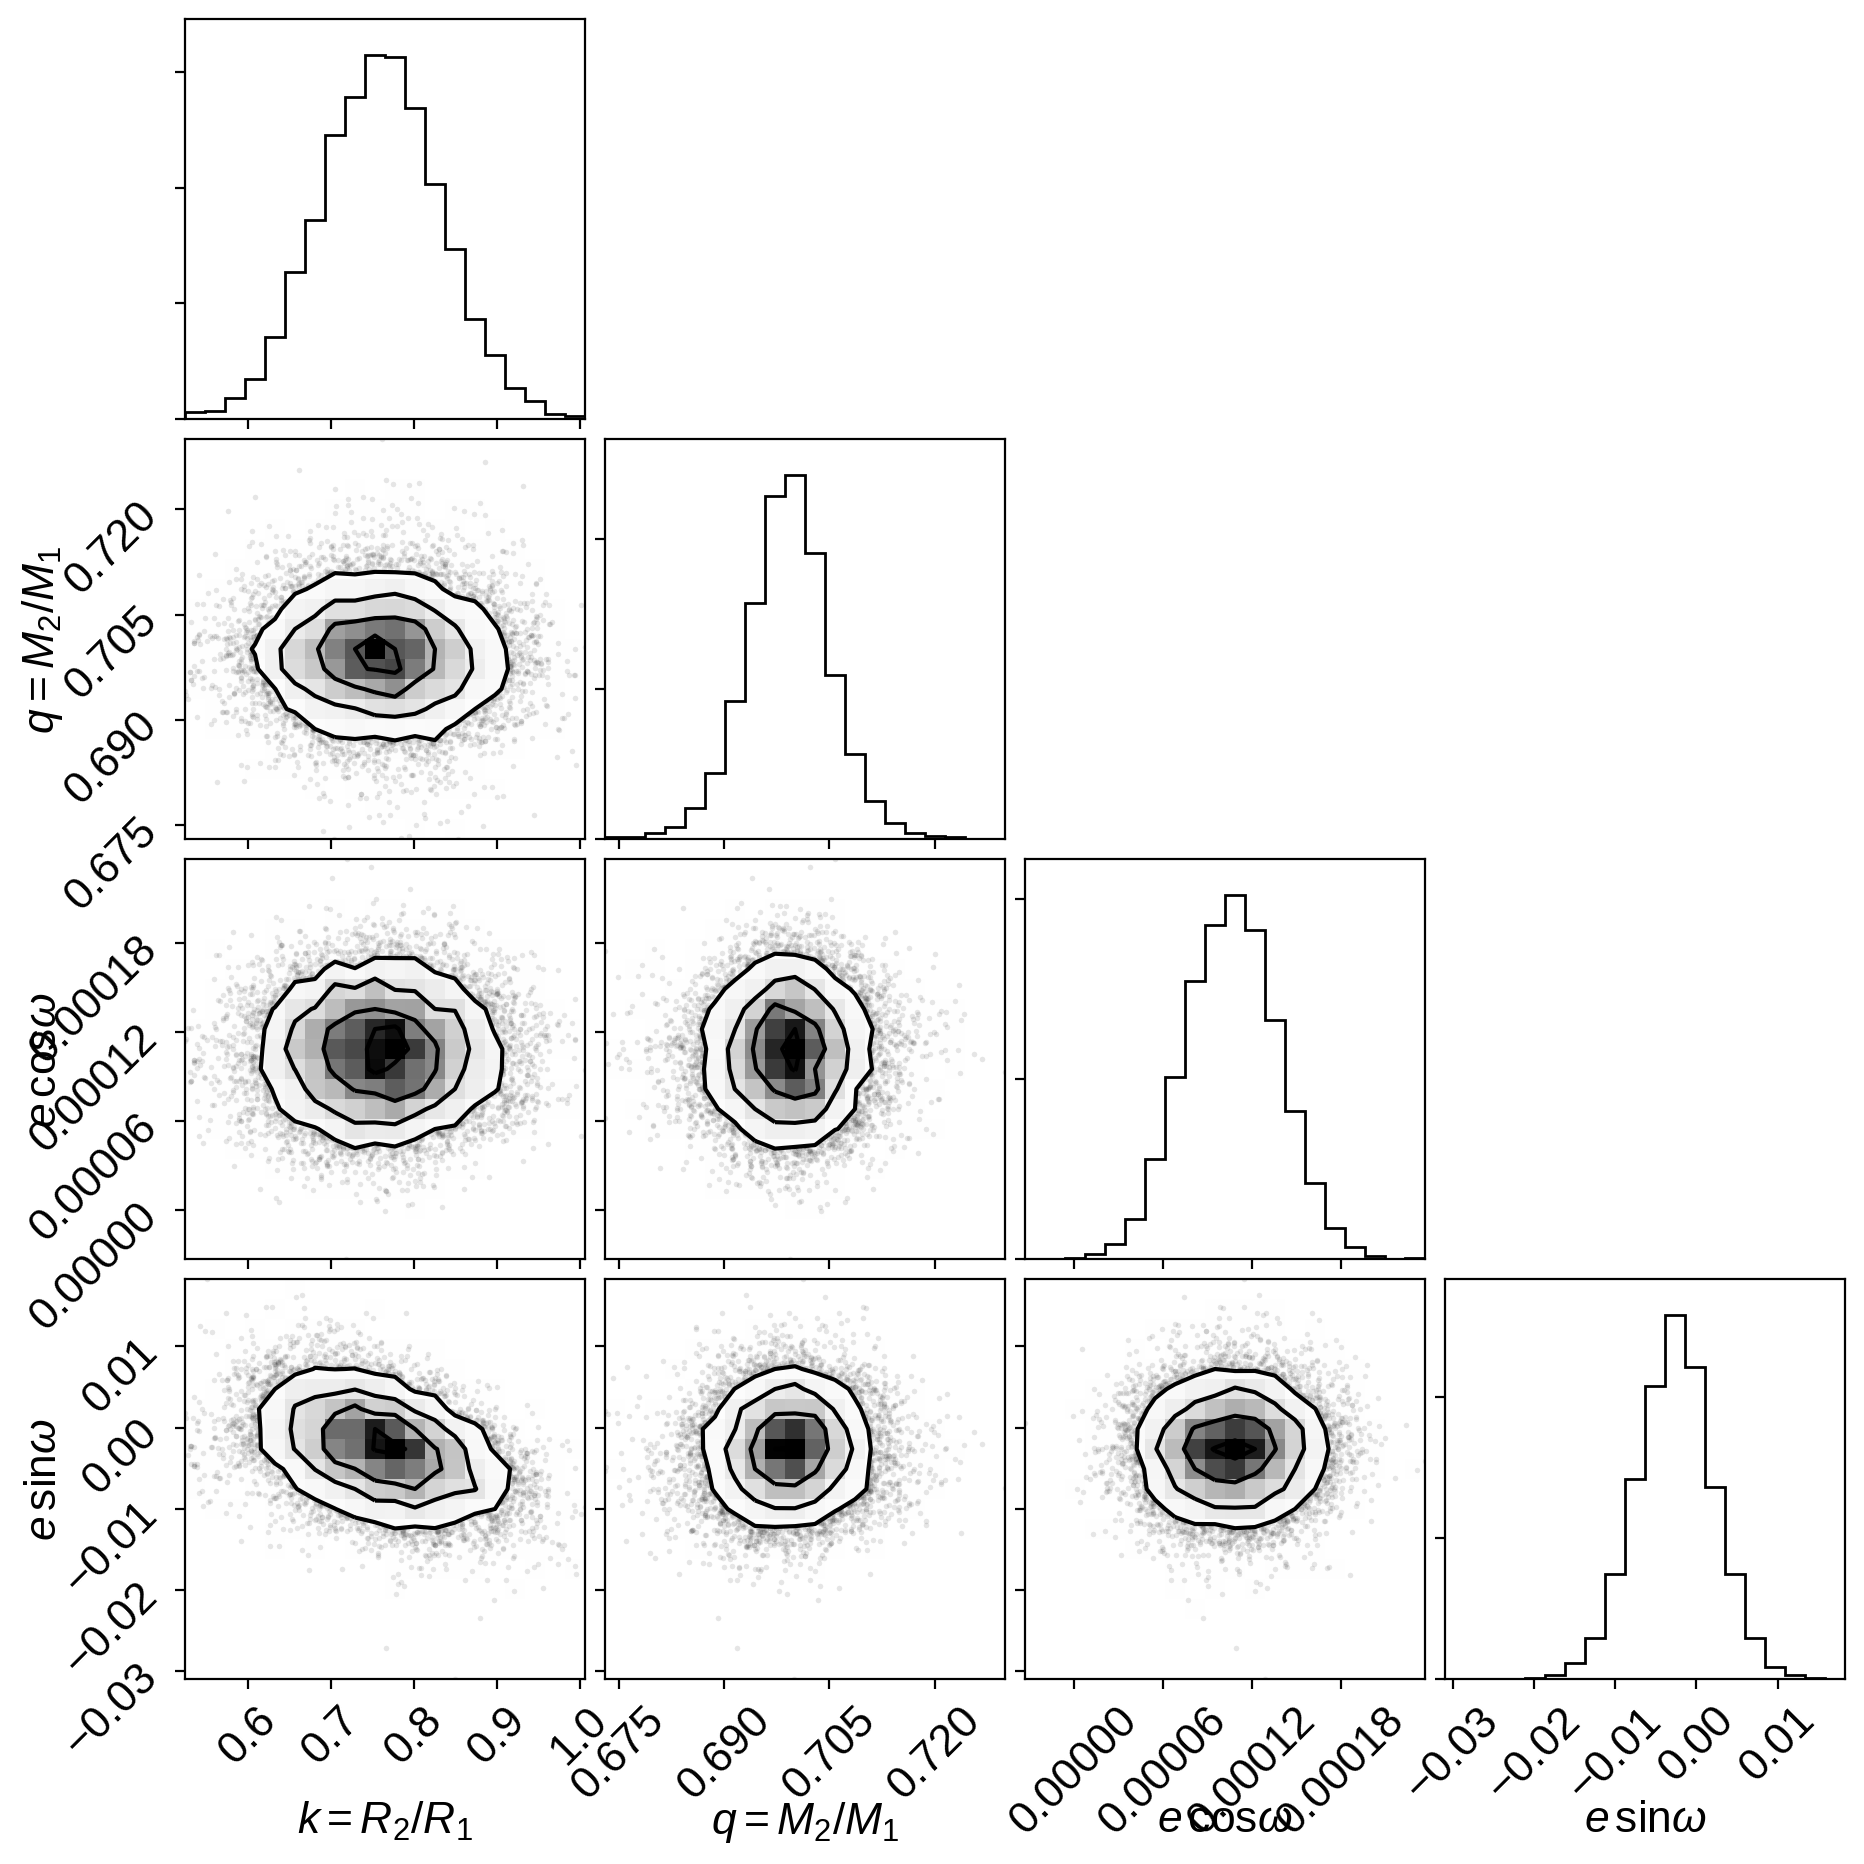

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["k", "q", "ecs"])
_ = corner.corner(
    samples,
    labels=["$k = R_2 / R_1$", "$q = M_2 / M_1$", "$e\,\cos\omega$", "$e\,\sin\omega$"],
)

And then we can look at the physical properties of the stars in the system.
In this figure, we're comparing to the results from [David+ (2016)](https://arxiv.org/abs/1602.01901).
We find that the radius of the primary is marginally inconsistent with the [David+ (2016)](https://arxiv.org/abs/1602.01901) measurement, but more consistent with other estimates from the literature (that are overplotted in different colors).

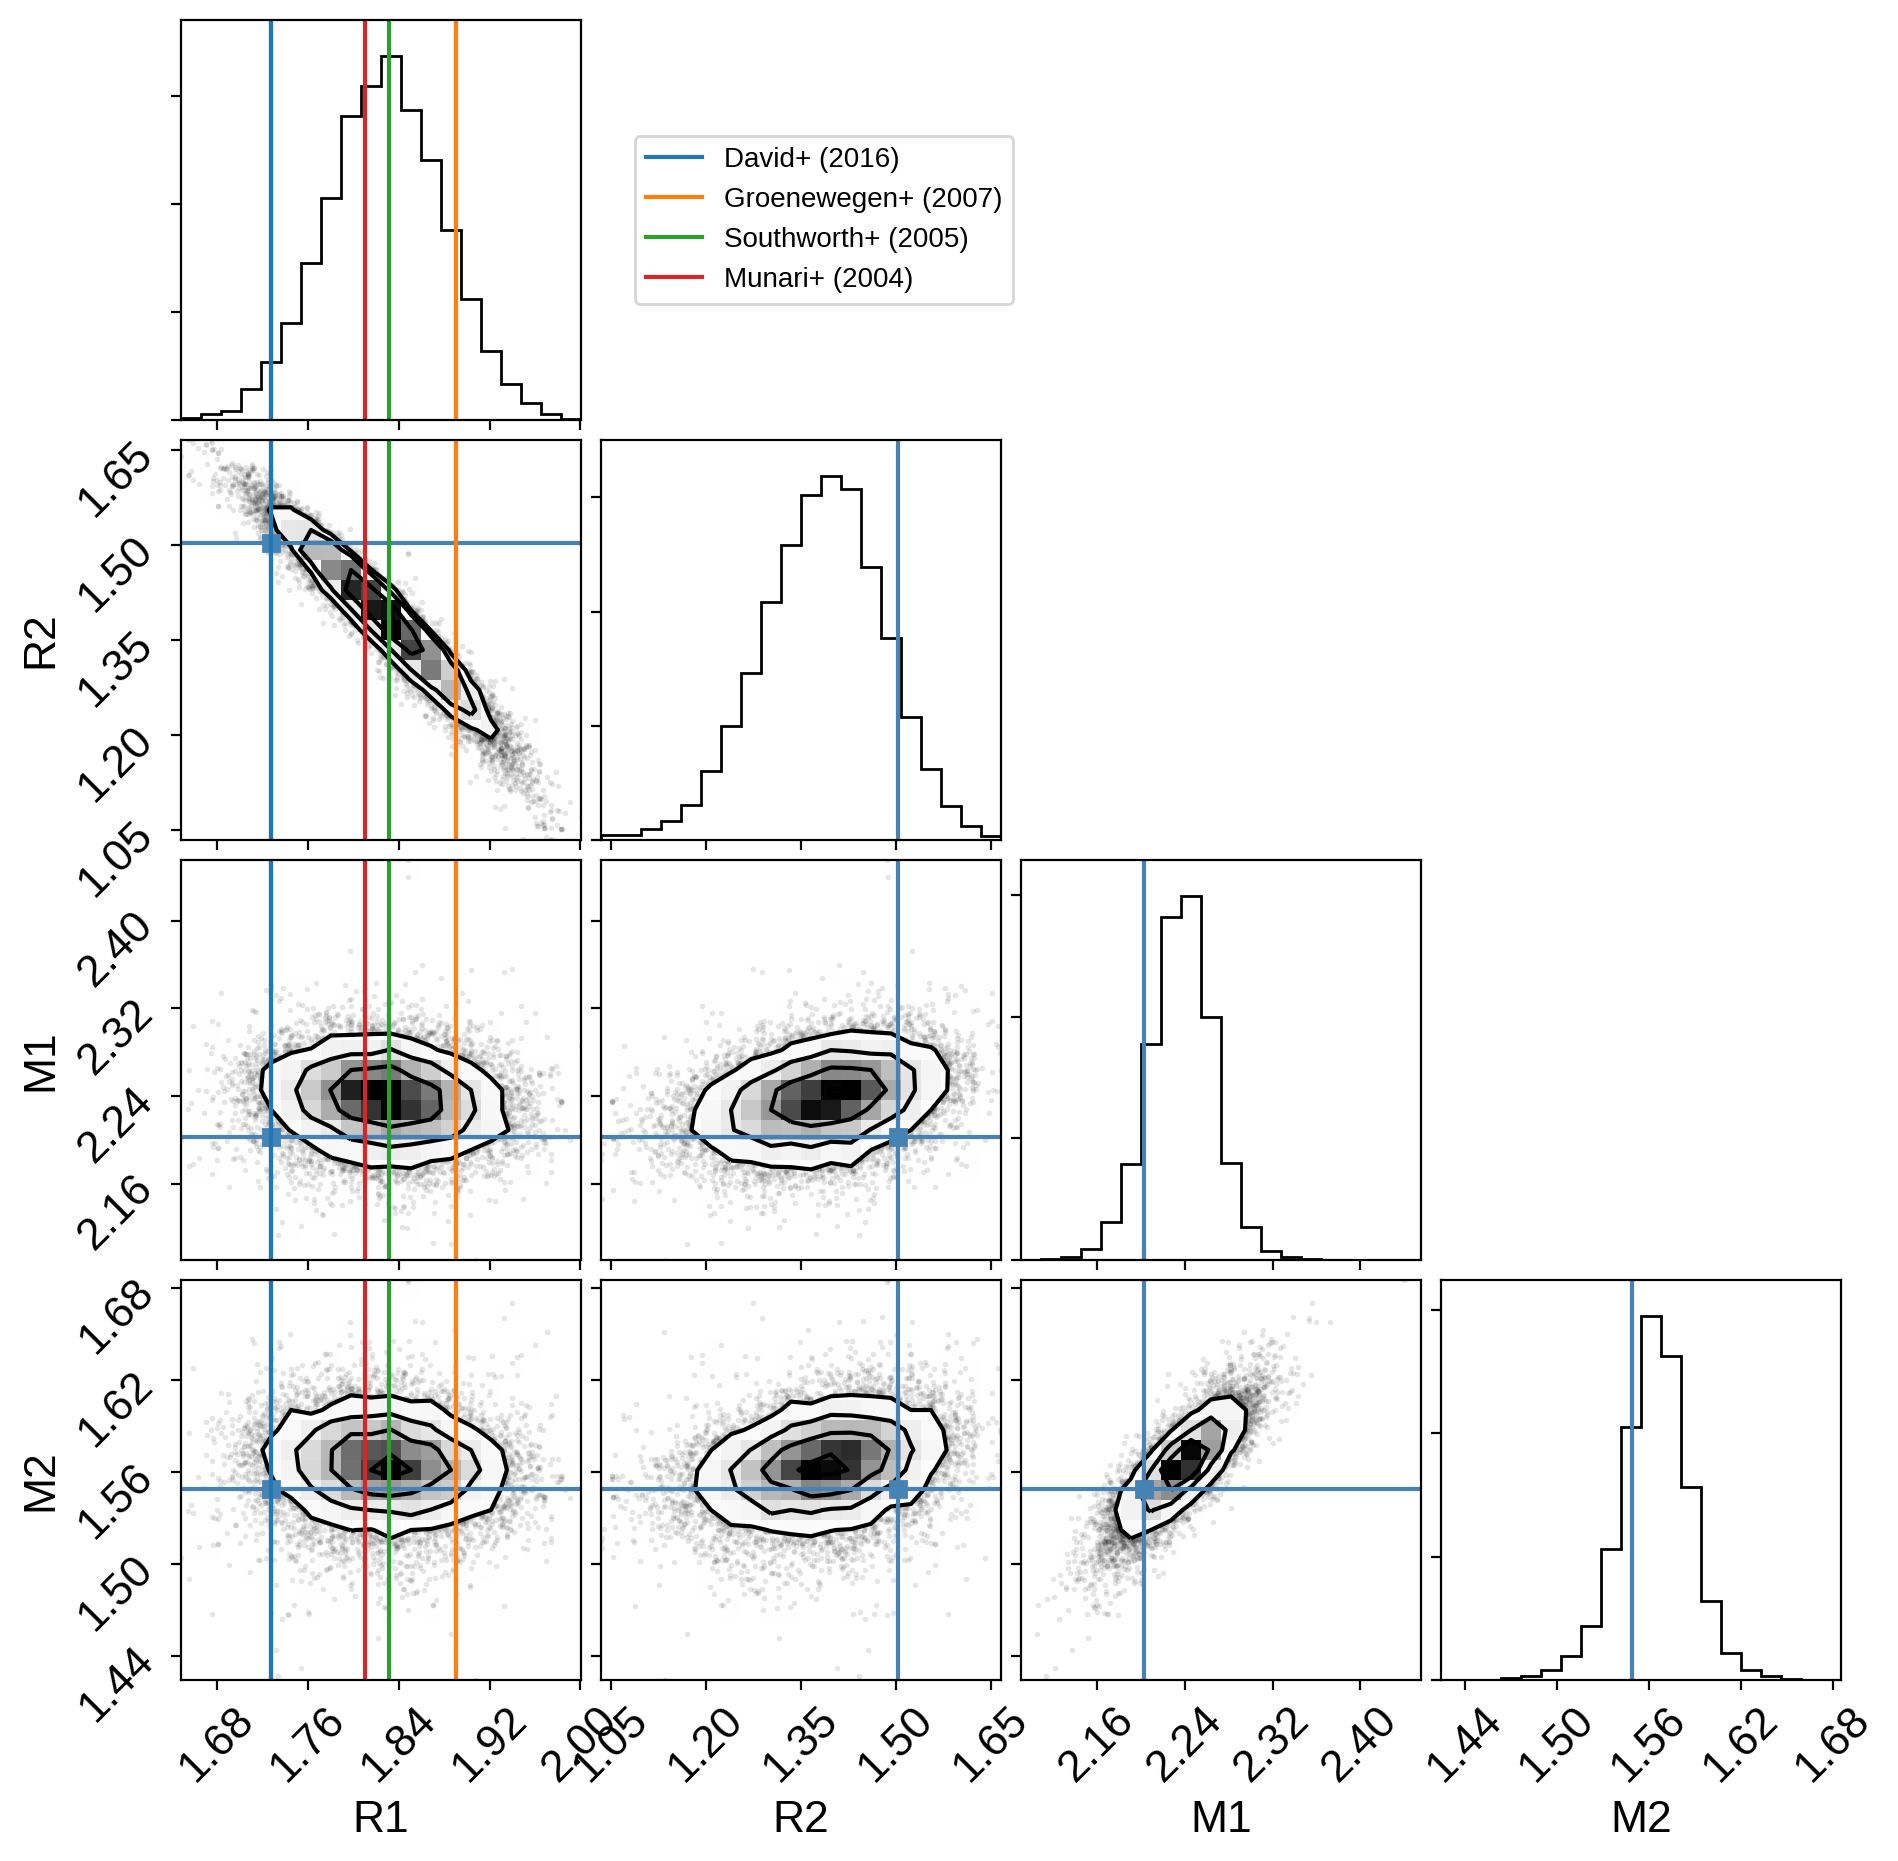

In [12]:
samples = pm.trace_to_dataframe(trace, varnames=["R1", "R2", "M1", "M2"])
fig = corner.corner(samples, truths=[1.727, 1.503, 2.203, 1.5488])

for ax in np.reshape(fig.axes, (4, 4))[:, 0]:
    ax.axvline(1.727, color="C0", label="David+ (2016)")
    ax.axvline(1.890, color="C1", label="Groenewegen+ (2007)")
    ax.axvline(1.831, color="C2", label="Southworth+ (2005)")
    ax.axvline(1.81, color="C3", label="Munari+ (2004)")

_ = fig.axes[0].legend(fontsize=10, loc="center left", bbox_to_anchor=(1.1, 0.5))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [13]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [14]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
